In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode
from MLib.PGM.Infections import preprocess_timeseries, beta_gamma_solver
from MLib.Learners.KerasLearner import MarkovChainRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from MLib.PGM.Infections import simulate_SIR_subpopulations_data, \
dg_SIR, g_SIR, f_cov_SIR, find_params_given_data_SIR_subpopulations, \
df_SIR_subpopulation, f_SIR_subpopulation
from MLib.PGM.TimeModels import Extended_Kalman_Filter
from functools import partial
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
import copy
from MLib.Core.metrics import MAPE
from MLib.Learners.KerasLearner import LogisticRegression as LogisticRegressionKeras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

In [2]:
class RegLinearRegression():
    
    def __init__(self, alpha=1):
        '''
        alpha is the regularized applied to each weight
        '''
        self.alpha = alpha
        self.theta = None
        
    def fit(self, X, y):

        num_features = X.shape[1]

        lambda_matrix = np.diag(self.alpha)

        temp = np.dot(X.T, X) + lambda_matrix
        temp_inv = np.linalg.inv(temp)
        temp_2 = np.dot(X.T, y)

        theta = np.dot(temp_inv, temp_2)

        self.theta = theta
        
    def predict(self, X):
        return np.dot(X, self.theta)

In [3]:
def create_SIR_data(population, processed_cases, processed_deaths, recovery_time=14):
    '''
    This function transforms the newly daily cases and deaths into S,I,R data.
    '''
    cum_region_cases = np.cumsum(processed_cases)
    cum_region_deaths = np.cumsum(processed_deaths)

    processed_recovered = np.zeros(len(processed_cases))

    deaths_eliminated = 0
    
    for i in range(len(cum_region_deaths) - recovery_time):
        possible_recovery = np.float(processed_cases[i])
        deaths_x_days = np.float(cum_region_deaths[i + recovery_time])

        if possible_recovery > 0:
            actual_recovered = possible_recovery - (deaths_x_days - deaths_eliminated)
            deaths_eliminated += (possible_recovery - actual_recovered)
            processed_recovered[i + recovery_time] = actual_recovered
        else:
            actual_recovered = 0

    all_region = np.vstack([processed_cases, processed_deaths, \
                            processed_recovered])

    # Create the SIR data
    S = [population - processed_cases[0] - processed_deaths[0] - processed_recovered[0]]
    I = [processed_cases[0]]
    R = [processed_deaths[0] + processed_recovered[0]]

    for i in range(len(processed_cases)-1):
        S.append(S[i] - processed_cases[i+1])
        I.append(I[i] + processed_cases[i+1] \
                 - processed_deaths[i+1] \
                 - processed_recovered[i+1])
        R.append(R[i] + processed_deaths[i+1] \
                 + processed_recovered[i+1])
    return S, I, R

In [4]:
def extract_data(start_date, end_date, country_data, features):
    '''
    This function extracts and preprocess the new daily cases and deaths
    '''
    index_start_date = np.where(country_data['Date'].values == start_date)[0][0]
    index_end_date = np.where(country_data['Date'].values == end_date)[0][0]

    country_data_dates = country_data.iloc[index_start_date:index_end_date+1,]

    cases = country_data_dates.loc[:, 'ConfirmedCases'].values
    deaths = country_data_dates.loc[:, 'ConfirmedDeaths'].values

    # Compute the number of new cases and new deaths
    new_cases = cases[1:] - cases[0:-1]
    new_deaths = deaths[1:] - deaths[0:-1]

    # ---------------------------------
    # Preprocess the data to eliminate outliers, negative values, etc
    processed_cases = preprocess_timeseries(new_cases, threshold_outliers=500, min_index_missing=0)
    processed_deaths = preprocess_timeseries(new_deaths, threshold_outliers=100, min_index_missing=0)

    num_days = len(processed_cases)

    country_data_features = country_data_dates.loc[:, features[1:]]

    # Make sure that there are no nan values If there are, then replace them by
    # the last policy that was in place.
    for element in features[1:]:
        c_column = country_data_features.loc[:, element].values
        for i in range(num_days+1):
            if np.isnan(c_column[i]):
                if i == 0:
                    c_column[i] = 0
                else:
                    c_column[i] = c_column[i-1]

        country_data_features.assign(changing_features = np.array(c_column))
        
    dates = np.array(country_data_dates.loc[:, 'Date'].values[1:])
    
    return dates, processed_cases, processed_deaths, country_data_features.iloc[1:,:]

In [5]:
def get_daily_policies(country_data_features, features, encoder_dict):
    '''
    Function to compute the daily policy, which is a binary vector.
    '''
    daily_policy = list()
    num_days = len(country_data_features.iloc[:,0].values)

    for i in range(num_days):
        feature_vector = np.array([])

        for element in features[1:]:
            c_mode = country_data_features.loc[:, element].values[i]
            c_encoding = encoder_dict[element].transform([[c_mode]])

            feature_vector = np.concatenate([feature_vector, c_encoding[0]])
        daily_policy.append(feature_vector)

    daily_policy = np.array(daily_policy)
    
    return daily_policy

In [6]:
def create_policy_dict(policies_cardinality):
    encoder_dict = dict()

    for element in policies_cardinality.keys():
        print('Creating encoder for', element)
        c_encoder = OneHotEncoder(sparse=False)
        c_encoder.fit(np.reshape(np.arange(policies_cardinality[element]), (-1,1)))
        encoder_dict[element] = c_encoder
    
    return encoder_dict

In [7]:
def learn_beta_gamma_models(X_policy, beta_policy, gamma_policy, alpha):
    '''
    Create a ridge regression model to predict beta and gamma, given the policies.
    '''
    c_X_policy = np.array(X_policy)
    c_beta_policy = np.array(beta_policy)
    c_gamma_policy = np.array(gamma_policy)

    ridge_model_beta = RegLinearRegression(alpha)
    ridge_model_gamma = RegLinearRegression(alpha)

    ridge_model_beta.fit(c_X_policy, c_beta_policy)
    ridge_model_gamma.fit(c_X_policy, c_gamma_policy)
    
    return ridge_model_beta, ridge_model_gamma

In [8]:
# Set the starting and ending dates for computing beta and gamma
start_dates_beta = ['2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19',\
               '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',\
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',\
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',\
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09',\
               '2020-08-16', '2020-08-23', '2020-08-30', '2020-09-06',\
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',\
               '2020-10-11', '2020-10-18', '2020-10-25', '2020-11-01',\
               '2020-11-08', '2020-11-15', '2020-11-22', '2020-11-29',\
               '2020-12-06', '2020-12-13', '2020-12-20', '2020-12-27',\
               '2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',\
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',\
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',\
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18',\
               '2021-04-25']

end_dates_beta = ['2020-04-04', '2020-04-11', '2020-04-18', '2020-04-25',\
             '2020-05-02', '2020-05-09', '2020-05-16', '2020-05-23',\
             '2020-05-30', '2020-06-06', '2020-06-13', '2020-06-20',\
             '2020-06-27', '2020-07-04', '2020-07-11', '2020-07-18',\
             '2020-07-25', '2020-08-01', '2020-08-08', '2020-08-15',\
             '2020-08-22', '2020-08-29', '2020-09-05', '2020-09-12',\
             '2020-09-19', '2020-09-26', '2020-10-03', '2020-10-10',\
             '2020-10-17', '2020-10-24', '2020-10-31', '2020-11-07',\
             '2020-11-14', '2020-11-21', '2020-11-28', '2020-12-05',\
             '2020-12-12', '2020-12-19', '2020-12-26', '2021-01-02',\
             '2021-01-09', '2021-01-16', '2021-01-23', '2021-01-30',\
             '2021-02-06', '2021-02-13', '2021-02-20', '2021-02-27',\
             '2021-03-06', '2021-03-13', '2021-03-20', '2021-03-27',\
             '2021-04-03', '2021-04-10', '2021-04-17', '2021-04-24',\
             '2021-05-01']

# Set the starting and ending dates for the predictions
start_dates = ['2020-08-02', '2020-08-09',\
               '2020-08-16', '2020-08-23', '2020-08-30', '2020-09-06',\
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',\
               '2020-10-11', '2020-10-18', '2020-10-25', '2020-11-01',\
               '2020-11-08', '2020-11-15', '2020-11-22', '2020-11-29',\
               '2020-12-06', '2020-12-13', '2020-12-20', '2020-12-27',\
               '2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',\
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',\
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',\
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18',\
               '2021-04-25'\
              ]


end_dates = ['2020-08-08', '2020-08-15',\
             '2020-08-22', '2020-08-29', '2020-09-05', '2020-09-12',\
             '2020-09-19', '2020-09-26', '2020-10-03', '2020-10-10',\
             '2020-10-17', '2020-10-24', '2020-10-31', '2020-11-07',\
             '2020-11-14', '2020-11-21', '2020-11-28', '2020-12-05',\
             '2020-12-12', '2020-12-19', '2020-12-26', '2021-01-02',\
             '2021-01-09', '2021-01-16', '2021-01-23', '2021-01-30',\
             '2021-02-06', '2021-02-13', '2021-02-20', '2021-02-27',\
             '2021-03-06', '2021-03-13', '2021-03-20', '2021-03-27',\
             '2021-04-03', '2021-04-10', '2021-04-17', '2021-04-24',\
             '2021-05-01'\
            ]

In [9]:
# Create a dictionary with the population of the provinces
population_path = './COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
population_data = pd.read_csv(population_path)

country_flag = population_data['Country_Region'] == 'US'
admin_flag = population_data['Admin2'].fillna('Nan').values == 'Nan'

all_flags = np.logical_and(country_flag, admin_flag)

country_data = population_data.loc[all_flags, ['Province_State', 'Population', 'FIPS']]

population_dict = dict()
fips_dict = dict()

states = country_data['Province_State'].values[6:]
populations = country_data['Population'].values[6:]
fips = country_data['FIPS'].values[6:]

for i, element in enumerate(states):
    if np.isnan(populations[i]) == False:
        if element =='District of Columbia':
            population_dict['Washington DC'] = populations[i]
            fips_dict['Washington DC'] = fips[i]
        else:
            population_dict[element] = populations[i]
            fips_dict[element] = fips[i]
        

all_regions = population_dict.keys()
print(fips_dict)

{'Alabama': 1.0, 'Alaska': 2.0, 'Arizona': 4.0, 'Arkansas': 5.0, 'California': 6.0, 'Colorado': 8.0, 'Connecticut': 9.0, 'Delaware': 10.0, 'Washington DC': 11.0, 'Florida': 12.0, 'Georgia': 13.0, 'Hawaii': 15.0, 'Idaho': 16.0, 'Illinois': 17.0, 'Indiana': 18.0, 'Iowa': 19.0, 'Kansas': 20.0, 'Kentucky': 21.0, 'Louisiana': 22.0, 'Maine': 23.0, 'Maryland': 24.0, 'Massachusetts': 25.0, 'Michigan': 26.0, 'Minnesota': 27.0, 'Mississippi': 28.0, 'Missouri': 29.0, 'Montana': 30.0, 'Nebraska': 31.0, 'Nevada': 32.0, 'New Hampshire': 33.0, 'New Jersey': 34.0, 'New Mexico': 35.0, 'New York': 36.0, 'North Carolina': 37.0, 'North Dakota': 38.0, 'Ohio': 39.0, 'Oklahoma': 40.0, 'Oregon': 41.0, 'Pennsylvania': 42.0, 'Rhode Island': 44.0, 'South Carolina': 45.0, 'South Dakota': 46.0, 'Tennessee': 47.0, 'Texas': 48.0, 'Utah': 49.0, 'Vermont': 50.0, 'Virginia': 51.0, 'Washington': 53.0, 'West Virginia': 54.0, 'Wisconsin': 55.0, 'Wyoming': 56.0}


In [10]:
# Set the path to the directory with the Oxford Policy Tracker
policy_path = './covid-policy-tracker/data/OxCGRT_latest.csv'

# Load the dataset
data = pd.read_csv(policy_path)

/home/rvega/Envs/zehra/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Estimate the betas per every day, in every province.
Params_dict = dict()

# Create a list to store a dateset with the policies and beta
country = 'United States'

# Use only the features that are not constant across the entire time
policies_cardinality = {'C1_School closing':4, 'C2_Workplace closing':4, 'C3_Cancel public events':3,\
    'C4_Restrictions on gatherings':5, 'C5_Close public transport':3, 'C6_Stay at home requirements':4,\
    'C7_Restrictions on internal movement':3, 'C8_International travel controls':5, \
    'E1_Income support':3, 'E2_Debt/contract relief':3,\
    'H1_Public information campaigns':3, 'H2_Testing policy':4, 'H3_Contact tracing':3, \
    'H6_Facial Coverings':5, 'H7_Vaccination policy':6}

# Transform the daily policy into a binary vector
encoder_dict = create_policy_dict(policies_cardinality)
    
# Define the range of days to analyze, and the policies that we want
# to evaluate.
start_date = 20200327
end_date = 20210503
    
features = ['Date',\
    'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',\
    'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',\
    'C7_Restrictions on internal movement', 'C8_International travel controls', \
    'E1_Income support', 'E2_Debt/contract relief',\
    'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
    'H6_Facial Coverings', 'H7_Vaccination policy']

features = ['Date',\
    'C4_Restrictions on gatherings', 'H7_Vaccination policy', 'C3_Cancel public events']

for region in all_regions:
    Params_dict[region] = dict()

for region in all_regions:
    print(region)
    Params_dict[region]['Date'] = list()
    Params_dict[region]['Beta'] = list()
    Params_dict[region]['Gamma'] = list()
    Params_dict[region]['Holidays'] = list()
    Params_dict[region]['Policy'] = list()
    Params_dict[region]['Policy_changes'] = list()
    Params_dict[region]['ICU'] = list()
    Params_dict[region]['Hospitalizations'] = list()
    Params_dict[region]['S'] = list()
    Params_dict[region]['I'] = list()
    Params_dict[region]['R'] = list()
    Params_dict[region]['Cases'] = list()
    Params_dict[region]['Deaths'] = list()
    
    # Get the data from the current region only.
    country_flag = data['CountryName'] == country
    region_flag = data['RegionName'] == region
    all_flags = np.logical_and(country_flag, region_flag)
    country_data = data.loc[all_flags, :]

    dates, processed_cases, processed_deaths, country_data_features = \
        extract_data(start_date, end_date, country_data, features)

    daily_policy = get_daily_policies(country_data_features, 
                                      features, encoder_dict)

    # -----------------------------------------------------------
    # Since the number of recovered is not in the data, assume that all the people
    # who didn't die within 15 days has recovered.
    population = population_dict[region]

    S, I, R = create_SIR_data(population, processed_cases, 
                              processed_deaths, recovery_time=14)
    
    # Load the holidays data
    holidays_data = pd.read_csv('./COVID-PGM/Holidays_dataset_Countries.csv')
    holidays_Canada = np.zeros(len(S))

    temp = list()
    for i in range(len(holidays_data)):
        for j in range(7):
            temp.append(holidays_data['US'].values[i])
            
    holidays_Canada[0:len(temp)] = temp
    
#     print('Length')
#     print(len(S))
#     print(len(I))
#     print(len(R))
#     print(len(dates))
#     print(len(processed_cases))
#     print(len(processed_deaths))
#     print(country_data_features.shape)
#     print(len(daily_policy))
    
    for date_str, end_date_str in zip(start_dates_beta, end_dates_beta):
#         print(date_str)
        date_parts = date_str.split('-')
        date = np.int32(''.join(date_parts))
        start_indx = np.where(dates == date)[0][0]
        last_indx = start_indx + 7
        
        S_train = S[start_indx-1:last_indx]
        I_train = I[start_indx-1:last_indx]
        R_train = R[start_indx-1:last_indx]

        beta, gamma = beta_gamma_solver(S_train, I_train, R_train)
            
        for j in range(last_indx - start_indx):
            Params_dict[region]['Date'].append(dates[start_indx+j])
            Params_dict[region]['Beta'].append(beta)
            Params_dict[region]['Gamma'].append(gamma)
            Params_dict[region]['Policy'].append(daily_policy[start_indx+j])
            Params_dict[region]['S'].append(S[start_indx+j])
            Params_dict[region]['I'].append(I[start_indx+j])
            Params_dict[region]['R'].append(R[start_indx+j])
            Params_dict[region]['Holidays'].append(holidays_Canada[start_indx+j])
            Params_dict[region]['Cases'].append(processed_cases[start_indx+j])
            Params_dict[region]['Deaths'].append(processed_deaths[start_indx+j])
            
    last_policy = Params_dict[region]['Policy'][0]
    weeks_since_change = 7

    Params_dict[region]['Weeks_since_change'] = list()

    for i in range(0,len(Params_dict[region]['Policy']),7):
        # Check if there is a change in policy during the current week
        c_policy = Params_dict[region]['Policy'][i+6]

        for j in range(7):
            Params_dict[region]['Weeks_since_change'].append(weeks_since_change)

        if np.sum(np.abs(c_policy - last_policy)) > 0:
            weeks_since_change = 0
            last_policy = c_policy
        else:
            if weeks_since_change < 7:
                weeks_since_change += 1


Creating encoder for C1_School closing
Creating encoder for C2_Workplace closing
Creating encoder for C3_Cancel public events
Creating encoder for C4_Restrictions on gatherings
Creating encoder for C5_Close public transport
Creating encoder for C6_Stay at home requirements
Creating encoder for C7_Restrictions on internal movement
Creating encoder for C8_International travel controls
Creating encoder for E1_Income support
Creating encoder for E2_Debt/contract relief
Creating encoder for H1_Public information campaigns
Creating encoder for H2_Testing policy
Creating encoder for H3_Contact tracing
Creating encoder for H6_Facial Coverings
Creating encoder for H7_Vaccination policy
Alabama
Alaska
Arizona
Arkansas
California


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Colorado
Connecticut


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Delaware
Washington DC
Florida


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Georgia


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Hawaii
Idaho
Illinois


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Indiana


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iowa
Kansas
Kentucky
Louisiana


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Maine
Maryland
Massachusetts


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Michigan


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


New Mexico
New York


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Rhode Island
South Carolina
South Dakota
Tennessee


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Texas


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Utah
Vermont
Virginia
Washington


/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rvega/Envs/zehra/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


West Virginia
Wisconsin
Wyoming


In [12]:
def date_to_str_Alberta(date):
    num_to_month = {'01':'Jan', '02':'Feb', '03':'Mar', '04':'Apr',\
                    '05':'May', '06':'Jun', '07':'Jul', '08':'Aug',\
                    '09':'Sep', '10':'Oct', '11':'Nov', '12':'Dec'}
    
    date_str = str(date)
    
    month = date_str[4:6]
    day = date_str[6:8]
    year = date_str[2:4]
    
    if day[0] == '0':
        day = day[1]
    
    return '-'.join([day, num_to_month[month], year])

In [13]:
# Create some probability tuples of (angle, percentage, probability)
# prob_tuple = np.array([
#     [0, 0.75, 0, 0.5, 0.5],
#     [0, 0.5, 0.005, 0.99, 0.005],
#     [0, 0.25, 0.5, 0.5, 0],
#     [30, 0.5, 0, 0.5, 0.5],
#     [-30, 0.5, 0.5, 0.5, 0],
#     [60, 0.5, 0, 0.01, 0.99],
#     [-60, 0.5, 0.99, 0.01, 0],
#     [0, 0.875, 0, 0.01, 0.99],
#     [0, 0.125, 0.99, 0.01, 0],
#     [30, 0.125, 0.5, 0.5, 0],
#     [60, 0.25, 0, 0.5, 0.5],
#     [60, 0.125, 0, 1, 0],
#     [-60, 0.125, 1, 0, 0],
#     [-60, 0.75, 0.5, 0.5, 0],
#     [-30, 0.875, 0, 0.5, 0.5],
#     [60, 0.875, 0, 0, 1]
# #     [-30, 0.75, 0.33, 0.34, 0.33],
# #     [30, 0.25, 0.33, 0.34, 0.33]
# ])

prob_tuple = np.array([
    [125, 0, 0.01, 0.98, 0.01],
    [200, 0, 0, 0.5, 0.5],
    [50, 0, 0.5, 0.5, 0],
    [125, -20, 0.5, 0.5, 0],
    [125, 20, 0, 0.5, 0.5],
    [200, 20, 0, 0.1, 0.9],
    [200, 40, 0, 0, 1],
    [50, -20, 0.9, 0.1, 0],
    [50, 20, 0, 1, 0],
    [200,-20, 0, 1, 0],
    [0, -40, 1, 0, 0],
    [250,40, 0, 0, 1]
])

# prob_tuple[:,0] = prob_tuple[:,0] *2
print(np.sum(prob_tuple[:,2:], axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
nn_model = keras.Sequential(
    [
        layers.Dense(64, activation='sigmoid', name='hidden_1'),
        layers.Dense(3, activation='softmax', name='output')
    ]
)

x = np.ones((3,2))
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction="auto", name="categorical_crossentropy"
)

optimizer_fn = tf.keras.optimizers.Adam(
    learning_rate=1E-3
)

nn_model.compile(optimizer=optimizer_fn,
              loss=loss_fn)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=1E-5, patience=30, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

nn_model.fit(prob_tuple[:,0:2], prob_tuple[:,2:], verbose=1, epochs=10000, callbacks=[early_stopping])

print(nn_model(prob_tuple[:,0:2]))

print(prob_tuple[:,2:])

Epoch 1/10000
1/1 [==============================] - 0s 412ms/step - loss: 1.4316
Epoch 2/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.4037
Epoch 3/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.3771
Epoch 4/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.3518
Epoch 5/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.3277
Epoch 6/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.3051
Epoch 7/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.2838
Epoch 8/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.2639
Epoch 9/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.2453
Epoch 10/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.2279
Epoch 11/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.2113
Epoch 12/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.1953
Epoch 13/10000
1/1 [===============

1/1 [==============================] - 0s 4ms/step - loss: 0.6167
Epoch 103/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.6122
Epoch 104/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.6075
Epoch 105/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.6027
Epoch 106/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5981
Epoch 107/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5937
Epoch 108/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5897
Epoch 109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5858
Epoch 110/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5821
Epoch 111/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5782
Epoch 112/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5744
Epoch 113/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5706
Epoch 114/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.4351
Epoch 203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4346
Epoch 204/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4342
Epoch 205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.4338
Epoch 206/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4333
Epoch 207/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4329
Epoch 208/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4324
Epoch 209/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4319
Epoch 210/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4315
Epoch 211/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.4310
Epoch 212/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.4305
Epoch 213/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.4301
Epoch 214/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.3944
Epoch 303/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3941
Epoch 304/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3938
Epoch 305/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3935
Epoch 306/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3932
Epoch 307/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3929
Epoch 308/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3925
Epoch 309/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3922
Epoch 310/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3919
Epoch 311/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3916
Epoch 312/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3913
Epoch 313/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3910
Epoch 314/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.3672
Epoch 403/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3670
Epoch 404/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3668
Epoch 405/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3666
Epoch 406/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3664
Epoch 407/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3662
Epoch 408/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3660
Epoch 409/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3658
Epoch 410/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3656
Epoch 411/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3654
Epoch 412/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3652
Epoch 413/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3650
Epoch 414/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.3502
Epoch 503/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3500
Epoch 504/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3499
Epoch 505/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3497
Epoch 506/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3496
Epoch 507/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3495
Epoch 508/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3493
Epoch 509/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3492
Epoch 510/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3490
Epoch 511/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3489
Epoch 512/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3487
Epoch 513/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3486
Epoch 514/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.3372
Epoch 603/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3371
Epoch 604/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3370
Epoch 605/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3369
Epoch 606/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3368
Epoch 607/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3367
Epoch 608/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3366
Epoch 609/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3365
Epoch 610/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3364
Epoch 611/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3363
Epoch 612/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3362
Epoch 613/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3361
Epoch 614/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.3281
Epoch 703/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3280
Epoch 704/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3279
Epoch 705/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3279
Epoch 706/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3278
Epoch 707/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3277
Epoch 708/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3276
Epoch 709/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3276
Epoch 710/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3275
Epoch 711/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3274
Epoch 712/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3273
Epoch 713/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3273
Epoch 714/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.3210
Epoch 803/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3210
Epoch 804/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3209
Epoch 805/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3208
Epoch 806/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3208
Epoch 807/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3207
Epoch 808/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3207
Epoch 809/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3206
Epoch 810/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3205
Epoch 811/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.3205
Epoch 812/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3204
Epoch 813/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3203
Epoch 814/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.3153
Epoch 903/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3152
Epoch 904/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.3152
Epoch 905/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3151
Epoch 906/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3151
Epoch 907/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3150
Epoch 908/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3150
Epoch 909/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3149
Epoch 910/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3148
Epoch 911/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3147
Epoch 912/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3147
Epoch 913/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3146
Epoch 914/10000
1/1 [===========

1/1 [==============================] - 0s 7ms/step - loss: 0.3104
Epoch 1003/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.3103
Epoch 1004/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3103
Epoch 1005/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3103
Epoch 1006/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3102
Epoch 1007/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.3102
Epoch 1008/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3102
Epoch 1009/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3101
Epoch 1010/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3101
Epoch 1011/10000
1/1 [==============================] - ETA: 0s - loss: 0.310 - 0s 5ms/step - loss: 0.3100
Epoch 1012/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3100
Epoch 1013/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.31

1/1 [==============================] - 0s 4ms/step - loss: 0.3069
Epoch 1101/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3069
Epoch 1102/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3069
Epoch 1103/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3069
Epoch 1104/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3068
Epoch 1105/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3068
Epoch 1106/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3068
Epoch 1107/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.3067
Epoch 1108/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3067
Epoch 1109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3067
Epoch 1110/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3066
Epoch 1111/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3066
Epoch 1112/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.3043
Epoch 1199/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3043
Epoch 1200/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3043
Epoch 1201/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3042
Epoch 1202/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3042
Epoch 1203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3042
Epoch 1204/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3041
Epoch 1205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3041
Epoch 1206/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.3041
Epoch 1207/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3041
Epoch 1208/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3040
Epoch 1209/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3040
Epoch 1210/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.3023
Epoch 1297/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3023
Epoch 1298/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3023
Epoch 1299/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3023
Epoch 1300/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3022
Epoch 1301/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3022
Epoch 1302/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3022
Epoch 1303/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3022
Epoch 1304/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3022
Epoch 1305/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3022
Epoch 1306/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3021
Epoch 1307/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3021
Epoch 1308/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.3010
Epoch 1395/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3010
Epoch 1396/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3010
Epoch 1397/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3010
Epoch 1398/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3009
Epoch 1399/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 1400/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3009
Epoch 1401/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 1402/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 1403/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3009
Epoch 1404/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 1405/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 1406/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.3000
Epoch 1493/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3000
Epoch 1494/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3000
Epoch 1495/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3000
Epoch 1496/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.3000
Epoch 1497/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.3000
Epoch 1498/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2999
Epoch 1499/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2999
Epoch 1500/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2999
Epoch 1501/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2999
Epoch 1502/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2999
Epoch 1503/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2999
Epoch 1504/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2993
Epoch 1591/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2993
Epoch 1592/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2993
Epoch 1593/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2994
Epoch 1594/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2994
Epoch 1595/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2995
Epoch 1596/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2994
Epoch 1597/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2993
Epoch 1598/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2992
Epoch 1599/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2992
Epoch 1600/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2992
Epoch 1601/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2993
Epoch 1602/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1689/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1690/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1691/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1692/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1693/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1694/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1695/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1696/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1697/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2986
Epoch 1698/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2986
Epoch 1699/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2986
Epoch 1700/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2982
Epoch 1787/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2982
Epoch 1788/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2982
Epoch 1789/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2982
Epoch 1790/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2982
Epoch 1791/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2982
Epoch 1792/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2983
Epoch 1793/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2984
Epoch 1794/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2984
Epoch 1795/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2984
Epoch 1796/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2982
Epoch 1797/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2981
Epoch 1798/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.2978
Epoch 1885/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2978
Epoch 1886/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2978
Epoch 1887/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2978
Epoch 1888/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2978
Epoch 1889/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2978
Epoch 1890/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2977
Epoch 1891/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2977
Epoch 1892/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2977
Epoch 1893/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2977
Epoch 1894/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2977
Epoch 1895/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2977
Epoch 1896/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2974
Epoch 1983/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2974
Epoch 1984/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 1985/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 1986/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2974
Epoch 1987/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2974
Epoch 1988/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2974
Epoch 1989/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2974
Epoch 1990/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 1991/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 1992/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2974
Epoch 1993/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2974
Epoch 1994/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2972
Epoch 2081/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2972
Epoch 2082/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2972
Epoch 2083/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2972
Epoch 2084/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2972
Epoch 2085/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2972
Epoch 2086/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2972
Epoch 2087/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2972
Epoch 2088/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2972
Epoch 2089/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2972
Epoch 2090/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2972
Epoch 2091/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2972
Epoch 2092/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 2179/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 2180/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 2181/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2969
Epoch 2182/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 2183/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.2969
Epoch 2184/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 2185/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 2186/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 2187/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 2188/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2969
Epoch 2189/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2969
Epoch 2190/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 2277/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2970
Epoch 2278/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 2279/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2967
Epoch 2280/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 2281/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2969
Epoch 2282/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2969
Epoch 2283/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2968
Epoch 2284/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2967
Epoch 2285/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 2286/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2968
Epoch 2287/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2968
Epoch 2288/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.2966
Epoch 2375/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2966
Epoch 2376/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2966
Epoch 2377/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2966
Epoch 2378/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2966
Epoch 2379/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2966
Epoch 2380/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2966
Epoch 2381/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2966
Epoch 2382/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2966
Epoch 2383/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.2966
Epoch 2384/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2966
Epoch 2385/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2966
Epoch 2386/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2964
Epoch 2473/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2964
Epoch 2474/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2964
Epoch 2475/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2964
Epoch 2476/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2964
Epoch 2477/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2964
Epoch 2478/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2964
Epoch 2479/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2964
Epoch 2480/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2964
Epoch 2481/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2964
Epoch 2482/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2964
Epoch 2483/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2964
Epoch 2484/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 2571/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 2572/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 2573/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 2574/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 2575/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2576/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 2577/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2963
Epoch 2578/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2579/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2580/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 2581/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2963
Epoch 2582/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2669/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2961
Epoch 2670/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2671/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2672/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2961
Epoch 2673/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2961
Epoch 2674/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2961
Epoch 2675/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2676/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2677/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2961
Epoch 2678/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2679/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2961
Epoch 2680/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2961
Epoch 2767/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2768/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2960
Epoch 2769/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2960
Epoch 2770/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2771/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 2772/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.2960
Epoch 2773/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2960
Epoch 2774/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2960
Epoch 2775/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2960
Epoch 2776/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2960
Epoch 2777/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2960
Epoch 2778/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2959
Epoch 2865/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2959
Epoch 2866/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2959
Epoch 2867/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2959
Epoch 2868/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2959
Epoch 2869/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2959
Epoch 2870/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2959
Epoch 2871/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2959
Epoch 2872/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2959
Epoch 2873/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2959
Epoch 2874/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2959
Epoch 2875/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2959
Epoch 2876/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.2958
Epoch 2963/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 2964/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 2965/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 2966/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 2967/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 2968/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 2969/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 2970/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 2971/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 2972/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2973/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 2974/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3061/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3062/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3063/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3064/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 3065/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 3066/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3067/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3068/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3069/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3070/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 3071/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3072/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3159/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3160/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3161/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3162/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 3163/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 3164/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 3165/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 3166/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2956
Epoch 3167/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 3168/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 3169/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 3170/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.2960
Epoch 3257/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2959
Epoch 3258/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 3259/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 3260/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 3261/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 3262/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3263/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 3264/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 3265/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 3266/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 3267/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2956
Epoch 3268/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.2955
Epoch 3355/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3356/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3357/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3358/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3359/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3360/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3361/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3362/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3363/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2955
Epoch 3364/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3365/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2955
Epoch 3366/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.2955
Epoch 3453/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3454/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3455/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3456/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2955
Epoch 3457/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3458/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2955
Epoch 3459/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3460/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.2955
Epoch 3461/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3462/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.2955
Epoch 3463/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.2955
Epoch 3464/10000
1/1 

In [15]:
# angle_lin = np.linspace(-60, 60, 200)
# percentage_lin = np.linspace(0, 1, 200)
# xy = np.meshgrid(angle_lin, percentage_lin)

# probabilities = np.zeros([len(angle_lin), len(percentage_lin), 3])

# # for i in range(len(angle_lin)):
# #     for j in range(len(percentage_lin)):
# #         c_tuple = np.array([[angle_lin[i], percentage_lin[j]]])
# #         prob = nn_model(c_tuple)
# #         probabilities[i,j] = prob.numpy()[0][0]

# for i in range(len(angle_lin)):
#     c_tuple = np.hstack([np.reshape(xy[0][0], (-1,1)), np.reshape(xy[1][i], (-1,1))])
#     prob = nn_model(c_tuple)
#     probabilities[i,:,:] = prob.numpy()


cases_lin = np.linspace(0, 200, 200)
vel_lin = np.linspace(-40, 40, 200)
xy = np.meshgrid(cases_lin, vel_lin)

probabilities = np.zeros([len(cases_lin), len(vel_lin), 3])

# for i in range(len(angle_lin)):
#     for j in range(len(percentage_lin)):
#         c_tuple = np.array([[angle_lin[i], percentage_lin[j]]])
#         prob = nn_model(c_tuple)
#         probabilities[i,j] = prob.numpy()[0][0]

for i in range(len(cases_lin)):
    c_tuple = np.hstack([np.reshape(xy[0][0], (-1,1)), np.reshape(xy[1][i], (-1,1))])
    prob = nn_model(c_tuple)
    probabilities[i,:,:] = prob.numpy()

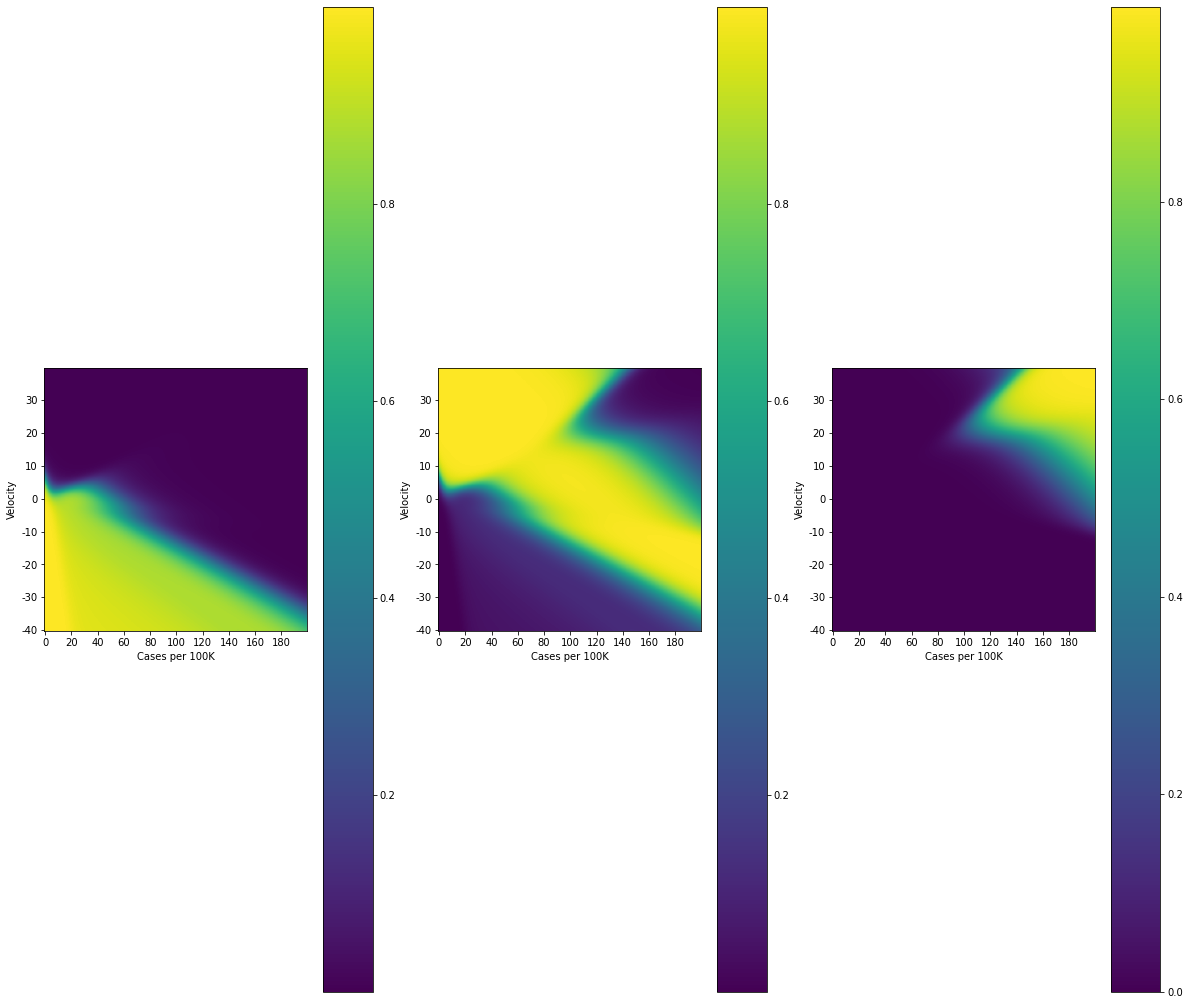

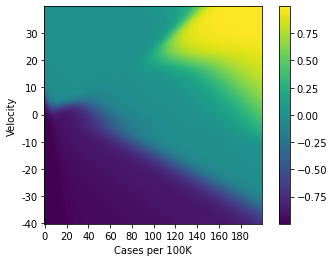

In [16]:
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(probabilities[:,:,0], origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)


plt.subplot(1,3,2)
plt.imshow(probabilities[:,:,1], origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)


plt.subplot(1,3,3)
plt.imshow(probabilities[:,:,2], origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)

plt.show()

new_plot = probabilities[:,:,2] + probabilities[:,:,0]*-1

plt.figure()
plt.imshow(new_plot, origin='lower')
plt.colorbar()
plt.xlabel('Cases per 100K')
plt.ylabel('Velocity')

y_ticks = np.round(np.arange(-40,40,10),1)
x_ticks = np.arange(0, 200, 20)
plt.yticks(np.arange(0,200, 200/len(y_ticks)), y_ticks)
plt.xticks(np.arange(0,200, 200/len(x_ticks)), x_ticks)

plt.show()

In [17]:
class Factor():
    def __init__(self, variables, cardinality, values=[]):
        '''
        This function initializes a factor. A factor is defined by three different arrays:
        - variables: Numpy array that contains the id of the variables in the scope of the factor. The id is a number
            between 0 and # variables.
        - cardinality: Numpy array that contains the cardinality of the variables in the scope of the factor.
            The order of the entries is the same than the order in variables.
        - values: Value of every assignment in the factor. It is a numpy array with prod(cardinality) entries,
            one per every combination of values.
        '''

        self.variables = variables
        self.cardinality = cardinality

        # Compute the number of entries that the factor should have:
        num_entries = np.int32(np.prod(self.cardinality))
        if len(values) > 0:
            if len(values) == num_entries:
                self.values = values
            else:
                # print('Initializing factor with zeros')
                self.values = np.zeros(num_entries)
        else:
            # print('Initializing factor with zeros')
            self.values = np.zeros(num_entries)

        # Create the one-hot encoding object
        # self.onehot_encoder = OneHotEncoder(n_values=np.int16(num_entries), sparse=False)
        # self.onehot_encoder.fit(np.reshape(range(num_entries), (-1,1)))

        # Create the array that converts assignment to index
        temp = np.hstack([self.cardinality, 1])
        temp = np.flip(temp, axis=0)
        temp = np.flip(np.cumprod(temp), axis=0)

        self.convert_a_to_i = temp

        # Create a dictionary that maps every variable to an index
        var_to_ind = dict()
        for i in range(len(variables)):
            var_to_ind[variables[i]] = i

        self.var_to_ind = var_to_ind

    def index_to_assignment(self, index):
        # Extract the vector that contains the cumulative product of the cardinality
        temp = self.convert_a_to_i[1:]

        # Transform the vectors into matrices (This is needed to process several indexes
        # at the same time.)
        temp = np.matmul(np.ones([len(index), 1]), np.reshape(temp,[1,-1]))
        temp_index = np.matmul(np.reshape(index,[-1,1]), np.ones([1, temp.shape[1]]))
        temp_cardinality = np.matmul(np.ones([len(index), 1]), np.reshape(self.cardinality,[1,-1]))

        # Convert the index into the actual assignment
        temp = np.mod(np.floor(np.divide(temp_index,temp)), temp_cardinality)

        return np.int8(temp)

    def assignment_to_index(self, assignment):
        # Function that returns the index (in the values vector) of the given assignment.
        # Assignment is an array with len(self.variables) entries
        temp_card = self.convert_a_to_i[1:]

        index = np.sum(temp_card*assignment, axis=1)

        return np.reshape(index, (-1,1))

    def full_assignment_to_index(self, x):
        # Function that returns the index (in the values vector) of the given assignment.
        # x is an array that contains the entire instance
        assignment = x[:,self.variables]
        return self.assignment_to_index(assignment)

    # def assignment_to_one_hot_encoding(self, assignment):
    #   # Transform the current assignment to a one hot encoding.
    #   # Assignment is an array with len(self.variables) entries
    #   index = self.assignment_to_index(assignment)

    #   return self.onehot_encoder.transform(np.array(index))

    # def full_assignment_to_one_hot_encoding(self, x):
    #   # Transform the current vector to a one hot encoding of the variables in the factor
    #   # x is an array that contains the entire instance
    #   assignment = x[:,self.variables]
    #   return self.assignment_to_one_hot_encoding(assignment)

    def get_value_assignment(self, assignment):
        index = self.assignment_to_index(assignment)
        index = np.reshape(index, (-1))

        return np.reshape(self.values[index], (-1,1))

    def get_value_full_assignment(self, x, cardinality):
        continuous_card = (cardinality == 1)
        temp_x = np.array(x)
        temp_x[:, continuous_card] = 0
        assignment = np.int16(temp_x[:,self.variables])

        return self.get_value_assignment(assignment)

    def print_CPT(factor):
        '''
        Function that prints all the assignments ni the factor along with their probabilities
        '''
        assignments = factor.index_to_assignment(list(range(np.prod(factor.cardinality))))
        num_assignments, num_var = assignments.shape
        CPT = np.zeros((num_assignments, num_var+1))
        CPT[:, 0:num_var] = assignments
        CPT[:, -1] = factor.values

        print(CPT)


In [18]:
class Factor_Given_Continuous():
    def __init__(self, variables, cardinality, fn):
        '''
        This function initializes a factor. A factor is defined by three different arrays:
        - variables: Numpy array that contains the id of the variables in the scope of the factor. The id is a number
            between 0 and # variables.
        - cardinality: Numpy array that contains the cardinality of the variables in the scope of the factor.
            The order of the entries is the same than the order in variables.
        - fn: Function to compute the probability of the first variable given the other ones.
        '''

        self.variables = variables
        self.cardinality = cardinality
        self.fn = fn

    def get_value_assignment(self, assignment):
        cpt = self.fn(assignment).numpy()[0]

        return cpt

In [19]:
id_weeks_since_change = 1
id_openness_to_change = 2
id_change_policy = 3
id_need_to_change = 4

variables = np.array([id_openness_to_change, id_weeks_since_change])
cardinality = np.array([2, 8])
values = np.array([1, 0.9, 0.85, 0.75, 0.50, 0.25, 0, 0, 
                   0, 0.1, 0.15, 0.25, 0.50, 0.75, 1, 1])
# values = np.array([0, 0, 0, 0, 0, 0, 0, 0, 
#                    1, 1, 1, 1, 1, 1, 1, 1])
openness_to_change = Factor(variables, cardinality, values)

variables = np.array([id_change_policy, id_openness_to_change, id_need_to_change])
cardinality = np.array([3, 2, 3])
value = np.array([
    0.02, 0.005, 0.01, 0.8, 0.09, 0.01,
    0.97, .99, 0.97, 0.19, 0.9, 0.24,
    0.01, .005, 0.02, 0.01, 0.01, 0.75
])
change_policy = Factor(variables, cardinality, value)

variables = np.array([id_need_to_change])
cardinality = np.array([3])
need_to_change = Factor_Given_Continuous(variables, cardinality, nn_model)

In [20]:
need_to_change.get_value_assignment(np.array([[400, 40]]))

array([5.5926021e-06, 5.5230153e-03, 9.9447143e-01], dtype=float32)

In [21]:
def compute_probability_policy_change(Factors, days, alpha, percentage):
    '''
    days: Days since last change
    alpha: angle of the slope of the last 10 days (Hospitalization)
    percentage: percentage of Hospital beds currently occupied
    '''
    # Get the factors
    openness_to_change = Factors[0]
    need_to_change = Factors[1]
    change_policy = Factors[2]
        
    # Check the possible values of the change_policy
    cardinality = change_policy.cardinality[0]
    possible_values_change_policy = np.arange(cardinality)
    possible_values_need_to_change = np.arange(3)
    possible_values_openness_to_change = np.arange(openness_to_change.cardinality[0])
    
    uncalibrated_prob_policy_change = np.zeros(cardinality)
    
    for x_change_policy in possible_values_change_policy:
        for x_openness_to_change in possible_values_openness_to_change:
            for x_need_to_change in possible_values_need_to_change:
                instance_change_policy = np.array([
                    [x_change_policy, x_openness_to_change, x_need_to_change]
                ])
                P_Change_Policy = change_policy.get_value_assignment(instance_change_policy)[0][0]
                
                instance_opennes_to_change = np.array([
                    [x_openness_to_change, days]
                ])
                P_Openness = openness_to_change.get_value_assignment(instance_opennes_to_change)[0][0]
                
                P_need_to_change = need_to_change.get_value_assignment(
                    np.array([[alpha, percentage]]))[x_need_to_change]
                
                uncalibrated_prob_policy_change[x_change_policy] += (
                    P_Change_Policy*P_Openness*P_need_to_change
                )
    
    Z = np.sum(uncalibrated_prob_policy_change)
    prob_policy_change = uncalibrated_prob_policy_change / Z
    
    return prob_policy_change

In [22]:
def check_policy_change(start_indx, start_index_policy, Params_dict, region):
            
    base_policy = Params_dict[region]['Policy'][start_index_policy-1][4:8]
    base_policy_level = np.argmax(base_policy)

    # The default value is that there is no change in policy
    change_policy_flag = np.array([0, 1, 0])
    for j in range(7):
        if start_index_policy+j < start_indx:
            c_policy = Params_dict[region]['Policy'][start_index_policy+j][4:8]

            if np.sum(np.abs(c_policy - base_policy)) > 0:
                c_policy_level = np.argmax(c_policy)

                if c_policy_level:
                    change_policy_flag = np.array([0, 0, 1])
                else:
                    change_policy_flag = np.array([1, 0, 0])

                break
        else:
            change_policy_flag = None
    
    return change_policy_flag

def check_policy_change_v2(start_indx, start_index_policy, Params_dict, region):
            
    base_policy = Params_dict[region]['Policy'][start_index_policy-1]
    base_policy_level_C2 = np.argmax(base_policy[0:4])
    base_policy_level_C6 = np.argmax(base_policy[4:8])

    # The default value is that there is no change in policy
    change_policy_flag = np.array([0, 1, 0])
    for j in range(7):
        if start_index_policy+j < start_indx:
            c_policy = Params_dict[region]['Policy'][start_index_policy+j]

            if np.sum(np.abs(c_policy - base_policy)) > 0:
                c_policy_level_C2 = np.argmax(c_policy[0:4])
                c_policy_level_C6 = np.argmax(c_policy[4:8])

                if ((c_policy_level_C2 > base_policy_level_C2) or 
                    (c_policy_level_C6 > base_policy_level_C6)):
                    change_policy_flag = np.array([0, 0, 1])
                elif ((c_policy_level_C2 < base_policy_level_C2) or 
                    (c_policy_level_C6 < base_policy_level_C6)):
                    change_policy_flag = np.array([1, 0, 0])

                break
        else:
            change_policy_flag = None
    
    return change_policy_flag

def check_policy_change_v3(start_indx, start_index_policy, Params_dict, region):
            
    base_policy = Params_dict[region]['Policy'][start_index_policy-1]
    base_policy_level_C2 = np.argmax(base_policy[0:5])
    base_policy_level_C6 = np.argmax(base_policy[5:11])
    base_policy_level_C4 = np.argmax(base_policy[11:])

    # The default value is that there is no change in policy
    change_policy_flag = np.array([0, 1, 0])
    for j in range(7):
        if start_index_policy+j < start_indx:
            c_policy = Params_dict[region]['Policy'][start_index_policy+j]

            if np.sum(np.abs(c_policy - base_policy)) > 0:
                c_policy_level_C2 = np.argmax(c_policy[0:4])
                c_policy_level_C6 = np.argmax(c_policy[4:8])
                c_policy_level_C4 = np.argmax(c_policy[8:])

                if ((c_policy_level_C2 > base_policy_level_C2) or 
                    (c_policy_level_C4 > base_policy_level_C4) or
                    (c_policy_level_C6 > base_policy_level_C6)):
                    change_policy_flag = np.array([0, 0, 1])
                elif ((c_policy_level_C2 < base_policy_level_C2) or 
                      (c_policy_level_C4 > base_policy_level_C4) or
                    (c_policy_level_C6 < base_policy_level_C6)):
                    change_policy_flag = np.array([1, 0, 0])
                else:
                    change_policy_flag = np.array([1, 0, 0])

                break
        else:
            change_policy_flag = None
    
    return change_policy_flag

In [23]:
Factor_list = [openness_to_change, need_to_change, change_policy]

compute_probability_policy_change(Factor_list, 7, 0, 0.5)

array([0.780539  , 0.20946099, 0.01000002])

In [24]:
def FactorProduct(factor_A, factor_B):
    # This function performs the factor product operation. The resulting factor has the entries in ascending order
    # of the variables id.

    if len(factor_A.variables) == 0:
        if len(factor_A.values) == 0:
            factor_C = Factor(factor_B.variables, factor_B.cardinality, factor_B.values)
        else:
            factor_C = Factor(factor_B.variables, factor_B.cardinality, factor_B.values*factor_A.values)

    if len(factor_B.variables) == 0:
        if len(factor_B.values) == 0:
            factor_C = Factor(factor_A.variables, factor_A.cardinality, factor_A.values)
        else:
            factor_C = Factor(factor_A.variables, factor_A.cardinality, factor_B.values*factor_A.values)

    # Set the variables present on the new factor
    var_C = np.union1d(factor_A.variables, factor_B.variables)

    # Identify the indexes of A and B in C
    map_A = np.zeros(len(factor_A.variables), dtype=np.int16)
    counter = 0
    for var in factor_A.variables:
        map_A[counter] = np.where(np.equal(var_C, var))[0][0]
        counter +=1

    map_B = np.zeros(len(factor_B.variables), dtype=np.int16)
    counter = 0
    for var in factor_B.variables:
        map_B[counter] = np.where(np.equal(var_C, var))[0][0]
        counter += 1

    # Set the cardinality of factor C
    card_C = np.zeros(len(var_C), dtype=np.int16)
    card_C[map_A] = factor_A.cardinality
    card_C[map_B] = factor_B.cardinality

    # Create the new factor C
    factor_C = Factor(var_C, card_C)

    # Fill the CPT
    assignments = factor_C.index_to_assignment(list(range(np.prod(factor_C.cardinality))))
    index_A = factor_A.assignment_to_index(assignments[:, map_A])
    index_B = factor_B.assignment_to_index(assignments[:, map_B])

    # To avoid underflow problems, make the multiplication in the log space
    new_prob = np.add(np.log(factor_A.values[index_A]), np.log(factor_B.values[index_B]))
    new_prob = np.exp(new_prob)

    factor_C.values = np.reshape(new_prob, (-1))

    return factor_C

def FactorMarginalization(factor, var_id, operation=np.sum):
    ''' It marginalizes the var_id from the CPT using the operation defined in 'operation'.
    The function returns the unnormalized new factor without the variable to be marginalized.
    '''

    # Find the index of the variable to marginalize
    c_index = factor.var_to_ind[var_id]

    # Find the number of possible values that this variable might take
    c_card = factor.cardinality[c_index]

    # Create a new factor without the variable to marginalize
    new_variables = np.hstack([factor.variables[0:c_index], factor.variables[c_index+1:]])
    new_card = np.hstack([factor.cardinality[0:c_index], factor.cardinality[c_index+1:]])
    new_card = np.int16(new_card)
    new_factor = Factor(new_variables, new_card)

    # Find all the possible assignments of the new factor
    num_new_assignments = np.prod(new_card)
    new_possible_assignments = new_factor.index_to_assignment(list(range(num_new_assignments)))

    # Find all the possible assignments without the variable to marginalize
    num_assignments = np.prod(factor.cardinality)
    possible_assignments = factor.index_to_assignment(list(range(num_assignments)))
    possible_assignments = np.hstack([possible_assignments[:,0:c_index], possible_assignments[:,c_index+1:]])

    # Fill the new CPT
    for assignment in new_possible_assignments:
        i = new_factor.assignment_to_index(np.array([assignment]))
        prob_array = np.zeros(c_card)
        counter = 0
        for j in range(possible_assignments.shape[0]):
            line = possible_assignments[j]
            if np.array_equal(assignment, line):
                prob_array[counter] = factor.values[j]
                counter = counter + 1

        val = operation(prob_array)
        new_factor.values[i] = val

    return new_factor

def multiplyFactors(FactorList):
    num_factors = len(FactorList)
    if num_factors == 1:
        return FactorList[0]
    elif num_factors > 1:
        temp = FactorProduct(FactorList[0], FactorList[1])
        for i in range(2, num_factors):
            temp = FactorProduct(temp, FactorList[i])
        
        return temp
    
def marginalizeVariables(factor, var_list):
    new_Factor = Factor(factor.variables, factor.cardinality, factor.values)
    
    for element in var_list:
        new_Factor = FactorMarginalization(new_Factor, element)
    
    return new_Factor

In [25]:
def compute_uncertainty_given_policies(policy_1, policy_2, policy_3):
    
    variables = np.array([1])
    cardinality = np.array([3])
    Factor_A = Factor(variables, cardinality, policy_1)

    variables = np.array([2])
    cardinality = np.array([3])
    Factor_B = Factor(variables, cardinality, policy_2)

    variables = np.array([3])
    cardinality = np.array([3])
    Factor_C = Factor(variables, cardinality, policy_3)

    variables = np.array([4, 1, 2, 3])
    cardinality = np.array([3, 3, 3, 3])
    values = np.array([1,1,1, 1,1,1, 1,1,0, 1,1,1, 1,0,0, 0,0,0, 1,0,0, 0,0,0, 0,0,0,
                       0,0,0, 0,0,0, 0,0,0, 0,0,0, 0,1,0, 0,0,0, 0,0,0, 0,0,0, 0,0,0,
                       0,0,0, 0,0,0, 0,0,1, 0,0,0, 0,0,1, 1,1,1, 0,1,1, 1,1,1, 1,1,1])
    Factor_D = Factor(variables, cardinality, values)
    
    Factors = [Factor_A, Factor_B, Factor_C, Factor_D]
    new_Factor = multiplyFactors(Factors)
    
    P_D = marginalizeVariables(new_Factor, [1,2,3])

    return P_D.values

In [26]:
compute_uncertainty_given_policies(np.array([0,1,0]), np.array([1,0,0]), np.array([0,1,0]))

/home/rvega/Envs/zehra/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


array([1., 0., 0.])

In [27]:
variables = np.array([1])
cardinality = np.array([3])
values = np.array([0, 1, 0])
Factor_A = Factor(variables, cardinality, values)

variables = np.array([2])
cardinality = np.array([3])
values = np.array([0.2, 0.1, 0.7])
Factor_B = Factor(variables, cardinality, values)

variables = np.array([3])
cardinality = np.array([3])
values = np.array([0.5, 0.3,0.2])
Factor_C = Factor(variables, cardinality, values)


In [28]:
variables = np.array([4, 1, 2, 3])
cardinality = np.array([3, 3, 3, 3])
values = np.array([1,1,1, 1,1,1, 1,1,0, 1,1,1, 1,0,0, 0,0,0, 1,0,0, 0,0,0, 0,0,0,
                   0,0,0, 0,0,0, 0,0,0, 0,0,0, 0,1,0, 0,0,0, 0,0,0, 0,0,0, 0,0,0,
                   0,0,0, 0,0,0, 0,0,1, 0,0,0, 0,0,1, 1,1,1, 0,1,1, 1,1,1, 1,1,1])
Factor_D = Factor(variables, cardinality, values)

In [29]:
Factors = [Factor_A, Factor_B, Factor_C, Factor_D]
new_Factor = multiplyFactors(Factors)
print(new_Factor.variables)

[1 2 3 4]


/home/rvega/Envs/zehra/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


In [30]:
P_D = marginalizeVariables(new_Factor, [1,2,3])
print(P_D.print_CPT())

[[0.   0.25]
 [1.   0.03]
 [2.   0.72]]
None


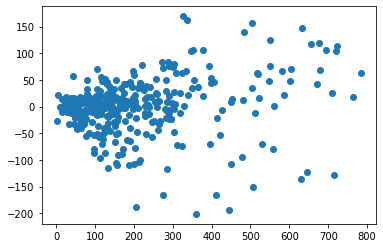

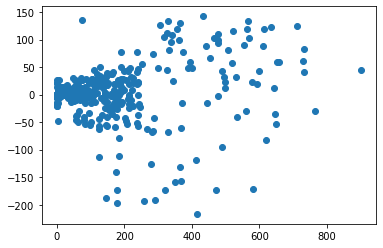

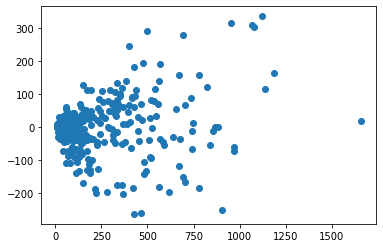

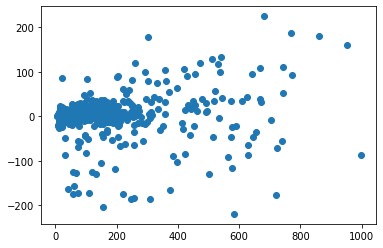

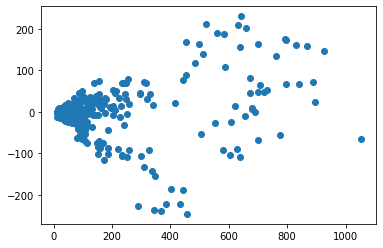

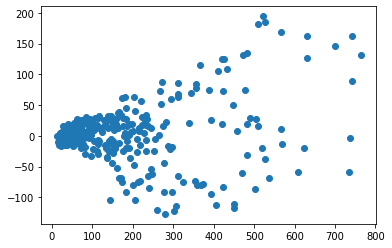

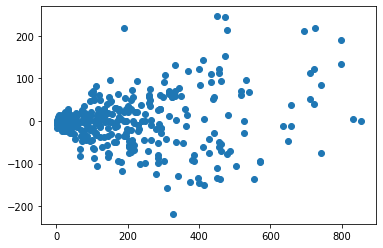

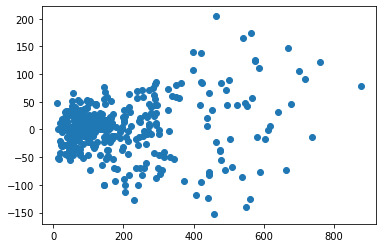

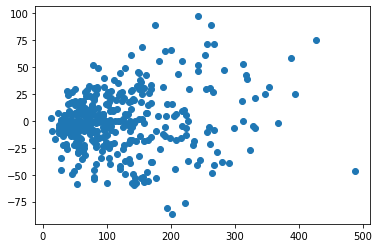

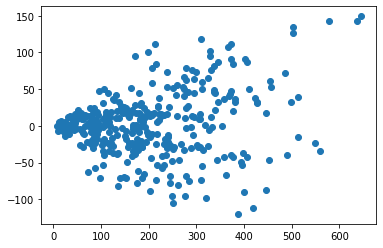

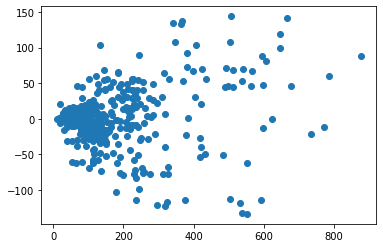

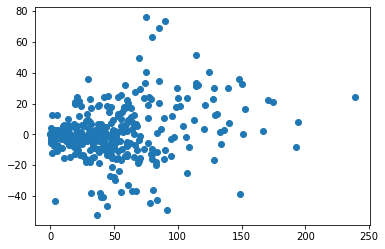

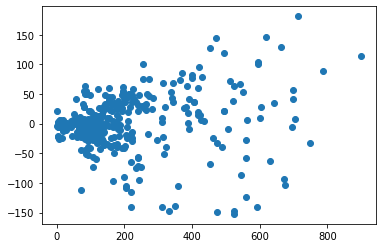

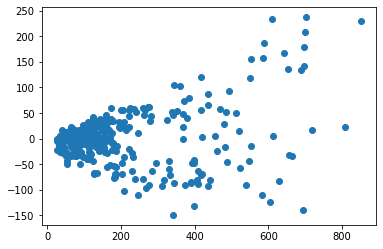

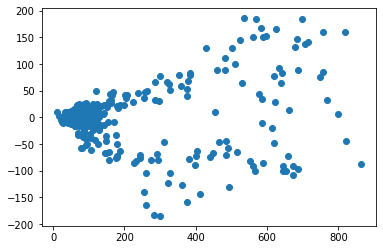

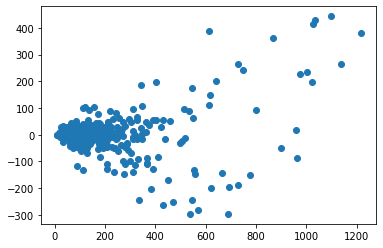

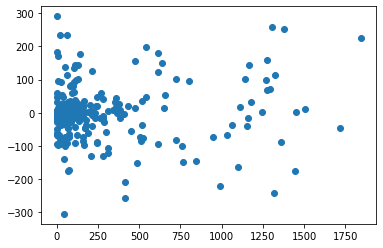

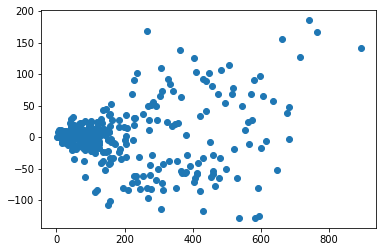

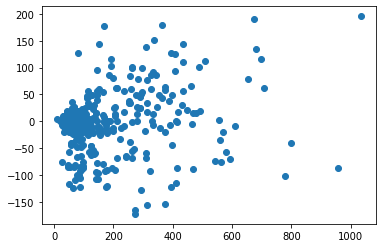

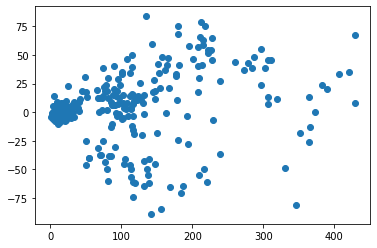

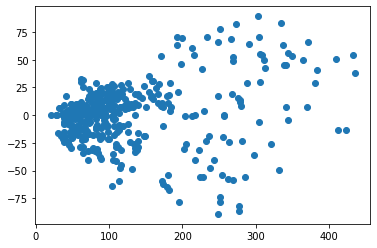

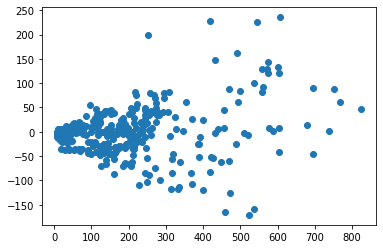

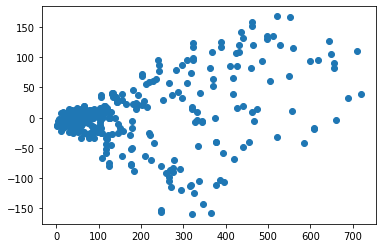

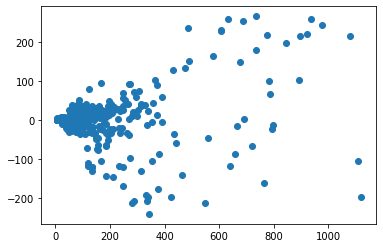

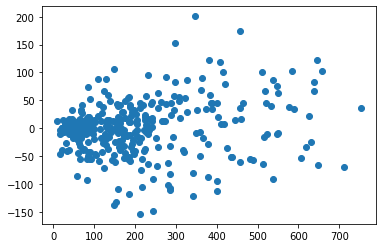

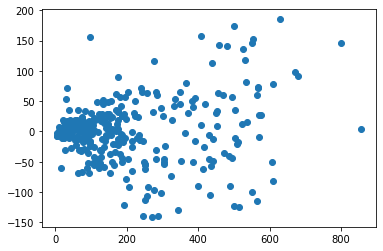

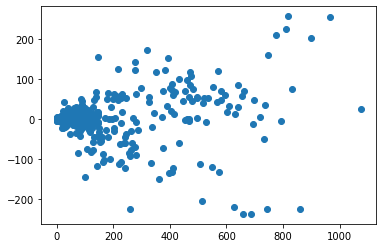

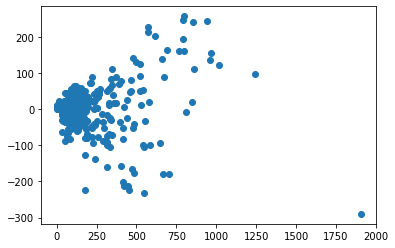

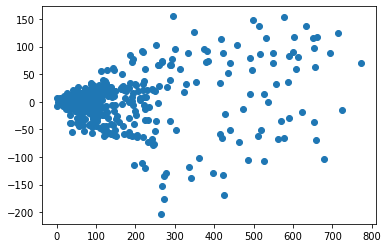

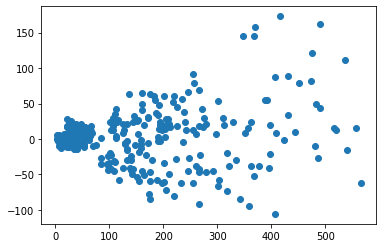

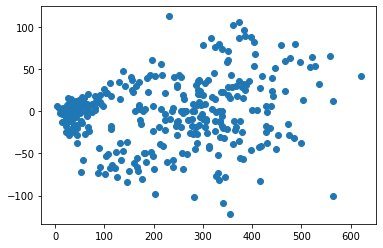

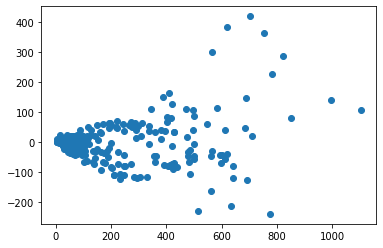

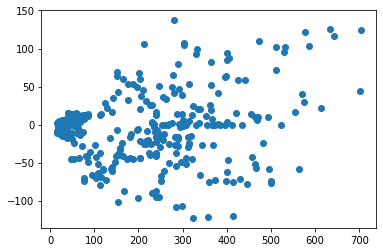

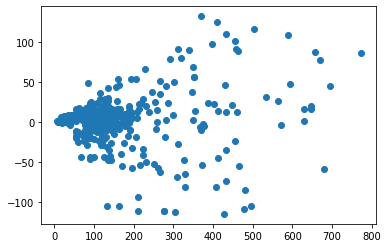

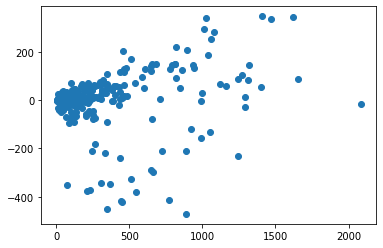

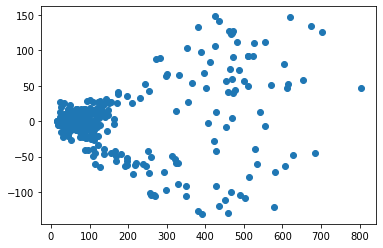

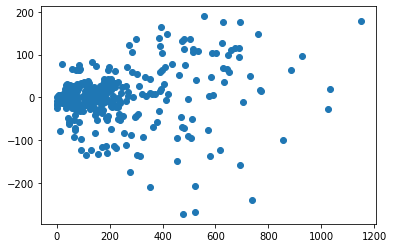

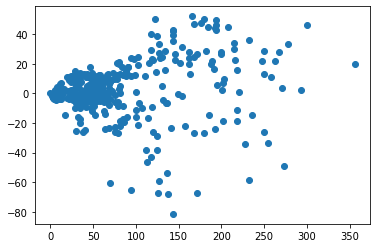

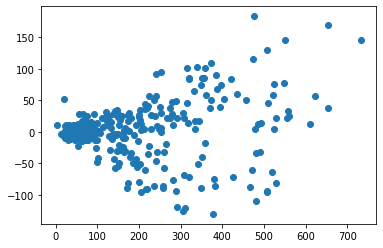

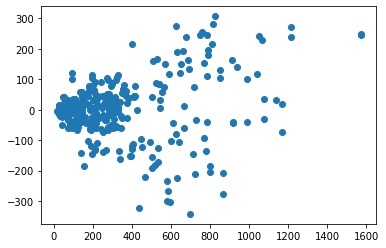

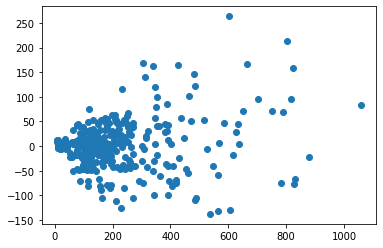

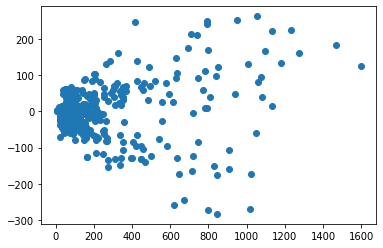

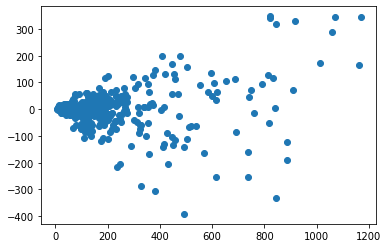

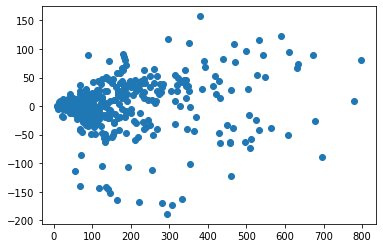

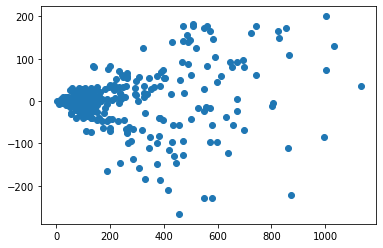

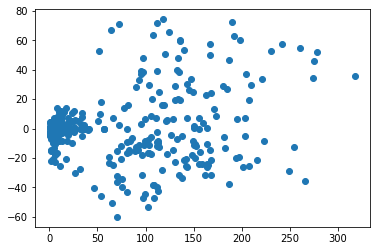

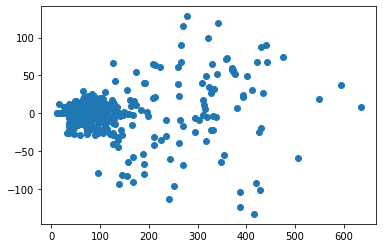

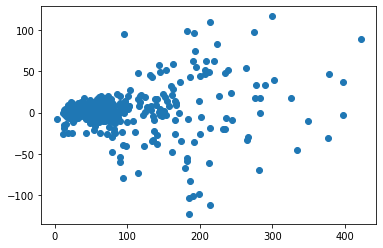

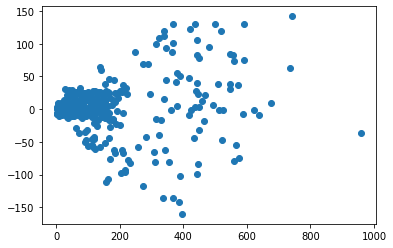

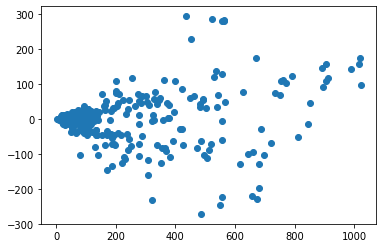

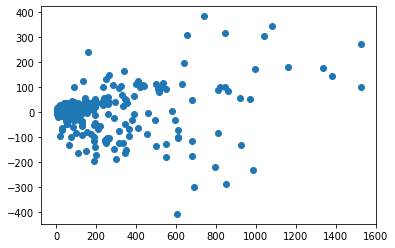

----------------------------------------------------------
Predicting 2020-08-02
Week  0

 Predicting on region  Alabama 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07187455038102517 0.04895854700068081
Prediction model
12698.0
Uncertainty
[0. 1. 0.]
Current Delta
587.0
Weeks Angle Percentage
7 -23.902830507109172 290.23991548350716
Predicted Policy
[0.01257099 0.26120458 0.72622444]
Real cases:  9555.0
Predicted cases:  12698.0
Mixed cases:  12698.0
Sames as last:  12111.0
Weeks in advance 2
Beta, Gamma
0.07053964008631092 0.0448746757510889
Prediction model
14538.0
Uncertainty
[0. 1. 0.]
Current Delta
2427.0
Weeks Angle Percentage
7 -23.902830507109172 290.23991548350716
Predicted Policy
[0.01257099 0.26120458 0.72622444]
Real cases:  7072.0
Predicted cases:  14538.0
Mixed cases:  14538.0
Sames as last:  12111.0
Weeks in advance 3
Beta, Gamma
0.06879275323570531 0.04300775783750991


/home/rvega/Envs/zehra/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


Prediction model
16694.5
Uncertainty
[0.01257099 0.26120458 0.72622444]
Current Delta
1197.231175001507
Weeks Angle Percentage
7 -23.902830507109172 290.23991548350716
Predicted Policy
[0.01257099 0.26120458 0.72622444]
Real cases:  7883.0
Predicted cases:  16694.5
Mixed cases:  13308.231175001507
Sames as last:  12111.0
Weeks in advance 4
Beta, Gamma
0.06723807779848716 0.034324782013073825
Prediction model
16933.5
Uncertainty
[0.01585459 0.06822783 0.91591758]
Current Delta
329.02871319651786
Weeks Angle Percentage
7 -23.902830507109172 290.23991548350716
Predicted Policy
[0.01257099 0.26120458 0.72622444]
Real cases:  9346.0
Predicted cases:  16933.5
Mixed cases:  12440.028713196518
Sames as last:  12111.0

 Predicting on region  Alaska 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08999739618272519 0.038577677425311103
Prediction model
1234.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Perce

Weeks Angle Percentage
5 3.3514298971163115 55.67193911997355
Predicted Policy
[0.06868685 0.9216404  0.00967275]
Real cases:  2157.0
Predicted cases:  5280.0
Mixed cases:  5008.656683112018
Sames as last:  3478.0

 Predicting on region  Connecticut 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.05083275930287464
Prediction model
1421.75
Uncertainty
[0. 1. 0.]
Current Delta
303.75
Weeks Angle Percentage
3 12.87411623861146 16.492360923538556
Predicted Policy
[0.02655247 0.96718962 0.00625791]
Real cases:  592.3333333334886
Predicted cases:  1421.75
Mixed cases:  1421.75
Sames as last:  1118.0
Weeks in advance 2
Beta, Gamma
0.09486133863988747 0.0467039510222558
Prediction model
1863.5
Uncertainty
[0. 1. 0.]
Current Delta
745.5
Weeks Angle Percentage
3 12.87411623861146 16.492360923538556
Predicted Policy
[0.02655247 0.96718962 0.00625791]
Real cases:  700.3333333334886
Predicted cases:  1863.5
Mixed c

Weeks Angle Percentage
1 24.507865117750754 42.51796772589613
Predicted Policy
[0.01350432 0.98090581 0.00558988]
Real cases:  1149.0
Predicted cases:  702.875
Mixed cases:  577.0
Sames as last:  577.0
Weeks in advance 2
Beta, Gamma
0.0636393042201048 0.0346735763534223
Prediction model
613.875
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 24.507865117750754 42.51796772589613
Predicted Policy
[0.01350432 0.98090581 0.00558988]
Real cases:  1479.0
Predicted cases:  613.875
Mixed cases:  577.0
Sames as last:  577.0
Weeks in advance 3
Beta, Gamma
0.05844354573923715 0.018409009775280333
Prediction model
777.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 24.507865117750754 42.51796772589613
Predicted Policy
[0.01350432 0.98090581 0.00558988]
Real cases:  1531.0
Predicted cases:  777.5
Mixed cases:  577.0
Sames as last:  577.0
Weeks in advance 4
Beta, Gamma
0.04298898172059328 0.011845294783103193
Prediction model
695.875
Uncertainty
[0. 0. 1.]
Curre

Weeks Angle Percentage
6 -12.219760726100915 54.78297224398057
Predicted Policy
[0.09007903 0.89926028 0.01066069]
Real cases:  3486.0
Predicted cases:  2674.75
Mixed cases:  2665.4063911396524
Sames as last:  2582.0
Weeks in advance 4
Beta, Gamma
0.05449997246640385 0.03409949090069146
Prediction model
2881.25
Uncertainty
[0.17108352 0.80866905 0.02024742]
Current Delta
241.99421455176616
Weeks Angle Percentage
6 -12.219760726100915 54.78297224398057
Predicted Policy
[0.09007903 0.89926028 0.01066069]
Real cases:  4199.0
Predicted cases:  2881.25
Mixed cases:  2823.994214551766
Sames as last:  2582.0

 Predicting on region  Kentucky 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06660054035205192 0.040086501502761336
Prediction model
4216.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 0.2499344627098452 89.62159943218764
Predicted Policy
[0.0052969  0.98881386 0.00588924]
Real cases:

Prediction model
8369.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 10.24346298339907 53.12982853364177
Predicted Policy
[0.0898926 0.8986532 0.0114542]
Real cases:  5591.0
Predicted cases:  8369.0
Mixed cases:  5710.0
Sames as last:  5710.0
Weeks in advance 3
Beta, Gamma
0.05628108073381992 0.04353089614353602
Prediction model
5547.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 10.24346298339907 53.12982853364177
Predicted Policy
[0.0898926 0.8986532 0.0114542]
Real cases:  4262.0
Predicted cases:  5547.0
Mixed cases:  5710.0
Sames as last:  5710.0
Weeks in advance 4
Beta, Gamma
0.05857835464245645 0.03751256710069842
Prediction model
6236.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 10.24346298339907 53.12982853364177
Predicted Policy
[0.0898926 0.8986532 0.0114542]
Real cases:  5787.0
Predicted cases:  6236.0
Mixed cases:  5710.0
Sames as last:  5710.0

 Predicting on region  Minnesota 

Policy t-1 [0 1 0]
Policy t-2 

Prediction model
7398.5
Uncertainty
[0. 1. 0.]
Current Delta
140.5
Weeks Angle Percentage
7 -12.564298691364968 224.07955960672123
Predicted Policy
[0.01382931 0.27158272 0.71458796]
Real cases:  6345.0
Predicted cases:  7398.5
Mixed cases:  7398.5
Sames as last:  7258.0
Weeks in advance 2
Beta, Gamma
0.06854107793951829 0.043088129865449444
Prediction model
8445.5
Uncertainty
[0. 1. 0.]
Current Delta
1187.5
Weeks Angle Percentage
7 -12.564298691364968 224.07955960672123
Predicted Policy
[0.01382931 0.27158272 0.71458796]
Real cases:  5189.0
Predicted cases:  8445.5
Mixed cases:  8445.5
Sames as last:  7258.0
Weeks in advance 3
Beta, Gamma
0.06698072974862698 0.04121131874448667
Prediction model
9727.25
Uncertainty
[0.01382931 0.27158272 0.71458796]
Current Delta
670.6056436033814
Weeks Angle Percentage
7 -12.564298691364968 224.07955960672123
Predicted Policy
[0.01382931 0.27158272 0.71458796]
Real cases:  4461.0
Predicted cases:  9727.25
Mixed cases:  7928.605643603381
Sames as last:

Uncertainty
[0. 1. 0.]
Current Delta
1320.0
Weeks Angle Percentage
7 -2.517142311217185 93.57285849350558
Predicted Policy
[0.08407222 0.85086349 0.06506429]
Real cases:  9793.0
Predicted cases:  14273.0
Mixed cases:  14273.0
Sames as last:  12953.0
Weeks in advance 3
Beta, Gamma
0.06470914472566543 0.04310291352268853
Prediction model
15922.0
Uncertainty
[0.08407222 0.85086349 0.06506429]
Current Delta
2526.2136959180298
Weeks Angle Percentage
7 -2.517142311217185 93.57285849350558
Predicted Policy
[0.08407222 0.85086349 0.06506429]
Real cases:  10869.0
Predicted cases:  15922.0
Mixed cases:  15479.21369591803
Sames as last:  12953.0
Weeks in advance 4
Beta, Gamma
0.06327043484571096 0.03540080864867195
Prediction model
17832.0
Uncertainty
[0.15560621 0.72396868 0.12042512]
Current Delta
3532.2431664857577
Weeks Angle Percentage
7 -2.517142311217185 93.57285849350558
Predicted Policy
[0.08407222 0.85086349 0.06506429]
Real cases:  11488.0
Predicted cases:  17832.0
Mixed cases:  16485.

Prediction model
6592.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 2.4605551527969567 38.165944370050624
Predicted Policy
[0.01351194 0.98097483 0.00551323]
Real cases:  4411.0
Predicted cases:  6592.0
Mixed cases:  6320.0
Sames as last:  6320.0

 Predicting on region  Rhode Island 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.04545077915358585
Prediction model
1129.375
Uncertainty
[0. 1. 0.]
Current Delta
256.70833333337214
Weeks Angle Percentage
7 40.307317335639134 49.3379184873397
Predicted Policy
[0.08944391 0.89512624 0.01542985]
Real cases:  781.3333333333721
Predicted cases:  1129.375
Mixed cases:  1129.375
Sames as last:  872.6666666666279
Weeks in advance 2
Beta, Gamma
0.09611000255202726 0.041912335585391806
Prediction model
1551.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 40.307317335639134 49.3379184873397
Predicted Policy
[0.08944391 0.8951

Prediction model
2576.0
Uncertainty
[0. 1. 0.]
Current Delta
-503.0
Weeks Angle Percentage
7 -36.05786476304432 110.48179670476033
Predicted Policy
[0.07461884 0.76870669 0.15667447]
Real cases:  3049.0
Predicted cases:  2576.0
Mixed cases:  2576.0
Sames as last:  3079.0
Weeks in advance 2
Beta, Gamma
0.05113859801565881 0.049381031318771466
Prediction model
2551.75
Uncertainty
[0. 1. 0.]
Current Delta
-527.25
Weeks Angle Percentage
7 -36.05786476304432 110.48179670476033
Predicted Policy
[0.07461884 0.76870669 0.15667447]
Real cases:  2570.0
Predicted cases:  2551.75
Mixed cases:  2551.75
Sames as last:  3079.0
Weeks in advance 3
Beta, Gamma
0.050304615163257786 0.04522102356750609
Prediction model
2552.0
Uncertainty
[0.07461884 0.76870669 0.15667447]
Current Delta
-405.10842618756305
Weeks Angle Percentage
7 -36.05786476304432 110.48179670476033
Predicted Policy
[0.07461884 0.76870669 0.15667447]
Real cases:  2493.0
Predicted cases:  2552.0
Mixed cases:  2673.891573812437
Sames as la

Prediction model
8807.5
Uncertainty
[0.02893552 0.77662127 0.19444321]
Current Delta
2077.8502083525327
Weeks Angle Percentage
4 -6.64670479734076 127.67856192101105
Predicted Policy
[0.02893552 0.77662127 0.19444321]
Real cases:  4953.0
Predicted cases:  8807.5
Mixed cases:  8209.850208352533
Sames as last:  6132.0
Weeks in advance 4
Beta, Gamma
0.06580572974535678 0.032134667835987056
Prediction model
10182.5
Uncertainty
[0.05140745 0.6031406  0.34545195]
Current Delta
2443.0209893143765
Weeks Angle Percentage
4 -6.64670479734076 127.67856192101105
Predicted Policy
[0.02893552 0.77662127 0.19444321]
Real cases:  4791.0
Predicted cases:  10182.5
Mixed cases:  8575.020989314376
Sames as last:  6132.0

 Predicting on region  Wyoming 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06874575481202232 0.04724261007945746
Prediction model
337.375
Uncertainty
[0. 1. 0.]
Current Delta
14.375
Weeks Angle Percentage

Weeks Angle Percentage
7 -36.128060929398984 130.8152163445727
Predicted Policy
[0.06146137 0.66419871 0.27433992]
Real cases:  45413.0
Predicted cases:  41956.0
Mixed cases:  41956.0
Sames as last:  47858.0
Weeks in advance 3
Beta, Gamma
0.054835923602858126 0.048174258455704555
Prediction model
42140.0
Uncertainty
[0.06146137 0.66419871 0.27433992]
Current Delta
-3797.888202760747
Weeks Angle Percentage
7 -36.128060929398984 130.8152163445727
Predicted Policy
[0.06146137 0.66419871 0.27433992]
Real cases:  36467.0
Predicted cases:  42140.0
Mixed cases:  44060.11179723925
Sames as last:  47858.0
Weeks in advance 4
Beta, Gamma
0.053375349294403795 0.04007291776788522
Prediction model
40812.0
Uncertainty
[0.10228394 0.44115992 0.45655614]
Current Delta
-3108.4128067657
Weeks Angle Percentage
7 -36.128060929398984 130.8152163445727
Predicted Policy
[0.06146137 0.66419871 0.27433992]
Real cases:  33321.0
Predicted cases:  40812.0
Mixed cases:  44749.5871932343
Sames as last:  47858.0

 Pr

Weeks Angle Percentage
7 -94.91223400305154 277.09623225202915
Predicted Policy
[0.01087573 0.24715709 0.74196718]
Real cases:  21406.0
Predicted cases:  33194.0
Mixed cases:  43248.21700437154
Sames as last:  46549.0
Weeks in advance 4
Beta, Gamma
0.047557613753194644 0.04160910096487375
Prediction model
25316.0
Uncertainty
[0.01356374 0.06108663 0.92534963]
Current Delta
-1297.0524001213707
Weeks Angle Percentage
7 -94.91223400305154 277.09623225202915
Predicted Policy
[0.01087573 0.24715709 0.74196718]
Real cases:  23030.66808460653
Predicted cases:  25316.0
Mixed cases:  45251.94759987863
Sames as last:  46549.0

 Predicting on region  Georgia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06749973274284789 0.052706740599557524
Prediction model
23240.0
Uncertainty
[0. 1. 0.]
Current Delta
-175.0
Weeks Angle Percentage
7 -21.474137368361426 291.6055995885254
Predicted Policy
[0.01257335 0.26122409 0.72

Prediction model
3376.0
Uncertainty
[0. 1. 0.]
Current Delta
134.0
Weeks Angle Percentage
7 -1.0142405715245957 109.823236885394
Predicted Policy
[0.06954809 0.73110378 0.19934813]
Real cases:  3931.0
Predicted cases:  3376.0
Mixed cases:  3376.0
Sames as last:  3242.0
Weeks in advance 3
Beta, Gamma
0.06422240078645328 0.047088357771190095
Prediction model
3619.25
Uncertainty
[0.06954809 0.73110378 0.19934813]
Current Delta
275.80890122404435
Weeks Angle Percentage
7 -1.0142405715245957 109.823236885394
Predicted Policy
[0.06954809 0.73110378 0.19934813]
Real cases:  6693.31189960707
Predicted cases:  3619.25
Mixed cases:  3517.8089012240443
Sames as last:  3242.0
Weeks in advance 4
Beta, Gamma
0.06257551118226097 0.039562340461435766
Prediction model
3852.0
Uncertainty
[0.12039497 0.53451274 0.34509229]
Current Delta
326.05277016736954
Weeks Angle Percentage
7 -1.0142405715245957 109.823236885394
Predicted Policy
[0.06954809 0.73110378 0.19934813]
Real cases:  6078.0
Predicted cases: 

Prediction model
6362.5
Uncertainty
[0.09000464 0.87556449 0.03443087]
Current Delta
1003.834688358842
Weeks Angle Percentage
4 -17.889155164064846 89.73349565309444
Predicted Policy
[0.04649682 0.93571603 0.01778715]
Real cases:  4313.0
Predicted cases:  6362.5
Mixed cases:  6219.834688358842
Sames as last:  5216.0

 Predicting on region  Massachusetts 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07104060171328327 0.04917170853038707
Prediction model
2170.0
Uncertainty
[0. 1. 0.]
Current Delta
108.0
Weeks Angle Percentage
3 -1.3638006396225038 18.483851222117714
Predicted Policy
[0.0279014  0.96581375 0.00628486]
Real cases:  2008.0
Predicted cases:  2170.0
Mixed cases:  2170.0
Sames as last:  2062.0
Weeks in advance 2
Beta, Gamma
0.06975866287564014 0.044402430718143995
Prediction model
2485.0
Uncertainty
[0. 1. 0.]
Current Delta
423.0
Weeks Angle Percentage
3 -1.3638006396225038 18.483851222117714
Pr

Prediction model
923.5
Uncertainty
[0. 1. 0.]
Current Delta
115.5
Weeks Angle Percentage
7 -12.631248023443604 86.4538753604584
Predicted Policy
[0.08809037 0.88394978 0.02795985]
Real cases:  717.0
Predicted cases:  923.5
Mixed cases:  923.5
Sames as last:  808.0
Weeks in advance 3
Beta, Gamma
0.065623583754477 0.042548911441315763
Prediction model
1035.5
Uncertainty
[0.08809037 0.88394978 0.02795985]
Current Delta
201.0985751639862
Weeks Angle Percentage
7 -12.631248023443604 86.4538753604584
Predicted Policy
[0.08809037 0.88394978 0.02795985]
Real cases:  875.0
Predicted cases:  1035.5
Mixed cases:  1009.0985751639862
Sames as last:  808.0
Weeks in advance 4
Beta, Gamma
0.06390484857617751 0.035644838097607795
Prediction model
1177.625
Uncertainty
[0.16595784 0.78136722 0.05267495]
Current Delta
288.81285692751544
Weeks Angle Percentage
7 -12.631248023443604 86.4538753604584
Predicted Policy
[0.08809037 0.88394978 0.02795985]
Real cases:  913.0
Predicted cases:  1177.625
Mixed cases

Prediction model
994.875
Uncertainty
[0.17945185 0.80968233 0.01086582]
Current Delta
-262.4382861074996
Weeks Angle Percentage
7 -36.24520645221905 50.075614177407886
Predicted Policy
[0.17945185 0.80968233 0.01086582]
Real cases:  876.0
Predicted cases:  994.875
Mixed cases:  1056.5617138925004
Sames as last:  1319.0
Weeks in advance 4
Beta, Gamma
0.04501768254065502 0.037805262422835426
Prediction model
942.0
Uncertainty
[0.32475085 0.65558548 0.01966367]
Current Delta
-247.15572595698086
Weeks Angle Percentage
7 -36.24520645221905 50.075614177407886
Predicted Policy
[0.17945185 0.80968233 0.01086582]
Real cases:  870.0
Predicted cases:  942.0
Mixed cases:  1071.8442740430191
Sames as last:  1319.0

 Predicting on region  New York 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06344977580980356 0.05396765042277398
Prediction model
4114.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1

Uncertainty
[0.04629475 0.56787444 0.38583081]
Current Delta
200.74361605997547
Weeks Angle Percentage
4 -40.51078463804765 145.94496649078297
Predicted Policy
[0.02640022 0.75357445 0.22002534]
Real cases:  5834.0
Predicted cases:  5702.5
Mixed cases:  5549.7436160599755
Sames as last:  5349.0

 Predicting on region  Oregon 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06715195044535119 0.052368631628018185
Prediction model
2207.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -5.808802208388059 62.237166518443416
Predicted Policy
[0.01773968 0.9762246  0.00603573]
Real cases:  2008.0
Predicted cases:  2207.0
Mixed cases:  2193.0
Sames as last:  2193.0
Weeks in advance 2
Beta, Gamma
0.0683144868432269 0.055583839364898656
Prediction model
2156.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -5.808802208388059 62.237166518443416
Predicted Policy
[0.01773968 0.976224

Prediction model
11898.5
Uncertainty
[0.01720485 0.29922954 0.68356561]
Current Delta
-150.36284295027326
Weeks Angle Percentage
7 -59.421534727333096 184.81005169878523
Predicted Policy
[0.01720485 0.29922954 0.68356561]
Real cases:  10197.0
Predicted cases:  11898.5
Mixed cases:  12250.637157049727
Sames as last:  12401.0
Weeks in advance 4
Beta, Gamma
0.051575437987394765 0.03515080358688767
Prediction model
11457.0
Uncertainty
[0.02235305 0.08953832 0.88810863]
Current Delta
-84.52417081099338
Weeks Angle Percentage
7 -59.421534727333096 184.81005169878523
Predicted Policy
[0.01720485 0.29922954 0.68356561]
Real cases:  10082.0
Predicted cases:  11457.0
Mixed cases:  12316.475829189007
Sames as last:  12401.0

 Predicting on region  Texas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06931934565163486 0.056349804412509724
Prediction model
55168.0
Uncertainty
[0. 1. 0.]
Current Delta
-606.0
Weeks Angl

Weeks Angle Percentage
2 -2.9573466908685546 43.3558184680163
Predicted Policy
[0.01776406 0.97645686 0.00577909]
Real cases:  899.0
Predicted cases:  739.625
Mixed cases:  825.0
Sames as last:  825.0
Weeks in advance 2
Beta, Gamma
0.06663441964638245 0.05110756727436407
Prediction model
841.625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -2.9573466908685546 43.3558184680163
Predicted Policy
[0.01776406 0.97645686 0.00577909]
Real cases:  723.0
Predicted cases:  841.625
Mixed cases:  825.0
Sames as last:  825.0
Weeks in advance 3
Beta, Gamma
0.06665366111441916 0.053577301870450386
Prediction model
808.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -2.9573466908685546 43.3558184680163
Predicted Policy
[0.01776406 0.97645686 0.00577909]
Real cases:  785.0
Predicted cases:  808.125
Mixed cases:  825.0
Sames as last:  825.0
Weeks in advance 4
Beta, Gamma
0.06903459141887594 0.05549727766009879
Prediction model
809.625
Uncertainty
[0. 0. 1.]
Cur

Prediction model
3748.5
Uncertainty
[0. 1. 0.]
Current Delta
-482.0
Weeks Angle Percentage
7 -38.93559687772961 150.65590740816833
Predicted Policy
[0.04118173 0.49712442 0.46169386]
Real cases:  4207.0
Predicted cases:  3748.5
Mixed cases:  3748.5
Sames as last:  4230.5
Weeks in advance 2
Beta, Gamma
0.05510001691120392 0.051611138794914684
Prediction model
3766.5
Uncertainty
[0. 1. 0.]
Current Delta
-464.0
Weeks Angle Percentage
7 -38.93559687772961 150.65590740816833
Predicted Policy
[0.04118173 0.49712442 0.46169386]
Real cases:  4179.0
Predicted cases:  3766.5
Mixed cases:  3766.5
Sames as last:  4230.5
Weeks in advance 3
Beta, Gamma
0.05422521390298979 0.046251050270820486
Prediction model
3815.75
Uncertainty
[0.04118173 0.49712442 0.46169386]
Current Delta
-206.1823514539219
Weeks Angle Percentage
7 -38.93559687772961 150.65590740816833
Predicted Policy
[0.04118173 0.49712442 0.46169386]
Real cases:  4312.0
Predicted cases:  3815.75
Mixed cases:  4024.317648546078
Sames as last:

Prediction model
590.8125
Uncertainty
[0. 1. 0.]
Current Delta
84.8125
Weeks Angle Percentage
7 9.351766704593274 40.66601582148895
Predicted Policy
[0.09005822 0.89968741 0.01025437]
Real cases:  391.0
Predicted cases:  590.8125
Mixed cases:  590.8125
Sames as last:  506.0
Weeks in advance 3
Beta, Gamma
0.07163276344858727 0.046882720602143775
Prediction model
663.8125
Uncertainty
[0.09005822 0.89968741 0.01025437]
Current Delta
141.98191987554742
Weeks Angle Percentage
7 9.351766704593274 40.66601582148895
Predicted Policy
[0.09005822 0.89968741 0.01025437]
Real cases:  313.0
Predicted cases:  663.8125
Mixed cases:  647.9819198755474
Sames as last:  506.0
Weeks in advance 4
Beta, Gamma
0.07000338570320341 0.04009360693365382
Prediction model
762.6875
Uncertainty
[0.17108247 0.80943744 0.01948009]
Current Delta
207.77247319869855
Weeks Angle Percentage
7 9.351766704593274 40.66601582148895
Predicted Policy
[0.09005822 0.89968741 0.01025437]
Real cases:  304.5
Predicted cases:  762.687

Prediction model
16519.0
Uncertainty
[0.07616691 0.78568712 0.13814596]
Current Delta
3666.016122071409
Weeks Angle Percentage
6 4.119376370610027 100.97996175924519
Predicted Policy
[0.07616691 0.78568712 0.13814596]
Real cases:  14548.150014923885
Predicted cases:  16519.0
Mixed cases:  15519.016122071409
Sames as last:  11853.0
Weeks in advance 4
Beta, Gamma
0.06697564646765332 0.03585692331388174
Prediction model
18904.0
Uncertainty
[0.13601027 0.61730426 0.24668547]
Current Delta
4352.612318365485
Weeks Angle Percentage
6 4.119376370610027 100.97996175924519
Predicted Policy
[0.07616691 0.78568712 0.13814596]
Real cases:  11897.0
Predicted cases:  18904.0
Mixed cases:  16205.612318365485
Sames as last:  11853.0

 Predicting on region  Indiana 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07355831360539153 0.05179597084667851
Prediction model
6806.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angl

0.07945266674063388 0.0626755375301442
Prediction model
120.625
Uncertainty
[0. 1. 0.]
Current Delta
4.625
Weeks Angle Percentage
7 -0.2975721091613517 14.581033348906274
Predicted Policy
[0.10778121 0.88221369 0.0100051 ]
Real cases:  174.0
Predicted cases:  120.625
Mixed cases:  120.625
Sames as last:  116.0
Weeks in advance 2
Beta, Gamma
0.07551288157460562 0.06318920509761213
Prediction model
126.875
Uncertainty
[0. 1. 0.]
Current Delta
10.875
Weeks Angle Percentage
7 -0.2975721091613517 14.581033348906274
Predicted Policy
[0.10778121 0.88221369 0.0100051 ]
Real cases:  174.0
Predicted cases:  126.875
Mixed cases:  126.875
Sames as last:  116.0
Weeks in advance 3
Beta, Gamma
0.07286858217602651 0.058123857543138806
Prediction model
134.125
Uncertainty
[0.10778121 0.88221369 0.0100051 ]
Current Delta
15.990123099333431
Weeks Angle Percentage
7 -0.2975721091613517 14.581033348906274
Predicted Policy
[0.10778121 0.88221369 0.0100051 ]
Real cases:  166.0
Predicted cases:  134.125
Mixed

Prediction model
3897.75
Uncertainty
[0. 1. 0.]
Current Delta
-1211.25
Weeks Angle Percentage
4 -40.152559566070124 194.04270417912545
Predicted Policy
[0.01376873 0.63915791 0.34707336]
Real cases:  4761.0
Predicted cases:  3897.75
Mixed cases:  3897.75
Sames as last:  5109.0
Weeks in advance 3
Beta, Gamma
0.05034672419188079 0.05369954564752358
Prediction model
3625.25
Uncertainty
[0.01376873 0.63915791 0.34707336]
Current Delta
-948.3505427862492
Weeks Angle Percentage
4 -40.152559566070124 194.04270417912545
Predicted Policy
[0.01376873 0.63915791 0.34707336]
Real cases:  4449.0
Predicted cases:  3625.25
Mixed cases:  4160.649457213751
Sames as last:  5109.0
Weeks in advance 4
Beta, Gamma
0.049104749042468726 0.04406496730025068
Prediction model
3083.5
Uncertainty
[0.02256913 0.40852283 0.56890804]
Current Delta
-827.4629893180718
Weeks Angle Percentage
4 -40.152559566070124 194.04270417912545
Predicted Policy
[0.01376873 0.63915791 0.34707336]
Real cases:  3142.0
Predicted cases: 

Weeks Angle Percentage
7 -0.8089954409429634 8.2370444896011
Predicted Policy
[0.41738435 0.57261316 0.01000249]
Real cases:  178.0
Predicted cases:  150.25
Mixed cases:  155.27179535933467
Sames as last:  162.0
Weeks in advance 4
Beta, Gamma
0.054007926270573464 0.04038516998686439
Prediction model
147.5
Uncertainty
[0.65638412 0.32788583 0.01573005]
Current Delta
-4.754344564648079
Weeks Angle Percentage
7 -0.8089954409429634 8.2370444896011
Predicted Policy
[0.41738435 0.57261316 0.01000249]
Real cases:  228.0
Predicted cases:  147.5
Mixed cases:  157.24565543535192
Sames as last:  162.0

 Predicting on region  New Jersey 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08244546940722765 0.05218600307515231
Prediction model
3686.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 7.271774449310637 24.90376810223605
Predicted Policy
[0.00500858 0.98998819 0.00500323]
Real cases:  2178.0
Pr

Weeks Angle Percentage
7 3.131122156539007 66.89137743709952
Predicted Policy
[0.08952083 0.8957246  0.01475457]
Real cases:  6491.0
Predicted cases:  7460.0
Mixed cases:  7460.0
Sames as last:  7705.0
Weeks in advance 2
Beta, Gamma
0.0653847375641307 0.0552658572679474
Prediction model
7677.0
Uncertainty
[0. 1. 0.]
Current Delta
-28.0
Weeks Angle Percentage
7 3.131122156539007 66.89137743709952
Predicted Policy
[0.08952083 0.8957246  0.01475457]
Real cases:  7155.0
Predicted cases:  7677.0
Mixed cases:  7677.0
Sames as last:  7705.0
Weeks in advance 3
Beta, Gamma
0.06369916610142061 0.050156897687889584
Prediction model
8066.0
Uncertainty
[0.08952083 0.8957246  0.01475457]
Current Delta
323.3565808974254
Weeks Angle Percentage
7 3.131122156539007 66.89137743709952
Predicted Policy
[0.08952083 0.8957246  0.01475457]
Real cases:  8465.0
Predicted cases:  8066.0
Mixed cases:  8028.356580897425
Sames as last:  7705.0
Weeks in advance 4
Beta, Gamma
0.062231521546346945 0.04280929361260087


Weeks Angle Percentage
0 -50.12902250931009 141.5304870303536
Predicted Policy
[0.00874454 0.97505443 0.01620103]
Real cases:  7040.0
Predicted cases:  4690.0
Mixed cases:  6422.0
Sames as last:  6422.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
4353.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -50.12902250931009 141.5304870303536
Predicted Policy
[0.00874454 0.97505443 0.01620103]
Real cases:  5588.492767476477
Predicted cases:  4353.0
Mixed cases:  6422.0
Sames as last:  6422.0

 Predicting on region  South Dakota 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07446112771708349 0.04901674600445995
Prediction model
693.9375
Uncertainty
[0. 1. 0.]
Current Delta
52.9375
Weeks Angle Percentage
7 5.199743630031449 74.37894149045
Predicted Policy
[0.08869585 0.88895955 0.0223446 ]
Real cases:  1017.0
Predicted cases:  693.9375
Mixed cases:  693.9375
Sames as last:  641.0
We

Weeks Angle Percentage
7 3.044925471442606 8.974517178988734
Predicted Policy
[0.1449775  0.84501989 0.01000261]
Real cases:  30.0
Predicted cases:  128.9375
Mixed cases:  107.79570854695383
Sames as last:  55.0

 Predicting on region  Virginia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06133866562566233 0.05384950324849591
Prediction model
6276.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -6.947234427796005 74.79334297070865
Predicted Policy
[0.01347149 0.98021212 0.00631639]
Real cases:  6322.0
Predicted cases:  6276.0
Mixed cases:  6561.0
Sames as last:  6561.0
Weeks in advance 2
Beta, Gamma
0.0654379237453449 0.05498511547681354
Prediction model
6487.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -6.947234427796005 74.79334297070865
Predicted Policy
[0.01347149 0.98021212 0.00631639]
Real cases:  6737.0
Predicted cases:  6487.0
Mixed cases:  6561.0
Sames

Prediction model
7670.5
Uncertainty
[0.08131306 0.82807343 0.09061351]
Current Delta
-175.96560378306094
Weeks Angle Percentage
7 18.661339517068996 85.23031458123648
Predicted Policy
[0.08131306 0.82807343 0.09061351]
Real cases:  6252.0
Predicted cases:  7670.5
Mixed cases:  7707.034396216939
Sames as last:  7883.0
Weeks in advance 4
Beta, Gamma
0.06562113161116893 0.04816179843877573
Prediction model
7924.5
Uncertainty
[0.14864624 0.6857056  0.16564816]
Current Delta
28.456782597349047
Weeks Angle Percentage
7 18.661339517068996 85.23031458123648
Predicted Policy
[0.08131306 0.82807343 0.09061351]
Real cases:  6412.0
Predicted cases:  7924.5
Mixed cases:  7911.456782597349
Sames as last:  7883.0

 Predicting on region  Alaska 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06938733386619685 0.06402348982793621
Prediction model
553.875
Uncertainty
[0. 1. 0.]
Current Delta
6.875
Weeks Angle Percentage
3 -

Weeks Angle Percentage
7 -10.879123474317971 39.68752865212088
Predicted Policy
[0.09135949 0.89848124 0.01015927]
Real cases:  3460.0
Predicted cases:  1397.5
Mixed cases:  1522.2936225584153
Sames as last:  2045.0

 Predicting on region  Connecticut 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09588009160047001 0.0556645340641936
Prediction model
1278.25
Uncertainty
[0. 1. 0.]
Current Delta
265.75
Weeks Angle Percentage
6 8.765072769737753 32.199371326908604
Predicted Policy
[0.09015465 0.89977592 0.01006943]
Real cases:  1104.0
Predicted cases:  1278.25
Mixed cases:  1278.25
Sames as last:  1012.5
Weeks in advance 2
Beta, Gamma
0.09047444767503567 0.0573726909411926
Prediction model
1541.0
Uncertainty
[0. 1. 0.]
Current Delta
528.5
Weeks Angle Percentage
6 8.765072769737753 32.199371326908604
Predicted Policy
[0.09015465 0.89977592 0.01006943]
Real cases:  974.25
Predicted cases:  1541.0
Mixed cases:

Weeks Angle Percentage
4 7.133413189892877 140.4081724901686
Predicted Policy
[0.01944606 0.69061637 0.28993757]
Real cases:  1783.0
Predicted cases:  1808.0
Mixed cases:  1808.0
Sames as last:  1531.0
Weeks in advance 2
Beta, Gamma
0.07702399721293474 0.0356828114145162
Prediction model
2406.625
Uncertainty
[0. 1. 0.]
Current Delta
875.625
Weeks Angle Percentage
4 7.133413189892877 140.4081724901686
Predicted Policy
[0.01944606 0.69061637 0.28993757]
Real cases:  1554.0
Predicted cases:  2406.625
Mixed cases:  2406.625
Sames as last:  1531.0
Weeks in advance 3
Beta, Gamma
0.07552141347129347 0.03456644787273379
Prediction model
3112.0
Uncertainty
[0.01944606 0.69061637 0.28993757]
Current Delta
1091.864476929586
Weeks Angle Percentage
4 7.133413189892877 140.4081724901686
Predicted Policy
[0.01944606 0.69061637 0.28993757]
Real cases:  1029.0
Predicted cases:  3112.0
Mixed cases:  2622.864476929586
Sames as last:  1531.0
Weeks in advance 4
Beta, Gamma
0.07351347171690159 0.02802684088

Prediction model
4872.25
Uncertainty
[0.03000627 0.40497607 0.56501766]
Current Delta
561.3980773745111
Weeks Angle Percentage
7 33.84461819083012 117.01450650359008
Predicted Policy
[0.03000627 0.40497607 0.56501766]
Real cases:  2997.0
Predicted cases:  4872.25
Mixed cases:  4047.398077374511
Sames as last:  3486.0
Weeks in advance 4
Beta, Gamma
0.07028936464515449 0.04020787769668976
Prediction model
5370.25
Uncertainty
[0.0421581  0.16400562 0.79383629]
Current Delta
309.0275847170042
Weeks Angle Percentage
7 33.84461819083012 117.01450650359008
Predicted Policy
[0.03000627 0.40497607 0.56501766]
Real cases:  3807.0
Predicted cases:  5370.25
Mixed cases:  3795.027584717004
Sames as last:  3486.0

 Predicting on region  Kentucky 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06979392220831171 0.057599114371548285
Prediction model
4220.5
Uncertainty
[0. 1. 0.]
Current Delta
84.5
Weeks Angle Percentage
3

Uncertainty
[0.13916154 0.84402469 0.01681377]
Current Delta
668.8895680333408
Weeks Angle Percentage
5 0.9575621512243053 16.757337646425402
Predicted Policy
[0.07252877 0.91870816 0.00876307]
Real cases:  2641.0
Predicted cases:  2861.5
Mixed cases:  2737.8895680333408
Sames as last:  2069.0

 Predicting on region  Michigan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05499084423146866 0.05504835765860945
Prediction model
3755.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -6.478514711885829 49.975683040219764
Predicted Policy
[0.01350799 0.98094823 0.00554378]
Real cases:  5787.0
Predicted cases:  3755.0
Mixed cases:  4262.0
Sames as last:  4262.0
Weeks in advance 2
Beta, Gamma
0.06388169867688524 0.058094918460761674
Prediction model
4165.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -6.478514711885829 49.975683040219764
Predicted Policy
[0.01350799 0.98094

Prediction model
1376.0
Uncertainty
[0. 1. 0.]
Current Delta
-163.0
Weeks Angle Percentage
5 -12.717068994751912 55.72764380627045
Predicted Policy
[0.06880788 0.92188216 0.00930996]
Real cases:  2052.0
Predicted cases:  1376.0
Mixed cases:  1376.0
Sames as last:  1539.0
Weeks in advance 3
Beta, Gamma
0.05576296889346884 0.04890319549363425
Prediction model
1384.25
Uncertainty
[0.06880788 0.92188216 0.00930996]
Current Delta
-142.66126436636455
Weeks Angle Percentage
5 -12.717068994751912 55.72764380627045
Predicted Policy
[0.06880788 0.92188216 0.00930996]
Real cases:  2315.0
Predicted cases:  1384.25
Mixed cases:  1396.3387356336355
Sames as last:  1539.0
Weeks in advance 4
Beta, Gamma
0.05439432597341328 0.04242201558222748
Prediction model
1413.125
Uncertainty
[0.13224063 0.84986672 0.01789265]
Current Delta
-106.97697315261257
Weeks Angle Percentage
5 -12.717068994751912 55.72764380627045
Predicted Policy
[0.06880788 0.92188216 0.00930996]
Real cases:  2677.0
Predicted cases:  141

Weeks Angle Percentage
3 0.6117131973935273 24.576477283516372
Predicted Policy
[0.02643187 0.96731075 0.00625739]
Real cases:  5016.0
Predicted cases:  4920.0
Mixed cases:  4897.80399594391
Sames as last:  4241.0
Weeks in advance 4
Beta, Gamma
0.06440647703513629 0.041806496898834616
Prediction model
5450.0
Uncertainty
[0.05199969 0.93569008 0.01231023]
Current Delta
1131.2493038737457
Weeks Angle Percentage
3 0.6117131973935273 24.576477283516372
Predicted Policy
[0.02643187 0.96731075 0.00625739]
Real cases:  5627.0
Predicted cases:  5450.0
Mixed cases:  5372.249303873746
Sames as last:  4241.0

 Predicting on region  North Carolina 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07686819346216871 0.06245271361367705
Prediction model
11390.0
Uncertainty
[0. 1. 0.]
Current Delta
521.0
Weeks Angle Percentage
7 8.333266590923571 101.3817204362589
Predicted Policy
[0.07346609 0.76341665 0.16311726]
Real cas

Weeks Angle Percentage
4 -4.030597450718226 47.96410966354706
Predicted Policy
[0.04752302 0.94482187 0.0076551 ]
Real cases:  1443.0
Predicted cases:  1466.75
Mixed cases:  1490.9219439021247
Sames as last:  1692.0

 Predicting on region  Pennsylvania 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.057434955825103474 0.05908381588467848
Prediction model
4156.0
Uncertainty
[0. 1. 0.]
Current Delta
-463.0
Weeks Angle Percentage
4 -7.975323209541891 41.66540058736186
Predicted Policy
[0.04762802 0.94479954 0.00757244]
Real cases:  4411.0
Predicted cases:  4156.0
Mixed cases:  4156.0
Sames as last:  4619.0
Weeks in advance 2
Beta, Gamma
0.05686413731614879 0.05537511413213733
Prediction model
4086.0
Uncertainty
[0. 1. 0.]
Current Delta
-533.0
Weeks Angle Percentage
4 -7.975323209541891 41.66540058736186
Predicted Policy
[0.04762802 0.94479954 0.00757244]
Real cases:  5787.0
Predicted cases:  4086.0
Mixed case

Weeks Angle Percentage
6 -17.592153864888587 91.2301992134676
Predicted Policy
[0.0875067  0.87911108 0.03338222]
Real cases:  29319.0
Predicted cases:  34060.0
Mixed cases:  34060.0
Sames as last:  41304.0
Weeks in advance 3
Beta, Gamma
0.05505201748446096 0.05147970771153239
Prediction model
33416.0
Uncertainty
[0.0875067  0.87911108 0.03338222]
Current Delta
-6934.428186156161
Weeks Angle Percentage
6 -17.592153864888587 91.2301992134676
Predicted Policy
[0.0875067  0.87911108 0.03338222]
Real cases:  22397.0
Predicted cases:  33416.0
Mixed cases:  34369.57181384384
Sames as last:  41304.0
Weeks in advance 4
Beta, Gamma
0.05370845698572452 0.04443705246439477
Prediction model
32932.0
Uncertainty
[0.16443481 0.77283629 0.0627289 ]
Current Delta
-6470.185404031639
Weeks Angle Percentage
6 -17.592153864888587 91.2301992134676
Predicted Policy
[0.0875067  0.87911108 0.03338222]
Real cases:  30243.0
Predicted cases:  32932.0
Mixed cases:  34833.81459596836
Sames as last:  41304.0

 Predi

Prediction model
682.5
Uncertainty
[0.09245826 0.89280158 0.01474017]
Current Delta
-36.158463902128574
Weeks Angle Percentage
4 -1.3949748541832818 42.184039590502344
Predicted Policy
[0.04753927 0.94488178 0.00757895]
Real cases:  1361.0
Predicted cases:  682.5
Mixed cases:  686.8415360978714
Sames as last:  723.0

 Predicting on region  Wisconsin 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06611254643132523 0.06082681576293983
Prediction model
4670.0
Uncertainty
[0. 1. 0.]
Current Delta
-283.0
Weeks Angle Percentage
7 -10.768692268559846 114.21340284836204
Predicted Policy
[0.07026851 0.73703898 0.19269251]
Real cases:  4791.0
Predicted cases:  4670.0
Mixed cases:  4670.0
Sames as last:  4953.0
Weeks in advance 2
Beta, Gamma
0.06422448655809262 0.05698474464084997
Prediction model
4704.0
Uncertainty
[0. 1. 0.]
Current Delta
-249.0
Weeks Angle Percentage
7 -10.768692268559846 114.21340284836204
Predi

Weeks Angle Percentage
7 -12.542232696358013 184.40561414856631
Predicted Policy
[0.01741177 0.30112883 0.6814594 ]
Real cases:  5450.0
Predicted cases:  4780.0
Mixed cases:  4359.978428669176
Sames as last:  4179.0
Weeks in advance 4
Beta, Gamma
0.06844471245538505 0.04738254267343364
Prediction model
4884.25
Uncertainty
[0.02265495 0.09067857 0.88666648]
Current Delta
63.95106438416133
Weeks Angle Percentage
7 -12.542232696358013 184.40561414856631
Predicted Policy
[0.01741177 0.30112883 0.6814594 ]
Real cases:  5595.0
Predicted cases:  4884.25
Mixed cases:  4242.951064384161
Sames as last:  4179.0

 Predicting on region  California 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.054965139117713356 0.06284682282717437
Prediction model
30144.0
Uncertainty
[0. 1. 0.]
Current Delta
-6323.0
Weeks Angle Percentage
7 -20.18362773463798 77.93284624861526
Predicted Policy
[0.08933015 0.89348573 0.01718412]
Real 

Weeks Angle Percentage
7 4.392496482460487 73.39719928756541
Predicted Policy
[0.08888282 0.8904964  0.02062077]
Real cases:  313.0
Predicted cases:  429.9375
Mixed cases:  421.87680841573507
Sames as last:  391.0

 Predicting on region  Florida 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05008048972970459 0.07262119831873612
Prediction model
15650.0
Uncertainty
[0. 1. 0.]
Current Delta
-5756.0
Weeks Angle Percentage
7 -34.831416363837576 104.19626611500085
Predicted Policy
[0.07890826 0.80101783 0.12007391]
Real cases:  23030.66808460653
Predicted cases:  15650.0
Mixed cases:  15650.0
Sames as last:  21406.0
Weeks in advance 2
Beta, Gamma
0.049104516184240644 0.06751377326734488
Prediction model
13098.0
Uncertainty
[0. 1. 0.]
Current Delta
-8308.0
Weeks Angle Percentage
7 -34.831416363837576 104.19626611500085
Predicted Policy
[0.07890826 0.80101783 0.12007391]
Real cases:  17704.0
Predicted cases:  1

Prediction model
9126.5
Uncertainty
[0. 1. 0.]
Current Delta
2018.0695169568062
Weeks Angle Percentage
4 19.346228680964145 116.55889388030901
Predicted Policy
[0.02674824 0.75679726 0.2164545 ]
Real cases:  5600.0
Predicted cases:  9126.5
Mixed cases:  9126.5
Sames as last:  7108.430483043194
Weeks in advance 3
Beta, Gamma
0.07842338560321162 0.04950360807428484
Prediction model
10646.0
Uncertainty
[0.02674824 0.75679726 0.2164545 ]
Current Delta
2677.222924289381
Weeks Angle Percentage
4 19.346228680964145 116.55889388030901
Predicted Policy
[0.02674824 0.75679726 0.2164545 ]
Real cases:  6198.0
Predicted cases:  10646.0
Mixed cases:  9785.653407332575
Sames as last:  7108.430483043194
Weeks in advance 4
Beta, Gamma
0.07695182467613394 0.04316078264827773
Prediction model
12365.0
Uncertainty
[0.04699124 0.5727421  0.38026667]
Current Delta
3010.6586410805194
Weeks Angle Percentage
4 19.346228680964145 116.55889388030901
Predicted Policy
[0.02674824 0.75679726 0.2164545 ]
Real cases: 

Prediction model
268.75
Uncertainty
[0.09041107 0.89956318 0.01002574]
Current Delta
85.2336117595163
Weeks Angle Percentage
7 -1.4878605458067629 29.16206669781255
Predicted Policy
[0.09041107 0.89956318 0.01002574]
Real cases:  200.0
Predicted cases:  268.75
Mixed cases:  259.2336117595163
Sames as last:  174.0
Weeks in advance 4
Beta, Gamma
0.0712795726081512 0.037807450238600604
Prediction model
325.125
Uncertainty
[0.17174154 0.80921392 0.01904453]
Current Delta
122.29245418019212
Weeks Angle Percentage
7 -1.4878605458067629 29.16206669781255
Predicted Policy
[0.09041107 0.89956318 0.01002574]
Real cases:  224.0
Predicted cases:  325.125
Mixed cases:  296.2924541801921
Sames as last:  174.0

 Predicting on region  Maryland 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0664505004890889 0.06657193443599815
Prediction model
3459.5
Uncertainty
[0. 1. 0.]
Current Delta
-311.5
Weeks Angle Percentage
7 -4.

Prediction model
3967.25
Uncertainty
[0.0267452  0.10504901 0.86820579]
Current Delta
-83.38265480427344
Weeks Angle Percentage
6 -14.179397604085011 172.8744091777663
Predicted Policy
[0.02019858 0.32411266 0.65568876]
Real cases:  3590.0
Predicted cases:  3967.25
Mixed cases:  4677.617345195727
Sames as last:  4761.0

 Predicting on region  Missouri 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07320902236404601 0.06157871220893342
Prediction model
8669.0
Uncertainty
[0. 1. 0.]
Current Delta
187.0
Weeks Angle Percentage
3 4.95321492977186 172.45008821284748
Predicted Policy
[0.01161367 0.80536793 0.1830184 ]
Real cases:  10260.0
Predicted cases:  8669.0
Mixed cases:  8669.0
Sames as last:  8482.0
Weeks in advance 2
Beta, Gamma
0.07169903141032544 0.053361939278775535
Prediction model
9310.0
Uncertainty
[0. 1. 0.]
Current Delta
828.0
Weeks Angle Percentage
3 4.95321492977186 172.45008821284748
Predicted

Prediction model
2065.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 5.775602638538473 29.55352227322316
Predicted Policy
[0.01778706 0.97645532 0.00575762]
Real cases:  2738.131725538522
Predicted cases:  2065.0
Mixed cases:  2272.0
Sames as last:  2272.0
Weeks in advance 2
Beta, Gamma
0.07908088861516653 0.0733829908743854
Prediction model
1929.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 5.775602638538473 29.55352227322316
Predicted Policy
[0.01778706 0.97645532 0.00575762]
Real cases:  2933.0
Predicted cases:  1929.0
Mixed cases:  2272.0
Sames as last:  2272.0
Weeks in advance 3
Beta, Gamma
0.1 0.09480100907621061
Prediction model
1751.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 5.775602638538473 29.55352227322316
Predicted Policy
[0.01778706 0.97645532 0.00575762]
Real cases:  3334.0
Predicted cases:  1751.0
Mixed cases:  2272.0
Sames as last:  2272.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
1545.0


Weeks Angle Percentage
0 5.038882377599634 71.62228058618713
Predicted Policy
[0.00506188 0.98975427 0.00518385]
Real cases:  6979.0
Predicted cases:  6995.0
Mixed cases:  7155.0
Sames as last:  7155.0
Weeks in advance 4
Beta, Gamma
0.0812582948555564 0.06833469843935586
Prediction model
6991.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 5.038882377599634 71.62228058618713
Predicted Policy
[0.00506188 0.98975427 0.00518385]
Real cases:  6462.0
Predicted cases:  6991.0
Mixed cases:  7155.0
Sames as last:  7155.0

 Predicting on region  Oklahoma 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07013704270339287 0.06607567079058525
Prediction model
4666.75
Uncertainty
[0. 1. 0.]
Current Delta
-87.25
Weeks Angle Percentage
7 -8.466071649248875 193.35496772657672
Predicted Policy
[0.01588182 0.28851086 0.69560732]
Real cases:  5834.0
Predicted cases:  4666.75
Mixed cases:  4666.75
Sames as 

Weeks Angle Percentage
7 56.41263255915243 336.2877673770346
Predicted Policy
[0.01238548 0.25967477 0.72793975]
Real cases:  1947.0
Predicted cases:  2045.125
Mixed cases:  2045.125
Sames as last:  1533.0594310715096
Weeks in advance 2
Beta, Gamma
0.09337411335253978 0.043536823050853636
Prediction model
2665.75
Uncertainty
[0. 1. 0.]
Current Delta
1132.6905689284904
Weeks Angle Percentage
7 56.41263255915243 336.2877673770346
Predicted Policy
[0.01238548 0.25967477 0.72793975]
Real cases:  1548.0
Predicted cases:  2665.75
Mixed cases:  2665.75
Sames as last:  1533.0594310715096
Weeks in advance 3
Beta, Gamma
0.09317339729525981 0.03815420844443328
Prediction model
3739.5
Uncertainty
[0.01238548 0.25967477 0.72793975]
Current Delta
572.956952206453
Weeks Angle Percentage
7 56.41263255915243 336.2877673770346
Predicted Policy
[0.01238548 0.25967477 0.72793975]
Real cases:  2007.0
Predicted cases:  3739.5
Mixed cases:  2106.0163832779626
Sames as last:  1533.0594310715096
Weeks in advan

Weeks Angle Percentage
3 8.38847643593786 99.80646753876361
Predicted Policy
[0.02321852 0.9338563  0.04292518]
Real cases:  7141.0
Predicted cases:  7525.0
Mixed cases:  7525.0
Sames as last:  6737.0
Weeks in advance 3
Beta, Gamma
0.07127062521710027 0.051576971964687225
Prediction model
8202.0
Uncertainty
[0.02321852 0.9338563  0.04292518]
Current Delta
1368.0994844455572
Weeks Angle Percentage
3 8.38847643593786 99.80646753876361
Predicted Policy
[0.02321852 0.9338563  0.04292518]
Real cases:  6787.0
Predicted cases:  8202.0
Mixed cases:  8105.099484445557
Sames as last:  6737.0
Weeks in advance 4
Beta, Gamma
0.06992827520596688 0.04589770967417773
Prediction model
9195.0
Uncertainty
[0.04490127 0.8720876  0.08301113]
Current Delta
2143.591309381918
Weeks Angle Percentage
3 8.38847643593786 99.80646753876361
Predicted Policy
[0.02321852 0.9338563  0.04292518]
Real cases:  5753.0
Predicted cases:  9195.0
Mixed cases:  8880.591309381918
Sames as last:  6737.0

 Predicting on region  W

Prediction model
5496.5
Uncertainty
[0.08944951 0.89067772 0.01987277]
Current Delta
-1124.4806213392876
Weeks Angle Percentage
7 -23.923225413685174 77.23551120343205
Predicted Policy
[0.08944951 0.89067772 0.01987277]
Real cases:  6680.771832323633
Predicted cases:  5496.5
Mixed cases:  5634.519378660712
Sames as last:  6759.0
Weeks in advance 4
Beta, Gamma
0.05186323473213952 0.04326328469284046
Prediction model
5499.5
Uncertainty
[0.16912019 0.7933068  0.03757301]
Current Delta
-999.1699154534854
Weeks Angle Percentage
7 -23.923225413685174 77.23551120343205
Predicted Policy
[0.08944951 0.89067772 0.01987277]
Real cases:  7216.0
Predicted cases:  5499.5
Mixed cases:  5759.830084546515
Sames as last:  6759.0

 Predicting on region  Alaska 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0686478942669724 0.0616117154909229
Prediction model
499.875
Uncertainty
[0. 1. 0.]
Current Delta
3.875
Weeks Angle Per

Weeks Angle Percentage
7 -6.129817376590971 42.48328105334227
Predicted Policy
[0.09013589 0.89971883 0.01014529]
Real cases:  4045.0
Predicted cases:  1973.0
Mixed cases:  1967.8563371259952
Sames as last:  1946.0

 Predicting on region  Connecticut 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06571174019598854 0.04814491727909237
Prediction model
992.75
Uncertainty
[0. 1. 0.]
Current Delta
18.5
Weeks Angle Percentage
7 -3.982849066568832 20.468197931891602
Predicted Policy
[0.10070334 0.88928426 0.0100124 ]
Real cases:  1289.6666666665114
Predicted cases:  992.75
Mixed cases:  992.75
Sames as last:  974.25
Weeks in advance 2
Beta, Gamma
0.06559280665006159 0.04561709354304383
Prediction model
1119.25
Uncertainty
[0. 1. 0.]
Current Delta
145.0
Weeks Angle Percentage
7 -3.982849066568832 20.468197931891602
Predicted Policy
[0.10070334 0.88928426 0.0100124 ]
Real cases:  1366.6666666665114
Predicted case

Prediction model
1655.875
Uncertainty
[0. 1. 0.]
Current Delta
101.875
Weeks Angle Percentage
6 -8.12220313700675 108.76689418252498
Predicted Policy
[0.07470627 0.77363529 0.15165844]
Real cases:  763.0
Predicted cases:  1655.875
Mixed cases:  1655.875
Sames as last:  1554.0
Weeks in advance 3
Beta, Gamma
0.06268906746796078 0.045581759544133064
Prediction model
1803.5
Uncertainty
[0.07470627 0.77363529 0.15165844]
Current Delta
193.02200471406195
Weeks Angle Percentage
6 -8.12220313700675 108.76689418252498
Predicted Policy
[0.07470627 0.77363529 0.15165844]
Real cases:  720.0
Predicted cases:  1803.5
Mixed cases:  1747.022004714062
Sames as last:  1554.0
Weeks in advance 4
Beta, Gamma
0.06142429079674352 0.04015102317682768
Prediction model
1956.875
Uncertainty
[0.13250167 0.59851156 0.26898677]
Current Delta
241.12534516178926
Weeks Angle Percentage
6 -8.12220313700675 108.76689418252498
Predicted Policy
[0.07470627 0.77363529 0.15165844]
Real cases:  716.0
Predicted cases:  1956.8

Weeks Angle Percentage
7 5.629327974945397 69.68009627523844
Predicted Policy
[0.08921695 0.89323793 0.01754512]
Real cases:  4787.913493026048
Predicted cases:  5285.0
Mixed cases:  5153.5758900674455
Sames as last:  4054.0
Weeks in advance 4
Beta, Gamma
0.06683169329894766 0.03965311240317262
Prediction model
6036.25
Uncertainty
[0.16890892 0.797874   0.03321709]
Current Delta
1581.5857306182597
Weeks Angle Percentage
7 5.629327974945397 69.68009627523844
Predicted Policy
[0.08921695 0.89323793 0.01754512]
Real cases:  4504.0
Predicted cases:  6036.25
Mixed cases:  5635.58573061826
Sames as last:  4054.0

 Predicting on region  Kentucky 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07753738415930997 0.05614292616218681
Prediction model
5360.0
Uncertainty
[0. 1. 0.]
Current Delta
473.0
Weeks Angle Percentage
5 9.579931208036044 123.30803977820221
Predicted Policy
[0.03571314 0.6412652  0.32302166]
Real 

Weeks Angle Percentage
7 -1.5669198838215905 44.48311447960197
Predicted Policy
[0.09005733 0.89973273 0.01020994]
Real cases:  4253.0
Predicted cases:  3778.0
Mixed cases:  3510.374182055528
Sames as last:  2373.0

 Predicting on region  Michigan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.070045484758736 0.05511864750562789
Prediction model
5648.0
Uncertainty
[0. 1. 0.]
Current Delta
288.0
Weeks Angle Percentage
3 -6.468501551589263 62.80254138013591
Predicted Policy
[0.0262231 0.9670565 0.0067204]
Real cases:  5867.0
Predicted cases:  5648.0
Mixed cases:  5648.0
Sames as last:  5360.0
Weeks in advance 2
Beta, Gamma
0.06880190660643346 0.051725372435481
Prediction model
6156.0
Uncertainty
[0. 1. 0.]
Current Delta
796.0
Weeks Angle Percentage
3 -6.468501551589263 62.80254138013591
Predicted Policy
[0.0262231 0.9670565 0.0067204]
Real cases:  5029.0
Predicted cases:  6156.0
Mixed cases:  6156.0
Sames a

2106.625
Uncertainty
[0. 1. 0.]
Current Delta
54.625
Weeks Angle Percentage
7 21.45359200334157 52.10896563703211
Predicted Policy
[0.08977025 0.89761496 0.01261479]
Real cases:  2315.0
Predicted cases:  2106.625
Mixed cases:  2106.625
Sames as last:  2052.0
Weeks in advance 2
Beta, Gamma
0.0717145987419239 0.05377890547954889
Prediction model
2291.125
Uncertainty
[0. 1. 0.]
Current Delta
239.125
Weeks Angle Percentage
7 21.45359200334157 52.10896563703211
Predicted Policy
[0.08977025 0.89761496 0.01261479]
Real cases:  2677.0
Predicted cases:  2291.125
Mixed cases:  2291.125
Sames as last:  2052.0
Weeks in advance 3
Beta, Gamma
0.07062586674599901 0.04602548663257856
Prediction model
2577.625
Uncertainty
[0.08977025 0.89761496 0.01261479]
Current Delta
471.8088621773654
Weeks Angle Percentage
7 21.45359200334157 52.10896563703211
Predicted Policy
[0.08977025 0.89761496 0.01261479]
Real cases:  2799.0
Predicted cases:  2577.625
Mixed cases:  2523.8088621773654
Sames as last:  2052.0
We

Prediction model
5446.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 4.770334850262124 29.506165991923023
Predicted Policy
[0.00500509 0.98999259 0.00500232]
Real cases:  5627.0
Predicted cases:  5446.0
Mixed cases:  5256.0
Sames as last:  5256.0
Weeks in advance 3
Beta, Gamma
0.06590531200992017 0.04802112976988885
Prediction model
5626.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 4.770334850262124 29.506165991923023
Predicted Policy
[0.00500509 0.98999259 0.00500232]
Real cases:  5918.0
Predicted cases:  5626.0
Mixed cases:  5256.0
Sames as last:  5256.0
Weeks in advance 4
Beta, Gamma
0.06033691922869766 0.043375075343965216
Prediction model
5576.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 4.770334850262124 29.506165991923023
Predicted Policy
[0.00500509 0.98999259 0.00500232]
Real cases:  8734.0
Predicted cases:  5576.0
Mixed cases:  5256.0
Sames as last:  5256.0

 Predicting on region  North Carolina 

Policy t-1 [

Prediction model
7944.0
Uncertainty
[0. 1. 0.]
Current Delta
2157.0
Weeks Angle Percentage
6 10.896744248100823 46.75054790314224
Predicted Policy
[0.08999156 0.89933782 0.01067062]
Real cases:  5648.0
Predicted cases:  7944.0
Mixed cases:  7944.0
Sames as last:  5787.0
Weeks in advance 3
Beta, Gamma
0.08366220866581611 0.05156612887400974
Prediction model
9400.0
Uncertainty
[0.08999156 0.89933782 0.01067062]
Current Delta
3249.307542034141
Weeks Angle Percentage
6 10.896744248100823 46.75054790314224
Predicted Policy
[0.08999156 0.89933782 0.01067062]
Real cases:  5672.0
Predicted cases:  9400.0
Mixed cases:  9036.307542034141
Sames as last:  5787.0
Weeks in advance 4
Beta, Gamma
0.0821944289846229 0.046528925879844175
Prediction model
11402.0
Uncertainty
[0.17092438 0.80880851 0.02026711]
Current Delta
4541.45980427358
Weeks Angle Percentage
6 10.896744248100823 46.75054790314224
Predicted Policy
[0.08999156 0.89933782 0.01067062]
Real cases:  5967.918359089643
Predicted cases:  1140

Weeks Angle Percentage
7 -16.605806873052074 107.64632397270495
Predicted Policy
[0.07950457 0.81319054 0.10730489]
Real cases:  36128.160848964006
Predicted cases:  22970.0
Mixed cases:  24156.05326947032
Sames as last:  29319.0
Weeks in advance 4
Beta, Gamma
0.05649496801289788 0.05148650421047421
Prediction model
21726.0
Uncertainty
[0.14415694 0.66127885 0.19456421]
Current Delta
-5021.090325620462
Weeks Angle Percentage
7 -16.605806873052074 107.64632397270495
Predicted Policy
[0.07950457 0.81319054 0.10730489]
Real cases:  32783.0
Predicted cases:  21726.0
Mixed cases:  24297.909674379538
Sames as last:  29319.0

 Predicting on region  Utah 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07771781884254363 0.06054608914805502
Prediction model
3060.75
Uncertainty
[0. 1. 0.]
Current Delta
194.75
Weeks Angle Percentage
7 12.102466719776132 94.54272326711704
Predicted Policy
[0.0780145  0.80092062 0.12106

Prediction model
6121.0
Uncertainty
[0. 1. 0.]
Current Delta
625.425838585943
Weeks Angle Percentage
7 7.669887909668006 113.73250431005316
Predicted Policy
[0.05864945 0.64122807 0.30012247]
Real cases:  7303.0
Predicted cases:  6121.0
Mixed cases:  6121.0
Sames as last:  5495.574161414057
Weeks in advance 2
Beta, Gamma
0.07869881827686673 0.05654075883773375
Prediction model
6776.0
Uncertainty
[0. 1. 0.]
Current Delta
1280.425838585943
Weeks Angle Percentage
7 7.669887909668006 113.73250431005316
Predicted Policy
[0.05864945 0.64122807 0.30012247]
Real cases:  11959.0
Predicted cases:  6776.0
Mixed cases:  6776.0
Sames as last:  5495.574161414057
Weeks in advance 3
Beta, Gamma
0.0769032138761252 0.05177682899921521
Prediction model
7714.5
Uncertainty
[0.05864945 0.64122807 0.30012247]
Current Delta
1422.837536652365
Weeks Angle Percentage
7 7.669887909668006 113.73250431005316
Predicted Policy
[0.05864945 0.64122807 0.30012247]
Real cases:  14083.0
Predicted cases:  7714.5
Mixed case

Weeks Angle Percentage
7 -28.36499653390348 417.29018849468025
Predicted Policy
[0.0123137  0.25908265 0.72860365]
Real cases:  5770.0
Predicted cases:  7521.25
Mixed cases:  5668.030475882322
Sames as last:  5020.0
Weeks in advance 4
Beta, Gamma
0.07787369249546704 0.04545405561547761
Prediction model
8182.25
Uncertainty
[0.01550396 0.06712382 0.91737222]
Current Delta
212.2622967199659
Weeks Angle Percentage
7 -28.36499653390348 417.29018849468025
Predicted Policy
[0.0123137  0.25908265 0.72860365]
Real cases:  5695.0
Predicted cases:  8182.25
Mixed cases:  5232.262296719966
Sames as last:  5020.0

 Predicting on region  California 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.049944705138704075 0.07094512120349364
Prediction model
18196.0
Uncertainty
[0. 1. 0.]
Current Delta
-5110.0
Weeks Angle Percentage
7 -23.18016883028828 69.81890135617023
Predicted Policy
[0.09078279 0.89290984 0.01630737]
Real c

Prediction model
14832.0
Uncertainty
[0. 1. 0.]
Current Delta
-2872.0
Weeks Angle Percentage
7 -20.494096210442166 103.96812289860893
Predicted Policy
[0.08313014 0.84305846 0.0738114 ]
Real cases:  19662.0
Predicted cases:  14832.0
Mixed cases:  14832.0
Sames as last:  17704.0
Weeks in advance 2
Beta, Gamma
0.05535160626368735 0.06142209399144377
Prediction model
13460.0
Uncertainty
[0. 1. 0.]
Current Delta
-4244.0
Weeks Angle Percentage
7 -20.494096210442166 103.96812289860893
Predicted Policy
[0.08313014 0.84305846 0.0738114 ]
Real cases:  17449.0
Predicted cases:  13460.0
Mixed cases:  13460.0
Sames as last:  17704.0
Weeks in advance 3
Beta, Gamma
0.05460811298108641 0.05541688238440113
Prediction model
12760.0
Uncertainty
[0.08313014 0.84305846 0.0738114 ]
Current Delta
-4168.081031724216
Weeks Angle Percentage
7 -20.494096210442166 103.96812289860893
Predicted Policy
[0.08313014 0.84305846 0.0738114 ]
Real cases:  15909.0
Predicted cases:  12760.0
Mixed cases:  13535.918968275784

Prediction model
5251.5
Uncertainty
[0. 1. 0.]
Current Delta
-348.5
Weeks Angle Percentage
6 -14.11124623248294 109.80034963211982
Predicted Policy
[0.07662079 0.78941697 0.13396224]
Real cases:  5790.0
Predicted cases:  5251.5
Mixed cases:  5251.5
Sames as last:  5600.0
Weeks in advance 3
Beta, Gamma
0.06003006105835336 0.05308089265156518
Prediction model
5343.5
Uncertainty
[0.07662079 0.78941697 0.13396224]
Current Delta
-202.48545403217304
Weeks Angle Percentage
6 -14.11124623248294 109.80034963211982
Predicted Policy
[0.07662079 0.78941697 0.13396224]
Real cases:  7510.0
Predicted cases:  5343.5
Mixed cases:  5397.514545967827
Sames as last:  5600.0
Weeks in advance 4
Beta, Gamma
0.058716141298095915 0.04597534749237099
Prediction model
5357.5
Uncertainty
[0.13710654 0.62317916 0.2397143 ]
Current Delta
-151.1209463188152
Weeks Angle Percentage
6 -14.11124623248294 109.80034963211982
Predicted Policy
[0.07662079 0.78941697 0.13396224]
Real cases:  9352.0
Predicted cases:  5357.5
M

Prediction model
341.625
Uncertainty
[0.0916321  0.89835762 0.01001029]
Current Delta
120.94139443048579
Weeks Angle Percentage
7 -0.5207511910323674 21.87155002335941
Predicted Policy
[0.0916321  0.89835762 0.01001029]
Real cases:  226.0
Predicted cases:  341.625
Mixed cases:  327.9413944304858
Sames as last:  207.0
Weeks in advance 4
Beta, Gamma
0.07857284497685686 0.04348346871243711
Prediction model
412.625
Uncertainty
[0.17395049 0.80704641 0.0190031 ]
Current Delta
165.94891831324242
Weeks Angle Percentage
7 -0.5207511910323674 21.87155002335941
Predicted Policy
[0.0916321  0.89835762 0.01001029]
Real cases:  211.0
Predicted cases:  412.625
Mixed cases:  372.9489183132424
Sames as last:  207.0

 Predicting on region  Maryland 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06585512798675965 0.06180849603438563
Prediction model
3757.0
Uncertainty
[0. 1. 0.]
Current Delta
-169.0
Weeks Angle Percentage


Prediction model
1925.25
Uncertainty
[0.15039152 0.52331592 0.32629256]
Current Delta
-636.7446421029972
Weeks Angle Percentage
7 -47.34305977288099 104.6654586178313
Predicted Policy
[0.08726414 0.72340578 0.18933008]
Real cases:  4471.0
Predicted cases:  1925.25
Mixed cases:  2505.255357897003
Sames as last:  3142.0

 Predicting on region  Missouri 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06760921551086384 0.0573809127198925
Prediction model
9474.0
Uncertainty
[0. 1. 0.]
Current Delta
-91.0
Weeks Angle Percentage
5 -6.06117090090504 233.9253511405755
Predicted Policy
[0.01249923 0.44376386 0.54373691]
Real cases:  11056.0
Predicted cases:  9474.0
Mixed cases:  9474.0
Sames as last:  9565.0
Weeks in advance 2
Beta, Gamma
0.06710579748785132 0.051575366565654174
Prediction model
10157.0
Uncertainty
[0. 1. 0.]
Current Delta
592.0
Weeks Angle Percentage
5 -6.06117090090504 233.9253511405755
Predicted 

Prediction model
3155.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 0.8654202900474282 37.74969911699705
Predicted Policy
[0.00500304 0.98999429 0.00500266]
Real cases:  3334.0
Predicted cases:  3155.0
Mixed cases:  2933.0
Sames as last:  2933.0
Weeks in advance 2
Beta, Gamma
0.06774033099357896 0.04916658672539278
Prediction model
3115.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 0.8654202900474282 37.74969911699705
Predicted Policy
[0.00500304 0.98999429 0.00500266]
Real cases:  3890.546090291813
Predicted cases:  3115.0
Mixed cases:  2933.0
Sames as last:  2933.0
Weeks in advance 3
Beta, Gamma
0.06219822811929187 0.04443817908090609
Prediction model
3148.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 0.8654202900474282 37.74969911699705
Predicted Policy
[0.00500304 0.98999429 0.00500266]
Real cases:  5385.0
Predicted cases:  3148.0
Mixed cases:  2933.0
Sames as last:  2933.0
Weeks in advance 4
Beta, Gamma
0.0564596845

Predicted cases:  6893.0
Mixed cases:  6783.0
Sames as last:  6783.0
Weeks in advance 3
Beta, Gamma
0.06445007811401932 0.05533572728285582
Prediction model
6627.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -12.302059183341747 74.37698368565587
Predicted Policy
[0.01770251 0.97567702 0.00662047]
Real cases:  7957.0
Predicted cases:  6627.0
Mixed cases:  6783.0
Sames as last:  6783.0
Weeks in advance 4
Beta, Gamma
0.06609662627284184 0.056561122752957466
Prediction model
6624.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -12.302059183341747 74.37698368565587
Predicted Policy
[0.01770251 0.97567702 0.00662047]
Real cases:  9492.0
Predicted cases:  6624.0
Mixed cases:  6783.0
Sames as last:  6783.0

 Predicting on region  Oklahoma 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06910713280245406 0.05554436924396296
Prediction model
5578.0
Uncertainty
[0. 1. 0.]
Cur

Weeks Angle Percentage
4 -34.05718850422599 126.71125255743473
Predicted Policy
[0.03638984 0.8440784  0.11953177]
Real cases:  5730.0
Predicted cases:  5510.5
Mixed cases:  5532.925390056961
Sames as last:  5588.492767476477

 Predicting on region  South Dakota 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.060700484789855215 0.044038479788146755
Prediction model
1526.625
Uncertainty
[0. 1. 0.]
Current Delta
-21.375
Weeks Angle Percentage
7 -63.075150990381616 253.20490720153188
Predicted Policy
[0.01335871 0.26770029 0.718941  ]
Real cases:  2007.0
Predicted cases:  1526.625
Mixed cases:  1526.625
Sames as last:  1548.0
Weeks in advance 2
Beta, Gamma
0.062253968981361686 0.04227648722340719
Prediction model
1757.25
Uncertainty
[0. 1. 0.]
Current Delta
209.25
Weeks Angle Percentage
7 -63.075150990381616 253.20490720153188
Predicted Policy
[0.01335871 0.26770029 0.718941  ]
Real cases:  2689.0
Predicted c

Weeks Angle Percentage
5 -2.858642807777713 100.7085802281033
Predicted Policy
[0.06107884 0.85705175 0.08186941]
Real cases:  6787.0
Predicted cases:  7389.0
Mixed cases:  7389.0
Sames as last:  7141.0
Weeks in advance 2
Beta, Gamma
0.07142366828441606 0.05337506913235642
Prediction model
8031.0
Uncertainty
[0. 1. 0.]
Current Delta
890.0
Weeks Angle Percentage
5 -2.858642807777713 100.7085802281033
Predicted Policy
[0.06107884 0.85705175 0.08186941]
Real cases:  5753.0
Predicted cases:  8031.0
Mixed cases:  8031.0
Sames as last:  7141.0
Weeks in advance 3
Beta, Gamma
0.06991237023240951 0.04933758740598613
Prediction model
8895.0
Uncertainty
[0.06107884 0.85705175 0.08186941]
Current Delta
1503.2687698910577
Weeks Angle Percentage
5 -2.858642807777713 100.7085802281033
Predicted Policy
[0.06107884 0.85705175 0.08186941]
Real cases:  5395.0
Predicted cases:  8895.0
Mixed cases:  8644.268769891058
Sames as last:  7141.0
Weeks in advance 4
Beta, Gamma
0.06846490900048413 0.04397886857473

Prediction model
7158.0
Uncertainty
[0.04722537 0.54700911 0.40576552]
Current Delta
408.06879857992226
Weeks Angle Percentage
7 18.906078395981396 115.63912028609975
Predicted Policy
[0.04722537 0.54700911 0.40576552]
Real cases:  6517.0
Predicted cases:  7158.0
Mixed cases:  6820.068798579922
Sames as last:  6412.0
Weeks in advance 4
Beta, Gamma
0.07082076137195895 0.05140845811443962
Prediction model
7419.0
Uncertainty
[0.07305808 0.29921897 0.62772295]
Current Delta
301.31350290931914
Weeks Angle Percentage
7 18.906078395981396 115.63912028609975
Predicted Policy
[0.04722537 0.54700911 0.40576552]
Real cases:  7439.0
Predicted cases:  7419.0
Mixed cases:  6713.313502909319
Sames as last:  6412.0

 Predicting on region  Alaska 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07175725048439369 0.05995587855495206
Prediction model
566.125
Uncertainty
[0. 1. 0.]
Current Delta
12.125
Weeks Angle Percentage
7

Prediction model
8537.5
Uncertainty
[0.15917142 0.74356104 0.09726754]
Current Delta
3775.431187687076
Weeks Angle Percentage
7 24.701601184704423 73.661998049572
Predicted Policy
[0.08547035 0.86229986 0.0522298 ]
Real cases:  6727.0
Predicted cases:  8537.5
Mixed cases:  7235.431187687076
Sames as last:  3460.0

 Predicting on region  Connecticut 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07451797895765436 0.05570180142214355
Prediction model
1441.0
Uncertainty
[0. 1. 0.]
Current Delta
74.33333333348855
Weeks Angle Percentage
7 5.228658076240897 32.526600710312145
Predicted Policy
[0.09015624 0.89978745 0.01005631]
Real cases:  1246.6666666665114
Predicted cases:  1441.0
Mixed cases:  1441.0
Sames as last:  1366.6666666665114
Weeks in advance 2
Beta, Gamma
0.07386372003347938 0.05181720081333645
Prediction model
1629.25
Uncertainty
[0. 1. 0.]
Current Delta
262.58333333348855
Weeks Angle Percentage
7

Weeks Angle Percentage
7 -23.80158658409799 53.88905211770556
Predicted Policy
[0.11769934 0.87008944 0.01221121]
Real cases:  720.0
Predicted cases:  564.625
Mixed cases:  564.625
Sames as last:  763.0
Weeks in advance 2
Beta, Gamma
0.047761572459987314 0.06846625605889443
Prediction model
481.875
Uncertainty
[0. 1. 0.]
Current Delta
-281.125
Weeks Angle Percentage
7 -23.80158658409799 53.88905211770556
Predicted Policy
[0.11769934 0.87008944 0.01221121]
Real cases:  716.0
Predicted cases:  481.875
Mixed cases:  481.875
Sames as last:  763.0
Weeks in advance 3
Beta, Gamma
0.04686427168367216 0.0641517120444282
Prediction model
411.25
Uncertainty
[0.11769934 0.87008944 0.01221121]
Current Delta
-306.05396173015043
Weeks Angle Percentage
7 -23.80158658409799 53.88905211770556
Predicted Policy
[0.11769934 0.87008944 0.01221121]
Real cases:  644.0
Predicted cases:  411.25
Mixed cases:  456.94603826984957
Sames as last:  763.0
Weeks in advance 4
Beta, Gamma
0.046102630138146625 0.055811018

Weeks Angle Percentage
7 25.22900037551736 86.73970605296924
Predicted Policy
[0.07516224 0.77732379 0.14751398]
Real cases:  4504.0
Predicted cases:  4506.25
Mixed cases:  4506.25
Sames as last:  3807.0
Weeks in advance 3
Beta, Gamma
0.07817879091100638 0.0572658851200823
Prediction model
4968.0
Uncertainty
[0.07516224 0.77732379 0.14751398]
Current Delta
902.4729153675207
Weeks Angle Percentage
7 25.22900037551736 86.73970605296924
Predicted Policy
[0.07516224 0.77732379 0.14751398]
Real cases:  4730.0
Predicted cases:  4968.0
Mixed cases:  4709.472915367521
Sames as last:  3807.0
Weeks in advance 4
Beta, Gamma
0.0770870210574463 0.05028925231524219
Prediction model
5496.75
Uncertainty
[0.13358763 0.60423227 0.2621801 ]
Current Delta
1021.0014749246102
Weeks Angle Percentage
7 25.22900037551736 86.73970605296924
Predicted Policy
[0.07516224 0.77732379 0.14751398]
Real cases:  5213.0
Predicted cases:  5496.75
Mixed cases:  4828.00147492461
Sames as last:  3807.0

 Predicting on region

Uncertainty
[0.08975435 0.89761441 0.01263125]
Current Delta
1197.4176166748766
Weeks Angle Percentage
7 5.339134418947658 60.834213637629176
Predicted Policy
[0.08975435 0.89761441 0.01263125]
Real cases:  4037.0
Predicted cases:  3975.0
Mixed cases:  3838.4176166748766
Sames as last:  2641.0
Weeks in advance 4
Beta, Gamma
0.07764711151097398 0.04625558591772136
Prediction model
4668.0
Uncertainty
[0.17031914 0.80571162 0.02396924]
Current Delta
1633.1774549731572
Weeks Angle Percentage
7 5.339134418947658 60.834213637629176
Predicted Policy
[0.08975435 0.89761441 0.01263125]
Real cases:  4590.0
Predicted cases:  4668.0
Mixed cases:  4274.177454973157
Sames as last:  2641.0

 Predicting on region  Michigan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06144960012886593 0.056654584422049965
Prediction model
4695.0
Uncertainty
[0. 1. 0.]
Current Delta
-334.0
Weeks Angle Percentage
5 -7.079304329680497 41.

Prediction model
2797.75
Uncertainty
[0.01820195 0.07575964 0.90603841]
Current Delta
118.16610466757174
Weeks Angle Percentage
7 29.940736055570014 191.24645155495344
Predicted Policy
[0.0142733 0.2752447 0.710482 ]
Real cases:  4108.0
Predicted cases:  2797.75
Mixed cases:  1356.1661046675717
Sames as last:  1238.0

 Predicting on region  Nebraska 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08757743536803916 0.053600912996548136
Prediction model
3297.875
Uncertainty
[0. 1. 0.]
Current Delta
620.875
Weeks Angle Percentage
7 17.886609236520925 148.365804938772
Predicted Policy
[0.02255573 0.34355435 0.63388992]
Real cases:  2799.0
Predicted cases:  3297.875
Mixed cases:  3297.875
Sames as last:  2677.0
Weeks in advance 2
Beta, Gamma
0.08547396693622591 0.052019021835958315
Prediction model
3998.75
Uncertainty
[0. 1. 0.]
Current Delta
1321.75
Weeks Angle Percentage
7 17.886609236520925 148.365804938772


Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 3.8090712543580025 32.45678259111533
Predicted Policy
[0.01777776 0.97646278 0.00575945]
Real cases:  5918.0
Predicted cases:  6122.0
Mixed cases:  5627.0
Sames as last:  5627.0
Weeks in advance 2
Beta, Gamma
0.07073104740426023 0.05452212929448918
Prediction model
5754.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 3.8090712543580025 32.45678259111533
Predicted Policy
[0.01777776 0.97646278 0.00575945]
Real cases:  8734.0
Predicted cases:  5754.0
Mixed cases:  5627.0
Sames as last:  5627.0
Weeks in advance 3
Beta, Gamma
0.06927757874663643 0.055529236796684166
Prediction model
5782.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 3.8090712543580025 32.45678259111533
Predicted Policy
[0.01777776 0.97646278 0.00575945]
Real cases:  10090.0
Predicted cases:  5782.0
Mixed cases:  5627.0
Sames as last:  5627.0
Weeks in advance 4
Beta, Gamma
0.06703860721352668 0.05351127641381068
Predi

Prediction model
1688.25
Uncertainty
[0.09004918 0.89971164 0.01023918]
Current Delta
220.6542801376213
Weeks Angle Percentage
7 5.05010151178227 42.65320478730656
Predicted Policy
[0.09004918 0.89971164 0.01023918]
Real cases:  2413.0
Predicted cases:  1688.25
Mixed cases:  1663.6542801376213
Sames as last:  1443.0
Weeks in advance 4
Beta, Gamma
0.07113748195711544 0.0505029653672419
Prediction model
1847.5
Uncertainty
[0.17106748 0.80948104 0.01945148]
Current Delta
327.4350799878962
Weeks Angle Percentage
7 5.05010151178227 42.65320478730656
Predicted Policy
[0.09004918 0.89971164 0.01023918]
Real cases:  2391.0
Predicted cases:  1847.5
Mixed cases:  1770.4350799878962
Sames as last:  1443.0

 Predicting on region  Pennsylvania 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07334493775253087 0.05662733925077367
Prediction model
5825.0
Uncertainty
[0. 1. 0.]
Current Delta
177.0
Weeks Angle Percentage
7 

Weeks Angle Percentage
7 20.148849626616624 96.55633316708581
Predicted Policy
[0.06961441 0.73162315 0.19876244]
Real cases:  13490.0
Predicted cases:  15740.5
Mixed cases:  13327.402147589482
Sames as last:  10548.0

 Predicting on region  Texas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08366741223995801 0.06954663800486316
Prediction model
31172.0
Uncertainty
[0. 1. 0.]
Current Delta
929.0
Weeks Angle Percentage
7 21.616863443466343 68.87529990897674
Predicted Policy
[0.08767484 0.88045509 0.03187007]
Real cases:  36128.160848964006
Predicted cases:  31172.0
Mixed cases:  31172.0
Sames as last:  30243.0
Weeks in advance 2
Beta, Gamma
0.08013770760449292 0.06475290838254344
Prediction model
32552.0
Uncertainty
[0. 1. 0.]
Current Delta
2309.0
Weeks Angle Percentage
7 21.616863443466343 68.87529990897674
Predicted Policy
[0.08767484 0.88045509 0.03187007]
Real cases:  32783.0
Predicted cases:  32552.

Prediction model
1802.0
Uncertainty
[0. 1. 0.]
Current Delta
441.0
Weeks Angle Percentage
7 20.813024824414526 79.68096367094888
Predicted Policy
[0.08354077 0.84640752 0.07005171]
Real cases:  1314.0
Predicted cases:  1802.0
Mixed cases:  1802.0
Sames as last:  1361.0
Weeks in advance 3
Beta, Gamma
0.07567516152057596 0.04783638651085152
Prediction model
2135.0
Uncertainty
[0.08354077 0.84640752 0.07005171]
Current Delta
655.1194204672454
Weeks Angle Percentage
7 20.813024824414526 79.68096367094888
Predicted Policy
[0.08354077 0.84640752 0.07005171]
Real cases:  1446.0
Predicted cases:  2135.0
Mixed cases:  2016.1194204672454
Sames as last:  1361.0
Weeks in advance 4
Beta, Gamma
0.07443433957554525 0.04104935442429235
Prediction model
2507.0
Uncertainty
[0.15425031 0.71640569 0.129344  ]
Current Delta
821.0009206078144
Weeks Angle Percentage
7 20.813024824414526 79.68096367094888
Predicted Policy
[0.08354077 0.84640752 0.07005171]
Real cases:  1850.6124219114427
Predicted cases:  250

Prediction model
2855.0
Uncertainty
[0.17511849 0.80719291 0.01768861]
Current Delta
-339.0210216174951
Weeks Angle Percentage
5 -19.157263600553648 44.14239487536059
Predicted Policy
[0.0922434  0.89843915 0.00931745]
Real cases:  6313.0
Predicted cases:  2855.0
Mixed cases:  2935.978978382505
Sames as last:  3275.0

 Predicting on region  Arkansas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0718557947998624 0.05530065294752397
Prediction model
5644.5
Uncertainty
[0. 1. 0.]
Current Delta
49.5
Weeks Angle Percentage
7 -10.172960205500402 187.65300861155993
Predicted Policy
[0.01671869 0.29541283 0.68786848]
Real cases:  5770.0
Predicted cases:  5644.5
Mixed cases:  5644.5
Sames as last:  5595.0
Weeks in advance 2
Beta, Gamma
0.071386720887163 0.051309909517704595
Prediction model
6256.25
Uncertainty
[0. 1. 0.]
Current Delta
661.25
Weeks Angle Percentage
7 -10.172960205500402 187.65300861155993
Predicte

Weeks Angle Percentage
7 -6.801284876067832 51.5764103101811
Predicted Policy
[0.09002801 0.89952894 0.01044305]
Real cases:  258.0
Predicted cases:  296.75
Mixed cases:  296.75
Sames as last:  313.0
Weeks in advance 2
Beta, Gamma
0.06372329761760441 0.054026920424102044
Prediction model
306.0
Uncertainty
[0. 1. 0.]
Current Delta
-7.0
Weeks Angle Percentage
7 -6.801284876067832 51.5764103101811
Predicted Policy
[0.09002801 0.89952894 0.01044305]
Real cases:  445.0
Predicted cases:  306.0
Mixed cases:  306.0
Sames as last:  313.0
Weeks in advance 3
Beta, Gamma
0.0631688306746921 0.04968041926003762
Prediction model
324.9375
Uncertainty
[0.09002801 0.89952894 0.01044305]
Current Delta
10.738126707709284
Weeks Angle Percentage
7 -6.801284876067832 51.5764103101811
Predicted Policy
[0.09002801 0.89952894 0.01044305]
Real cases:  416.0
Predicted cases:  324.9375
Mixed cases:  323.7381267077093
Sames as last:  313.0
Weeks in advance 4
Beta, Gamma
0.062166261567709095 0.04537569206028147
Pred

Weeks Angle Percentage
7 9.288325647908067 134.84249816975793
Predicted Policy
[0.03350084 0.433823   0.53267616]
Real cases:  16669.0
Predicted cases:  16176.0
Mixed cases:  16176.0
Sames as last:  13732.0
Weeks in advance 3
Beta, Gamma
0.0744791444277926 0.05125164056839518
Prediction model
18073.0
Uncertainty
[0.03350084 0.433823   0.53267616]
Current Delta
1883.225660829121
Weeks Angle Percentage
7 9.288325647908067 134.84249816975793
Predicted Policy
[0.03350084 0.433823   0.53267616]
Real cases:  23906.842563174665
Predicted cases:  18073.0
Mixed cases:  15615.22566082912
Sames as last:  13732.0
Weeks in advance 4
Beta, Gamma
0.07339449674691591 0.046896307796878686
Prediction model
19759.0
Uncertainty
[0.04803427 0.1882024  0.76376333]
Current Delta
1134.2958581253934
Weeks Angle Percentage
7 9.288325647908067 134.84249816975793
Predicted Policy
[0.03350084 0.433823   0.53267616]
Real cases:  31515.0
Predicted cases:  19759.0
Mixed cases:  14866.295858125393
Sames as last:  1373

Prediction model
3603.5
Uncertainty
[0.17005127 0.80419265 0.02575608]
Current Delta
-176.92238298894426
Weeks Angle Percentage
7 -8.23869588542749 69.49114114327286
Predicted Policy
[0.08965318 0.89676789 0.01357893]
Real cases:  4791.5
Predicted cases:  3603.5
Mixed cases:  3646.5776170110557
Sames as last:  3823.5

 Predicting on region  Maine 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07242889325543178 0.05531514846751618
Prediction model
225.25
Uncertainty
[0. 1. 0.]
Current Delta
1.25
Weeks Angle Percentage
7 1.6366466003874383 12.498028584776808
Predicted Policy
[0.10980734 0.88018892 0.01000374]
Real cases:  226.0
Predicted cases:  225.25
Mixed cases:  225.25
Sames as last:  224.0
Weeks in advance 2
Beta, Gamma
0.07136301198284999 0.05099241665347202
Prediction model
251.75
Uncertainty
[0. 1. 0.]
Current Delta
27.75
Weeks Angle Percentage
7 1.6366466003874383 12.498028584776808
Predicted Polic

Prediction model
3972.5
Uncertainty
[0. 1. 0.]
Current Delta
382.5
Weeks Angle Percentage
7 11.524960611851071 151.70611417640717
Predicted Policy
[0.02272551 0.3449546  0.63231989]
Real cases:  4471.0
Predicted cases:  3972.5
Mixed cases:  3972.5
Sames as last:  3590.0
Weeks in advance 3
Beta, Gamma
0.07440356316543063 0.05431850798445765
Prediction model
4297.0
Uncertainty
[0.02272551 0.3449546  0.63231989]
Current Delta
243.88290211165258
Weeks Angle Percentage
7 11.524960611851071 151.70611417640717
Predicted Policy
[0.02272551 0.3449546  0.63231989]
Real cases:  5368.0
Predicted cases:  4297.0
Mixed cases:  3833.8829021116526
Sames as last:  3590.0
Weeks in advance 4
Beta, Gamma
0.07335480379797168 0.050499086731855464
Prediction model
4608.25
Uncertainty
[0.03056478 0.11899368 0.85044154]
Current Delta
121.16531056149188
Weeks Angle Percentage
7 11.524960611851071 151.70611417640717
Predicted Policy
[0.02272551 0.3449546  0.63231989]
Real cases:  5082.0
Predicted cases:  4608.25


Uncertainty
[0.09582626 0.89416608 0.01000766]
Current Delta
5.476767224626258
Weeks Angle Percentage
7 -1.2502656814573072 18.533350101602473
Predicted Policy
[0.09582626 0.89416608 0.01000766]
Real cases:  533.0
Predicted cases:  207.125
Mixed cases:  206.47676722462626
Sames as last:  201.0
Weeks in advance 4
Beta, Gamma
0.05564444087788767 0.04063079437468856
Prediction model
218.375
Uncertainty
[0.18151086 0.79953297 0.01895617]
Current Delta
13.891885425575595
Weeks Angle Percentage
7 -1.2502656814573072 18.533350101602473
Predicted Policy
[0.09582626 0.89416608 0.01000766]
Real cases:  613.0
Predicted cases:  218.375
Mixed cases:  214.8918854255756
Sames as last:  201.0

 Predicting on region  New Jersey 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08442895236742028 0.05293295639923183
Prediction model
4594.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 2.8545447720939947 64.

Prediction model
6267.0
Uncertainty
[0. 1. 0.]
Current Delta
-195.0
Weeks Angle Percentage
4 -8.31543916982487 66.77160773712262
Predicted Policy
[0.04738986 0.94377907 0.00883107]
Real cases:  7957.0
Predicted cases:  6267.0
Mixed cases:  6267.0
Sames as last:  6462.0
Weeks in advance 2
Beta, Gamma
0.06520043235227976 0.05853262270183267
Prediction model
6388.0
Uncertainty
[0. 1. 0.]
Current Delta
-74.0
Weeks Angle Percentage
4 -8.31543916982487 66.77160773712262
Predicted Policy
[0.04738986 0.94377907 0.00883107]
Real cases:  9492.0
Predicted cases:  6388.0
Mixed cases:  6388.0
Sames as last:  6462.0
Weeks in advance 3
Beta, Gamma
0.06421934736332943 0.052362373273800375
Prediction model
6652.0
Uncertainty
[0.04738986 0.94377907 0.00883107]
Current Delta
179.3180229426771
Weeks Angle Percentage
4 -8.31543916982487 66.77160773712262
Predicted Policy
[0.04738986 0.94377907 0.00883107]
Real cases:  12767.0
Predicted cases:  6652.0
Mixed cases:  6641.318022942677
Sames as last:  6462.0
W

Prediction model
9833.0
Uncertainty
[0. 1. 0.]
Current Delta
1929.836193102412
Weeks Angle Percentage
6 3.5380447796774774 186.3960592878144
Predicted Policy
[0.01596677 0.2892117  0.69482153]
Real cases:  5730.0
Predicted cases:  9833.0
Mixed cases:  9833.0
Sames as last:  7903.163806897588
Weeks in advance 3
Beta, Gamma
0.07611771411836463 0.04623262268350457
Prediction model
11465.5
Uncertainty
[0.01596677 0.2892117  0.69482153]
Current Delta
1030.2692997736685
Weeks Angle Percentage
6 3.5380447796774774 186.3960592878144
Predicted Policy
[0.01596677 0.2892117  0.69482153]
Real cases:  6593.0
Predicted cases:  11465.5
Mixed cases:  8933.433106671257
Sames as last:  7903.163806897588
Weeks in advance 4
Beta, Gamma
0.07500433367249135 0.04274021516818369
Prediction model
12951.0
Uncertainty
[0.02058454 0.08364341 0.89577205]
Current Delta
422.21821385974545
Weeks Angle Percentage
6 3.5380447796774774 186.3960592878144
Predicted Policy
[0.01596677 0.2892117  0.69482153]
Real cases:  61

Uncertainty
[0.48771141 0.50228596 0.01000263]
Current Delta
-3.0137157800930545
Weeks Angle Percentage
7 -2.0833700594080975 8.974517178988734
Predicted Policy
[0.48771141 0.50228596 0.01000263]
Real cases:  69.0
Predicted cases:  23.0
Mixed cases:  25.986284219906945
Sames as last:  29.0
Weeks in advance 4
Beta, Gamma
0.05483384176697408 0.04896249902311807
Prediction model
22.9375
Uncertainty
[0.732682   0.25229119 0.01502681]
Current Delta
-1.529515333174725
Weeks Angle Percentage
7 -2.0833700594080975 8.974517178988734
Predicted Policy
[0.48771141 0.50228596 0.01000263]
Real cases:  117.0
Predicted cases:  22.9375
Mixed cases:  27.470484666825275
Sames as last:  29.0

 Predicting on region  Virginia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06057375895900646 0.06003403235743979
Prediction model
5220.0
Uncertainty
[0. 1. 0.]
Current Delta
-533.0
Weeks Angle Percentage
7 -15.59366220144318 79.9599

Prediction model
2419.25
Uncertainty
[0.1694214  0.80062615 0.02995244]
Current Delta
1389.286532905644
Weeks Angle Percentage
7 32.82886313646958 54.426799410462735
Predicted Policy
[0.08941495 0.89477715 0.0158079 ]
Real cases:  1989.0
Predicted cases:  2419.25
Mixed cases:  2073.286532905644
Sames as last:  684.0
----------------------------------------------------------
Predicting 2020-10-04
Week  9

 Predicting on region  Alabama 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07901504425038587 0.05966033339237001
Prediction model
7820.5
Uncertainty
[0. 1. 0.]
Current Delta
604.5
Weeks Angle Percentage
7 8.121826275699476 111.21342555910088
Predicted Policy
[0.06165767 0.6660367  0.27230563]
Real cases:  6517.0
Predicted cases:  7820.5
Mixed cases:  7820.5
Sames as last:  7216.0
Weeks in advance 2
Beta, Gamma
0.0774437493209216 0.05466432399481922
Prediction model
8685.0
Uncertainty
[0. 1. 0.]
Current

Prediction model
4441.5
Uncertainty
[0. 1. 0.]
Current Delta
396.5
Weeks Angle Percentage
7 -3.5424440363301954 79.86127511314983
Predicted Policy
[0.08850795 0.88740742 0.02408463]
Real cases:  5087.0
Predicted cases:  4441.5
Mixed cases:  4441.5
Sames as last:  4045.0
Weeks in advance 2
Beta, Gamma
0.07338619975682475 0.042460997003747156
Prediction model
5409.0
Uncertainty
[0. 1. 0.]
Current Delta
1364.0
Weeks Angle Percentage
7 -3.5424440363301954 79.86127511314983
Predicted Policy
[0.08850795 0.88740742 0.02408463]
Real cases:  6727.0
Predicted cases:  5409.0
Mixed cases:  5409.0
Sames as last:  4045.0
Weeks in advance 3
Beta, Gamma
0.07263578161778952 0.041999171528333774
Prediction model
6567.0
Uncertainty
[0.08850795 0.88740742 0.02408463]
Current Delta
2238.0415220784107
Weeks Angle Percentage
7 -3.5424440363301954 79.86127511314983
Predicted Policy
[0.08850795 0.88740742 0.02408463]
Real cases:  9031.0
Predicted cases:  6567.0
Mixed cases:  6283.041522078411
Sames as last:  4

Weeks Angle Percentage
7 -14.50446120494587 101.20158158905414
Predicted Policy
[0.08314372 0.8431951  0.07366118]
Real cases:  9115.0
Predicted cases:  6930.0
Mixed cases:  6930.0
Sames as last:  8296.0
Weeks in advance 3
Beta, Gamma
0.06098443883205509 0.05996828424578275
Prediction model
6717.0
Uncertainty
[0.08314372 0.8431951  0.07366118]
Current Delta
-1331.4050605854864
Weeks Angle Percentage
7 -14.50446120494587 101.20158158905414
Predicted Policy
[0.08314372 0.8431951  0.07366118]
Real cases:  10221.0
Predicted cases:  6717.0
Mixed cases:  6964.594939414514
Sames as last:  8296.0
Weeks in advance 4
Beta, Gamma
0.06012595613382976 0.05238354586059894
Prediction model
6467.0
Uncertainty
[0.15325009 0.71097797 0.13577193]
Current Delta
-1300.3787147973198
Weeks Angle Percentage
7 -14.50446120494587 101.20158158905414
Predicted Policy
[0.08314372 0.8431951  0.07366118]
Real cases:  11185.0
Predicted cases:  6467.0
Mixed cases:  6995.62128520268
Sames as last:  8296.0

 Predicting 

Uncertainty
[0.02093495 0.08482235 0.8942427 ]
Current Delta
224.77923324623953
Weeks Angle Percentage
7 8.209009625776929 181.70753739219734
Predicted Policy
[0.01621303 0.29124277 0.6925442 ]
Real cases:  13674.0
Predicted cases:  9043.0
Mixed cases:  6617.7792332462395
Sames as last:  6393.0

 Predicting on region  Kansas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06286052972899986 0.05347435183207532
Prediction model
4098.0
Uncertainty
[0. 1. 0.]
Current Delta
-406.0
Weeks Angle Percentage
7 -22.960569750669293 7.688838209681483
Predicted Policy
[0.79729745 0.1927025  0.01000005]
Real cases:  4730.0
Predicted cases:  4098.0
Mixed cases:  4098.0
Sames as last:  4504.0
Weeks in advance 2
Beta, Gamma
0.06311221874696886 0.04541863441361084
Prediction model
4453.75
Uncertainty
[0. 1. 0.]
Current Delta
-50.25
Weeks Angle Percentage
7 -22.960569750669293 7.688838209681483
Predicted Policy
[0.79729745 0.

Prediction model
5574.5
Uncertainty
[0. 1. 0.]
Current Delta
1321.5
Weeks Angle Percentage
7 18.150155320933486 68.24806605089617
Predicted Policy
[0.08828077 0.88545352 0.02626571]
Real cases:  4037.0
Predicted cases:  5574.5
Mixed cases:  5574.5
Sames as last:  4253.0
Weeks in advance 2
Beta, Gamma
0.09684108929415115 0.0503577036777368
Prediction model
7272.5
Uncertainty
[0. 1. 0.]
Current Delta
3019.5
Weeks Angle Percentage
7 18.150155320933486 68.24806605089617
Predicted Policy
[0.08828077 0.88545352 0.02626571]
Real cases:  4590.0
Predicted cases:  7272.5
Mixed cases:  7272.5
Sames as last:  4253.0
Weeks in advance 3
Beta, Gamma
0.0950443434676066 0.04619428970304317
Prediction model
9740.5
Uncertainty
[0.08828077 0.88545352 0.02626571]
Current Delta
4858.926207184193
Weeks Angle Percentage
7 18.150155320933486 68.24806605089617
Predicted Policy
[0.08828077 0.88545352 0.02626571]
Real cases:  6558.0
Predicted cases:  9740.5
Mixed cases:  9111.926207184193
Sames as last:  4253.0
W

Weeks Angle Percentage
0 49.91731416859446 154.15569000955333
Predicted Policy
[0.00974052 0.97103801 0.01922147]
Real cases:  4484.0
Predicted cases:  4557.25
Mixed cases:  3732.6045186624397
Sames as last:  3732.6045186624397
Weeks in advance 2
Beta, Gamma
0.07314368396098728 0.0501918876688502
Prediction model
4024.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 49.91731416859446 154.15569000955333
Predicted Policy
[0.00974052 0.97103801 0.01922147]
Real cases:  5445.0
Predicted cases:  4024.75
Mixed cases:  3732.6045186624397
Sames as last:  3732.6045186624397
Weeks in advance 3
Beta, Gamma
0.0663459126229476 0.04553994586626653
Prediction model
4124.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 49.91731416859446 154.15569000955333
Predicted Policy
[0.00974052 0.97103801 0.01922147]
Real cases:  5883.0
Predicted cases:  4124.125
Mixed cases:  3732.6045186624397
Sames as last:  3732.6045186624397
Weeks in advance 4
Beta, Gamma
0.058750153

Prediction model
20212.0
Uncertainty
[0.04728418 0.94282546 0.00989036]
Current Delta
10821.750617837886
Weeks Angle Percentage
4 13.226370225996149 60.70353905899286
Predicted Policy
[0.04728418 0.94282546 0.00989036]
Real cases:  11525.0
Predicted cases:  20212.0
Mixed cases:  19555.750617837886
Sames as last:  8734.0
Weeks in advance 4
Beta, Gamma
0.09324427725422442 0.04177685988425234
Prediction model
27284.0
Uncertainty
[0.09186491 0.88891985 0.01921524]
Current Delta
16489.463144151177
Weeks Angle Percentage
4 13.226370225996149 60.70353905899286
Predicted Policy
[0.04728418 0.94282546 0.00989036]
Real cases:  14029.0
Predicted cases:  27284.0
Mixed cases:  25223.463144151177
Sames as last:  8734.0

 Predicting on region  North Carolina 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07056774300455718 0.061119347643799365
Prediction model
9224.0
Uncertainty
[0. 1. 0.]
Current Delta
112.0
Weeks Angle

Uncertainty
[0.17076284 0.8081035  0.02113366]
Current Delta
1035.9886876277233
Weeks Angle Percentage
7 -2.9162558025784975 57.7560905291155
Predicted Policy
[0.08992508 0.89894577 0.01112915]
Real cases:  3182.0
Predicted cases:  3212.0
Mixed cases:  2965.9886876277233
Sames as last:  1930.0

 Predicting on region  Pennsylvania 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0715363134500242 0.05818370354590306
Prediction model
5978.0
Uncertainty
[0. 1. 0.]
Current Delta
10.081640910357237
Weeks Angle Percentage
7 10.75550337599742 2.296518142610496
Predicted Policy
[0.50865017 0.48134845 0.01000139]
Real cases:  9580.0
Predicted cases:  5978.0
Mixed cases:  5978.0
Sames as last:  5967.918359089643
Weeks in advance 2
Beta, Gamma
0.07047140917663279 0.0537921527359808
Prediction model
6482.0
Uncertainty
[0. 1. 0.]
Current Delta
514.0816409103572
Weeks Angle Percentage
7 10.75550337599742 2.296518142610496

Prediction model
34928.0
Uncertainty
[0. 1. 0.]
Current Delta
2145.0
Weeks Angle Percentage
7 -15.885569570944938 129.5425374383348
Predicted Policy
[0.05410156 0.60371361 0.34218483]
Real cases:  31055.0
Predicted cases:  34928.0
Mixed cases:  34928.0
Sames as last:  32783.0
Weeks in advance 2
Beta, Gamma
0.07073245759269924 0.04779813254668981
Prediction model
39208.0
Uncertainty
[0. 1. 0.]
Current Delta
6425.0
Weeks Angle Percentage
7 -15.885569570944938 129.5425374383348
Predicted Policy
[0.05410156 0.60371361 0.34218483]
Real cases:  32565.0
Predicted cases:  39208.0
Mixed cases:  39208.0
Sames as last:  32783.0
Weeks in advance 3
Beta, Gamma
0.06992588216191317 0.04635437299194491
Prediction model
44810.0
Uncertainty
[0.05410156 0.60371361 0.34218483]
Current Delta
7260.863536093202
Weeks Angle Percentage
7 -15.885569570944938 129.5425374383348
Predicted Policy
[0.05410156 0.60371361 0.34218483]
Real cases:  40946.0
Predicted cases:  44810.0
Mixed cases:  40043.8635360932
Sames a

Prediction model
1426.75
Uncertainty
[0. 1. 0.]
Current Delta
112.75
Weeks Angle Percentage
7 3.7943316033785095 67.96317489580933
Predicted Policy
[0.08942992 0.89498237 0.0155877 ]
Real cases:  1850.6124219114427
Predicted cases:  1426.75
Mixed cases:  1426.75
Sames as last:  1314.0
Weeks in advance 3
Beta, Gamma
0.06909244375274866 0.05191252437186162
Prediction model
1559.5
Uncertainty
[0.08942992 0.89498237 0.0155877 ]
Current Delta
219.71817285090492
Weeks Angle Percentage
7 3.7943316033785095 67.96317489580933
Predicted Policy
[0.08942992 0.89498237 0.0155877 ]
Real cases:  1911.0
Predicted cases:  1559.5
Mixed cases:  1533.718172850905
Sames as last:  1314.0
Weeks in advance 4
Beta, Gamma
0.06812636284348247 0.04609487822290888
Prediction model
1724.625
Uncertainty
[0.16946812 0.80099345 0.02953843]
Current Delta
328.9079354135922
Weeks Angle Percentage
7 3.7943316033785095 67.96317489580933
Predicted Policy
[0.08942992 0.89498237 0.0155877 ]
Real cases:  2744.0
Predicted cases

Weeks Angle Percentage
7 12.708283616467028 85.97669067227095
Predicted Policy
[0.08375104 0.84821255 0.06803641]
Real cases:  9174.0
Predicted cases:  9302.5
Mixed cases:  8585.531977025896
Sames as last:  4579.0
Weeks in advance 4
Beta, Gamma
0.09058679313874496 0.04472191713641824
Prediction model
11876.0
Uncertainty
[0.15478973 0.71946453 0.12574574]
Current Delta
5249.9326676481905
Weeks Angle Percentage
7 12.708283616467028 85.97669067227095
Predicted Policy
[0.08375104 0.84821255 0.06803641]
Real cases:  11438.0
Predicted cases:  11876.0
Mixed cases:  9828.93266764819
Sames as last:  4579.0

 Predicting on region  Arkansas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07380418358580533 0.057133362801671125
Prediction model
5990.25
Uncertainty
[0. 1. 0.]
Current Delta
295.25
Weeks Angle Percentage
7 -9.941003458143769 210.61672659987198
Predicted Policy
[0.01447056 0.27687145 0.70865799]
Real cases

Prediction model
538.1875
Uncertainty
[0. 1. 0.]
Current Delta
93.1875
Weeks Angle Percentage
7 22.670949586892796 74.38905333199197
Predicted Policy
[0.08556555 0.86308224 0.05135221]
Real cases:  416.0
Predicted cases:  538.1875
Mixed cases:  538.1875
Sames as last:  445.0
Weeks in advance 2
Beta, Gamma
0.09368482449865212 0.059662261993888056
Prediction model
638.9375
Uncertainty
[0. 1. 0.]
Current Delta
193.9375
Weeks Angle Percentage
7 22.670949586892796 74.38905333199197
Predicted Policy
[0.08556555 0.86308224 0.05135221]
Real cases:  372.0
Predicted cases:  638.9375
Mixed cases:  638.9375
Sames as last:  445.0
Weeks in advance 3
Beta, Gamma
0.09233859035428575 0.05338113272269513
Prediction model
795.1875
Uncertainty
[0.08556555 0.86308224 0.05135221]
Current Delta
302.2406104780821
Weeks Angle Percentage
7 22.670949586892796 74.38905333199197
Predicted Policy
[0.08556555 0.86308224 0.05135221]
Real cases:  560.0
Predicted cases:  795.1875
Mixed cases:  747.2406104780821
Sames a

Prediction model
23144.0
Uncertainty
[0. 1. 0.]
Current Delta
6475.0
Weeks Angle Percentage
7 17.345573300001632 160.4741733646648
Predicted Policy
[0.01896591 0.31394734 0.66708675]
Real cases:  31515.0
Predicted cases:  23144.0
Mixed cases:  23144.0
Sames as last:  16669.0
Weeks in advance 3
Beta, Gamma
0.0828616125814889 0.04935982113797802
Prediction model
27897.0
Uncertainty
[0.01896591 0.31394734 0.66708675]
Current Delta
3525.000762567048
Weeks Angle Percentage
7 17.345573300001632 160.4741733646648
Predicted Policy
[0.01896591 0.31394734 0.66708675]
Real cases:  41646.0
Predicted cases:  27897.0
Mixed cases:  20194.000762567048
Sames as last:  16669.0
Weeks in advance 4
Beta, Gamma
0.08195284877569532 0.044061243060201025
Prediction model
31244.0
Uncertainty
[0.0249202  0.09856293 0.87651687]
Current Delta
1436.5547618468481
Weeks Angle Percentage
7 17.345573300001632 160.4741733646648
Predicted Policy
[0.01896591 0.31394734 0.66708675]
Real cases:  61431.0
Predicted cases:  31

Weeks Angle Percentage
7 -2.317506210985627 88.91553379220503
Predicted Policy
[0.08607286 0.8673537  0.04657345]
Real cases:  4095.5
Predicted cases:  4015.0
Mixed cases:  3974.5778840940998
Sames as last:  3710.263910314068
Weeks in advance 4
Beta, Gamma
0.06904195140543724 0.048644262413090764
Prediction model
4347.5
Uncertainty
[0.16072847 0.75230243 0.0869691 ]
Current Delta
479.39426159421146
Weeks Angle Percentage
7 -2.317506210985627 88.91553379220503
Predicted Policy
[0.08607286 0.8673537  0.04657345]
Real cases:  5163.5
Predicted cases:  4347.5
Mixed cases:  4189.65817190828
Sames as last:  3710.263910314068

 Predicting on region  Maine 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06814792949369791 0.05758565413429703
Prediction model
214.125
Uncertainty
[0. 1. 0.]
Current Delta
3.125
Weeks Angle Percentage
7 -2.454969900581162 15.622535730971007
Predicted Policy
[0.12321543 0.86677748 0.0100

Prediction model
5379.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 20.059479548906978 225.08953684778552
Predicted Policy
[0.00979574 0.97081708 0.01938718]
Real cases:  5368.0
Predicted cases:  5379.5
Mixed cases:  4471.0
Sames as last:  4471.0
Weeks in advance 2
Beta, Gamma
0.07432947349341378 0.05554684874483657
Prediction model
4648.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 20.059479548906978 225.08953684778552
Predicted Policy
[0.00979574 0.97081708 0.01938718]
Real cases:  5082.0
Predicted cases:  4648.75
Mixed cases:  4471.0
Sames as last:  4471.0
Weeks in advance 3
Beta, Gamma
0.07037343849418058 0.05117830003075958
Prediction model
4838.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 20.059479548906978 225.08953684778552
Predicted Policy
[0.00979574 0.97081708 0.01938718]
Real cases:  5072.0
Predicted cases:  4838.75
Mixed cases:  4471.0
Sames as last:  4471.0
Weeks in advance 4
Beta, Gamma
0.06410878503622

Prediction model
1044.875
Uncertainty
[0.08978707 0.89787602 0.01233691]
Current Delta
493.71957840250116
Weeks Angle Percentage
7 -0.9560855211144101 62.80746423320838
Predicted Policy
[0.08978707 0.89787602 0.01233691]
Real cases:  846.0
Predicted cases:  1044.875
Mixed cases:  988.7195784025012
Sames as last:  495.0
Weeks in advance 4
Beta, Gamma
0.0826790241682995 0.03635889949716458
Prediction model
1392.625
Uncertainty
[0.17040472 0.80618135 0.02341393]
Current Delta
723.6485374464694
Weeks Angle Percentage
7 -0.9560855211144101 62.80746423320838
Predicted Policy
[0.08978707 0.89787602 0.01233691]
Real cases:  1130.0
Predicted cases:  1392.625
Mixed cases:  1218.6485374464694
Sames as last:  495.0

 Predicting on region  New Jersey 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08192057115980517 0.04922642611685254
Prediction model
6937.0
Uncertainty
[0. 1. 0.]
Current Delta
1076.0312509536743
Weeks

Weeks Angle Percentage
0 70.33548451438332 540.1135340694065
Predicted Policy
[0.00985312 0.97058754 0.01955934]
Real cases:  9288.0
Predicted cases:  3736.0625
Mixed cases:  3493.0
Sames as last:  3493.0

 Predicting on region  Ohio 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08641570774759806 0.05619308137753798
Prediction model
11358.0
Uncertainty
[0. 1. 0.]
Current Delta
1866.0
Weeks Angle Percentage
6 11.788760469155008 81.20385658433926
Predicted Policy
[0.08615107 0.86799411 0.04585482]
Real cases:  12767.0
Predicted cases:  11358.0
Mixed cases:  11358.0
Sames as last:  9492.0
Weeks in advance 2
Beta, Gamma
0.08475683960790095 0.05223006780559688
Prediction model
13682.0
Uncertainty
[0. 1. 0.]
Current Delta
4190.0
Weeks Angle Percentage
6 11.788760469155008 81.20385658433926
Predicted Policy
[0.08615107 0.86799411 0.04585482]
Real cases:  15581.0
Predicted cases:  13682.0
Mixed cases:  13682.0
S

Uncertainty
[0. 1. 0.]
Current Delta
-472.5
Weeks Angle Percentage
7 23.46216938831715 128.47868419181955
Predicted Policy
[0.0311132  0.41412759 0.55475921]
Real cases:  6593.0
Predicted cases:  5257.5
Mixed cases:  5257.5
Sames as last:  5730.0
Weeks in advance 2
Beta, Gamma
0.06643900104269072 0.06273859512734518
Prediction model
5258.5
Uncertainty
[0. 1. 0.]
Current Delta
-471.5
Weeks Angle Percentage
7 23.46216938831715 128.47868419181955
Predicted Policy
[0.0311132  0.41412759 0.55475921]
Real cases:  6127.0
Predicted cases:  5258.5
Mixed cases:  5258.5
Sames as last:  5730.0
Weeks in advance 3
Beta, Gamma
0.06530387047213236 0.05886885066683367
Prediction model
5263.5
Uncertainty
[0.0311132  0.41412759 0.55475921]
Current Delta
-193.19051913399198
Weeks Angle Percentage
7 23.46216938831715 128.47868419181955
Predicted Policy
[0.0311132  0.41412759 0.55475921]
Real cases:  7271.0
Predicted cases:  5263.5
Mixed cases:  5536.809480866008
Sames as last:  5730.0
Weeks in advance 4
Be

Uncertainty
[0. 1. 0.]
Current Delta
50.6875
Weeks Angle Percentage
7 6.570628648902466 12.339961121109509
Predicted Policy
[0.0967046  0.89329206 0.01000334]
Real cases:  117.0
Predicted cases:  129.6875
Mixed cases:  129.6875
Sames as last:  79.0
Weeks in advance 3
Beta, Gamma
0.09679410887568256 0.040330336328691464
Prediction model
182.1875
Uncertainty
[0.0967046  0.89329206 0.01000334]
Current Delta
92.17657395591647
Weeks Angle Percentage
7 6.570628648902466 12.339961121109509
Predicted Policy
[0.0967046  0.89329206 0.01000334]
Real cases:  136.0
Predicted cases:  182.1875
Mixed cases:  171.17657395591647
Sames as last:  79.0
Weeks in advance 4
Beta, Gamma
0.09579084304671241 0.0397034754620141
Prediction model
259.125
Uncertainty
[0.18309006 0.7979707  0.01893925]
Current Delta
143.7344716270868
Weeks Angle Percentage
7 6.570628648902466 12.339961121109509
Predicted Policy
[0.0967046  0.89329206 0.01000334]
Real cases:  168.0
Predicted cases:  259.125
Mixed cases:  222.734471627

Prediction model
2653.125
Uncertainty
[0.01600937 0.28955866 0.69443197]
Current Delta
452.6163787902349
Weeks Angle Percentage
7 56.500201292766064 145.13813176123395
Predicted Policy
[0.01600937 0.28955866 0.69443197]
Real cases:  2493.0
Predicted cases:  2653.125
Mixed cases:  1542.6163787902349
Sames as last:  1090.0
Weeks in advance 4
Beta, Gamma
0.08737376129799021 0.033595326800130304
Prediction model
3141.25
Uncertainty
[0.02064502 0.08384422 0.89551076]
Current Delta
171.98545008015867
Weeks Angle Percentage
7 56.500201292766064 145.13813176123395
Predicted Policy
[0.01600937 0.28955866 0.69443197]
Real cases:  2974.6861935536144
Predicted cases:  3141.25
Mixed cases:  1261.9854500801587
Sames as last:  1090.0
----------------------------------------------------------
Predicting 2020-10-18
Week  11

 Predicting on region  Alabama 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08035439504065287 0.

Prediction model
8873.0
Uncertainty
[0. 1. 0.]
Current Delta
2146.0
Weeks Angle Percentage
7 32.81970210129445 138.45052108657177
Predicted Policy
[0.02047327 0.32637001 0.65315672]
Real cases:  9031.0
Predicted cases:  8873.0
Mixed cases:  8873.0
Sames as last:  6727.0
Weeks in advance 2
Beta, Gamma
0.09371759307256201 0.049873511393076546
Prediction model
11548.5
Uncertainty
[0. 1. 0.]
Current Delta
4821.5
Weeks Angle Percentage
7 32.81970210129445 138.45052108657177
Predicted Policy
[0.02047327 0.32637001 0.65315672]
Real cases:  13950.0
Predicted cases:  11548.5
Mixed cases:  11548.5
Sames as last:  6727.0
Weeks in advance 3
Beta, Gamma
0.0925496448782421 0.04400906215447372
Prediction model
15415.5
Uncertainty
[0.02047327 0.32637001 0.65315672]
Current Delta
2835.665841715014
Weeks Angle Percentage
7 32.81970210129445 138.45052108657177
Predicted Policy
[0.02047327 0.32637001 0.65315672]
Real cases:  20617.0
Predicted cases:  15415.5
Mixed cases:  9562.665841715014
Sames as last: 

Uncertainty
[0. 1. 0.]
Current Delta
1089.0
Weeks Angle Percentage
7 3.9557621468034228 101.13565221994077
Predicted Policy
[0.07610002 0.78513548 0.1387645 ]
Real cases:  11185.0
Predicted cases:  10204.0
Mixed cases:  10204.0
Sames as last:  9115.0
Weeks in advance 3
Beta, Gamma
0.0760163563247158 0.05324703792660161
Prediction model
11392.0
Uncertainty
[0.07610002 0.78513548 0.1387645 ]
Current Delta
1787.7534928341738
Weeks Angle Percentage
7 3.9557621468034228 101.13565221994077
Predicted Policy
[0.07610002 0.78513548 0.1387645 ]
Real cases:  16004.596533792093
Predicted cases:  11392.0
Mixed cases:  10902.753492834174
Sames as last:  9115.0
Weeks in advance 4
Beta, Gamma
0.07589397906162156 0.04529523068760243
Prediction model
13099.0
Uncertainty
[0.13584885 0.61643773 0.24771343]
Current Delta
2455.887897659628
Weeks Angle Percentage
7 3.9557621468034228 101.13565221994077
Predicted Policy
[0.07610002 0.78513548 0.1387645 ]
Real cases:  17868.0
Predicted cases:  13099.0
Mixed ca

Weeks Angle Percentage
7 46.46489618296903 211.21559901999004
Predicted Policy
[0.01278784 0.26299173 0.72422043]
Real cases:  21081.934590395074
Predicted cases:  12001.0
Mixed cases:  8798.699067921169
Sames as last:  7656.0
Weeks in advance 4
Beta, Gamma
0.0803253886163571 0.03998314123057413
Prediction model
13491.5
Uncertainty
[0.01615093 0.06916465 0.91468442]
Current Delta
403.61031611408725
Weeks Angle Percentage
7 46.46489618296903 211.21559901999004
Predicted Policy
[0.01278784 0.26299173 0.72422043]
Real cases:  33301.0
Predicted cases:  13491.5
Mixed cases:  8059.610316114087
Sames as last:  7656.0

 Predicting on region  Kansas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07716083588535216 0.054954928139610726
Prediction model
5564.5
Uncertainty
[0. 1. 0.]
Current Delta
351.5
Weeks Angle Percentage
7 17.47151182467806 25.949828957675006
Predicted Policy
[0.09021425 0.89974513 0.01004062]
Re

Weeks Angle Percentage
7 3.8539916105384293 92.39655423376692
Predicted Policy
[0.0829335  0.84148027 0.07558624]
Real cases:  11175.0
Predicted cases:  7286.0
Mixed cases:  6423.69502690159
Sames as last:  4332.0

 Predicting on region  Massachusetts 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07923040218474788 0.05100315990292581
Prediction model
5084.5
Uncertainty
[0. 1. 0.]
Current Delta
494.5
Weeks Angle Percentage
7 8.342397529605712 59.310819306135954
Predicted Policy
[0.08975089 0.89757042 0.0126787 ]
Real cases:  6558.0
Predicted cases:  5084.5
Mixed cases:  5084.5
Sames as last:  4590.0
Weeks in advance 2
Beta, Gamma
0.07833916641454114 0.048021760175580235
Prediction model
6075.5
Uncertainty
[0. 1. 0.]
Current Delta
1485.5
Weeks Angle Percentage
7 8.342397529605712 59.310819306135954
Predicted Policy
[0.08975089 0.89757042 0.0126787 ]
Real cases:  9088.0
Predicted cases:  6075.5
Mixed cases:

Prediction model
8285.3125
Uncertainty
[0.01235687 0.25943877 0.72820436]
Current Delta
1083.7568211440575
Weeks Angle Percentage
7 61.00424971322383 412.62076876582415
Predicted Policy
[0.01235687 0.25943877 0.72820436]
Real cases:  6147.0
Predicted cases:  8285.3125
Mixed cases:  5191.7568211440575
Sames as last:  4108.0
Weeks in advance 4
Beta, Gamma
0.08122666107914502 0.02967438502869625
Prediction model
9855.375
Uncertainty
[0.01556272 0.06730848 0.91712881]
Current Delta
386.84705170784764
Weeks Angle Percentage
7 61.00424971322383 412.62076876582415
Predicted Policy
[0.01235687 0.25943877 0.72820436]
Real cases:  6938.0
Predicted cases:  9855.375
Mixed cases:  4494.847051707848
Sames as last:  4108.0

 Predicting on region  Nebraska 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09060592497114063 0.05023405516522675
Prediction model
6834.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Perce

Prediction model
10478.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -3.372133256219769 60.991404093060396
Predicted Policy
[0.00501207 0.98995417 0.00503376]
Real cases:  11525.0
Predicted cases:  10478.0
Mixed cases:  9810.0
Sames as last:  9810.0
Weeks in advance 2
Beta, Gamma
0.06858395615291993 0.04767955891056796
Prediction model
10596.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -3.372133256219769 60.991404093060396
Predicted Policy
[0.00501207 0.98995417 0.00503376]
Real cases:  14029.0
Predicted cases:  10596.0
Mixed cases:  9810.0
Sames as last:  9810.0
Weeks in advance 3
Beta, Gamma
0.06423024804462706 0.04922313480507332
Prediction model
10238.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -3.372133256219769 60.991404093060396
Predicted Policy
[0.00501207 0.98995417 0.00503376]
Real cases:  18365.976465001702
Predicted cases:  10238.0
Mixed cases:  9810.0
Sames as last:  9810.0
Weeks in advance 4
Beta, Gamma


Prediction model
3508.0
Uncertainty
[0.08974707 0.89755854 0.01269439]
Current Delta
1002.572885472448
Weeks Angle Percentage
7 1.0906322513708204 63.066995405355996
Predicted Policy
[0.08974707 0.89755854 0.01269439]
Real cases:  4666.0
Predicted cases:  3508.0
Mixed cases:  3393.572885472448
Sames as last:  2391.0
Weeks in advance 4
Beta, Gamma
0.07214303826053328 0.03709011888924129
Prediction model
4253.25
Uncertainty
[0.17030032 0.80561133 0.02408835]
Current Delta
1500.249693274769
Weeks Angle Percentage
7 1.0906322513708204 63.066995405355996
Predicted Policy
[0.08974707 0.89755854 0.01269439]
Real cases:  6431.0
Predicted cases:  4253.25
Mixed cases:  3891.249693274769
Sames as last:  2391.0

 Predicting on region  Pennsylvania 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08064960105932442 0.04928443040034236
Prediction model
11847.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentag

Weeks Angle Percentage
7 -1.6107365253836008 271.21874475595445
Predicted Policy
[0.01273778 0.26258035 0.72468188]
Real cases:  26905.0
Predicted cases:  24198.5
Mixed cases:  14228.334345240846
Sames as last:  13490.0

 Predicting on region  Texas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07651364377402617 0.061300389033648796
Prediction model
34384.0
Uncertainty
[0. 1. 0.]
Current Delta
1819.0
Weeks Angle Percentage
7 -1.0208346488937536 117.18216114902667
Predicted Policy
[0.06026307 0.65453289 0.28520404]
Real cases:  40946.0
Predicted cases:  34384.0
Mixed cases:  34384.0
Sames as last:  32565.0
Weeks in advance 2
Beta, Gamma
0.07508321174573437 0.059985237562397195
Prediction model
36860.0
Uncertainty
[0. 1. 0.]
Current Delta
4295.0
Weeks Angle Percentage
7 -1.0208346488937536 117.18216114902667
Predicted Policy
[0.06026307 0.65453289 0.28520404]
Real cases:  45220.0
Predicted cases:  36860.0


Prediction model
2828.5
Uncertainty
[0. 1. 0.]
Current Delta
977.8875780885573
Weeks Angle Percentage
7 25.199518896130698 85.53985805851863
Predicted Policy
[0.07643879 0.78784839 0.13571281]
Real cases:  2744.0
Predicted cases:  2828.5
Mixed cases:  2828.5
Sames as last:  1850.6124219114427
Weeks in advance 3
Beta, Gamma
0.08769072833140273 0.04782319474885138
Prediction model
3583.25
Uncertainty
[0.07643879 0.78784839 0.13571281]
Current Delta
1365.0557347989552
Weeks Angle Percentage
7 25.199518896130698 85.53985805851863
Predicted Policy
[0.07643879 0.78784839 0.13571281]
Real cases:  3149.0
Predicted cases:  3583.25
Mixed cases:  3215.668156710398
Sames as last:  1850.6124219114427
Weeks in advance 4
Beta, Gamma
0.0874566813674251 0.04010614550632983
Prediction model
4596.75
Uncertainty
[0.13666097 0.62070509 0.24263393]
Current Delta
1704.54158164607
Weeks Angle Percentage
7 25.199518896130698 85.53985805851863
Predicted Policy
[0.07643879 0.78784839 0.13571281]
Real cases:  513

Prediction model
15137.5
Uncertainty
[0.15442763 0.71746529 0.12810708]
Current Delta
6331.272494490962
Weeks Angle Percentage
7 13.656252880830522 85.59200749252926
Predicted Policy
[0.08360847 0.84703323 0.0693583 ]
Real cases:  22281.0
Predicted cases:  15137.5
Mixed cases:  12644.272494490962
Sames as last:  6313.0

 Predicting on region  Arkansas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08196458944480288 0.057106454501769086
Prediction model
7738.25
Uncertainty
[0. 1. 0.]
Current Delta
842.25
Weeks Angle Percentage
7 12.227434253516805 274.40483212296095
Predicted Policy
[0.01265489 0.2618968  0.72544831]
Real cases:  6872.0
Predicted cases:  7738.25
Mixed cases:  7738.25
Sames as last:  6896.0
Weeks in advance 2
Beta, Gamma
0.0806531753878803 0.053215503715619596
Prediction model
8900.75
Uncertainty
[0. 1. 0.]
Current Delta
2004.75
Weeks Angle Percentage
7 12.227434253516805 274.40483212296095

Weeks Angle Percentage
7 -8.218219225248646 96.20984230937628
Predicted Policy
[0.08416938 0.85165886 0.06417176]
Real cases:  560.0
Predicted cases:  368.5625
Mixed cases:  368.5625
Sames as last:  372.0
Weeks in advance 2
Beta, Gamma
0.0669522149268327 0.049137222048301704
Prediction model
407.0625
Uncertainty
[0. 1. 0.]
Current Delta
35.0625
Weeks Angle Percentage
7 -8.218219225248646 96.20984230937628
Predicted Policy
[0.08416938 0.85165886 0.06417176]
Real cases:  625.0
Predicted cases:  407.0625
Mixed cases:  407.0625
Sames as last:  372.0
Weeks in advance 3
Beta, Gamma
0.06688528897213852 0.04683525441002015
Prediction model
457.8125
Uncertainty
[0.08416938 0.85165886 0.06417176]
Current Delta
73.08297600534212
Weeks Angle Percentage
7 -8.218219225248646 96.20984230937628
Predicted Policy
[0.08416938 0.85165886 0.06417176]
Real cases:  923.0
Predicted cases:  457.8125
Mixed cases:  445.0829760053421
Sames as last:  372.0
Weeks in advance 4
Beta, Gamma
0.06670379077251631 0.03833

Prediction model
80140.0
Uncertainty
[0.01239212 0.25972954 0.72787834]
Current Delta
12629.349087608818
Weeks Angle Percentage
7 45.772090979067514 340.3378251634079
Predicted Policy
[0.01239212 0.25972954 0.72787834]
Real cases:  85007.0
Predicted cases:  80140.0
Mixed cases:  44144.34908760882
Sames as last:  31515.0
Weeks in advance 4
Beta, Gamma
0.09532969894993999 0.03255087430961782
Prediction model
98294.0
Uncertainty
[0.01561072 0.06745944 0.91692984]
Current Delta
4504.873685978477
Weeks Angle Percentage
7 45.772090979067514 340.3378251634079
Predicted Policy
[0.01239212 0.25972954 0.72787834]
Real cases:  83301.0
Predicted cases:  98294.0
Mixed cases:  36019.87368597848
Sames as last:  31515.0

 Predicting on region  Indiana 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08710402335189524 0.04694075792298987
Prediction model
18043.5
Uncertainty
[0. 1. 0.]
Current Delta
3566.5
Weeks Angle Percen

Prediction model
9635.0
Uncertainty
[0.16636396 0.78364314 0.0499929 ]
Current Delta
3795.5755473838744
Weeks Angle Percentage
7 11.981602110138667 73.18026997969797
Predicted Policy
[0.08824569 0.88523621 0.02651811]
Real cases:  15090.422308892012
Predicted cases:  9635.0
Mixed cases:  8587.075547383874
Sames as last:  4791.5

 Predicting on region  Maine 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0754829837470106 0.06046033341920403
Prediction model
242.375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 2.4549699005811583 21.87155002335941
Predicted Policy
[0.0050198  0.98997342 0.00500678]
Real cases:  526.0
Predicted cases:  242.375
Mixed cases:  224.0
Sames as last:  224.0
Weeks in advance 2
Beta, Gamma
0.06926287255889285 0.05843086600076562
Prediction model
226.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 2.4549699005811583 21.87155002335941
Predicte

Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -32.02124624808772 285.06637268496974
Predicted Policy
[0.01024805 0.86421099 0.12554096]
Real cases:  5072.0
Predicted cases:  5400.0
Mixed cases:  5082.0
Sames as last:  5082.0
Weeks in advance 2
Beta, Gamma
0.06983970272669414 0.04978214734665285
Prediction model
5461.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -32.02124624808772 285.06637268496974
Predicted Policy
[0.01024805 0.86421099 0.12554096]
Real cases:  5725.0
Predicted cases:  5461.25
Mixed cases:  5082.0
Sames as last:  5082.0
Weeks in advance 3
Beta, Gamma
0.06607566846899643 0.04615325433057209
Prediction model
5441.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -32.02124624808772 285.06637268496974
Predicted Policy
[0.01024805 0.86421099 0.12554096]
Real cases:  7455.0
Predicted cases:  5441.25
Mixed cases:  5082.0
Sames as last:  5082.0
Weeks in advance 4
Beta, Gamma
0.06258452981062584 0.04290367860987848


Prediction model
13641.0
Uncertainty
[0. 1. 0.]
Current Delta
3538.0621522460133
Weeks Angle Percentage
6 25.099277501675886 156.32413087316516
Predicted Policy
[0.01873098 0.31200939 0.66925963]
Real cases:  13261.0
Predicted cases:  13641.0
Mixed cases:  13641.0
Sames as last:  10102.937847753987
Weeks in advance 2
Beta, Gamma
0.09764134881186128 0.046443130096546006
Prediction model
18551.0
Uncertainty
[0. 1. 0.]
Current Delta
8448.062152246013
Weeks Angle Percentage
6 25.099277501675886 156.32413087316516
Predicted Policy
[0.01873098 0.31200939 0.66925963]
Real cases:  18648.0
Predicted cases:  18551.0
Mixed cases:  18551.0
Sames as last:  10102.937847753987
Weeks in advance 3
Beta, Gamma
0.09694674553114892 0.03875157821403893
Prediction model
26122.0
Uncertainty
[0.01873098 0.31200939 0.66925963]
Current Delta
4998.097736055972
Weeks Angle Percentage
6 25.099277501675886 156.32413087316516
Predicted Policy
[0.01873098 0.31200939 0.66925963]
Real cases:  26492.0
Predicted cases:  

Prediction model
36207.0
Uncertainty
[0.0161467  0.29069565 0.69315766]
Current Delta
5995.888416208712
Weeks Angle Percentage
7 26.24667425208102 171.15090126699232
Predicted Policy
[0.0161467  0.29069565 0.69315766]
Real cases:  44516.0
Predicted cases:  36207.0
Mixed cases:  21576.888416208712
Sames as last:  15581.0
Weeks in advance 4
Beta, Gamma
0.08939770257070388 0.032798230687892976
Prediction model
43941.0
Uncertainty
[0.02084047 0.08450396 0.89465557]
Current Delta
2396.532283428118
Weeks Angle Percentage
7 26.24667425208102 171.15090126699232
Predicted Policy
[0.0161467  0.29069565 0.69315766]
Real cases:  53043.0
Predicted cases:  43941.0
Mixed cases:  17977.532283428118
Sames as last:  15581.0

 Predicting on region  Oklahoma 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08392948893462794 0.05834774343769493
Prediction model
10425.75
Uncertainty
[0. 1. 0.]
Current Delta
1208.75
Weeks Angle P

Uncertainty
[0.13185944 0.59508637 0.27305419]
Current Delta
1139.887948980927
Weeks Angle Percentage
7 -5.457673508375109 107.67737341790591
Predicted Policy
[0.0744372  0.77141842 0.15414438]
Real cases:  11004.0
Predicted cases:  8042.5
Mixed cases:  7266.887948980927
Sames as last:  6127.0

 Predicting on region  South Dakota 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08808759651014503 0.04974168648443824
Prediction model
6653.3125
Uncertainty
[0. 1. 0.]
Current Delta
1123.3125
Weeks Angle Percentage
7 91.22158933555193 742.9981495694951
Predicted Policy
[0.01235045 0.25938583 0.72826372]
Real cases:  7851.0
Predicted cases:  6653.3125
Mixed cases:  6653.3125
Sames as last:  5530.0
Weeks in advance 2
Beta, Gamma
0.08749867199201222 0.04545074292342506
Prediction model
8372.5625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 91.22158933555193 742.9981495694951
Predicted Policy
[0

Weeks Angle Percentage
7 -3.6904610018441844 89.22714600014365
Predicted Policy
[0.08620451 0.86843727 0.04535821]
Real cases:  8818.0
Predicted cases:  7377.5
Mixed cases:  7377.5
Sames as last:  7134.0
Weeks in advance 2
Beta, Gamma
0.07115821903476928 0.04993323249475426
Prediction model
8301.5
Uncertainty
[0. 1. 0.]
Current Delta
1167.5
Weeks Angle Percentage
7 -3.6904610018441844 89.22714600014365
Predicted Policy
[0.08620451 0.86843727 0.04535821]
Real cases:  9580.390177558176
Predicted cases:  8301.5
Mixed cases:  8301.5
Sames as last:  7134.0
Weeks in advance 3
Beta, Gamma
0.07112388758515938 0.04480529453048
Prediction model
9647.5
Uncertainty
[0.08620451 0.86843727 0.04535821]
Current Delta
2182.817085380735
Weeks Angle Percentage
7 -3.6904610018441844 89.22714600014365
Predicted Policy
[0.08620451 0.86843727 0.04535821]
Real cases:  9926.0
Predicted cases:  9647.5
Mixed cases:  9316.817085380735
Sames as last:  7134.0
Weeks in advance 4
Beta, Gamma
0.07096788905917854 0.038

[0.01318543 0.26627239 0.72054218]
Real cases:  12325.0
Predicted cases:  13009.5
Mixed cases:  13009.5
Sames as last:  9782.0
Weeks in advance 3
Beta, Gamma
0.07888816761705592 0.04085040918317576
Prediction model
16220.0
Uncertainty
[0.01318543 0.26627239 0.72054218]
Current Delta
1714.261638577711
Weeks Angle Percentage
7 0.01798176923830397 239.98686568016504
Predicted Policy
[0.01318543 0.26627239 0.72054218]
Real cases:  14865.0
Predicted cases:  16220.0
Mixed cases:  11496.261638577711
Sames as last:  9782.0
Weeks in advance 4
Beta, Gamma
0.07816763347478889 0.03795246499069601
Prediction model
18278.5
Uncertainty
[0.01669634 0.07090098 0.91240267]
Current Delta
602.4102190059239
Weeks Angle Percentage
7 0.01798176923830397 239.98686568016504
Predicted Policy
[0.01318543 0.26627239 0.72054218]
Real cases:  14285.0
Predicted cases:  18278.5
Mixed cases:  10384.410219005924
Sames as last:  9782.0

 Predicting on region  Alaska 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 

Prediction model
47664.0
Uncertainty
[0.01528531 0.06643772 0.91827697]
Current Delta
2239.8814362527373
Weeks Angle Percentage
7 78.35052692118546 355.4252183117962
Predicted Policy
[0.01215285 0.25775516 0.73009199]
Real cases:  30604.0
Predicted cases:  47664.0
Mixed cases:  16189.881436252737
Sames as last:  13950.0

 Predicting on region  Connecticut 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.04365285742201509
Prediction model
8026.0
Uncertainty
[0. 1. 0.]
Current Delta
1987.3333333334886
Weeks Angle Percentage
7 62.22032990144507 173.49701908055835
Predicted Policy
[0.01292742 0.26414161 0.72293097]
Real cases:  8020.333333333489
Predicted cases:  8026.0
Mixed cases:  8026.0
Sames as last:  6038.666666666511
Weeks in advance 2
Beta, Gamma
0.09776469658927056 0.03841163411068756
Prediction model
11418.0
Uncertainty
[0. 1. 0.]
Current Delta
5379.333333333489
Weeks Angle Percentage
7 62.2203299

Prediction model
482.375
Uncertainty
[0. 1. 0.]
Current Delta
-43.625
Weeks Angle Percentage
7 -5.297089002395694 33.618858201871355
Predicted Policy
[0.09046396 0.89948629 0.01004975]
Real cases:  767.0
Predicted cases:  482.375
Mixed cases:  482.375
Sames as last:  526.0
Weeks in advance 2
Beta, Gamma
0.06167086736225088 0.053679101025331
Prediction model
497.0
Uncertainty
[0. 1. 0.]
Current Delta
-29.0
Weeks Angle Percentage
7 -5.297089002395694 33.618858201871355
Predicted Policy
[0.09046396 0.89948629 0.01004975]
Real cases:  708.0
Predicted cases:  497.0
Mixed cases:  497.0
Sames as last:  526.0
Weeks in advance 3
Beta, Gamma
0.06192287054111709 0.0476688751734946
Prediction model
534.875
Uncertainty
[0.09046396 0.89948629 0.01004975]
Current Delta
7.982940842734479
Weeks Angle Percentage
7 -5.297089002395694 33.618858201871355
Predicted Policy
[0.09046396 0.89948629 0.01004975]
Real cases:  602.0
Predicted cases:  534.875
Mixed cases:  533.9829408427345
Sames as last:  526.0
Wee

Prediction model
14132.75
Uncertainty
[0. 1. 0.]
Current Delta
5581.75
Weeks Angle Percentage
7 94.90909665075577 9.611047762101855
Predicted Policy
[0.09513786 0.88794305 0.01691909]
Real cases:  17770.0
Predicted cases:  14132.75
Mixed cases:  14132.75
Sames as last:  8551.0
Weeks in advance 3
Beta, Gamma
0.09363946500119226 0.03859537838561475
Prediction model
19499.25
Uncertainty
[0.09513786 0.88794305 0.01691909]
Current Delta
9721.422443052172
Weeks Angle Percentage
7 94.90909665075577 9.611047762101855
Predicted Policy
[0.09513786 0.88794305 0.01691909]
Real cases:  19547.0
Predicted cases:  19499.25
Mixed cases:  18272.42244305217
Sames as last:  8551.0
Weeks in advance 4
Beta, Gamma
0.09294400900271468 0.03611202691940411
Prediction model
26714.75
Uncertainty
[0.17961486 0.78844285 0.03194229]
Current Delta
14321.078839686663
Weeks Angle Percentage
7 94.90909665075577 9.611047762101855
Predicted Policy
[0.09513786 0.88794305 0.01691909]
Real cases:  18460.0
Predicted cases:  2

Prediction model
25473.0
Uncertainty
[0.01584301 0.28818274 0.69597424]
Current Delta
4721.874267225527
Weeks Angle Percentage
7 42.393887967839845 145.23025960235347
Predicted Policy
[0.01584301 0.28818274 0.69597424]
Real cases:  18013.0
Predicted cases:  25473.0
Mixed cases:  13809.874267225527
Sames as last:  9088.0
Weeks in advance 4
Beta, Gamma
0.09798385166268814 0.0346095423405058
Prediction model
31473.0
Uncertainty
[0.02040869 0.08304929 0.89654201]
Current Delta
1859.058450175873
Weeks Angle Percentage
7 42.393887967839845 145.23025960235347
Predicted Policy
[0.01584301 0.28818274 0.69597424]
Real cases:  18314.0
Predicted cases:  31473.0
Mixed cases:  10947.058450175873
Sames as last:  9088.0

 Predicting on region  Michigan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.04630026077261796
Prediction model
28780.0
Uncertainty
[0. 1. 0.]
Current Delta
6986.0
Weeks Angle Percentage
4 78.51094

Prediction model
12956.4375
Uncertainty
[0.01555423 0.06728181 0.91716396]
Current Delta
490.98480668171214
Weeks Angle Percentage
7 47.250224087696324 579.6339370758006
Predicted Policy
[0.01235063 0.25938738 0.72826199]
Real cases:  6303.0
Predicted cases:  12956.4375
Mixed cases:  6149.984806681712
Sames as last:  5659.0

 Predicting on region  Nebraska 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09526722210491537 0.05068197523088548
Prediction model
9720.25
Uncertainty
[0. 1. 0.]
Current Delta
2203.25
Weeks Angle Percentage
4 69.22014383728771 393.35031699620765
Predicted Policy
[0.01110392 0.61500583 0.37389025]
Real cases:  11663.0
Predicted cases:  9720.25
Mixed cases:  9720.25
Sames as last:  7517.0
Weeks in advance 2
Beta, Gamma
0.09384738174824167 0.045613061076910426
Prediction model
12724.0
Uncertainty
[0. 1. 0.]
Current Delta
5207.0
Weeks Angle Percentage
4 69.22014383728771 393.3503169962

Prediction model
17038.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 13.694150906355915 86.10762831545341
Predicted Policy
[0.01710348 0.96675499 0.01614153]
Real cases:  18365.976465001702
Predicted cases:  17038.0
Mixed cases:  14029.0
Sames as last:  14029.0
Weeks in advance 2
Beta, Gamma
0.07037804099098148 0.04671042103238142
Prediction model
15456.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 13.694150906355915 86.10762831545341
Predicted Policy
[0.01710348 0.96675499 0.01614153]
Real cases:  31703.0
Predicted cases:  15456.0
Mixed cases:  14029.0
Sames as last:  14029.0
Weeks in advance 3
Beta, Gamma
0.06375468501447529 0.039453166347422575
Prediction model
15988.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 13.694150906355915 86.10762831545341
Predicted Policy
[0.01710348 0.96675499 0.01614153]
Real cases:  35759.0
Predicted cases:  15988.0
Mixed cases:  14029.0
Sames as last:  14029.0
Weeks in advance 4
Beta, Ga

Prediction model
6754.25
Uncertainty
[0.0813087 0.8280707 0.0906206]
Current Delta
2958.0755453731354
Weeks Angle Percentage
7 14.865791774119621 88.45975934488092
Predicted Policy
[0.0813087 0.8280707 0.0906206]
Real cases:  7650.0
Predicted cases:  6754.25
Mixed cases:  6140.075545373135
Sames as last:  3182.0
Weeks in advance 4
Beta, Gamma
0.08942097027994504 0.04059005827372648
Prediction model
8837.75
Uncertainty
[0.14863806 0.68570108 0.16566086]
Current Delta
3878.153873650317
Weeks Angle Percentage
7 14.865791774119621 88.45975934488092
Predicted Policy
[0.0813087 0.8280707 0.0906206]
Real cases:  8838.0
Predicted cases:  8837.75
Mixed cases:  7060.153873650317
Sames as last:  3182.0

 Predicting on region  Pennsylvania 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09371913567971422 0.048414052315812396
Prediction model
20015.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 26.

Weeks Angle Percentage
7 36.79143254864374 195.30360191504442
Predicted Policy
[0.01375909 0.27100333 0.71523758]
Real cases:  69905.25626916811
Predicted cases:  51068.0
Mixed cases:  51068.0
Sames as last:  45220.0
Weeks in advance 2
Beta, Gamma
0.08154783253732523 0.047103127230470776
Prediction model
61636.0
Uncertainty
[0. 1. 0.]
Current Delta
16416.0
Weeks Angle Percentage
7 36.79143254864374 195.30360191504442
Predicted Policy
[0.01375909 0.27100333 0.71523758]
Real cases:  76003.0
Predicted cases:  61636.0
Mixed cases:  61636.0
Sames as last:  45220.0
Weeks in advance 3
Beta, Gamma
0.08162349260175468 0.04157251630505218
Prediction model
77794.0
Uncertainty
[0.01375909 0.27100333 0.71523758]
Current Delta
8827.662571174791
Weeks Angle Percentage
7 36.79143254864374 195.30360191504442
Predicted Policy
[0.01375909 0.27100333 0.71523758]
Real cases:  85517.0
Predicted cases:  77794.0
Mixed cases:  54047.66257117479
Sames as last:  45220.0
Weeks in advance 4
Beta, Gamma
0.080918006

Prediction model
7105.0
Uncertainty
[0.01324103 0.26672768 0.72003129]
Current Delta
1163.1994015604514
Weeks Angle Percentage
7 44.19280338052627 182.79750489217682
Predicted Policy
[0.01324103 0.26672768 0.72003129]
Real cases:  6806.0
Predicted cases:  7105.0
Mixed cases:  3907.1994015604514
Sames as last:  2744.0
Weeks in advance 4
Beta, Gamma
0.0962416993067411 0.03763255694079663
Prediction model
8446.0
Uncertainty
[0.01677278 0.07114365 0.91208356]
Current Delta
405.661114779899
Weeks Angle Percentage
7 44.19280338052627 182.79750489217682
Predicted Policy
[0.01324103 0.26672768 0.72003129]
Real cases:  6247.0
Predicted cases:  8446.0
Mixed cases:  3149.661114779899
Sames as last:  2744.0

 Predicting on region  Wisconsin 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07142866114762872 0.045701454131008616
Prediction model
35721.0
Uncertainty
[0. 1. 0.]
Current Delta
2991.0
Weeks Angle Percentage
7

Prediction model
39663.0
Uncertainty
[0.01606362 0.06888878 0.91504759]
Current Delta
1944.3859387329358
Weeks Angle Percentage
7 35.11607883642131 251.96748273081644
Predicted Policy
[0.012724   0.26246673 0.72480927]
Real cases:  33521.80562926084
Predicted cases:  39663.0
Mixed cases:  13382.385938732936
Sames as last:  11438.0

 Predicting on region  Arkansas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09257619135521658 0.05225649295535206
Prediction model
10754.5
Uncertainty
[0. 1. 0.]
Current Delta
2116.5
Weeks Angle Percentage
7 53.58200863939476 370.66688227598615
Predicted Policy
[0.01236906 0.25953932 0.72809162]
Real cases:  11338.0
Predicted cases:  10754.5
Mixed cases:  10754.5
Sames as last:  8638.0
Weeks in advance 2
Beta, Gamma
0.09110139706185734 0.04892899708331684
Prediction model
13607.0
Uncertainty
[0. 1. 0.]
Current Delta
4969.0
Weeks Angle Percentage
7 53.58200863939476 370.66688

Uncertainty
[0. 1. 0.]
Current Delta
76.375
Weeks Angle Percentage
7 16.011358145743017 98.1935503982294
Predicted Policy
[0.07178277 0.74952656 0.17869067]
Real cases:  923.0
Predicted cases:  701.375
Mixed cases:  701.375
Sames as last:  625.0
Weeks in advance 2
Beta, Gamma
0.08072889561253235 0.04527285458536392
Prediction model
862.375
Uncertainty
[0. 1. 0.]
Current Delta
237.375
Weeks Angle Percentage
7 16.011358145743017 98.1935503982294
Predicted Policy
[0.07178277 0.74952656 0.17869067]
Real cases:  1147.0
Predicted cases:  862.375
Mixed cases:  862.375
Sames as last:  625.0
Weeks in advance 3
Beta, Gamma
0.08077184322844391 0.03996562412482151
Prediction model
1101.1875
Uncertainty
[0.07178277 0.74952656 0.17869067]
Current Delta
356.91517779526237
Weeks Angle Percentage
7 16.011358145743017 98.1935503982294
Predicted Policy
[0.07178277 0.74952656 0.17869067]
Real cases:  1347.0
Predicted cases:  1101.1875
Mixed cases:  981.9151777952624
Sames as last:  625.0
Weeks in advance 

Prediction model
70669.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 134.0296710314958 687.0835691255425
Predicted Policy
[0.00985351 0.97058598 0.01956051]
Real cases:  83301.0
Predicted cases:  70669.0
Mixed cases:  61431.0
Sames as last:  61431.0
Weeks in advance 3
Beta, Gamma
0.0631198916380235 0.03353352855727559
Prediction model
74122.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 134.0296710314958 687.0835691255425
Predicted Policy
[0.00985351 0.97058598 0.01956051]
Real cases:  66650.0
Predicted cases:  74122.0
Mixed cases:  61431.0
Sames as last:  61431.0
Weeks in advance 4
Beta, Gamma
0.0517355037624705 0.025436714231122894
Prediction model
70908.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 134.0296710314958 687.0835691255425
Predicted Policy
[0.00985351 0.97058598 0.01956051]
Real cases:  67039.0
Predicted cases:  70908.0
Mixed cases:  61431.0
Sames as last:  61431.0

 Predicting on region  Indiana 

Policy t-

Weeks Angle Percentage
7 21.941174420720714 95.31504299824859
Predicted Policy
[0.06892748 0.7259437  0.20512882]
Real cases:  12973.0
Predicted cases:  9244.0
Mixed cases:  8125.713268913322
Sames as last:  5163.5
Weeks in advance 4
Beta, Gamma
0.08557596424021173 0.041153220568385065
Prediction model
11192.5
Uncertainty
[0.11896494 0.52699426 0.3540408 ]
Current Delta
3177.2483691106863
Weeks Angle Percentage
7 21.941174420720714 95.31504299824859
Predicted Policy
[0.06892748 0.7259437  0.20512882]
Real cases:  17566.368910139427
Predicted cases:  11192.5
Mixed cases:  8340.748369110686
Sames as last:  5163.5

 Predicting on region  Maine 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.04173539737992979
Prediction model
1213.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 30.203569079877276 81.23718580104925
Predicted Policy
[0.01667233 0.9602906  0.02303707]
Real cases:  1191.0

Weeks Angle Percentage
5 163.8404775347044 576.7929538664935
Predicted Policy
[0.01089419 0.43010607 0.55899974]
Real cases:  41258.0
Predicted cases:  86267.5
Mixed cases:  37541.79326694368
Sames as last:  26482.0

 Predicting on region  Mississippi 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08367224667569738 0.053795039892813076
Prediction model
6550.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 1.9488271588552664 242.49457940445862
Predicted Policy
[0.01013631 0.90026909 0.0895946 ]
Real cases:  7455.0
Predicted cases:  6550.25
Mixed cases:  5725.0
Sames as last:  5725.0
Weeks in advance 2
Beta, Gamma
0.07415029095617497 0.054063816482335415
Prediction model
5964.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 1.9488271588552664 242.49457940445862
Predicted Policy
[0.01013631 0.90026909 0.0895946 ]
Real cases:  9061.0
Predicted cases:  5964.75
Mixed case

Prediction model
2292.125
Uncertainty
[0. 1. 0.]
Current Delta
1162.125
Weeks Angle Percentage
7 24.637588428717578 114.80380757381532
Predicted Policy
[0.04190127 0.50308651 0.45501222]
Real cases:  2882.0
Predicted cases:  2292.125
Mixed cases:  2292.125
Sames as last:  1130.0
Weeks in advance 3
Beta, Gamma
0.09851213144186195 0.038836134850854104
Prediction model
3354.75
Uncertainty
[0.04190127 0.50308651 0.45501222]
Current Delta
1119.241720733522
Weeks Angle Percentage
7 24.637588428717578 114.80380757381532
Predicted Policy
[0.04190127 0.50308651 0.45501222]
Real cases:  3048.0
Predicted cases:  3354.75
Mixed cases:  2249.241720733522
Sames as last:  1130.0
Weeks in advance 4
Beta, Gamma
0.09788284454754449 0.0345061644846796
Prediction model
4396.875
Uncertainty
[0.06298123 0.25309604 0.68392273]
Current Delta
826.8331256298093
Weeks Angle Percentage
7 24.637588428717578 114.80380757381532
Predicted Policy
[0.04190127 0.50308651 0.45501222]
Real cases:  5025.161717251642
Predict

Prediction model
21916.875
Uncertainty
[0.01042783 0.79223682 0.19733534]
Current Delta
10005.05982921318
Weeks Angle Percentage
3 337.8990160905545 1471.5338122095054
Predicted Policy
[0.01042783 0.79223682 0.19733534]
Real cases:  6395.0
Predicted cases:  21916.875
Mixed cases:  19293.05982921318
Sames as last:  9288.0
Weeks in advance 4
Beta, Gamma
0.0977698441597439 0.033971285316023905
Prediction model
28162.5
Uncertainty
[0.01868914 0.62763919 0.35367167]
Current Delta
11846.375823151626
Weeks Angle Percentage
3 337.8990160905545 1471.5338122095054
Predicted Policy
[0.01042783 0.79223682 0.19733534]
Real cases:  4569.0
Predicted cases:  28162.5
Mixed cases:  21134.375823151626
Sames as last:  9288.0

 Predicting on region  Ohio 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.0435782593362121
Prediction model
40192.0
Uncertainty
[0. 1. 0.]
Current Delta
10162.0
Weeks Angle Percentage
7 65.48060007

Weeks Angle Percentage
0 81.49566892998075 358.8012018565909
Predicted Policy
[0.00987228 0.97051092 0.0196168 ]
Real cases:  9410.0
Predicted cases:  4500.8125
Mixed cases:  4049.0
Sames as last:  4049.0

 Predicting on region  South Carolina 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08246363044246015 0.05116720815808922
Prediction model
9243.5
Uncertainty
[0. 1. 0.]
Current Delta
1255.3459665998816
Weeks Angle Percentage
7 4.525401877051223 234.95339290165978
Predicted Policy
[0.01324672 0.26677795 0.71997533]
Real cases:  9272.0
Predicted cases:  9243.5
Mixed cases:  9243.5
Sames as last:  7988.154033400118
Weeks in advance 2
Beta, Gamma
0.08184704485218966 0.04767227867765622
Prediction model
11224.0
Uncertainty
[0. 1. 0.]
Current Delta
3235.8459665998816
Weeks Angle Percentage
7 4.525401877051223 234.95339290165978
Predicted Policy
[0.01324672 0.26677795 0.71997533]
Real cases:  11004.0
Predicte

Uncertainty
[0. 1. 0.]
Current Delta
112.3125
Weeks Angle Percentage
7 5.128295530850707 23.558107594845424
Predicted Policy
[0.09053996 0.89944535 0.01001469]
Real cases:  703.0
Predicted cases:  280.3125
Mixed cases:  280.3125
Sames as last:  168.0
Weeks in advance 3
Beta, Gamma
0.08602554492257748 0.03951977490108841
Prediction model
383.0625
Uncertainty
[0.09053996 0.89944535 0.01001469]
Current Delta
193.43696465319476
Weeks Angle Percentage
7 5.128295530850707 23.558107594845424
Predicted Policy
[0.09053996 0.89944535 0.01001469]
Real cases:  487.0
Predicted cases:  383.0625
Mixed cases:  361.43696465319476
Sames as last:  168.0
Weeks in advance 4
Beta, Gamma
0.08534420186663369 0.03372699561326539
Prediction model
517.875
Uncertainty
[0.17197571 0.80900193 0.01902236]
Current Delta
283.0495502054862
Weeks Angle Percentage
7 5.128295530850707 23.558107594845424
Predicted Policy
[0.09053996 0.89944535 0.01001469]
Real cases:  861.0
Predicted cases:  517.875
Mixed cases:  451.04955

Prediction model
6450.125
Uncertainty
[0.01258885 0.26135047 0.72606068]
Current Delta
908.3075620082427
Weeks Angle Percentage
7 98.43236883636342 232.2210108179743
Predicted Policy
[0.01258885 0.26135047 0.72606068]
Real cases:  4518.0
Predicted cases:  6450.125
Mixed cases:  3882.993755561857
Sames as last:  2974.6861935536144
Weeks in advance 4
Beta, Gamma
0.08508381850639393 0.03155433739840336
Prediction model
7508.0625
Uncertainty
[0.01587895 0.06830407 0.91581698]
Current Delta
309.6480418771994
Weeks Angle Percentage
7 98.43236883636342 232.2210108179743
Predicted Policy
[0.01258885 0.26135047 0.72606068]
Real cases:  4013.0
Predicted cases:  7508.0625
Mixed cases:  3284.334235430814
Sames as last:  2974.6861935536144
----------------------------------------------------------
Predicting 2020-11-15
Week  15

 Predicting on region  Alabama 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.094051545742

Prediction model
42446.5
Uncertainty
[0. 1. 0.]
Current Delta
11331.398878514767
Weeks Angle Percentage
7 162.78053242039346 631.5969337715777
Predicted Policy
[0.01144595 0.25192318 0.73663087]
Real cases:  35445.0
Predicted cases:  42446.5
Mixed cases:  42446.5
Sames as last:  31115.101121485233
Weeks in advance 2
Beta, Gamma
0.09733968976183172 0.03558818228683331
Prediction model
61725.5
Uncertainty
[0. 1. 0.]
Current Delta
30610.398878514767
Weeks Angle Percentage
7 162.78053242039346 631.5969337715777
Predicted Policy
[0.01144595 0.25192318 0.73663087]
Real cases:  30604.0
Predicted cases:  61725.5
Mixed cases:  61725.5
Sames as last:  31115.101121485233
Weeks in advance 3
Beta, Gamma
0.09772570987739461 0.032331026105420754
Prediction model
91385.0
Uncertainty
[0.01144595 0.25192318 0.73663087]
Current Delta
15183.384612315305
Weeks Angle Percentage
7 162.78053242039346 631.5969337715777
Predicted Policy
[0.01144595 0.25192318 0.73663087]
Real cases:  32064.0
Predicted cases:  9

Weeks Angle Percentage
7 13.971407809670552 200.09563525913964
Predicted Policy
[0.01434737 0.27585567 0.70979697]
Real cases:  20760.0
Predicted cases:  29529.0
Mixed cases:  29529.0
Sames as last:  17868.0
Weeks in advance 3
Beta, Gamma
0.08712763660906 0.038407276846615136
Prediction model
39208.0
Uncertainty
[0.01434737 0.27585567 0.70979697]
Current Delta
5886.759941673987
Weeks Angle Percentage
7 13.971407809670552 200.09563525913964
Predicted Policy
[0.01434737 0.27585567 0.70979697]
Real cases:  31807.0
Predicted cases:  39208.0
Mixed cases:  23754.759941673987
Sames as last:  17868.0
Weeks in advance 4
Beta, Gamma
0.08755009834778199 0.02865392984103613
Prediction model
47866.0
Uncertainty
[0.01830517 0.07609635 0.90559848]
Current Delta
2282.738283904593
Weeks Angle Percentage
7 13.971407809670552 200.09563525913964
Predicted Policy
[0.01434737 0.27585567 0.70979697]
Real cases:  38669.0
Predicted cases:  47866.0
Mixed cases:  20150.738283904593
Sames as last:  17868.0

 Pred

Prediction model
42539.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 429.15261498492373 1035.4445384729975
Predicted Policy
[0.01233733 0.25927701 0.72838566]
Real cases:  11624.0
Predicted cases:  42539.0
Mixed cases:  33301.0
Sames as last:  33301.0

 Predicting on region  Kansas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09575642437627797 0.034141554209872235
Prediction model
23318.0
Uncertainty
[0. 1. 0.]
Current Delta
5548.0
Weeks Angle Percentage
7 184.15454015598726 3.604142910788195
Predicted Policy
[0.06026362 0.64897541 0.29076097]
Real cases:  19547.0
Predicted cases:  23318.0
Mixed cases:  23318.0
Sames as last:  17770.0
Weeks in advance 2
Beta, Gamma
0.09539064576230225 0.03382934164052844
Prediction model
33917.75
Uncertainty
[0. 1. 0.]
Current Delta
16147.75
Weeks Angle Percentage
7 184.15454015598726 3.604142910788195
Predicted Policy
[0.06026362 0.64897541 0.2907

Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 82.59698980181804 309.4521685373224
Predicted Policy
[0.00990958 0.97036171 0.01972871]
Real cases:  18013.0
Predicted cases:  22428.0
Mixed cases:  16566.0
Sames as last:  16566.0
Weeks in advance 2
Beta, Gamma
0.07210226573428442 0.04207546161888693
Prediction model
18672.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 82.59698980181804 309.4521685373224
Predicted Policy
[0.00990958 0.97036171 0.01972871]
Real cases:  18314.0
Predicted cases:  18672.0
Mixed cases:  16566.0
Sames as last:  16566.0
Weeks in advance 3
Beta, Gamma
0.06371331412451071 0.03619082289061288
Prediction model
19823.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 82.59698980181804 309.4521685373224
Predicted Policy
[0.00990958 0.97036171 0.01972871]
Real cases:  29548.0
Predicted cases:  19823.5
Mixed cases:  16566.0
Sames as last:  16566.0
Weeks in advance 4
Beta, Gamma
0.053660547830738585 0.0225892025996

Prediction model
15661.8125
Uncertainty
[0.01555397 0.067281   0.91716503]
Current Delta
586.9468314816249
Weeks Angle Percentage
7 24.888236846192513 1075.4338131960053
Predicted Policy
[0.01235044 0.25938581 0.72826374]
Real cases:  5575.0
Predicted cases:  15661.8125
Mixed cases:  7524.946831481625
Sames as last:  6938.0

 Predicting on region  Nebraska 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09302472704493168 0.04057257033680111
Prediction model
18558.75
Uncertainty
[0. 1. 0.]
Current Delta
4119.75
Weeks Angle Percentage
6 164.4430750906737 691.8912659583707
Predicted Policy
[0.01191424 0.25578596 0.7322998 ]
Real cases:  16195.0
Predicted cases:  18558.75
Mixed cases:  18558.75
Sames as last:  14439.0
Weeks in advance 2
Beta, Gamma
0.09383577526353017 0.03927928973935988
Prediction model
25669.625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
6 164.4430750906737 691.891265958

Prediction model
40742.0
Uncertainty
[0. 1. 0.]
Current Delta
9039.0
Weeks Angle Percentage
4 67.68438711555154 200.677911874335
Predicted Policy
[0.01090846 0.61323283 0.37585871]
Real cases:  35759.0
Predicted cases:  40742.0
Mixed cases:  40742.0
Sames as last:  31703.0
Weeks in advance 2
Beta, Gamma
0.09458313839227332 0.04097390554807943
Prediction model
55530.0
Uncertainty
[0. 1. 0.]
Current Delta
23827.0
Weeks Angle Percentage
4 67.68438711555154 200.677911874335
Predicted Policy
[0.01090846 0.61323283 0.37585871]
Real cases:  45483.0
Predicted cases:  55530.0
Mixed cases:  55530.0
Sames as last:  31703.0
Weeks in advance 3
Beta, Gamma
0.09532002578566383 0.035823264486444066
Prediction model
80228.0
Uncertainty
[0.01090846 0.61323283 0.37585871]
Current Delta
29757.123143705212
Weeks Angle Percentage
4 67.68438711555154 200.677911874335
Predicted Policy
[0.01090846 0.61323283 0.37585871]
Real cases:  61520.0
Predicted cases:  80228.0
Mixed cases:  61460.12314370521
Sames as las

Prediction model
13407.75
Uncertainty
[0. 1. 0.]
Current Delta
6976.75
Weeks Angle Percentage
7 50.003117785675116 179.40900535049957
Predicted Policy
[0.01265164 0.26186591 0.72548245]
Real cases:  8838.0
Predicted cases:  13407.75
Mixed cases:  13407.75
Sames as last:  6431.0
Weeks in advance 3
Beta, Gamma
0.09906049825037548 0.035311159119235734
Prediction model
19971.5
Uncertainty
[0.01265164 0.26186591 0.72548245]
Current Delta
3545.7952989536516
Weeks Angle Percentage
7 50.003117785675116 179.40900535049957
Predicted Policy
[0.01265164 0.26186591 0.72548245]
Real cases:  10737.0
Predicted cases:  19971.5
Mixed cases:  9976.795298953652
Sames as last:  6431.0
Weeks in advance 4
Beta, Gamma
0.09943566765324673 0.025952479931406237
Prediction model
25403.0
Uncertainty
[0.01596468 0.06857375 0.91546157]
Current Delta
1300.981235793055
Weeks Angle Percentage
7 50.003117785675116 179.40900535049957
Predicted Policy
[0.01265164 0.26186591 0.72548245]
Real cases:  9596.0
Predicted cases:

Weeks Angle Percentage
7 199.9949042153561 477.86159790334824
Predicted Policy
[0.01236431 0.25949896 0.72813673]
Real cases:  34056.0
Predicted cases:  58463.0
Mixed cases:  35094.268172438984
Sames as last:  26905.0
Weeks in advance 4
Beta, Gamma
0.09600004127037008 0.03278755711735691
Prediction model
72054.5
Uncertainty
[0.01557284 0.06733971 0.91708745]
Current Delta
3040.3542421530983
Weeks Angle Percentage
7 199.9949042153561 477.86159790334824
Predicted Policy
[0.01236431 0.25949896 0.72813673]
Real cases:  45431.0
Predicted cases:  72054.5
Mixed cases:  29945.3542421531
Sames as last:  26905.0

 Predicting on region  Texas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08656745054623578 0.039873484066871336
Prediction model
96930.0
Uncertainty
[0. 1. 0.]
Current Delta
20927.0
Weeks Angle Percentage
7 8.279602647114388 265.24112166138354
Predicted Policy
[0.01275019 0.26268276 0.72456705]
Real cas

Weeks Angle Percentage
7 46.476552210093104 206.8315339427619
Predicted Policy
[0.01279435 0.26304514 0.72416051]
Real cases:  23196.302126662806
Predicted cases:  51687.5
Mixed cases:  15835.131625968312
Sames as last:  13170.0

 Predicting on region  West Virginia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.04225741550304922
Prediction model
6733.125
Uncertainty
[0. 1. 0.]
Current Delta
1593.5455118035898
Weeks Angle Percentage
7 78.87631361693434 450.35368192452967
Predicted Policy
[0.01235017 0.25938356 0.72826627]
Real cases:  6806.0
Predicted cases:  6733.125
Mixed cases:  6733.125
Sames as last:  5139.57948819641
Weeks in advance 2
Beta, Gamma
0.09583390346774985 0.041721000480878914
Prediction model
9280.625
Uncertainty
[0. 1. 0.]
Current Delta
4141.04551180359
Weeks Angle Percentage
7 78.87631361693434 450.35368192452967
Predicted Policy
[0.01235017 0.25938356 0.72826627]
Real cases:  6247

Prediction model
29775.0
Uncertainty
[0. 1. 0.]
Current Delta
7494.0
Weeks Angle Percentage
7 100.37483254260331 349.86935197508024
Predicted Policy
[0.01124105 0.2502335  0.73852544]
Real cases:  27440.0
Predicted cases:  29775.0
Mixed cases:  29775.0
Sames as last:  22281.0
Weeks in advance 2
Beta, Gamma
0.09781370632866204 0.0419224965258467
Prediction model
41223.5
Uncertainty
[0. 1. 0.]
Current Delta
18942.5
Weeks Angle Percentage
7 100.37483254260331 349.86935197508024
Predicted Policy
[0.01124105 0.2502335  0.73852544]
Real cases:  33521.80562926084
Predicted cases:  41223.5
Mixed cases:  41223.5
Sames as last:  22281.0
Weeks in advance 3
Beta, Gamma
0.0977303267431935 0.030077777086097254
Prediction model
60058.5
Uncertainty
[0.01124105 0.2502335  0.73852544]
Current Delta
9453.196172822565
Weeks Angle Percentage
7 100.37483254260331 349.86935197508024
Predicted Policy
[0.01124105 0.2502335  0.73852544]
Real cases:  43689.0
Predicted cases:  60058.5
Mixed cases:  31734.19617282

Uncertainty
[0. 1. 0.]
Current Delta
2806.1875
Weeks Angle Percentage
7 84.10662131686934 363.02430568392344
Predicted Policy
[0.01196186 0.25617923 0.73185891]
Real cases:  4426.0
Predicted cases:  5732.1875
Mixed cases:  5732.1875
Sames as last:  2926.0
Weeks in advance 3
Beta, Gamma
0.09887272529589455 0.027063936291258712
Prediction model
8611.125
Uncertainty
[0.01196186 0.25617923 0.73185891]
Current Delta
1456.4109395990781
Weeks Angle Percentage
7 84.10662131686934 363.02430568392344
Predicted Policy
[0.01196186 0.25617923 0.73185891]
Real cases:  5780.0
Predicted cases:  8611.125
Mixed cases:  4382.410939599078
Sames as last:  2926.0
Weeks in advance 4
Beta, Gamma
0.09822623223799516 0.029831328439456028
Prediction model
10601.5625
Uncertainty
[0.01502624 0.0656278  0.91934596]
Current Delta
503.73026068729814
Weeks Angle Percentage
7 84.10662131686934 363.02430568392344
Predicted Policy
[0.01196186 0.25617923 0.73185891]
Real cases:  5260.0
Predicted cases:  10601.5625
Mixed c

Prediction model
10477.625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 60.26641448408418 419.1229753814215
Predicted Policy
[0.00985279 0.97058887 0.01955834]
Real cases:  10927.0
Predicted cases:  10477.625
Mixed cases:  9517.0
Sames as last:  9517.0
Weeks in advance 4
Beta, Gamma
0.0620158470799885 0.04156719110245774
Prediction model
10166.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 60.26641448408418 419.1229753814215
Predicted Policy
[0.00985279 0.97058887 0.01955834]
Real cases:  8437.0
Predicted cases:  10166.75
Mixed cases:  9517.0
Sames as last:  9517.0

 Predicting on region  Illinois 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07593376611481752 0.04247294019403622
Prediction model
92540.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -31.400380418883856 656.866917548788
Predicted Policy
[0.0102272  0.86389912 0.12587368]
Real 

Prediction model
28241.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 101.7730976247739 262.2293007605844
Predicted Policy
[0.01194907 0.256074   0.73197694]
Real cases:  17566.368910139427
Predicted cases:  28241.5
Mixed cases:  15090.422308892012
Sames as last:  15090.422308892012
Weeks in advance 3
Beta, Gamma
0.05205093547693722 0.020290866867799007
Prediction model
17248.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 101.7730976247739 262.2293007605844
Predicted Policy
[0.01194907 0.256074   0.73197694]
Real cases:  17252.0
Predicted cases:  17248.0
Mixed cases:  15090.422308892012
Sames as last:  15090.422308892012
Weeks in advance 4
Beta, Gamma
0.04781484556466089 0.02187799953472105
Prediction model
18869.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 101.7730976247739 262.2293007605844
Predicted Policy
[0.01194907 0.256074   0.73197694]
Real cases:  17887.5
Predicted cases:  18869.5
Mixed cases:  15090.422308892012

Prediction model
11421.5
Uncertainty
[0. 1. 0.]
Current Delta
2360.5
Weeks Angle Percentage
3 45.12542886797672 463.8208638075581
Predicted Policy
[0.01047801 0.79279297 0.19672903]
Real cases:  7539.0
Predicted cases:  11421.5
Mixed cases:  11421.5
Sames as last:  9061.0
Weeks in advance 2
Beta, Gamma
0.09206397896148906 0.04610041133664348
Prediction model
14709.75
Uncertainty
[0. 1. 0.]
Current Delta
5648.75
Weeks Angle Percentage
3 45.12542886797672 463.8208638075581
Predicted Policy
[0.01047801 0.79279297 0.19672903]
Real cases:  13518.0
Predicted cases:  14709.75
Mixed cases:  14709.75
Sames as last:  9061.0
Weeks in advance 3
Beta, Gamma
0.09160529311151984 0.0342303750904682
Prediction model
19926.25
Uncertainty
[0.01047801 0.79279297 0.19672903]
Current Delta
8613.893801118844
Weeks Angle Percentage
3 45.12542886797672 463.8208638075581
Predicted Policy
[0.01047801 0.79279297 0.19672903]
Real cases:  14489.0
Predicted cases:  19926.25
Mixed cases:  17674.893801118844
Sames as 

Prediction model
9411.625
Uncertainty
[0.01159765 0.25317438 0.73522797]
Current Delta
1653.1337311524221
Weeks Angle Percentage
7 66.26408111723742 246.08170412683285
Predicted Policy
[0.01159765 0.25317438 0.73522797]
Real cases:  5752.0
Predicted cases:  9411.625
Mixed cases:  4535.133731152422
Sames as last:  2882.0
Weeks in advance 4
Beta, Gamma
0.09907124053141965 0.02730746711401946
Prediction model
11775.25
Uncertainty
[0.01453388 0.06409726 0.92136885]
Current Delta
570.0329963872396
Weeks Angle Percentage
7 66.26408111723742 246.08170412683285
Predicted Policy
[0.01159765 0.25317438 0.73522797]
Real cases:  5243.0
Predicted cases:  11775.25
Mixed cases:  3452.0329963872396
Sames as last:  2882.0

 Predicting on region  New Jersey 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08836325761186589 0.042320323047403914
Prediction model
39473.0
Uncertainty
[0. 1. 0.]
Current Delta
7739.0
Weeks Angle P

Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08725232952085088 0.04116464385012047
Prediction model
65797.0
Uncertainty
[0. 1. 0.]
Current Delta
12754.0
Weeks Angle Percentage
7 90.21224901831619 470.8745754591885
Predicted Policy
[0.0123415  0.25931201 0.72834649]
Real cases:  61730.01105601527
Predicted cases:  65797.0
Mixed cases:  65797.0
Sames as last:  53043.0
Weeks in advance 2
Beta, Gamma
0.08836584301367297 0.03749450583692244
Prediction model
90224.0
Uncertainty
[0. 1. 0.]
Current Delta
37181.0
Weeks Angle Percentage
7 90.21224901831619 470.8745754591885
Predicted Policy
[0.0123415  0.25931201 0.72834649]
Real cases:  60729.0
Predicted cases:  90224.0
Mixed cases:  90224.0
Sames as last:  53043.0
Weeks in advance 3
Beta, Gamma
0.08828611323967712 0.02740099661441941
Prediction model
127119.0
Uncertainty
[0.0123415  0.25931201 0.72834649]
Current Delta
19208.796322882205
Weeks Angle Percentage
7 90.21224901831619 470.8745754591885
Predicted Policy
[0.0123415  0.25931201 

Weeks in advance 2
Beta, Gamma
0.08770200038950009 0.04890810702308402
Prediction model
16694.0
Uncertainty
[0. 1. 0.]
Current Delta
5690.0
Weeks Angle Percentage
7 38.317256825677305 252.47081115789302
Predicted Policy
[0.01269918 0.26226204 0.72503878]
Real cases:  14324.0
Predicted cases:  16694.0
Mixed cases:  16694.0
Sames as last:  11004.0
Weeks in advance 3
Beta, Gamma
0.08718811823898918 0.03638132375025496
Prediction model
21792.5
Uncertainty
[0.01269918 0.26226204 0.72503878]
Current Delta
2829.413991512816
Weeks Angle Percentage
7 38.317256825677305 252.47081115789302
Predicted Policy
[0.01269918 0.26226204 0.72503878]
Real cases:  19563.0
Predicted cases:  21792.5
Mixed cases:  13833.413991512816
Sames as last:  11004.0
Weeks in advance 4
Beta, Gamma
0.08656453982990277 0.03681689129361598
Prediction model
25077.0
Uncertainty
[0.01602969 0.06878138 0.91518893]
Current Delta
967.9603088237491
Weeks Angle Percentage
7 38.317256825677305 252.47081115789302
Predicted Policy
[0.

Prediction model
954.4375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 47.91751136638625 97.59787432150247
Predicted Policy
[0.00740337 0.98038735 0.01220928]
Real cases:  732.0
Predicted cases:  954.4375
Mixed cases:  703.0
Sames as last:  703.0
Weeks in advance 4
Beta, Gamma
0.040215415652208424 0.010315113142967089
Prediction model
855.375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 47.91751136638625 97.59787432150247
Predicted Policy
[0.00740337 0.98038735 0.01220928]
Real cases:  717.0
Predicted cases:  855.375
Mixed cases:  703.0
Sames as last:  703.0

 Predicting on region  Virginia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.05064106660151198
Prediction model
19249.0
Uncertainty
[0. 1. 0.]
Current Delta
4666.950183775276
Weeks Angle Percentage
7 39.61867624764666 192.56005405178058
Predicted Policy
[0.01362536 0.26989972 0.71647492]
Real cases:  17

Prediction model
6368.4375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 162.73819077892404 339.8651252075562
Predicted Policy
[0.01299457 0.26469704 0.72230839]
Real cases:  2581.0
Predicted cases:  6368.4375
Mixed cases:  5529.0
Sames as last:  5529.0
----------------------------------------------------------
Predicting 2020-11-29
Week  17

 Predicting on region  Alabama 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0693849816020114 0.050486400280652294
Prediction model
14082.5
Uncertainty
[0. 1. 0.]
Current Delta
-202.5
Weeks Angle Percentage
7 -5.20070117688806 302.51764924227825
Predicted Policy
[0.01253473 0.26090568 0.72655959]
Real cases:  22596.0
Predicted cases:  14082.5
Mixed cases:  14082.5
Sames as last:  14285.0
Weeks in advance 2
Beta, Gamma
0.07065603440206596 0.03817454771913158
Prediction model
16560.5
Uncertainty
[0. 1. 0.]
Current Delta
2275.5
Weeks Angle Percentag

Weeks Angle Percentage
6 43.59410504440615 245.43797497802134
Predicted Policy
[0.01270592 0.26231756 0.72497651]
Real cases:  274773.0
Predicted cases:  270040.0
Mixed cases:  109038.26739259568
Sames as last:  97141.0

 Predicting on region  Colorado 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06533501027330706 0.04378895072625117
Prediction model
30673.5
Uncertainty
[0. 1. 0.]
Current Delta
69.5
Weeks Angle Percentage
7 -37.1782974597204 526.3307781429813
Predicted Policy
[0.01231053 0.25905657 0.7286329 ]
Real cases:  32064.0
Predicted cases:  30673.5
Mixed cases:  30673.5
Sames as last:  30604.0
Weeks in advance 2
Beta, Gamma
0.06746868237382891 0.03515354061193515
Prediction model
37021.5
Uncertainty
[0. 1. 0.]
Current Delta
6417.5
Weeks Angle Percentage
7 -37.1782974597204 526.3307781429813
Predicted Policy
[0.01231053 0.25905657 0.7286329 ]
Real cases:  28287.0
Predicted cases:  37021.5
Mixed c

Prediction model
24379.0
Uncertainty
[0. 1. 0.]
Current Delta
3619.0
Weeks Angle Percentage
7 29.50689572385417 200.2934233664798
Predicted Policy
[0.01386339 0.27186403 0.71427258]
Real cases:  38669.0
Predicted cases:  24379.0
Mixed cases:  24379.0
Sames as last:  20760.0
Weeks in advance 3
Beta, Gamma
0.06753337693189806 0.038557995692527755
Prediction model
29162.0
Uncertainty
[0.01386339 0.27186403 0.71427258]
Current Delta
2284.2015509130724
Weeks Angle Percentage
7 29.50689572385417 200.2934233664798
Predicted Policy
[0.01386339 0.27186403 0.71427258]
Real cases:  44260.0
Predicted cases:  29162.0
Mixed cases:  23044.201550913072
Sames as last:  20760.0
Weeks in advance 4
Beta, Gamma
0.06651024484567655 0.0328880625572782
Prediction model
31615.0
Uncertainty
[0.01763235 0.07391005 0.9084576 ]
Current Delta
802.2935810442214
Weeks Angle Percentage
7 29.50689572385417 200.2934233664798
Predicted Policy
[0.01386339 0.27186403 0.71427258]
Real cases:  46488.0
Predicted cases:  31615

Sames as last:  17976.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
11148.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -250.0736909165248 471.01966041957866
Predicted Policy
[0.01001047 0.89715056 0.09283897]
Real cases:  7834.0
Predicted cases:  11148.75
Mixed cases:  17976.0
Sames as last:  17976.0

 Predicting on region  Kansas 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06942429509166552 0.04484962467801271
Prediction model
18569.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -29.00476913920022 21.384581270676623
Predicted Policy
[0.01785711 0.97285709 0.0092858 ]
Real cases:  15717.0
Predicted cases:  18569.0
Mixed cases:  18460.0
Sames as last:  18460.0
Weeks in advance 2
Beta, Gamma
0.07298780203642291 0.04268104486380818
Prediction model
20043.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -29.00476913920022 21.38458

Weeks Angle Percentage
2 6.514324331813782 326.71730429424554
Predicted Policy
[0.01023694 0.86404489 0.12571816]
Real cases:  29548.0
Predicted cases:  19982.5
Mixed cases:  18314.0
Sames as last:  18314.0
Weeks in advance 2
Beta, Gamma
0.07229737689126349 0.04008999004515114
Prediction model
20332.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 6.514324331813782 326.71730429424554
Predicted Policy
[0.01023694 0.86404489 0.12571816]
Real cases:  33708.0
Predicted cases:  20332.0
Mixed cases:  18314.0
Sames as last:  18314.0
Weeks in advance 3
Beta, Gamma
0.06793411050446108 0.050003698792086756
Prediction model
19085.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 6.514324331813782 326.71730429424554
Predicted Policy
[0.01023694 0.86404489 0.12571816]
Real cases:  33545.0
Predicted cases:  19085.5
Mixed cases:  18314.0
Sames as last:  18314.0
Weeks in advance 4
Beta, Gamma
0.06523327042616722 0.047781547689813526
Prediction model
19047.0
Uncerta

Weeks Angle Percentage
7 -238.21598124212903 687.046327675158
Predicted Policy
[0.01045916 0.24375271 0.74578812]
Real cases:  2814.0
Predicted cases:  6042.625
Mixed cases:  6287.529719305145
Sames as last:  6303.0

 Predicting on region  Nebraska 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05954254015314591 0.04602281023261627
Prediction model
11396.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -224.04787407827087 454.86784587325945
Predicted Policy
[0.00999078 0.97003868 0.01997054]
Real cases:  13245.0
Predicted cases:  11396.0
Mixed cases:  12294.0
Sames as last:  12294.0
Weeks in advance 2
Beta, Gamma
0.07011390372914635 0.04564466418249012
Prediction model
12689.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -224.04787407827087 454.86784587325945
Predicted Policy
[0.00999078 0.97003868 0.01997054]
Real cases:  9120.0
Predicted cases:  12689.5
Mixed case

Weeks Angle Percentage
6 50.94183013588102 246.88024984217543
Predicted Policy
[0.01252016 0.26078492 0.72669492]
Real cases:  69545.0
Predicted cases:  83520.0
Mixed cases:  83520.0
Sames as last:  45483.0
Weeks in advance 3
Beta, Gamma
0.09089104470189636 0.03682144521515445
Prediction model
118218.0
Uncertainty
[0.01252016 0.26078492 0.72669492]
Current Delta
18968.19110128694
Weeks Angle Percentage
6 50.94183013588102 246.88024984217543
Predicted Policy
[0.01252016 0.26078492 0.72669492]
Real cases:  73550.0
Predicted cases:  118218.0
Mixed cases:  64451.19110128694
Sames as last:  45483.0
Weeks in advance 4
Beta, Gamma
0.08963926042309286 0.029727726304254607
Prediction model
138008.0
Uncertainty
[0.01578523 0.06800877 0.916206  ]
Current Delta
6292.511824123838
Weeks Angle Percentage
6 50.94183013588102 246.88024984217543
Predicted Policy
[0.01252016 0.26078492 0.72669492]
Real cases:  76236.0
Predicted cases:  138008.0
Mixed cases:  51775.51182412384
Sames as last:  45483.0

 Pr

Weeks Angle Percentage
7 33.643634015112866 277.82671133833145
Predicted Policy
[0.01255842 0.26110113 0.72634044]
Real cases:  6512.0
Predicted cases:  21597.5
Mixed cases:  9707.863633678473
Sames as last:  8838.0

 Predicting on region  Pennsylvania 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08513949277548025 0.04112000725853764
Prediction model
60215.0
Uncertainty
[0. 1. 0.]
Current Delta
11232.0
Weeks Angle Percentage
6 51.507621198549714 373.7309882081605
Predicted Policy
[0.0123685  0.25953471 0.72809679]
Real cases:  59820.077908188105
Predicted cases:  60215.0
Mixed cases:  60215.0
Sames as last:  48983.0
Weeks in advance 2
Beta, Gamma
0.08593548654113822 0.030479326629713692
Prediction model
83065.0
Uncertainty
[0. 1. 0.]
Current Delta
34082.0
Weeks Angle Percentage
6 51.507621198549714 373.7309882081605
Predicted Policy
[0.0123685  0.25953471 0.72809679]
Real cases:  69793.0
Predicted cases

Weeks Angle Percentage
7 -6.707849297629593 145.2344213993705
Predicted Policy
[0.03214022 0.42259979 0.54525999]
Real cases:  99387.0
Predicted cases:  78108.0
Mixed cases:  78108.0
Sames as last:  74043.0
Weeks in advance 3
Beta, Gamma
0.06352109840927457 0.04141283375192152
Prediction model
88846.0
Uncertainty
[0.03214022 0.42259979 0.54525999]
Current Delta
6255.744661418925
Weeks Angle Percentage
7 -6.707849297629593 145.2344213993705
Predicted Policy
[0.03214022 0.42259979 0.54525999]
Real cases:  110891.0
Predicted cases:  88846.0
Mixed cases:  80298.74466141892
Sames as last:  74043.0
Weeks in advance 4
Beta, Gamma
0.06255623242306607 0.0346630710475307
Prediction model
93516.0
Uncertainty
[0.04572267 0.17859058 0.77568675]
Current Delta
3477.6943798783177
Weeks Angle Percentage
7 -6.707849297629593 145.2344213993705
Predicted Policy
[0.03214022 0.42259979 0.54525999]
Real cases:  85188.0
Predicted cases:  93516.0
Mixed cases:  77520.69437987832
Sames as last:  74043.0

 Predic

Prediction model
11316.875
Uncertainty
[0.01574179 0.06787212 0.91638609]
Current Delta
344.1031426589525
Weeks Angle Percentage
7 -15.344723396016093 312.08377437788306
Predicted Policy
[0.01248831 0.26052277 0.72698892]
Real cases:  8962.0
Predicted cases:  11316.875
Mixed cases:  6591.1031426589525
Sames as last:  6247.0

 Predicting on region  Wisconsin 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0518147527936886 0.051322050049371896
Prediction model
27137.5
Uncertainty
[0. 1. 0.]
Current Delta
-5642.5
Weeks Angle Percentage
7 -220.37175518005017 657.9894250411426
Predicted Policy
[0.01086822 0.24714069 0.74199108]
Real cases:  32919.0
Predicted cases:  27137.5
Mixed cases:  27137.5
Sames as last:  32780.0
Weeks in advance 2
Beta, Gamma
0.054087347092261144 0.04193575934232708
Prediction model
28497.0
Uncertainty
[0. 1. 0.]
Current Delta
-4283.0
Weeks Angle Percentage
7 -220.37175518005017 657.9894

Weeks Angle Percentage
7 56.29921625128736 520.7428978157627
Predicted Policy
[0.01235108 0.25939106 0.72825786]
Real cases:  15862.0
Predicted cases:  23407.25
Mixed cases:  23407.25
Sames as last:  14356.0
Weeks in advance 3
Beta, Gamma
0.09066873128749547 0.04469241130148393
Prediction model
29647.25
Uncertainty
[0.01235108 0.25939106 0.72825786]
Current Delta
3966.4135829670995
Weeks Angle Percentage
7 56.29921625128736 520.7428978157627
Predicted Policy
[0.01235108 0.25939106 0.72825786]
Real cases:  13855.0
Predicted cases:  29647.25
Mixed cases:  18322.4135829671
Sames as last:  14356.0
Weeks in advance 4
Beta, Gamma
0.08995110833392568 0.036411439362857435
Prediction model
33559.5
Uncertainty
[0.01555484 0.06728372 0.91716144]
Current Delta
1292.0829795170757
Weeks Angle Percentage
7 56.29921625128736 520.7428978157627
Predicted Policy
[0.01235108 0.25939106 0.72825786]
Real cases:  17473.0
Predicted cases:  33559.5
Mixed cases:  15648.082979517076
Sames as last:  14356.0

 Pre

Prediction model
4608.1875
Uncertainty
[0.01556931 0.06732921 0.91710149]
Current Delta
204.96272431453417
Weeks Angle Percentage
7 58.66108205608509 388.8067854152114
Predicted Policy
[0.01236171 0.25947872 0.72815957]
Real cases:  1799.0
Predicted cases:  4608.1875
Mixed cases:  1768.9627243145342
Sames as last:  1564.0

 Predicting on region  Florida 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08966804006203784 0.04295638423429024
Prediction model
79820.0
Uncertainty
[0. 1. 0.]
Current Delta
15479.0
Weeks Angle Percentage
7 21.347686676673618 339.9659843120344
Predicted Policy
[0.01240936 0.25987169 0.72771896]
Real cases:  67335.0
Predicted cases:  79820.0
Mixed cases:  79820.0
Sames as last:  64341.0
Weeks in advance 2
Beta, Gamma
0.08841244915914025 0.043890136668069075
Prediction model
103878.0
Uncertainty
[0. 1. 0.]
Current Delta
39537.0
Weeks Angle Percentage
7 21.347686676673618 339.965984312

Prediction model
54894.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 6.203716618798126 799.5877733626908
Predicted Policy
[0.01010287 0.89946726 0.09042986]
Real cases:  44517.0
Predicted cases:  54894.0
Mixed cases:  45862.647788916714
Sames as last:  45862.647788916714
Weeks in advance 2
Beta, Gamma
0.07663944578710134 0.05556964839359185
Prediction model
45945.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 6.203716618798126 799.5877733626908
Predicted Policy
[0.01010287 0.89946726 0.09042986]
Real cases:  38335.0
Predicted cases:  45945.5
Mixed cases:  45862.647788916714
Sames as last:  45862.647788916714
Weeks in advance 3
Beta, Gamma
0.07816791829833011 0.05811211960126553
Prediction model
47116.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 6.203716618798126 799.5877733626908
Predicted Policy
[0.01010287 0.89946726 0.09042986]
Real cases:  34150.0
Predicted cases:  47116.5
Mixed cases:  45862.647788916714
Sames as la

Weeks Angle Percentage
6 18.523863795294176 147.37258706215982
Predicted Policy
[0.02278969 0.34548393 0.63172637]
Real cases:  2975.5
Predicted cases:  4473.625
Mixed cases:  2749.2206102988102
Sames as last:  1839.0
Weeks in advance 4
Beta, Gamma
0.0927601768393546 0.03541479399297786
Prediction model
5406.75
Uncertainty
[0.03066316 0.11935915 0.84997769]
Current Delta
425.8436032436589
Weeks Angle Percentage
6 18.523863795294176 147.37258706215982
Predicted Policy
[0.02278969 0.34548393 0.63172637]
Real cases:  3531.5
Predicted cases:  5406.75
Mixed cases:  2264.843603243659
Sames as last:  1839.0

 Predicting on region  Maryland 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0895658239670266 0.039992707385979306
Prediction model
22431.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 6.993582874124911 369.7020020907491
Predicted Policy
[0.01023109 0.86395728 0.12581163]
Real cases:  

Weeks Angle Percentage
2 -51.06373549310888 606.5407203147638
Predicted Policy
[0.01022154 0.86381448 0.12596397]
Real cases:  29970.487317100167
Predicted cases:  32623.5
Mixed cases:  30183.0
Sames as last:  30183.0
Weeks in advance 2
Beta, Gamma
0.07605935866755018 0.05948599094242936
Prediction model
29622.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -51.06373549310888 606.5407203147638
Predicted Policy
[0.01022154 0.86381448 0.12596397]
Real cases:  26712.0
Predicted cases:  29622.0
Mixed cases:  30183.0
Sames as last:  30183.0
Weeks in advance 3
Beta, Gamma
0.0792403887126621 0.060504592345781066
Prediction model
30159.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -51.06373549310888 606.5407203147638
Predicted Policy
[0.01022154 0.86381448 0.12596397]
Real cases:  21078.0
Predicted cases:  30159.5
Mixed cases:  30183.0
Sames as last:  30183.0
Weeks in advance 4
Beta, Gamma
0.08147519618029532 0.06175785263496813
Prediction model
30187.

Weeks Angle Percentage
1 24.48720416924209 467.5761270587547
Predicted Policy
[0.01010301 0.89947055 0.09042644]
Real cases:  35640.0
Predicted cases:  40405.5
Mixed cases:  37664.0
Sames as last:  37664.0
Weeks in advance 4
Beta, Gamma
0.066163660274863 0.04577059919963056
Prediction model
40070.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 24.48720416924209 467.5761270587547
Predicted Policy
[0.01010301 0.89947055 0.09042644]
Real cases:  34478.0
Predicted cases:  40070.5
Mixed cases:  37664.0
Sames as last:  37664.0

 Predicting on region  New Mexico 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06696175023801873 0.04000818318995245
Prediction model
13058.25
Uncertainty
[0. 1. 0.]
Current Delta
184.25
Weeks Angle Percentage
7 -79.69176313376056 641.3016988986703
Predicted Policy
[0.01205058 0.2569123  0.73103712]
Real cases:  11502.0
Predicted cases:  13058.25
Mixed cases:  13058

Prediction model
20971.0
Uncertainty
[0. 1. 0.]
Current Delta
1550.0
Weeks Angle Percentage
7 14.473805352946556 773.0660649269354
Predicted Policy
[0.01235043 0.25938573 0.72826383]
Real cases:  20098.0
Predicted cases:  20971.0
Mixed cases:  20971.0
Sames as last:  19421.0
Weeks in advance 2
Beta, Gamma
0.07089760661871669 0.04460237011781512
Prediction model
24875.75
Uncertainty
[0. 1. 0.]
Current Delta
5454.75
Weeks Angle Percentage
7 14.473805352946556 773.0660649269354
Predicted Policy
[0.01235043 0.25938573 0.72826383]
Real cases:  22598.0
Predicted cases:  24875.75
Mixed cases:  24875.75
Sames as last:  19421.0
Weeks in advance 3
Beta, Gamma
0.07045174198668512 0.042858310036427774
Prediction model
28643.75
Uncertainty
[0.01235043 0.25938573 0.72826383]
Current Delta
2392.2497649006837
Weeks Angle Percentage
7 14.473805352946556 773.0660649269354
Predicted Policy
[0.01235043 0.25938573 0.72826383]
Real cases:  20739.0
Predicted cases:  28643.75
Mixed cases:  21813.249764900684


Weeks Angle Percentage
4 -123.43739226074683 716.8863935143372
Predicted Policy
[0.01089549 0.61311644 0.37598806]
Real cases:  3929.0
Predicted cases:  6171.8125
Mixed cases:  6171.8125
Sames as last:  6205.0
Weeks in advance 3
Beta, Gamma
0.06805747758405413 0.05222610105825512
Prediction model
6285.0
Uncertainty
[0.01089549 0.61311644 0.37598806]
Current Delta
49.04931556916017
Weeks Angle Percentage
4 -123.43739226074683 716.8863935143372
Predicted Policy
[0.01089549 0.61311644 0.37598806]
Real cases:  2627.0
Predicted cases:  6285.0
Mixed cases:  6254.04931556916
Sames as last:  6205.0
Weeks in advance 4
Beta, Gamma
0.06746080179370963 0.04264175737193377
Prediction model
6260.625
Uncertainty
[0.0175757  0.37591177 0.60651252]
Current Delta
20.910092465280286
Weeks Angle Percentage
4 -123.43739226074683 716.8863935143372
Predicted Policy
[0.01089549 0.61311644 0.37598806]
Real cases:  2866.0
Predicted cases:  6260.625
Mixed cases:  6225.91009246528
Sames as last:  6205.0

 Predict

Prediction model
18907.5
Uncertainty
[0. 1. 0.]
Current Delta
3057.5
Weeks Angle Percentage
7 -47.60235956182996 161.05282109676395
Predicted Policy
[0.03026304 0.40696534 0.56277162]
Real cases:  13883.0
Predicted cases:  18907.5
Mixed cases:  18907.5
Sames as last:  15850.0
Weeks in advance 3
Beta, Gamma
0.06361196411159636 0.03776587016740146
Prediction model
21940.0
Uncertainty
[0.03026304 0.40696534 0.56277162]
Current Delta
2478.4189267876136
Weeks Angle Percentage
7 -47.60235956182996 161.05282109676395
Predicted Policy
[0.03026304 0.40696534 0.56277162]
Real cases:  14119.0
Predicted cases:  21940.0
Mixed cases:  18328.418926787614
Sames as last:  15850.0
Weeks in advance 4
Beta, Gamma
0.06285745132357162 0.031007810956388254
Prediction model
23989.0
Uncertainty
[0.04257904 0.16562079 0.79180017]
Current Delta
1347.9875999479118
Weeks Angle Percentage
7 -47.60235956182996 161.05282109676395
Predicted Policy
[0.03026304 0.40696534 0.56277162]
Real cases:  16914.952389536425
Pred

Weeks Angle Percentage
7 158.71195941178541 776.7715106934368
Predicted Policy
[0.01233645 0.25927027 0.72839328]
Real cases:  45642.0
Predicted cases:  57523.5
Mixed cases:  57523.5
Sames as last:  43689.0
Weeks in advance 2
Beta, Gamma
0.09639710715049397 0.04326468616117917
Prediction model
77563.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 158.71195941178541 776.7715106934368
Predicted Policy
[0.01233645 0.25927027 0.72839328]
Real cases:  44810.0
Predicted cases:  77563.5
Mixed cases:  43689.0
Sames as last:  43689.0
Weeks in advance 3
Beta, Gamma
0.052497929270351414 0.03704786649724901
Prediction model
43568.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 158.71195941178541 776.7715106934368
Predicted Policy
[0.01233645 0.25927027 0.72839328]
Real cases:  46109.0
Predicted cases:  43568.5
Mixed cases:  43689.0
Sames as last:  43689.0
Weeks in advance 4
Beta, Gamma
0.05400701564016215 0.023381003178056997
Prediction model
52665.0
Uncerta

Prediction model
6654.9375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 122.41159048804445 760.553891908101
Predicted Policy
[0.01010287 0.89946726 0.09042987]
Real cases:  5602.0
Predicted cases:  6654.9375
Mixed cases:  5780.0
Sames as last:  5780.0

 Predicting on region  Washington DC 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07998092180709461 0.049211063247295614
Prediction model
1959.25
Uncertainty
[0. 1. 0.]
Current Delta
188.25
Weeks Angle Percentage
7 47.325607262638755 283.67025670599605
Predicted Policy
[0.01249102 0.26054515 0.72696383]
Real cases:  1699.0
Predicted cases:  1959.25
Mixed cases:  1959.25
Sames as last:  1771.0
Weeks in advance 2
Beta, Gamma
0.08019402110537956 0.04687044324073331
Prediction model
2391.3125
Uncertainty
[0. 1. 0.]
Current Delta
620.3125
Weeks Angle Percentage
7 47.325607262638755 283.67025670599605
Predicted Policy
[0.01249102 0.26054515

Prediction model
60484.0
Uncertainty
[0. 1. 0.]
Current Delta
-1229.0
Weeks Angle Percentage
5 -17.061478377890523 482.63781503858047
Predicted Policy
[0.01172208 0.43715184 0.55112608]
Real cases:  52679.0
Predicted cases:  60484.0
Mixed cases:  60484.0
Sames as last:  61713.0
Weeks in advance 2
Beta, Gamma
0.06984319054540926 0.05805185033888924
Prediction model
61883.0
Uncertainty
[0. 1. 0.]
Current Delta
170.0
Weeks Angle Percentage
5 -17.061478377890523 482.63781503858047
Predicted Policy
[0.01172208 0.43715184 0.55112608]
Real cases:  39775.0
Predicted cases:  61883.0
Mixed cases:  61883.0
Sames as last:  61713.0
Weeks in advance 3
Beta, Gamma
0.0692616745003686 0.05134969487547234
Prediction model
65090.0
Uncertainty
[0.01172208 0.43715184 0.55112608]
Current Delta
1476.2617542058288
Weeks Angle Percentage
5 -17.061478377890523 482.63781503858047
Predicted Policy
[0.01172208 0.43715184 0.55112608]
Real cases:  41210.0
Predicted cases:  65090.0
Mixed cases:  63189.26175420583
Sam

Weeks Angle Percentage
2 12.887882101469302 332.92505540146544
Predicted Policy
[0.01023519 0.86401858 0.12574624]
Real cases:  21588.634151241742
Predicted cases:  18912.5
Mixed cases:  17252.0
Sames as last:  17252.0
Weeks in advance 4
Beta, Gamma
0.057017823955712164 0.030128174291055965
Prediction model
18982.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 12.887882101469302 332.92505540146544
Predicted Policy
[0.01023519 0.86401858 0.12574624]
Real cases:  25963.5
Predicted cases:  18982.0
Mixed cases:  17252.0
Sames as last:  17252.0

 Predicting on region  Maine 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.04773265607403532
Prediction model
3493.875
Uncertainty
[0. 1. 0.]
Current Delta
1000.875
Weeks Angle Percentage
7 59.10526018217364 215.5909930873999
Predicted Policy
[0.01180744 0.25490438 0.73328817]
Real cases:  3118.0
Predicted cases:  3493.875
Mixed cases:  3493.87

Prediction model
17582.25
Uncertainty
[0. 1. 0.]
Current Delta
3093.25
Weeks Angle Percentage
6 21.40349827915196 626.8167353180235
Predicted Policy
[0.01235051 0.25938633 0.72826317]
Real cases:  14164.0
Predicted cases:  17582.25
Mixed cases:  17582.25
Sames as last:  14489.0
Weeks in advance 2
Beta, Gamma
0.08645223441847344 0.04442098081745488
Prediction model
22165.25
Uncertainty
[0. 1. 0.]
Current Delta
7676.25
Weeks Angle Percentage
6 21.40349827915196 626.8167353180235
Predicted Policy
[0.01235051 0.25938633 0.72826317]
Real cases:  12912.0
Predicted cases:  22165.25
Mixed cases:  22165.25
Sames as last:  14489.0
Weeks in advance 3
Beta, Gamma
0.08644683588016802 0.03635158103755453
Prediction model
28784.0
Uncertainty
[0.01235051 0.25938633 0.72826317]
Current Delta
3707.927516205109
Weeks Angle Percentage
6 21.40349827915196 626.8167353180235
Predicted Policy
[0.01235051 0.25938633 0.72826317]
Real cases:  15254.0
Predicted cases:  28784.0
Mixed cases:  18196.92751620511
Same

Prediction model
12538.25
Uncertainty
[0.012309   0.25904379 0.72864721]
Current Delta
1757.935886611116
Weeks Angle Percentage
7 88.462789721376 430.9003898622575
Predicted Policy
[0.012309   0.25904379 0.72864721]
Real cases:  5483.0
Predicted cases:  12538.25
Mixed cases:  7509.935886611116
Sames as last:  5752.0
Weeks in advance 4
Beta, Gamma
0.08468794233113788 0.025797617734743133
Prediction model
15213.0
Uncertainty
[0.01549758 0.06710368 0.91739874]
Current Delta
634.8679410513623
Weeks Angle Percentage
7 88.462789721376 430.9003898622575
Predicted Policy
[0.012309   0.25904379 0.72864721]
Real cases:  5757.0
Predicted cases:  15213.0
Mixed cases:  6386.867941051362
Sames as last:  5752.0

 Predicting on region  New Jersey 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07840624702767257 0.05051025107799507
Prediction model
43140.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 3

Weeks Angle Percentage
7 135.07889013259415 673.8243320700482
Predicted Policy
[0.01233937 0.25929439 0.72836624]
Real cases:  60968.0
Predicted cases:  88326.0
Mixed cases:  88326.0
Sames as last:  73727.5065464899
Weeks in advance 2
Beta, Gamma
0.08724013043333868 0.04904088146095045
Prediction model
108027.0
Uncertainty
[0. 1. 0.]
Current Delta
34299.493453510106
Weeks Angle Percentage
7 135.07889013259415 673.8243320700482
Predicted Policy
[0.01233937 0.25929439 0.72836624]
Real cases:  50239.0
Predicted cases:  108027.0
Mixed cases:  108027.0
Sames as last:  73727.5065464899
Weeks in advance 3
Beta, Gamma
0.0860956415298106 0.04600915663295091
Prediction model
132997.0
Uncertainty
[0.01233937 0.25929439 0.72836624]
Current Delta
15368.247010101739
Weeks Angle Percentage
7 135.07889013259415 673.8243320700482
Predicted Policy
[0.01233937 0.25929439 0.72836624]
Real cases:  50005.0
Predicted cases:  132997.0
Mixed cases:  89095.75355659163
Sames as last:  73727.5065464899
Weeks in a

Weeks Angle Percentage
1 122.74909812430829 485.6358306171211
Predicted Policy
[0.01006816 0.8986339  0.09129794]
Real cases:  22643.347715792246
Predicted cases:  23522.5
Mixed cases:  19563.0
Sames as last:  19563.0
Weeks in advance 4
Beta, Gamma
0.05087231098628552 0.01843140243056935
Prediction model
22967.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 122.74909812430829 485.6358306171211
Predicted Policy
[0.01006816 0.8986339  0.09129794]
Real cases:  36208.2140430836
Predicted cases:  22967.5
Mixed cases:  19563.0
Sames as last:  19563.0

 Predicting on region  South Dakota 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0635904277966514 0.06487194192121847
Prediction model
4405.875
Uncertainty
[0. 1. 0.]
Current Delta
-697.125
Weeks Angle Percentage
5 -95.40399182057729 581.5800212285186
Predicted Policy
[0.01141487 0.43453762 0.55404751]
Real cases:  3929.0
Predicted cases:  44

Weeks Angle Percentage
3 3.2051847067816794 95.35424502675528
Predicted Policy
[0.02447072 0.94771716 0.02781213]
Real cases:  1101.0
Predicted cases:  1212.875
Mixed cases:  1163.9064462963013
Sames as last:  732.0

 Predicting on region  Virginia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.045991922872043324
Prediction model
35457.5
Uncertainty
[0. 1. 0.]
Current Delta
8015.5
Weeks Angle Percentage
7 118.58681352592617 342.55679121562497
Predicted Policy
[0.01138975 0.25146036 0.7371499 ]
Real cases:  24357.0
Predicted cases:  35457.5
Mixed cases:  35457.5
Sames as last:  27442.0
Weeks in advance 2
Beta, Gamma
0.09613721169938734 0.0456691559855504
Prediction model
47362.5
Uncertainty
[0. 1. 0.]
Current Delta
19920.5
Weeks Angle Percentage
7 118.58681352592617 342.55679121562497
Predicted Policy
[0.01138975 0.25146036 0.7371499 ]
Real cases:  26605.0
Predicted cases:  47362.5
Mixed cases:  47362.

Week  20

 Predicting on region  Alabama 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08308280743266137 0.04884561415031503
Prediction model
30950.0
Uncertainty
[0. 1. 0.]
Current Delta
3887.0
Weeks Angle Percentage
7 47.56092213530593 602.6083046020087
Predicted Policy
[0.01235056 0.25938675 0.7282627 ]
Real cases:  23554.0
Predicted cases:  30950.0
Mixed cases:  30950.0
Sames as last:  27063.0
Weeks in advance 2
Beta, Gamma
0.08327849650889935 0.04295798149679308
Prediction model
38158.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 47.56092213530593 602.6083046020087
Predicted Policy
[0.01235056 0.25938675 0.7282627 ]
Real cases:  26000.0
Predicted cases:  38158.5
Mixed cases:  27063.0
Sames as last:  27063.0
Weeks in advance 3
Beta, Gamma
0.05971995768769952 0.038177693681060165
Prediction model
27645.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 47.56092213

Weeks Angle Percentage
5 -93.24167544810098 300.72380334785583
Predicted Policy
[0.01112557 0.43206305 0.55681137]
Real cases:  14894.25
Predicted cases:  16112.0
Mixed cases:  16112.0
Sames as last:  17552.66666666651
Weeks in advance 2
Beta, Gamma
0.06283143301075708 0.04319019034130961
Prediction model
17837.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
5 -93.24167544810098 300.72380334785583
Predicted Policy
[0.01112557 0.43206305 0.55681137]
Real cases:  16931.85131753888
Predicted cases:  17837.25
Mixed cases:  17552.66666666651
Sames as last:  17552.66666666651
Weeks in advance 3
Beta, Gamma
0.06416909385384797 0.04017832934585944
Prediction model
18388.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
5 -93.24167544810098 300.72380334785583
Predicted Policy
[0.01112557 0.43206305 0.55681137]
Real cases:  18328.66666666651
Predicted cases:  18388.75
Mixed cases:  17552.66666666651
Sames as last:  17552.66666666651
Weeks in advance 4
Beta, Ga

Prediction model
7456.0
Uncertainty
[0. 1. 0.]
Current Delta
-981.0
Weeks Angle Percentage
4 -147.50442765092487 333.3398617285885
Predicted Policy
[0.01011929 0.60586424 0.38401647]
Real cases:  6718.0
Predicted cases:  7456.0
Mixed cases:  7456.0
Sames as last:  8437.0
Weeks in advance 2
Beta, Gamma
0.06079079083843698 0.04982906925243999
Prediction model
7726.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
4 -147.50442765092487 333.3398617285885
Predicted Policy
[0.01011929 0.60586424 0.38401647]
Real cases:  6412.0
Predicted cases:  7726.0
Mixed cases:  8437.0
Sames as last:  8437.0
Weeks in advance 3
Beta, Gamma
0.0700354390095116 0.047591733289994775
Prediction model
8376.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
4 -147.50442765092487 333.3398617285885
Predicted Policy
[0.01011929 0.60586424 0.38401647]
Real cases:  7036.0
Predicted cases:  8376.125
Mixed cases:  8437.0
Sames as last:  8437.0
Weeks in advance 4
Beta, Gamma
0.07502877541

Weeks Angle Percentage
7 -63.94827911532468 528.6420917555963
Predicted Policy
[0.0120836  0.25718461 0.73073179]
Real cases:  26427.0
Predicted cases:  19314.75
Mixed cases:  19904.0
Sames as last:  19904.0
Weeks in advance 4
Beta, Gamma
0.07652427495879871 0.05052681245058042
Prediction model
19484.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 -63.94827911532468 528.6420917555963
Predicted Policy
[0.0120836  0.25718461 0.73073179]
Real cases:  23927.0
Predicted cases:  19484.5
Mixed cases:  19904.0
Sames as last:  19904.0

 Predicting on region  Louisiana 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07566246346876428 0.05452662606232119
Prediction model
18360.0
Uncertainty
[0. 1. 0.]
Current Delta
472.5
Weeks Angle Percentage
3 26.43696408143711 279.3950431015012
Predicted Policy
[0.01052264 0.79328725 0.1961901 ]
Real cases:  14895.333333333023
Predicted cases:  18360.0
Mixed ca

Weeks Angle Percentage
3 -196.3603298938654 340.8378419017411
Predicted Policy
[0.01006349 0.78801008 0.20192642]
Real cases:  11287.0
Predicted cases:  12569.5
Mixed cases:  19237.0
Sames as last:  19237.0
Weeks in advance 3
Beta, Gamma
0.08929699442397007 0.08152254571623059
Prediction model
11772.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
3 -196.3603298938654 340.8378419017411
Predicted Policy
[0.01006349 0.78801008 0.20192642]
Real cases:  16581.0
Predicted cases:  11772.5
Mixed cases:  19237.0
Sames as last:  19237.0
Weeks in advance 4
Beta, Gamma
0.1 0.08895166437095968
Prediction model
12501.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
3 -196.3603298938654 340.8378419017411
Predicted Policy
[0.01006349 0.78801008 0.20192642]
Real cases:  10634.0
Predicted cases:  12501.5
Mixed cases:  19237.0
Sames as last:  19237.0

 Predicting on region  Mississippi 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limi

Weeks Angle Percentage
7 -30.00637635497543 334.62993239004464
Predicted Policy
[0.01234653 0.25935338 0.72830009]
Real cases:  5483.0
Predicted cases:  6320.0
Mixed cases:  5243.0
Sames as last:  5243.0
Weeks in advance 3
Beta, Gamma
0.059247450864456236 0.03906712777982358
Prediction model
5380.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 -30.00637635497543 334.62993239004464
Predicted Policy
[0.01234653 0.25935338 0.72830009]
Real cases:  5757.0
Predicted cases:  5380.25
Mixed cases:  5243.0
Sames as last:  5243.0
Weeks in advance 4
Beta, Gamma
0.0598359450861823 0.035279036594455304
Prediction model
5573.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 -30.00637635497543 334.62993239004464
Predicted Policy
[0.01234653 0.25935338 0.72830009]
Real cases:  5234.0
Predicted cases:  5573.125
Mixed cases:  5243.0
Sames as last:  5243.0

 Predicting on region  New Jersey 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1

Weeks Angle Percentage
7 -79.48863938617228 513.0335098510578
Predicted Policy
[0.01195424 0.25611759 0.73192816]
Real cases:  50239.0
Predicted cases:  57152.0
Mixed cases:  57152.0
Sames as last:  60968.0
Weeks in advance 2
Beta, Gamma
0.0637899749448699 0.04983263542505695
Prediction model
61319.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 -79.48863938617228 513.0335098510578
Predicted Policy
[0.01195424 0.25611759 0.73192816]
Real cases:  50005.0
Predicted cases:  61319.0
Mixed cases:  60968.0
Sames as last:  60968.0
Weeks in advance 3
Beta, Gamma
0.06459949855912467 0.04125674727327023
Prediction model
63553.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 -79.48863938617228 513.0335098510578
Predicted Policy
[0.01195424 0.25611759 0.73192816]
Real cases:  56304.0
Predicted cases:  63553.0
Mixed cases:  60968.0
Sames as last:  60968.0
Weeks in advance 4
Beta, Gamma
0.06395855650974416 0.03941377389102506
Prediction model
62850.0
Uncertaint

Prediction model
2897.375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
6 -132.70650047080284 446.2736489427
Predicted Policy
[0.01145755 0.25201535 0.7365271 ]
Real cases:  2866.0
Predicted cases:  2897.375
Mixed cases:  3929.0
Sames as last:  3929.0
Weeks in advance 3
Beta, Gamma
0.08741735377172356 0.06468017549769546
Prediction model
3354.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
6 -132.70650047080284 446.2736489427
Predicted Policy
[0.01145755 0.25201535 0.7365271 ]
Real cases:  3072.0
Predicted cases:  3354.5
Mixed cases:  3929.0
Sames as last:  3929.0
Weeks in advance 4
Beta, Gamma
0.1 0.08171872996912369
Prediction model
2467.0625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
6 -132.70650047080284 446.2736489427
Predicted Policy
[0.01145755 0.25201535 0.7365271 ]
Real cases:  2377.0
Predicted cases:  2467.0625
Mixed cases:  3929.0
Sames as last:  3929.0

 Predicting on region  Tennessee 

Policy t-1 [0 0 1]
Policy t-2 

Prediction model
11366.5
Uncertainty
[0. 1. 0.]
Current Delta
-2516.5
Weeks Angle Percentage
7 -112.13948937513163 214.36939429089813
Predicted Policy
[0.01189943 0.25221429 0.73588628]
Real cases:  14119.0
Predicted cases:  11366.5
Mixed cases:  11366.5
Sames as last:  13883.0
Weeks in advance 2
Beta, Gamma
0.04878586555288842 0.05047595332336883
Prediction model
11641.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 -112.13948937513163 214.36939429089813
Predicted Policy
[0.01189943 0.25221429 0.73588628]
Real cases:  16914.952389536425
Predicted cases:  11641.0
Mixed cases:  13883.0
Sames as last:  13883.0
Weeks in advance 3
Beta, Gamma
0.060123881177604144 0.040976071710171515
Prediction model
14378.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 -112.13948937513163 214.36939429089813
Predicted Policy
[0.01189943 0.25221429 0.73588628]
Real cases:  20521.0
Predicted cases:  14378.0
Mixed cases:  13883.0
Sames as last:  13883.0
Weeks in advance

Prediction model
47441.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -53.51217803906923 587.2188738757119
Predicted Policy
[0.01009875 0.89936842 0.09053282]
Real cases:  68195.0
Predicted cases:  47441.5
Mixed cases:  44810.0
Sames as last:  44810.0
Weeks in advance 3
Beta, Gamma
0.07350401705546089 0.047932368357512425
Prediction model
46434.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -53.51217803906923 587.2188738757119
Predicted Policy
[0.01009875 0.89936842 0.09053282]
Real cases:  59556.0
Predicted cases:  46434.0
Mixed cases:  44810.0
Sames as last:  44810.0
Weeks in advance 4
Beta, Gamma
0.07285398330357588 0.05333739102164572
Prediction model
45379.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -53.51217803906923 587.2188738757119
Predicted Policy
[0.01009875 0.89936842 0.09053282]
Real cases:  48456.0
Predicted cases:  45379.5
Mixed cases:  44810.0
Sames as last:  44810.0

 Predicting on region  Arkansas 

Pol

Weeks Angle Percentage
0 -39.39077490722627 135.88400408643867
Predicted Policy
[0.00723617 0.98105805 0.01170579]
Real cases:  1948.0
Predicted cases:  1326.875
Mixed cases:  1368.0
Sames as last:  1368.0
Weeks in advance 3
Beta, Gamma
0.08006597391536434 0.061869826543270987
Prediction model
1267.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -39.39077490722627 135.88400408643867
Predicted Policy
[0.00723617 0.98105805 0.01170579]
Real cases:  2080.0
Predicted cases:  1267.5
Mixed cases:  1368.0
Sames as last:  1368.0
Weeks in advance 4
Beta, Gamma
0.09545115352933974 0.0794832930350354
Prediction model
1227.9375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -39.39077490722627 135.88400408643867
Predicted Policy
[0.00723617 0.98105805 0.01170579]
Real cases:  1540.0
Predicted cases:  1227.9375
Mixed cases:  1368.0
Sames as last:  1368.0

 Predicting on region  Florida 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0

Prediction model
31272.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -88.57406450978488 399.37797626607215
Predicted Policy
[0.00987661 0.97049359 0.0196298 ]
Real cases:  28489.0
Predicted cases:  31272.0
Mixed cases:  34150.0
Sames as last:  34150.0
Weeks in advance 4
Beta, Gamma
0.1 0.08646070886599938
Prediction model
26745.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -88.57406450978488 399.37797626607215
Predicted Policy
[0.00987661 0.97049359 0.0196298 ]
Real cases:  21470.0
Predicted cases:  26745.5
Mixed cases:  34150.0
Sames as last:  34150.0

 Predicting on region  Iowa 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.051294191138817835 0.06608786944553355
Prediction model
6121.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -48.683547433178944 116.92292088606591
Predicted Policy
[0.0075239  0.98039669 0.01207941]
Real cases:  9102.

Weeks Angle Percentage
0 -24.39758637572612 263.9901549536198
Predicted Policy
[0.0098223  0.97071083 0.01946687]
Real cases:  20667.0
Predicted cases:  16180.5
Mixed cases:  16686.0
Sames as last:  16686.0
Weeks in advance 4
Beta, Gamma
0.09305268029960588 0.0748985821085949
Prediction model
15801.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -24.39758637572612 263.9901549536198
Predicted Policy
[0.0098223  0.97071083 0.01946687]
Real cases:  15276.0
Predicted cases:  15801.5
Mixed cases:  16686.0
Sames as last:  16686.0

 Predicting on region  Massachusetts 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06847487646907835 0.04769431206494619
Prediction model
30586.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -52.99235995979984 389.83660942911456
Predicted Policy
[0.00986988 0.97052052 0.0196096 ]
Real cases:  34579.0
Predicted cases:  30586.5
Mixed cases:  303

Prediction model
1762.625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -87.29595856202127 165.04830750632965
Predicted Policy
[0.00948427 0.97220064 0.01831508]
Real cases:  2354.0
Predicted cases:  1762.625
Mixed cases:  2814.0
Sames as last:  2814.0

 Predicting on region  Nebraska 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05861294214564645 0.06458297374446244
Prediction model
4961.625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -75.01002890806905 63.32686796167096
Predicted Policy
[0.02399526 0.96988116 0.00612359]
Real cases:  6925.0
Predicted cases:  4961.625
Mixed cases:  5922.0
Sames as last:  5922.0
Weeks in advance 2
Beta, Gamma
0.07467896101374222 0.06760920213350213
Prediction model
4993.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -75.01002890806905 63.32686796167096
Predicted Policy
[0.02399526 0.96988116 0.00612359]
Real 

Prediction model
78926.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 3.5520489025120128 400.45624551720897
Predicted Policy
[0.0098521  0.97059163 0.01955627]
Real cases:  94445.0
Predicted cases:  78926.0
Mixed cases:  76236.0
Sames as last:  76236.0

 Predicting on region  North Carolina 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08671203539120148 0.04879214334276103
Prediction model
57703.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 20.103767284853916 648.0354276338747
Predicted Policy
[0.00985314 0.97058746 0.0195594 ]
Real cases:  44507.0
Predicted cases:  57703.0
Mixed cases:  48135.0
Sames as last:  48135.0
Weeks in advance 2
Beta, Gamma
0.07409698064483017 0.04313676388285632
Prediction model
51772.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 20.103767284853916 648.0354276338747
Predicted Policy
[0.00985314 0.97058746 0.019559

Prediction model
6808.0625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -134.68496574821972 778.8342846930052
Predicted Policy
[0.00988078 0.9704769  0.01964232]
Real cases:  9610.883333333419
Predicted cases:  6808.0625
Mixed cases:  7023.866666666581
Sames as last:  7023.866666666581
Weeks in advance 2
Beta, Gamma
0.07949317196865044 0.06075883623815017
Prediction model
6271.5625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -134.68496574821972 778.8342846930052
Predicted Policy
[0.00988078 0.9704769  0.01964232]
Real cases:  10662.666666666628
Predicted cases:  6271.5625
Mixed cases:  7023.866666666581
Sames as last:  7023.866666666581
Weeks in advance 3
Beta, Gamma
0.1 0.0752812174290642
Prediction model
6116.4375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -134.68496574821972 778.8342846930052
Predicted Policy
[0.00988078 0.9704769  0.01964232]
Real cases:  7484.75
Predicted cases:  6116.4375
Mixed cases:  7023.8666666

Weeks Angle Percentage
0 -11.458535326744524 103.76785488205722
Predicted Policy
[0.00559501 0.98762131 0.00678368]
Real cases:  723.0
Predicted cases:  613.875
Mixed cases:  623.0
Sames as last:  623.0
Weeks in advance 2
Beta, Gamma
0.06852678434538016 0.054928388286006616
Prediction model
607.0625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -11.458535326744524 103.76785488205722
Predicted Policy
[0.00559501 0.98762131 0.00678368]
Real cases:  1101.0
Predicted cases:  607.0625
Mixed cases:  623.0
Sames as last:  623.0
Weeks in advance 3
Beta, Gamma
0.07436797416408374 0.057051676060949845
Prediction model
606.4375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -11.458535326744524 103.76785488205722
Predicted Policy
[0.00559501 0.98762131 0.00678368]
Real cases:  1125.0
Predicted cases:  606.4375
Mixed cases:  623.0
Sames as last:  623.0
Weeks in advance 4
Beta, Gamma
0.08160481484837495 0.06884194261597422
Prediction model
591.8125
Uncertainty


Week  22

 Predicting on region  Alabama 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08194516617757638 0.04985341458650244
Prediction model
28359.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -69.79137030318049 529.7984881255755
Predicted Policy
[0.00987336 0.97050658 0.01962006]
Real cases:  29692.0
Predicted cases:  28359.0
Mixed cases:  26000.0
Sames as last:  26000.0
Weeks in advance 2
Beta, Gamma
0.07884332418105491 0.05269011748589946
Prediction model
26067.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -69.79137030318049 529.7984881255755
Predicted Policy
[0.00987336 0.97050658 0.01962006]
Real cases:  21531.0
Predicted cases:  26067.0
Mixed cases:  26000.0
Sames as last:  26000.0
Weeks in advance 3
Beta, Gamma
0.08231470189743638 0.06243834027261313
Prediction model
25912.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -69.791370303

Prediction model
10593.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -54.00490663228874 244.44600342853016
Predicted Policy
[0.01015515 0.90072066 0.08912419]
Real cases:  10053.0
Predicted cases:  10593.5
Mixed cases:  15553.0
Sames as last:  15553.0

 Predicting on region  Connecticut 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0809318771305414 0.05313351804505251
Prediction model
18142.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 110.45210808757264 433.12081187292915
Predicted Policy
[0.01006694 0.8986046  0.09132846]
Real cases:  18328.66666666651
Predicted cases:  18142.25
Mixed cases:  16931.85131753888
Sames as last:  16931.85131753888
Weeks in advance 2
Beta, Gamma
0.07791198638837099 0.059731602778153016
Prediction model
16545.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 110.45210808757264 433.12081187292915
Predicted Policy


Prediction model
758.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 6.109309316096358 25.214143651403518
Predicted Policy
[0.00500852 0.98998828 0.0050032 ]
Real cases:  787.0
Predicted cases:  758.25
Mixed cases:  1110.5
Sames as last:  1110.5

 Predicting on region  Idaho 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0698051614293867 0.05657705824000648
Prediction model
6033.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -65.13473208864815 219.74578428876399
Predicted Policy
[0.01019105 0.90157392 0.08823503]
Real cases:  7036.0
Predicted cases:  6033.25
Mixed cases:  6412.0
Sames as last:  6412.0
Weeks in advance 2
Beta, Gamma
0.07929307889500714 0.0647382032703458
Prediction model
5779.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -65.13473208864815 219.74578428876399
Predicted Policy
[0.01019105 0.90157392 0.08823503]
Real cases:  6


 Predicting on region  Louisiana 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.05189361749377509
Prediction model
26895.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 111.19659890087718 435.39249104176264
Predicted Policy
[0.01006666 0.89859785 0.0913355 ]
Real cases:  25963.5
Predicted cases:  26895.5
Mixed cases:  21588.634151241742
Sames as last:  21588.634151241742
Weeks in advance 2
Beta, Gamma
0.07999294533703535 0.05043783846281607
Prediction model
22369.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 111.19659890087718 435.39249104176264
Predicted Policy
[0.01006666 0.89859785 0.0913355 ]
Real cases:  22786.5
Predicted cases:  22369.5
Mixed cases:  21588.634151241742
Sames as last:  21588.634151241742
Weeks in advance 3
Beta, Gamma
0.07819475486428192 0.05473647841531108
Prediction model
23307.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Per

Prediction model
7092.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -44.18728030481421 157.01379097075838
Predicted Policy
[0.01108615 0.9230169  0.06589695]
Real cases:  7011.0
Predicted cases:  7092.0
Mixed cases:  11287.0
Sames as last:  11287.0

 Predicting on region  Mississippi 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0883938925469851 0.05056214013292309
Prediction model
17676.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 14.817806500951349 444.76939830633484
Predicted Policy
[0.01010312 0.89947324 0.09042364]
Real cases:  16591.0
Predicted cases:  17676.75
Mixed cases:  15254.0
Sames as last:  15254.0
Weeks in advance 2
Beta, Gamma
0.07774009250699374 0.051039399803760495
Prediction model
15551.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 14.817806500951349 444.76939830633484
Predicted Policy
[0.01010312 0.89947324 0.09042364

Prediction model
5653.875
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 8.725195275268334 351.1040213692468
Predicted Policy
[0.00984986 0.97060061 0.01954954]
Real cases:  4390.0
Predicted cases:  5653.875
Mixed cases:  5483.0
Sames as last:  5483.0
Weeks in advance 4
Beta, Gamma
0.07408695973342483 0.056329929278764596
Prediction model
5632.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 8.725195275268334 351.1040213692468
Predicted Policy
[0.00984986 0.97060061 0.01954954]
Real cases:  3660.0
Predicted cases:  5632.75
Mixed cases:  5483.0
Sames as last:  5483.0

 Predicting on region  New Jersey 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07528412156507762 0.0523722558237174
Prediction model
36666.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -31.242294974550248 485.38704981541713
Predicted Policy
[0.01010146 0.89943321 0.09046534]
Real 

Weeks Angle Percentage
1 -42.1717668597239 427.96708044246355
Predicted Policy
[0.01009693 0.89932456 0.09057852]
Real cases:  38334.0
Predicted cases:  46502.0
Mixed cases:  50005.0
Sames as last:  50005.0
Weeks in advance 4
Beta, Gamma
0.1 0.08116097345699923
Prediction model
45189.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -42.1717668597239 427.96708044246355
Predicted Policy
[0.01009693 0.89932456 0.09057852]
Real cases:  32940.0
Predicted cases:  45189.0
Mixed cases:  50005.0
Sames as last:  50005.0

 Predicting on region  Oklahoma 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07195585041867546 0.04883328637253761
Prediction model
19818.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -95.72978927568596 454.10997452344236
Predicted Policy
[0.01018705 0.86329829 0.12651465]
Real cases:  26698.142724049278
Predicted cases:  19818.0
Mixed cases:  19663.0
Same

Weeks Angle Percentage
1 -27.185616152664466 263.09572388909174
Predicted Policy
[0.01012469 0.89999036 0.08988495]
Real cases:  1685.0
Predicted cases:  2070.875
Mixed cases:  2866.0
Sames as last:  2866.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
1696.0625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -27.185616152664466 263.09572388909174
Predicted Policy
[0.01012469 0.89999036 0.08988495]
Real cases:  1107.0
Predicted cases:  1696.0625
Mixed cases:  2866.0
Sames as last:  2866.0

 Predicting on region  Tennessee 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06847240068772696 0.04676808461279376
Prediction model
42218.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -121.11274364952476 888.174763155837
Predicted Policy
[0.01008553 0.89905118 0.09086329]
Real cases:  42318.0
Predicted cases:  42218.5
Mixed cases:  43240.0
Sames as last:  43240.0
Week

Prediction model
18102.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -3.0472865536366953 397.3003954224965
Predicted Policy
[0.00985208 0.97059173 0.0195562 ]
Real cases:  11399.0
Predicted cases:  18102.0
Mixed cases:  16914.952389536425
Sames as last:  16914.952389536425

 Predicting on region  West Virginia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07780102019246661 0.04958857944448514
Prediction model
10041.375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -7.246199240952365 588.6235894711762
Predicted Policy
[0.01010284 0.89946651 0.09043064]
Real cases:  10451.0
Predicted cases:  10041.375
Mixed cases:  9121.13745768927
Sames as last:  9121.13745768927
Weeks in advance 2
Beta, Gamma
0.07354456890341438 0.051016704635535384
Prediction model
9307.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -7.246199240952365 588.6235894711762
Pre

Prediction model
101528.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
3 311.2086924110389 1066.9187990136174
Predicted Policy
[0.01023026 0.79004892 0.19972081]
Real cases:  48456.0
Predicted cases:  101528.5
Mixed cases:  68195.0
Sames as last:  68195.0
Weeks in advance 3
Beta, Gamma
0.06124902493294834 0.041799093636078484
Prediction model
69375.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
3 311.2086924110389 1066.9187990136174
Predicted Policy
[0.01023026 0.79004892 0.19972081]
Real cases:  38022.0
Predicted cases:  69375.0
Mixed cases:  68195.0
Sames as last:  68195.0
Weeks in advance 4
Beta, Gamma
0.06072833816802036 0.03396193849617024
Prediction model
78735.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
3 311.2086924110389 1066.9187990136174
Predicted Policy
[0.01023026 0.79004892 0.19972081]
Real cases:  25714.0
Predicted cases:  78735.0
Mixed cases:  68195.0
Sames as last:  68195.0

 Predicting on region  Arkansas 

P

Weeks Angle Percentage
2 24.938044545582045 347.1489155492959
Predicted Policy
[0.01023236 0.86397639 0.12579125]
Real cases:  1540.0
Predicted cases:  2048.625
Mixed cases:  1948.0
Sames as last:  1948.0
Weeks in advance 3
Beta, Gamma
0.06318905073239542 0.04083850551206156
Prediction model
2182.375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 24.938044545582045 347.1489155492959
Predicted Policy
[0.01023236 0.86397639 0.12579125]
Real cases:  1585.0
Predicted cases:  2182.375
Mixed cases:  1948.0
Sames as last:  1948.0
Weeks in advance 4
Beta, Gamma
0.05559468989904581 0.03454702252918425
Prediction model
2133.9375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 24.938044545582045 347.1489155492959
Predicted Policy
[0.01023236 0.86397639 0.12579125]
Real cases:  1215.0
Predicted cases:  2133.9375
Mixed cases:  1948.0
Sames as last:  1948.0

 Predicting on region  Florida 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 

Prediction model
36456.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 77.65641610886388 620.3303843799497
Predicted Policy
[0.00985314 0.97058746 0.01955939]
Real cases:  16440.0
Predicted cases:  36456.0
Mixed cases:  35470.0
Sames as last:  35470.0
Weeks in advance 4
Beta, Gamma
0.07834827837552386 0.05648713518292629
Prediction model
36270.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 77.65641610886388 620.3303843799497
Predicted Policy
[0.00985314 0.97058746 0.01955939]
Real cases:  13028.0
Predicted cases:  36270.5
Mixed cases:  35470.0
Sames as last:  35470.0

 Predicting on region  Iowa 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.1 0.05423272211197283
Prediction model
15107.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 97.24031479491737 312.6079611545862
Predicted Policy
[0.00992405 0.97030383 0.01977212]
Real cases:  8577.0
Predic

Prediction model
21497.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 38.50683463233253 435.120615050747
Predicted Policy
[0.01022827 0.86391514 0.12585658]
Real cases:  9358.0
Predicted cases:  21497.0
Mixed cases:  20193.0
Sames as last:  20193.0

 Predicting on region  Massachusetts 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0975125113158065 0.05164165557630427
Prediction model
55816.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 88.87192359582576 752.963038246048
Predicted Policy
[0.01022774 0.86390721 0.12586505]
Real cases:  38591.0
Predicted cases:  55816.5
Mixed cases:  42954.0
Sames as last:  42954.0
Weeks in advance 2
Beta, Gamma
0.07260664961083213 0.05180380873469189
Prediction model
44683.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 88.87192359582576 752.963038246048
Predicted Policy
[0.01022774 0.86390721 0.12586505]
Real c

Weeks Angle Percentage
2 116.95600021707031 349.74522304912716
Predicted Policy
[0.0101242  0.86235752 0.12751829]
Real cases:  1955.0
Predicted cases:  4641.0625
Mixed cases:  4158.0
Sames as last:  4158.0

 Predicting on region  Nebraska 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.087805851417708 0.05745360720144039
Prediction model
8516.875
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 17.783218431685555 364.03902382537706
Predicted Policy
[0.00985093 0.97059633 0.01955275]
Real cases:  5824.0
Predicted cases:  8516.875
Mixed cases:  7358.0
Sames as last:  7358.0
Weeks in advance 2
Beta, Gamma
0.07319117216087564 0.05599815542395532
Prediction model
7503.625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 17.783218431685555 364.03902382537706
Predicted Policy
[0.00985093 0.97059633 0.01955275]
Real cases:  5410.0
Predicted cases:  7503.625
Mixed cases:  7358.0
S

Prediction model
68086.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 85.93085257517009 772.9438475130444
Predicted Policy
[0.01022774 0.8639072  0.12586505]
Real cases:  53471.0
Predicted cases:  68086.0
Mixed cases:  55918.0
Sames as last:  55918.0
Weeks in advance 2
Beta, Gamma
0.07718986155739689 0.055371145361258846
Prediction model
57383.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 85.93085257517009 772.9438475130444
Predicted Policy
[0.01022774 0.8639072  0.12586505]
Real cases:  44890.0
Predicted cases:  57383.0
Mixed cases:  55918.0
Sames as last:  55918.0
Weeks in advance 3
Beta, Gamma
0.07525785731437021 0.05383314377778236
Prediction model
59503.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 85.93085257517009 772.9438475130444
Predicted Policy
[0.01022774 0.8639072  0.12586505]
Real cases:  39911.0
Predicted cases:  59503.0
Mixed cases:  55918.0
Sames as last:  55918.0
Weeks in advance 4
Beta, Gamma
0.07040352

Prediction model
10881.9375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 193.33510169495264 659.2338840741415
Predicted Policy
[0.00992851 0.970286   0.0197855 ]
Real cases:  7484.75
Predicted cases:  10881.9375
Mixed cases:  10662.666666666628
Sames as last:  10662.666666666628
Weeks in advance 2
Beta, Gamma
0.07681843821739949 0.04701529265728289
Prediction model
12001.375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 193.33510169495264 659.2338840741415
Predicted Policy
[0.00992851 0.970286   0.0197855 ]
Real cases:  6839.333333333372
Predicted cases:  12001.375
Mixed cases:  10662.666666666628
Sames as last:  10662.666666666628
Weeks in advance 3
Beta, Gamma
0.06617661844195857 0.03691458700220504
Prediction model
11779.3125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 193.33510169495264 659.2338840741415
Predicted Policy
[0.00992851 0.970286   0.0197855 ]
Real cases:  5209.0
Predicted cases:  11779.3125
Mixed cases:  10

Prediction model
1448.6875
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 62.741490635251594 191.83030470088417
Predicted Policy
[0.01019938 0.86348199 0.12631863]
Real cases:  1125.0
Predicted cases:  1448.6875
Mixed cases:  1101.0
Sames as last:  1101.0
Weeks in advance 2
Beta, Gamma
0.0688867799190192 0.05024595231768749
Prediction model
1152.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 62.741490635251594 191.83030470088417
Predicted Policy
[0.01019938 0.86348199 0.12631863]
Real cases:  993.0
Predicted cases:  1152.0
Mixed cases:  1101.0
Sames as last:  1101.0
Weeks in advance 3
Beta, Gamma
0.06389957732221636 0.03805851639802985
Prediction model
1316.0625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 62.741490635251594 191.83030470088417
Predicted Policy
[0.01019938 0.86348199 0.12631863]
Real cases:  923.0
Predicted cases:  1316.0625
Mixed cases:  1101.0
Sames as last:  1101.0
Weeks in advance 4
Beta, Gamma
0.052671887

Week  24

 Predicting on region  Alabama 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05485892965911573 0.0571240979856202
Prediction model
17595.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -108.07260994639188 450.13598303959566
Predicted Policy
[0.01018733 0.86330254 0.12651013]
Real cases:  18761.0
Predicted cases:  17595.0
Mixed cases:  21531.0
Sames as last:  21531.0
Weeks in advance 2
Beta, Gamma
0.07125045495299263 0.05572264206367747
Prediction model
21775.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -108.07260994639188 450.13598303959566
Predicted Policy
[0.01018733 0.86330254 0.12651013]
Real cases:  18168.5
Predicted cases:  21775.0
Mixed cases:  21531.0
Sames as last:  21531.0
Weeks in advance 3
Beta, Gamma
0.07364780182051278 0.0592297515133293
Prediction model
20160.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -108.072609

Prediction model
20269.25
Uncertainty
[0. 1. 0.]
Current Delta
606.9166666665114
Weeks Angle Percentage
3 50.56161444132454 438.6837113907894
Predicted Policy
[0.01047834 0.79279671 0.19672494]
Real cases:  16332.0
Predicted cases:  20269.25
Mixed cases:  20269.25
Sames as last:  19662.33333333349
Weeks in advance 2
Beta, Gamma
0.07762727932792787 0.049729978607177525
Prediction model
22760.5
Uncertainty
[0. 1. 0.]
Current Delta
3098.1666666665114
Weeks Angle Percentage
3 50.56161444132454 438.6837113907894
Predicted Policy
[0.01047834 0.79279671 0.19672494]
Real cases:  13518.333333333489
Predicted cases:  22760.5
Mixed cases:  22760.5
Sames as last:  19662.33333333349
Weeks in advance 3
Beta, Gamma
0.07698006752760264 0.046357369882401626
Prediction model
26243.0
Uncertainty
[0.01047834 0.79279671 0.19672494]
Current Delta
5217.130908280269
Weeks Angle Percentage
3 50.56161444132454 438.6837113907894
Predicted Policy
[0.01047834 0.79279671 0.19672494]
Real cases:  10804.666666666511


Weeks Angle Percentage
2 -15.679383447091283 88.99109524024772
Predicted Policy
[0.01754322 0.97331519 0.00914159]
Real cases:  647.0
Predicted cases:  1066.875
Mixed cases:  1072.0
Sames as last:  1072.0
Weeks in advance 4
Beta, Gamma
0.06278547358820004 0.050794634569140226
Prediction model
1069.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -15.679383447091283 88.99109524024772
Predicted Policy
[0.01754322 0.97331519 0.00914159]
Real cases:  439.5
Predicted cases:  1069.125
Mixed cases:  1072.0
Sames as last:  1072.0

 Predicting on region  Idaho 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06725394879210876 0.06205957907005692
Prediction model
5602.25
Uncertainty
[0. 1. 0.]
Current Delta
-438.75
Weeks Angle Percentage
3 -22.83073083519622 315.7131945396502
Predicted Policy
[0.01049705 0.79300382 0.19649913]
Real cases:  4049.0
Predicted cases:  5602.25
Mixed cases:  5602.25
Sa

Weeks Angle Percentage
2 -32.39941687764531 478.6608151491839
Predicted Policy
[0.01022398 0.86385093 0.12592509]
Real cases:  15138.0
Predicted cases:  24858.25
Mixed cases:  23927.0
Sames as last:  23927.0
Weeks in advance 4
Beta, Gamma
0.06439187390975945 0.044769378236037445
Prediction model
24829.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -32.39941687764531 478.6608151491839
Predicted Policy
[0.01022398 0.86385093 0.12592509]
Real cases:  10837.0
Predicted cases:  24829.75
Mixed cases:  23927.0
Sames as last:  23927.0

 Predicting on region  Louisiana 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06806437905895286 0.05251321105453879
Prediction model
22027.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -58.81095182965731 310.7149940393143
Predicted Policy
[0.00985844 0.97056629 0.01957527]
Real cases:  15142.0
Predicted cases:  22027.0
Mixed cases:  227

Prediction model
10504.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -66.65328517889111 184.32053722654246
Predicted Policy
[0.00981003 0.97076756 0.01942241]
Real cases:  6398.0
Predicted cases:  10504.0
Mixed cases:  10634.0
Sames as last:  10634.0
Weeks in advance 4
Beta, Gamma
0.0630678379076598 0.04840952584507869
Prediction model
10489.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -66.65328517889111 184.32053722654246
Predicted Policy
[0.00981003 0.97076756 0.01942241]
Real cases:  5574.0
Predicted cases:  10489.0
Mixed cases:  10634.0
Sames as last:  10634.0

 Predicting on region  Mississippi 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06471361681494209 0.05629362820981873
Prediction model
12773.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -25.368353533374773 630.3447844849165
Predicted Policy
[0.0101027  0.89946307 0.09043423]


Weeks Angle Percentage
2 23.534412827431765 328.9669643034439
Predicted Policy
[0.01023487 0.86401391 0.12575122]
Real cases:  3660.0
Predicted cases:  5388.75
Mixed cases:  5234.0
Sames as last:  5234.0
Weeks in advance 3
Beta, Gamma
0.07194129138694412 0.05667544607327496
Prediction model
5190.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 23.534412827431765 328.9669643034439
Predicted Policy
[0.01023487 0.86401391 0.12575122]
Real cases:  2605.0
Predicted cases:  5190.125
Mixed cases:  5234.0
Sames as last:  5234.0
Weeks in advance 4
Beta, Gamma
0.0740245197285843 0.05811602031048086
Prediction model
5196.625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 23.534412827431765 328.9669643034439
Predicted Policy
[0.01023487 0.86401391 0.12575122]
Real cases:  2496.0
Predicted cases:  5196.625
Mixed cases:  5234.0
Sames as last:  5234.0

 Predicting on region  New Jersey 

Policy t-1 [1 0 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0

Weeks Angle Percentage
3 -27.696743119658493 423.0864651684048
Predicted Policy
[0.01047076 0.79271276 0.19681647]
Real cases:  38334.0
Predicted cases:  47022.0
Mixed cases:  47022.0
Sames as last:  50530.0
Weeks in advance 2
Beta, Gamma
0.0676525031137885 0.05335540861815221
Prediction model
49028.0
Uncertainty
[0. 1. 0.]
Current Delta
-1502.0
Weeks Angle Percentage
3 -27.696743119658493 423.0864651684048
Predicted Policy
[0.01047076 0.79271276 0.19681647]
Real cases:  32940.0
Predicted cases:  49028.0
Mixed cases:  49028.0
Sames as last:  50530.0
Weeks in advance 3
Beta, Gamma
0.06756517048220921 0.04841503991991436
Prediction model
52698.0
Uncertainty
[0.01047076 0.79271276 0.19681647]
Current Delta
1718.6012667260075
Weeks Angle Percentage
3 -27.696743119658493 423.0864651684048
Predicted Policy
[0.01047076 0.79271276 0.19681647]
Real cases:  25298.0
Predicted cases:  52698.0
Mixed cases:  52248.60126672601
Sames as last:  50530.0
Weeks in advance 4
Beta, Gamma
0.06675961890659798

Weeks Angle Percentage
1 -21.650339154274548 877.5977846118468
Predicted Policy
[0.01010287 0.89946711 0.09043002]
Real cases:  20159.0
Predicted cases:  35071.0
Mixed cases:  32338.0
Sames as last:  32338.0

 Predicting on region  South Dakota 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06270591488792548 0.06277317144345403
Prediction model
2058.8125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -82.12203798299691 269.8214792366324
Predicted Policy
[0.01009019 0.8991574  0.09075242]
Real cases:  1685.0
Predicted cases:  2058.8125
Mixed cases:  2377.0
Sames as last:  2377.0
Weeks in advance 2
Beta, Gamma
0.07482507758779189 0.05721161669954423
Prediction model
2338.8125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -82.12203798299691 269.8214792366324
Predicted Policy
[0.01009019 0.8991574  0.09075242]
Real cases:  1107.0
Predicted cases:  2338.8125
Mixed cases: 

Weeks Angle Percentage
0 18.34686326631106 549.5554369668611
Predicted Policy
[0.00985312 0.97058756 0.01955932]
Real cases:  21248.0
Predicted cases:  37855.0
Mixed cases:  35620.058391120285
Sames as last:  35620.058391120285

 Predicting on region  Washington 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05657249476191308 0.05275811005338289
Prediction model
14130.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -58.9896666965642 182.425412937516
Predicted Policy
[0.01072926 0.87134421 0.11792653]
Real cases:  12243.5
Predicted cases:  14130.5
Mixed cases:  16359.5
Sames as last:  16359.5
Weeks in advance 2
Beta, Gamma
0.06892358713808887 0.04981930933925821
Prediction model
17678.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -58.9896666965642 182.425412937516
Predicted Policy
[0.01072926 0.87134421 0.11792653]
Real cases:  11399.0
Predicted cases:  17678.5
Mix

Weeks Angle Percentage
4 -52.49164439644858 238.26285464325505
Predicted Policy
[0.01178436 0.62117268 0.36704296]
Real cases:  1043.0
Predicted cases:  1367.4375
Mixed cases:  1367.4375
Sames as last:  1497.0
Weeks in advance 2
Beta, Gamma
0.06446524193447442 0.059418624575118824
Prediction model
1356.75
Uncertainty
[0. 1. 0.]
Current Delta
-140.25
Weeks Angle Percentage
4 -52.49164439644858 238.26285464325505
Predicted Policy
[0.01178436 0.62117268 0.36704296]
Real cases:  1043.0
Predicted cases:  1356.75
Mixed cases:  1356.75
Sames as last:  1497.0
Weeks in advance 3
Beta, Gamma
0.06325500166513572 0.05609537370883162
Prediction model
1338.9375
Uncertainty
[0.01178436 0.62117268 0.36704296]
Current Delta
-98.18410631911547
Weeks Angle Percentage
4 -52.49164439644858 238.26285464325505
Predicted Policy
[0.01178436 0.62117268 0.36704296]
Real cases:  1149.0
Predicted cases:  1338.9375
Mixed cases:  1398.8158936808845
Sames as last:  1497.0
Weeks in advance 4
Beta, Gamma
0.062458210931

Weeks Angle Percentage
4 -91.30634738054283 380.6986646516816
Predicted Policy
[0.0109425  0.61354251 0.37551498]
Real cases:  6508.333333333489
Predicted cases:  15872.5
Mixed cases:  16332.0
Sames as last:  16332.0

 Predicting on region  Delaware 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06939236607197821 0.055004378029412986
Prediction model
4344.1875
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -73.73449829732868 490.2625276761105
Predicted Policy
[0.01019103 0.8633579  0.12645107]
Real cases:  3636.0
Predicted cases:  4344.1875
Mixed cases:  4543.0
Sames as last:  4543.0
Weeks in advance 2
Beta, Gamma
0.07783671962940608 0.059592189013512695
Prediction model
4341.375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -73.73449829732868 490.2625276761105
Predicted Policy
[0.01019103 0.8633579  0.12645107]
Real cases:  2281.0
Predicted cases:  4341.375
Mixed ca

Prediction model
2929.25
Uncertainty
[0. 1. 0.]
Current Delta
-1119.75
Weeks Angle Percentage
4 -105.42425709193571 206.42785796823284
Predicted Policy
[0.01108017 0.61254652 0.37637331]
Real cases:  2526.0
Predicted cases:  2929.25
Mixed cases:  2929.25
Sames as last:  4049.0
Weeks in advance 3
Beta, Gamma
0.0523652609824699 0.05598897019299762
Prediction model
2723.5
Uncertainty
[0.01108017 0.61254652 0.37637331]
Current Delta
-811.9304095986354
Weeks Angle Percentage
4 -105.42425709193571 206.42785796823284
Predicted Policy
[0.01108017 0.61254652 0.37637331]
Real cases:  2274.0
Predicted cases:  2723.5
Mixed cases:  3237.0695904013646
Sames as last:  4049.0
Weeks in advance 4
Beta, Gamma
0.0514801583488713 0.04769988450992056
Prediction model
2259.25
Uncertainty
[0.01786729 0.37521324 0.60691948]
Current Delta
-671.5378903916007
Weeks Angle Percentage
4 -105.42425709193571 206.42785796823284
Predicted Policy
[0.01108017 0.61254652 0.37637331]
Real cases:  1821.0
Predicted cases:  22

Prediction model
12514.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -172.5178616217454 271.5650553670479
Predicted Policy
[0.01005433 0.8977263  0.09221937]
Real cases:  16892.5
Predicted cases:  12514.0
Mixed cases:  15142.0
Sames as last:  15142.0
Weeks in advance 2
Beta, Gamma
0.0731390288560781 0.06665955247075156
Prediction model
12700.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -172.5178616217454 271.5650553670479
Predicted Policy
[0.01005433 0.8977263  0.09221937]
Real cases:  11885.5
Predicted cases:  12700.0
Mixed cases:  15142.0
Sames as last:  15142.0
Weeks in advance 3
Beta, Gamma
0.1 0.09099317357185091
Prediction model
10399.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -172.5178616217454 271.5650553670479
Predicted Policy
[0.01005433 0.8977263  0.09221937]
Real cases:  8401.5
Predicted cases:  10399.5
Mixed cases:  15142.0
Sames as last:  15142.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
9

Weeks Angle Percentage
1 -51.634574738209864 191.14722379048848
Predicted Policy
[0.0104184  0.90702958 0.08255202]
Real cases:  6398.0
Predicted cases:  6296.5
Mixed cases:  8761.0
Sames as last:  8761.0
Weeks in advance 3
Beta, Gamma
0.1 0.1
Prediction model
5479.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -51.634574738209864 191.14722379048848
Predicted Policy
[0.0104184  0.90702958 0.08255202]
Real cases:  5574.0
Predicted cases:  5479.0
Mixed cases:  8761.0
Sames as last:  8761.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
5467.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -51.634574738209864 191.14722379048848
Predicted Policy
[0.0104184  0.90702958 0.08255202]
Real cases:  5366.0
Predicted cases:  5467.0
Mixed cases:  8761.0
Sames as last:  8761.0

 Predicting on region  Mississippi 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.065769936317

Uncertainty
[0. 1. 0.]
Current Delta
-283.75
Weeks Angle Percentage
3 -105.68422260318562 406.18925639345423
Predicted Policy
[0.01040028 0.7919321  0.19766762]
Real cases:  2605.0
Predicted cases:  4106.25
Mixed cases:  4106.25
Sames as last:  4390.0
Weeks in advance 3
Beta, Gamma
0.06142931803517748 0.05226926712189958
Prediction model
4184.25
Uncertainty
[0.01040028 0.7919321  0.19766762]
Current Delta
-162.9400298757264
Weeks Angle Percentage
3 -105.68422260318562 406.18925639345423
Predicted Policy
[0.01040028 0.7919321  0.19766762]
Real cases:  2496.0
Predicted cases:  4184.25
Mixed cases:  4227.059970124274
Sames as last:  4390.0
Weeks in advance 4
Beta, Gamma
0.060571554235023146 0.044302197814153316
Prediction model
4221.125
Uncertainty
[0.0186366  0.62715645 0.35420695]
Current Delta
-105.91104605532746
Weeks Angle Percentage
3 -105.68422260318562 406.18925639345423
Predicted Policy
[0.01040028 0.7919321  0.19766762]
Real cases:  2405.0
Predicted cases:  4221.125
Mixed cases:

Prediction model
32708.0
Uncertainty
[0. 1. 0.]
Current Delta
-5626.0
Weeks Angle Percentage
4 -105.21768142970808 350.8653360823331
Predicted Policy
[0.01070788 0.61141133 0.37788079]
Real cases:  32940.0
Predicted cases:  32708.0
Mixed cases:  32708.0
Sames as last:  38334.0
Weeks in advance 2
Beta, Gamma
0.05853505381019084 0.05493172374075934
Prediction model
32381.0
Uncertainty
[0. 1. 0.]
Current Delta
-5953.0
Weeks Angle Percentage
4 -105.21768142970808 350.8653360823331
Predicted Policy
[0.01070788 0.61141133 0.37788079]
Real cases:  25298.0
Predicted cases:  32381.0
Mixed cases:  32381.0
Sames as last:  38334.0
Weeks in advance 3
Beta, Gamma
0.0580368900033508 0.05330417886216181
Prediction model
31917.0
Uncertainty
[0.01070788 0.61141133 0.37788079]
Current Delta
-3923.4265105051963
Weeks Angle Percentage
4 -105.21768142970808 350.8653360823331
Predicted Policy
[0.01070788 0.61141133 0.37788079]
Real cases:  19462.0
Predicted cases:  31917.0
Mixed cases:  34410.573489494804
Sa

Prediction model
29785.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 27.773925683189987 625.5348422926579
Predicted Policy
[0.01022775 0.86390731 0.12586494]
Real cases:  18137.0
Predicted cases:  29785.5
Mixed cases:  31367.0
Sames as last:  31367.0

 Predicting on region  South Dakota 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05695694092022839 0.06131994357292263
Prediction model
1376.125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -65.33590909039529 195.44253774618244
Predicted Policy
[0.01040655 0.86651468 0.12307877]
Real cases:  1107.0
Predicted cases:  1376.125
Mixed cases:  1685.0
Sames as last:  1685.0
Weeks in advance 2
Beta, Gamma
0.07991356608248193 0.07533060564453209
Prediction model
1291.875
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -65.33590909039529 195.44253774618244
Predicted Policy
[0.01040655 0.86651468 0.1230787

Prediction model
38021.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 48.92541885118044 402.1782389565298
Predicted Policy
[0.01010331 0.89947774 0.09041895]
Real cases:  14388.0
Predicted cases:  38021.0
Mixed cases:  37095.98003075179
Sames as last:  37095.98003075179

 Predicting on region  Washington 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05595928616446347 0.05522706423741746
Prediction model
10725.5
Uncertainty
[0. 1. 0.]
Current Delta
-1518.0
Weeks Angle Percentage
3 -66.763905940635 179.1620709575302
Predicted Policy
[0.01070554 0.79448973 0.19480473]
Real cases:  11399.0
Predicted cases:  10725.5
Mixed cases:  10725.5
Sames as last:  12243.5
Weeks in advance 2
Beta, Gamma
0.056496289934526586 0.054466977928621305
Prediction model
10739.0
Uncertainty
[0. 1. 0.]
Current Delta
-1504.5
Weeks Angle Percentage
3 -66.763905940635 179.1620709575302
Predicted Policy
[0.01070554

Prediction model
725.625
Uncertainty
[0. 1. 0.]
Current Delta
-317.375
Weeks Angle Percentage
5 -41.55588514718849 148.31623481809046
Predicted Policy
[0.03381298 0.6249985  0.34118852]
Real cases:  1149.0
Predicted cases:  725.625
Mixed cases:  725.625
Sames as last:  1043.0
Weeks in advance 3
Beta, Gamma
0.05198344393198492 0.05915051361790009
Prediction model
653.6875
Uncertainty
[0.03381298 0.6249985  0.34118852]
Current Delta
-243.3197298477122
Weeks Angle Percentage
5 -41.55588514718849 148.31623481809046
Predicted Policy
[0.03381298 0.6249985  0.34118852]
Real cases:  996.0
Predicted cases:  653.6875
Mixed cases:  799.6802701522878
Sames as last:  1043.0
Weeks in advance 4
Beta, Gamma
0.05130325885491358 0.051679452108430037
Prediction model
546.1875
Uncertainty
[0.05494603 0.39062313 0.55443084]
Current Delta
-194.0664533901429
Weeks Angle Percentage
5 -41.55588514718849 148.31623481809046
Predicted Policy
[0.03381298 0.6249985  0.34118852]
Real cases:  889.0
Predicted cases:  

Prediction model
3244.8125
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -82.56620700703661 442.81776693326105
Predicted Policy
[0.00987862 0.97048556 0.01963583]
Real cases:  2281.0
Predicted cases:  3244.8125
Mixed cases:  3636.0
Sames as last:  3636.0
Weeks in advance 2
Beta, Gamma
0.07392244119180218 0.06648970567040714
Prediction model
3287.625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -82.56620700703661 442.81776693326105
Predicted Policy
[0.00987862 0.97048556 0.01963583]
Real cases:  2840.0
Predicted cases:  3287.625
Mixed cases:  3636.0
Sames as last:  3636.0
Weeks in advance 3
Beta, Gamma
0.08701586057962563 0.07329332603785817
Prediction model
3198.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -82.56620700703661 442.81776693326105
Predicted Policy
[0.00987862 0.97048556 0.01963583]
Real cases:  1859.0
Predicted cases:  3198.25
Mixed cases:  3636.0
Sames as last:  3636.0
Weeks in advance 4
Beta, Gamma
0.1 0.08

Uncertainty
[0.04022487 0.67671285 0.28306229]
Current Delta
-786.8478609575777
Weeks Angle Percentage
5 -43.14336635768706 128.47881862159463
Predicted Policy
[0.04022487 0.67671285 0.28306229]
Real cases:  1821.0
Predicted cases:  2195.25
Mixed cases:  2571.1521390424223
Sames as last:  3358.0
Weeks in advance 4
Beta, Gamma
0.05661681540569191 0.05292588264410896
Prediction model
1804.125
Uncertainty
[0.06744555 0.45794028 0.47461417]
Current Delta
-711.5819449600795
Weeks Angle Percentage
5 -43.14336635768706 128.47881862159463
Predicted Policy
[0.04022487 0.67671285 0.28306229]
Real cases:  1990.0
Predicted cases:  1804.125
Mixed cases:  2646.4180550399205
Sames as last:  3358.0

 Predicting on region  Illinois 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05724156946913923 0.06142248635000956
Prediction model
21026.0
Uncertainty
[0. 1. 0.]
Current Delta
-4320.0
Weeks Angle Percentage
3 -54.435743686

Prediction model
12660.25
Uncertainty
[0.01782468 0.37752898 0.60464634]
Current Delta
-1467.7382931353677
Weeks Angle Percentage
4 -40.692324617311954 414.578237932812
Predicted Policy
[0.01104082 0.61443387 0.37452531]
Real cases:  7929.0
Predicted cases:  12660.25
Mixed cases:  15080.261706864632
Sames as last:  16548.0

 Predicting on region  Louisiana 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07784318676434582 0.06277845518337576
Prediction model
16354.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 34.82623665406561 252.21595106171623
Predicted Policy
[0.0102639 0.8644481 0.125288 ]
Real cases:  11885.5
Predicted cases:  16354.0
Mixed cases:  16892.5
Sames as last:  16892.5
Weeks in advance 2
Beta, Gamma
0.08603253550619003 0.07531439536526935
Prediction model
14461.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 34.82623665406561 252.21595106171623
Predi

Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -21.756738737563012 133.05832721000237
Predicted Policy
[0.01420832 0.92345266 0.06233902]
Real cases:  6398.0
Predicted cases:  6091.5
Mixed cases:  7011.0
Sames as last:  7011.0
Weeks in advance 2
Beta, Gamma
0.07558054314986815 0.07987969776063591
Prediction model
5709.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -21.756738737563012 133.05832721000237
Predicted Policy
[0.01420832 0.92345266 0.06233902]
Real cases:  5574.0
Predicted cases:  5709.0
Mixed cases:  7011.0
Sames as last:  7011.0
Weeks in advance 3
Beta, Gamma
0.1 0.08685718512669692
Prediction model
5542.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -21.756738737563012 133.05832721000237
Predicted Policy
[0.01420832 0.92345266 0.06233902]
Real cases:  5366.0
Predicted cases:  5542.5
Mixed cases:  7011.0
Sames as last:  7011.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
4374.0
Uncertainty
[0. 0. 1.]
Cu

Weeks Angle Percentage
4 -22.9460525067459 268.2187611926358
Predicted Policy
[0.01130779 0.61685359 0.37183862]
Real cases:  2605.0
Predicted cases:  3240.75
Mixed cases:  3240.75
Sames as last:  3660.0
Weeks in advance 2
Beta, Gamma
0.060509517593888416 0.06114535200649831
Prediction model
3118.875
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
4 -22.9460525067459 268.2187611926358
Predicted Policy
[0.01130779 0.61685359 0.37183862]
Real cases:  2496.0
Predicted cases:  3118.875
Mixed cases:  3660.0
Sames as last:  3660.0
Weeks in advance 3
Beta, Gamma
0.0763701936325375 0.06743367196715123
Prediction model
3219.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
4 -22.9460525067459 268.2187611926358
Predicted Policy
[0.01130779 0.61685359 0.37183862]
Real cases:  2405.0
Predicted cases:  3219.5
Mixed cases:  3660.0
Sames as last:  3660.0
Weeks in advance 4
Beta, Gamma
0.09639454721278932 0.075640123255372
Prediction model
3133.375
Uncertainty
[1. 0. 0.

Prediction model
29024.0
Uncertainty
[0. 1. 0.]
Current Delta
-3916.0
Weeks Angle Percentage
5 -42.19315430614847 250.97740630159726
Predicted Policy
[0.01229202 0.44200042 0.54570756]
Real cases:  25298.0
Predicted cases:  29024.0
Mixed cases:  29024.0
Sames as last:  32940.0
Weeks in advance 2
Beta, Gamma
0.06255158991386113 0.06291627219952073
Prediction model
27639.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
5 -42.19315430614847 250.97740630159726
Predicted Policy
[0.01229202 0.44200042 0.54570756]
Real cases:  19462.0
Predicted cases:  27639.0
Mixed cases:  32940.0
Sames as last:  32940.0
Weeks in advance 3
Beta, Gamma
0.08161109816524366 0.07177464157311905
Prediction model
27556.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
5 -42.19315430614847 250.97740630159726
Predicted Policy
[0.01229202 0.44200042 0.54570756]
Real cases:  14765.0
Predicted cases:  27556.0
Mixed cases:  32940.0
Sames as last:  32940.0
Weeks in advance 4
Beta, Gamma
0

Prediction model
24442.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
3 -131.60567862188498 564.4904727665977
Predicted Policy
[0.01038755 0.79179116 0.19782129]
Real cases:  18137.0
Predicted cases:  24442.0
Mixed cases:  25996.0
Sames as last:  25996.0
Weeks in advance 4
Beta, Gamma
0.08014967667432296 0.05877124328843726
Prediction model
24359.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
3 -131.60567862188498 564.4904727665977
Predicted Policy
[0.01038755 0.79179116 0.19782129]
Real cases:  13795.0
Predicted cases:  24359.5
Mixed cases:  25996.0
Sames as last:  25996.0

 Predicting on region  South Dakota 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0501806489304129 0.06898369438290874
Prediction model
799.1875
Uncertainty
[0. 1. 0.]
Current Delta
-307.8125
Weeks Angle Percentage
3 -61.0404687003693 90.99551352555052
Predicted Policy
[0.03500515 0.95086117 0.01

Weeks Angle Percentage
2 -55.43937541316569 353.3821434877012
Predicted Policy
[0.01020322 0.86354017 0.12625661]
Real cases:  23955.0
Predicted cases:  33062.5
Mixed cases:  33566.0
Sames as last:  33566.0
Weeks in advance 2
Beta, Gamma
0.07216303748498201 0.056409249678679725
Prediction model
33549.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -55.43937541316569 353.3821434877012
Predicted Policy
[0.01020322 0.86354017 0.12625661]
Real cases:  21248.0
Predicted cases:  33549.0
Mixed cases:  33566.0
Sames as last:  33566.0
Weeks in advance 3
Beta, Gamma
0.0736817624664483 0.058392346626089935
Prediction model
33007.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -55.43937541316569 353.3821434877012
Predicted Policy
[0.01020322 0.86354017 0.12625661]
Real cases:  14388.0
Predicted cases:  33007.0
Mixed cases:  33566.0
Sames as last:  33566.0
Weeks in advance 4
Beta, Gamma
0.07632366683317217 0.060175928486304785
Prediction model
33034.0
Uncerta

Sames as last:  13700.5
Weeks in advance 3
Beta, Gamma
0.05629350527952186 0.05655965681176439
Prediction model
9144.5
Uncertainty
[0.01025016 0.42421961 0.56553023]
Current Delta
-1932.744563613127
Weeks Angle Percentage
5 -117.43387206479053 284.3865772961861
Predicted Policy
[0.01025016 0.42421961 0.56553023]
Real cases:  6697.0
Predicted cases:  9144.5
Mixed cases:  11767.755436386873
Sames as last:  13700.5
Weeks in advance 4
Beta, Gamma
0.0555275335821316 0.051641260169534284
Prediction model
7940.5
Uncertainty
[0.01459847 0.17996228 0.80543925]
Current Delta
-1036.5827403883814
Weeks Angle Percentage
5 -117.43387206479053 284.3865772961861
Predicted Policy
[0.01025016 0.42421961 0.56553023]
Real cases:  5965.623418264091
Predicted cases:  7940.5
Mixed cases:  12663.917259611619
Sames as last:  13700.5

 Predicting on region  Alaska 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06932388534064518 0.

Weeks Angle Percentage
1 -20.073849539204417 182.57478724497875
Predicted Policy
[0.01036917 0.90585312 0.08377771]
Real cases:  8300.0
Predicted cases:  8388.5
Mixed cases:  9237.0
Sames as last:  9237.0

 Predicting on region  Connecticut 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [1 0 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.061310101159973124 0.06474822617230533
Prediction model
9344.75
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
6 -97.82288681575045 285.80214346465425
Predicted Policy
[0.01082664 0.24675867 0.74241469]
Real cases:  8933.333333333489
Predicted cases:  9344.75
Mixed cases:  10804.666666666511
Sames as last:  10804.666666666511
Weeks in advance 2
Beta, Gamma
0.07603898239564115 0.07571547390248269
Prediction model
8990.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
6 -97.82288681575045 285.80214346465425
Predicted Policy
[0.01082664 0.24675867 0.74241469]
Real cases:  6508.333333333489
Pre

Prediction model
498.25
Uncertainty
[0.06913097 0.92192373 0.0089453 ]
Current Delta
-137.13615543620568
Weeks Angle Percentage
5 -11.371084391809433 44.98994259368079
Predicted Policy
[0.06913097 0.92192373 0.0089453 ]
Real cases:  483.0
Predicted cases:  498.25
Mixed cases:  509.8638445637943
Sames as last:  647.0
Weeks in advance 4
Beta, Gamma
0.05674458077282767 0.05242123330618124
Prediction model
491.125
Uncertainty
[0.13286445 0.84994337 0.01719218]
Current Delta
-132.48492301049646
Weeks Angle Percentage
5 -11.371084391809433 44.98994259368079
Predicted Policy
[0.06913097 0.92192373 0.0089453 ]
Real cases:  358.0
Predicted cases:  491.125
Mixed cases:  514.5150769895035
Sames as last:  647.0

 Predicting on region  Idaho 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05658004673955139 0.07075467252307564
Prediction model
1995.125
Uncertainty
[0. 1. 0.]
Current Delta
-530.875
Weeks Angle Percentage

Weeks Angle Percentage
4 -43.21538975887944 113.08999533406516
Predicted Policy
[0.03563975 0.81225283 0.15210742]
Real cases:  2191.0
Predicted cases:  4194.0
Mixed cases:  5298.6631857790235
Sames as last:  7440.666666666511

 Predicting on region  Kentucky 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0666088027378732 0.06612215204983454
Prediction model
13288.25
Uncertainty
[0. 1. 0.]
Current Delta
-1849.75
Weeks Angle Percentage
5 -42.55011501513201 312.4221490695492
Predicted Policy
[0.01169169 0.43689298 0.55141533]
Real cases:  10837.0
Predicted cases:  13288.25
Mixed cases:  13288.25
Sames as last:  15138.0
Weeks in advance 2
Beta, Gamma
0.06522256886665599 0.06407826596103117
Prediction model
12521.25
Uncertainty
[0. 1. 0.]
Current Delta
-2616.75
Weeks Angle Percentage
5 -42.55011501513201 312.4221490695492
Predicted Policy
[0.01169169 0.43689298 0.55141533]
Real cases:  8928.0
Predicted cases:

Prediction model
7118.0
Uncertainty
[0.06809279 0.90508373 0.02682348]
Current Delta
-3103.5321093656958
Weeks Angle Percentage
5 -28.38730944079802 83.12925678218883
Predicted Policy
[0.06809279 0.90508373 0.02682348]
Real cases:  9281.0
Predicted cases:  7118.0
Mixed cases:  7443.467890634304
Sames as last:  10547.0
Weeks in advance 4
Beta, Gamma
0.05581285070920491 0.054251505873699334
Prediction model
6664.0
Uncertainty
[0.12972246 0.81917656 0.05110098]
Current Delta
-3180.8625742718095
Weeks Angle Percentage
5 -28.38730944079802 83.12925678218883
Predicted Policy
[0.06809279 0.90508373 0.02682348]
Real cases:  10522.0
Predicted cases:  6664.0
Mixed cases:  7366.1374257281905
Sames as last:  10547.0

 Predicting on region  Minnesota 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06592832085708522 0.07595634446528807
Prediction model
5417.5
Uncertainty
[0. 1. 0.]
Current Delta
-980.5
Weeks Angle Perce

Prediction model
4826.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -60.15929063333161 204.08057254242968
Predicted Policy
[0.01059058 0.86932571 0.12008371]
Real cases:  2835.0
Predicted cases:  4826.75
Mixed cases:  6042.0
Sames as last:  6042.0
Weeks in advance 3
Beta, Gamma
0.1 0.09329762823071058
Prediction model
4085.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -60.15929063333161 204.08057254242968
Predicted Policy
[0.01059058 0.86932571 0.12008371]
Real cases:  2817.0
Predicted cases:  4085.75
Mixed cases:  6042.0
Sames as last:  6042.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
3703.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -60.15929063333161 204.08057254242968
Predicted Policy
[0.01059058 0.86932571 0.12008371]
Real cases:  2472.0
Predicted cases:  3703.5
Mixed cases:  6042.0
Sames as last:  6042.0

 Predicting on region  New Hampshire 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0

Prediction model
384.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 -33.330621393010034 10.1041647529991
Predicted Policy
[0.09769262 0.89232375 0.00998364]
Real cases:  488.0
Predicted cases:  384.0
Mixed cases:  545.0
Sames as last:  545.0
Weeks in advance 2
Beta, Gamma
0.07686454370080248 0.07631556651633944
Prediction model
421.0625
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 -33.330621393010034 10.1041647529991
Predicted Policy
[0.09769262 0.89232375 0.00998364]
Real cases:  677.0
Predicted cases:  421.0625
Mixed cases:  545.0
Sames as last:  545.0
Weeks in advance 3
Beta, Gamma
0.1 0.09672946993686649
Prediction model
322.25
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 -33.330621393010034 10.1041647529991
Predicted Policy
[0.09769262 0.89232375 0.00998364]
Real cases:  552.0
Predicted cases:  322.25
Mixed cases:  545.0
Sames as last:  545.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
318.75
Uncertainty
[1

Weeks Angle Percentage
4 -133.7598797765823 267.1736389515315
Predicted Policy
[0.01026196 0.60686858 0.38286946]
Real cases:  2799.0
Predicted cases:  2782.625
Mixed cases:  3857.333333333372
Sames as last:  3857.333333333372
Weeks in advance 4
Beta, Gamma
0.1 0.0974312623703652
Prediction model
2241.5625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
4 -133.7598797765823 267.1736389515315
Predicted Policy
[0.01026196 0.60686858 0.38286946]
Real cases:  2785.666666666628
Predicted cases:  2241.5625
Mixed cases:  3857.333333333372
Sames as last:  3857.333333333372

 Predicting on region  South Carolina 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06814990602551141 0.06482420046624693
Prediction model
21151.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -40.86457317302933 408.8205326611655
Predicted Policy
[0.00986159 0.97055367 0.01958474]
Real cases:  20159.0
Predi

Weeks Angle Percentage
6 8.814257943649665 172.75945569553312
Predicted Policy
[0.01748466 0.3017306  0.68078474]
Real cases:  798.0
Predicted cases:  974.875
Mixed cases:  974.875
Sames as last:  935.0
Weeks in advance 3
Beta, Gamma
0.06895274020406711 0.05517350886977455
Prediction model
1028.3125
Uncertainty
[0.01748466 0.3017306  0.68078474]
Current Delta
28.15523670589073
Weeks Angle Percentage
6 8.814257943649665 172.75945569553312
Predicted Policy
[0.01748466 0.3017306  0.68078474]
Real cases:  739.0
Predicted cases:  1028.3125
Mixed cases:  963.1552367058907
Sames as last:  935.0
Weeks in advance 4
Beta, Gamma
0.06818873384110183 0.048678382795428556
Prediction model
1040.125
Uncertainty
[0.02276031 0.09104136 0.88619833]
Current Delta
9.57072250538181
Weeks Angle Percentage
6 8.814257943649665 172.75945569553312
Predicted Policy
[0.01748466 0.3017306  0.68078474]
Real cases:  866.0
Predicted cases:  1040.125
Mixed cases:  944.5707225053818
Sames as last:  935.0

 Predicting on

Prediction model
562.28125
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -38.18515133241988 50.79834611643189
Predicted Policy
[0.03283288 0.96073593 0.0064312 ]
Real cases:  438.33333333331393
Predicted cases:  562.28125
Mixed cases:  914.0
Sames as last:  914.0
----------------------------------------------------------
Predicting 2021-02-14
Week  28

 Predicting on region  Alabama 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.046691075130945524 0.06774196301644352
Prediction model
6077.5
Uncertainty
[0. 1. 0.]
Current Delta
-2467.5
Weeks Angle Percentage
6 -89.51324496220317 169.74680743231187
Predicted Policy
[0.01940243 0.29931774 0.68127983]
Real cases:  6130.0
Predicted cases:  6077.5
Mixed cases:  6077.5
Sames as last:  8545.0
Weeks in advance 2
Beta, Gamma
0.0477070389460843 0.064238608360873
Prediction model
5240.0
Uncertainty
[0. 1. 0.]
Current Delta
-3305.0
Weeks Angle Perc

Weeks Angle Percentage
0 -4.775353480347064 146.95933274246292
Predicted Policy
[0.00874355 0.9750261  0.01623035]
Real cases:  6829.0
Predicted cases:  8182.0
Mixed cases:  8727.0
Sames as last:  8727.0
Weeks in advance 2
Beta, Gamma
0.07525412258550274 0.06637653793709584
Prediction model
8210.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -4.775353480347064 146.95933274246292
Predicted Policy
[0.00874355 0.9750261  0.01623035]
Real cases:  7650.0
Predicted cases:  8210.0
Mixed cases:  8727.0
Sames as last:  8727.0
Weeks in advance 3
Beta, Gamma
0.08169745165548095 0.06810705412951243
Prediction model
8292.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -4.775353480347064 146.95933274246292
Predicted Policy
[0.00874355 0.9750261  0.01623035]
Real cases:  8300.0
Predicted cases:  8292.0
Mixed cases:  8727.0
Sames as last:  8727.0
Weeks in advance 4
Beta, Gamma
0.08902406319131347 0.07304910215514292
Prediction model
8282.0
Uncertainty
[0. 0. 1.

Prediction model
334.625
Uncertainty
[0. 1. 0.]
Current Delta
-104.875
Weeks Angle Percentage
6 -10.841375491569863 21.258983862948064
Predicted Policy
[0.3417389  0.648235   0.01002609]
Real cases:  302.0
Predicted cases:  334.625
Mixed cases:  334.625
Sames as last:  439.5
Weeks in advance 2
Beta, Gamma
0.04872679981807704 0.06452827452383152
Prediction model
294.25
Uncertainty
[0. 1. 0.]
Current Delta
-145.25
Weeks Angle Percentage
6 -10.841375491569863 21.258983862948064
Predicted Policy
[0.3417389  0.648235   0.01002609]
Real cases:  483.0
Predicted cases:  294.25
Mixed cases:  294.25
Sames as last:  439.5
Weeks in advance 3
Beta, Gamma
0.04848089829795262 0.06395467436853301
Prediction model
260.0
Uncertainty
[0.3417389  0.648235   0.01002609]
Current Delta
-116.35818338043555
Weeks Angle Percentage
6 -10.841375491569863 21.258983862948064
Predicted Policy
[0.3417389  0.648235   0.01002609]
Real cases:  358.0
Predicted cases:  260.0
Mixed cases:  323.14181661956445
Sames as last:

Uncertainty
[0.17075455 0.76293586 0.0663096 ]
Current Delta
-2091.2071852961403
Weeks Angle Percentage
5 -90.42394102844162 108.3645635176984
Predicted Policy
[0.09114385 0.873462   0.03539415]
Real cases:  1953.3333333334886
Predicted cases:  2259.0
Mixed cases:  2908.7928147038597
Sames as last:  5000.0

 Predicting on region  Kentucky 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05355428358321582 0.06765341701056166
Prediction model
8392.0
Uncertainty
[0. 1. 0.]
Current Delta
-2445.0
Weeks Angle Percentage
6 -83.33197169980883 119.7043740667681
Predicted Policy
[0.09961694 0.75256749 0.14781556]
Real cases:  8928.0
Predicted cases:  8392.0
Mixed cases:  8392.0
Sames as last:  10837.0
Weeks in advance 2
Beta, Gamma
0.05389700541985485 0.06368999796906374
Prediction model
7471.5
Uncertainty
[0. 1. 0.]
Current Delta
-3365.5
Weeks Angle Percentage
6 -83.33197169980883 119.7043740667681
Predicted Policy


Weeks Angle Percentage
6 -23.621045139627014 66.16696323978606
Predicted Policy
[0.09321166 0.89115863 0.01562971]
Real cases:  9281.0
Predicted cases:  5933.0
Mixed cases:  5933.0
Sames as last:  8271.0
Weeks in advance 3
Beta, Gamma
0.05585157532851393 0.06390323469307777
Prediction model
5362.0
Uncertainty
[0.09321166 0.89115863 0.01562971]
Current Delta
-2592.380465810571
Weeks Angle Percentage
6 -23.621045139627014 66.16696323978606
Predicted Policy
[0.09321166 0.89115863 0.01562971]
Real cases:  10522.0
Predicted cases:  5362.0
Mixed cases:  5678.619534189429
Sames as last:  8271.0
Weeks in advance 4
Beta, Gamma
0.05514305036036241 0.05633933422051876
Prediction model
4823.0
Uncertainty
[0.17627803 0.79416371 0.02955826]
Current Delta
-2738.2764743184453
Weeks Angle Percentage
6 -23.621045139627014 66.16696323978606
Predicted Policy
[0.09321166 0.89115863 0.01562971]
Real cases:  14016.0
Predicted cases:  4823.0
Mixed cases:  5532.723525681555
Sames as last:  8271.0

 Predicting 

Weeks Angle Percentage
3 -29.440531676874784 341.3621113413433
Predicted Policy
[0.01047523 0.79276212 0.19676265]
Real cases:  1811.0
Predicted cases:  2560.375
Mixed cases:  2726.4327747603274
Sames as last:  3007.333712965017

 Predicting on region  Nevada 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05498920447583734 0.07559377590967817
Prediction model
3387.0
Uncertainty
[0. 1. 0.]
Current Delta
-1058.0
Weeks Angle Percentage
3 -54.672555545887946 184.76336912805718
Predicted Policy
[0.01199365 0.80955296 0.17845339]
Real cases:  2835.0
Predicted cases:  3387.0
Mixed cases:  3387.0
Sames as last:  4445.0
Weeks in advance 2
Beta, Gamma
0.054544791408046606 0.06974838123815597
Prediction model
2840.75
Uncertainty
[0. 1. 0.]
Current Delta
-1604.25
Weeks Angle Percentage
3 -54.672555545887946 184.76336912805718
Predicted Policy
[0.01199365 0.80955296 0.17845339]
Real cases:  2817.0
Predicted cases:  28

Prediction model
19952.0
Uncertainty
[0. 1. 0.]
Current Delta
-7251.0
Weeks Angle Percentage
3 -111.87634538599269 275.6461523382155
Predicted Policy
[0.01007813 0.78817046 0.20175141]
Real cases:  18452.0
Predicted cases:  19952.0
Mixed cases:  19952.0
Sames as last:  27203.0
Weeks in advance 3
Beta, Gamma
0.055602499137160595 0.0589002215913154
Prediction model
18485.0
Uncertainty
[0.01007813 0.78817046 0.20175141]
Current Delta
-6871.270076293378
Weeks Angle Percentage
3 -111.87634538599269 275.6461523382155
Predicted Policy
[0.01007813 0.78817046 0.20175141]
Real cases:  13628.0
Predicted cases:  18485.0
Mixed cases:  20331.72992370662
Sames as last:  27203.0
Weeks in advance 4
Beta, Gamma
0.05483677855055047 0.052890744761511475
Prediction model
16752.0
Uncertainty
[0.01802142 0.62121268 0.36076591]
Current Delta
-6492.293667511047
Weeks Angle Percentage
3 -111.87634538599269 275.6461523382155
Predicted Policy
[0.01007813 0.78817046 0.20175141]
Real cases:  10539.0
Predicted cases

Prediction model
16115.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -13.622883131675877 198.04735029845756
Predicted Policy
[0.01054487 0.86865145 0.12080369]
Real cases:  17434.0
Predicted cases:  16115.0
Mixed cases:  25498.0
Sames as last:  25498.0

 Predicting on region  Rhode Island 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06751055950463501 0.07356708182934174
Prediction model
2781.5625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -58.96636431458842 212.76977347665243
Predicted Policy
[0.00963849 0.97144618 0.01891533]
Real cases:  2602.333333333372
Predicted cases:  2781.5625
Mixed cases:  3252.0
Sames as last:  3252.0
Weeks in advance 2
Beta, Gamma
0.08382964202795162 0.08295568160580401
Prediction model
2528.4375
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -58.96636431458842 212.76977347665243
Predicted Policy
[0.00963849 0.97

Weeks Angle Percentage
4 -42.888896236319965 205.89789385887153
Predicted Policy
[0.01291845 0.63145148 0.35563007]
Real cases:  3668.0
Predicted cases:  4440.5
Mixed cases:  5341.048308482022
Sames as last:  6884.0
Weeks in advance 4
Beta, Gamma
0.06022973146597665 0.058034877888060596
Prediction model
3759.25
Uncertainty
[0.02107583 0.39873097 0.5801932 ]
Current Delta
-1245.934603711782
Weeks Angle Percentage
4 -42.888896236319965 205.89789385887153
Predicted Policy
[0.01291845 0.63145148 0.35563007]
Real cases:  3545.0
Predicted cases:  3759.25
Mixed cases:  5638.065396288218
Sames as last:  6884.0

 Predicting on region  Vermont 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06092514602625318 0.06353708771355403
Prediction model
713.9375
Uncertainty
[0. 1. 0.]
Current Delta
-81.0625
Weeks Angle Percentage
7 -24.19914453620177 163.78493851654437
Predicted Policy
[0.02577641 0.37011343 0.60411017]
Real

Prediction model
322.0625
Uncertainty
[0. 1. 0.]
Current Delta
-170.9375
Weeks Angle Percentage
3 -64.96659231217139 30.23711078359041
Predicted Policy
[0.1867046  0.80385668 0.00943873]
Real cases:  628.0
Predicted cases:  322.0625
Mixed cases:  322.0625
Sames as last:  493.0
Weeks in advance 2
Beta, Gamma
0.042143034565027035 0.07781033978233315
Prediction model
243.25
Uncertainty
[0. 1. 0.]
Current Delta
-249.75
Weeks Angle Percentage
3 -64.96659231217139 30.23711078359041
Predicted Policy
[0.1867046  0.80385668 0.00943873]
Real cases:  633.0
Predicted cases:  243.25
Mixed cases:  243.25
Sames as last:  493.0
Weeks in advance 3
Beta, Gamma
0.04246857123128665 0.06863328479808779
Prediction model
189.9375
Uncertainty
[0.1867046  0.80385668 0.00943873]
Current Delta
-243.6188136052997
Weeks Angle Percentage
3 -64.96659231217139 30.23711078359041
Predicted Policy
[0.1867046  0.80385668 0.00943873]
Real cases:  438.33333333331393
Predicted cases:  189.9375
Mixed cases:  249.381186394700

Weeks Angle Percentage
7 -54.79823294174061 108.29813346619349
Predicted Policy
[0.08952666 0.71889653 0.19157681]
Real cases:  19634.0
Predicted cases:  13772.0
Mixed cases:  29880.514124008645
Sames as last:  47110.0

 Predicting on region  Colorado 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05854331596742798 0.0660281771182222
Prediction model
5711.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -36.44897074635824 135.77632313757744
Predicted Policy
[0.01203447 0.94574568 0.04221985]
Real cases:  7650.0
Predicted cases:  5711.5
Mixed cases:  6829.0
Sames as last:  6829.0
Weeks in advance 2
Beta, Gamma
0.07298963779964332 0.06808834652950496
Prediction model
6217.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -36.44897074635824 135.77632313757744
Predicted Policy
[0.01203447 0.94574568 0.04221985]
Real cases:  8300.0
Predicted cases:  6217.0
Mixed cases:  682

Prediction model
14909.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
6 -43.767682609989265 219.94037536227012
Predicted Policy
[0.01473707 0.27906848 0.70619446]
Real cases:  17591.0
Predicted cases:  14909.0
Mixed cases:  20939.0
Sames as last:  20939.0
Weeks in advance 3
Beta, Gamma
0.09070889701023818 0.07760667674635396
Prediction model
17785.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
6 -43.767682609989265 219.94037536227012
Predicted Policy
[0.01473707 0.27906848 0.70619446]
Real cases:  11189.0
Predicted cases:  17785.0
Mixed cases:  20939.0
Sames as last:  20939.0
Weeks in advance 4
Beta, Gamma
0.1 0.09486641996098974
Prediction model
13078.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
6 -43.767682609989265 219.94037536227012
Predicted Policy
[0.01473707 0.27906848 0.70619446]
Real cases:  11167.0
Predicted cases:  13078.0
Mixed cases:  20939.0
Sames as last:  20939.0

 Predicting on region  Hawaii 

Policy t-1 [0 1 

Weeks Angle Percentage
6 -50.26829832618611 96.51132938413411
Predicted Policy
[0.10620735 0.80007651 0.09371614]
Real cases:  2937.0
Predicted cases:  1530.75
Mixed cases:  2110.9626207291262
Sames as last:  3143.0

 Predicting on region  Kansas 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07240983566621807 0.07579547220203948
Prediction model
4399.25
Uncertainty
[0. 1. 0.]
Current Delta
-629.0833333334886
Weeks Angle Percentage
6 5.8810458925242415 69.27963595181753
Predicted Policy
[0.08924154 0.89343908 0.01731939]
Real cases:  2997.6666666665114
Predicted cases:  4399.25
Mixed cases:  4399.25
Sames as last:  5028.333333333489
Weeks in advance 2
Beta, Gamma
0.06990258066182028 0.07221313289890227
Prediction model
3937.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
6 5.8810458925242415 69.27963595181753
Predicted Policy
[0.08924154 0.89343908 0.01731939]
Real cases:  2191.0
Predict

Prediction model
9474.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 -67.0583676205872 200.07245553610932
Predicted Policy
[0.01362394 0.26967982 0.71669624]
Real cases:  10685.0
Predicted cases:  9474.5
Mixed cases:  11869.0
Sames as last:  11869.0
Weeks in advance 4
Beta, Gamma
0.1 0.09723057379596957
Prediction model
7455.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 -67.0583676205872 200.07245553610932
Predicted Policy
[0.01362394 0.26967982 0.71669624]
Real cases:  12241.0
Predicted cases:  7455.0
Mixed cases:  11869.0
Sames as last:  11869.0

 Predicting on region  Michigan 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06396625320863059 0.07081495214267042
Prediction model
6329.0
Uncertainty
[0. 1. 0.]
Current Delta
-984.0
Weeks Angle Percentage
7 -10.804199960007438 57.68581646858467
Predicted Policy
[0.08998959 0.89914803 0.01086238]
Real cases:  9281.0


Prediction model
1117.5
Uncertainty
[0. 1. 0.]
Current Delta
-606.5
Weeks Angle Percentage
4 -2.981081914202079 111.81715542946473
Predicted Policy
[0.03737094 0.85307148 0.10955757]
Real cases:  1969.0
Predicted cases:  1117.5
Mixed cases:  1117.5
Sames as last:  1724.0
Weeks in advance 2
Beta, Gamma
0.04392642443654085 0.06722156449874364
Prediction model
931.375
Uncertainty
[0. 1. 0.]
Current Delta
-792.625
Weeks Angle Percentage
4 -2.981081914202079 111.81715542946473
Predicted Policy
[0.03737094 0.85307148 0.10955757]
Real cases:  1933.0
Predicted cases:  931.375
Mixed cases:  931.375
Sames as last:  1724.0
Weeks in advance 3
Beta, Gamma
0.044600288525338136 0.06062871307754218
Prediction model
792.5
Uncertainty
[0.03737094 0.85307148 0.10955757]
Current Delta
-794.6360871618655
Weeks Angle Percentage
4 -2.981081914202079 111.81715542946473
Predicted Policy
[0.03737094 0.85307148 0.10955757]
Real cases:  1811.0
Predicted cases:  792.5
Mixed cases:  929.3639128381345
Sames as last:

Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 -49.16323546110658 296.42901883105105
Predicted Policy
[0.01237996 0.25962865 0.72799139]
Real cases:  50953.0
Predicted cases:  46968.0
Mixed cases:  53895.0
Sames as last:  53895.0
Weeks in advance 3
Beta, Gamma
0.07720964640873346 0.06281315781282891
Prediction model
52302.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 -49.16323546110658 296.42901883105105
Predicted Policy
[0.01237996 0.25962865 0.72799139]
Real cases:  47683.0
Predicted cases:  52302.0
Mixed cases:  53895.0
Sames as last:  53895.0
Weeks in advance 4
Beta, Gamma
0.08158842031820532 0.06519298310359672
Prediction model
51206.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 -49.16323546110658 296.42901883105105
Predicted Policy
[0.01237996 0.25962865 0.72799139]
Real cases:  44358.0
Predicted cases:  51206.0
Mixed cases:  53895.0
Sames as last:  53895.0

 Predicting on region  North Carolina 

Policy t-1 [0 1 0]
P

Prediction model
1625.5
Uncertainty
[0.12936691 0.83297341 0.03765967]
Current Delta
-875.8715454415265
Weeks Angle Percentage
5 -19.56025233436793 86.46817001629073
Predicted Policy
[0.06763668 0.91267377 0.01968954]
Real cases:  1918.0
Predicted cases:  1625.5
Mixed cases:  1801.1284545584735
Sames as last:  2677.0

 Predicting on region  Pennsylvania 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.058264482432107474 0.06771771277798738
Prediction model
16289.0
Uncertainty
[0. 1. 0.]
Current Delta
-3025.0
Weeks Angle Percentage
3 -42.782414513869696 140.74375473998612
Predicted Policy
[0.01737826 0.86901628 0.11360546]
Real cases:  17719.0
Predicted cases:  16289.0
Mixed cases:  16289.0
Sames as last:  19314.0
Weeks in advance 2
Beta, Gamma
0.05766883829224649 0.06703156931110972
Prediction model
14629.0
Uncertainty
[0. 1. 0.]
Current Delta
-4685.0
Weeks Angle Percentage
3 -42.782414513869696 140.7437547

Prediction model
10538.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -151.6387793148965 147.35886107409533
Predicted Policy
[0.02202126 0.96224622 0.01573252]
Real cases:  43328.0
Predicted cases:  10538.0
Mixed cases:  29761.0
Sames as last:  29761.0
Weeks in advance 3
Beta, Gamma
0.1 0.1
Prediction model
18440.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -151.6387793148965 147.35886107409533
Predicted Policy
[0.02202126 0.96224622 0.01573252]
Real cases:  31916.0
Predicted cases:  18440.0
Mixed cases:  29761.0
Sames as last:  29761.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
18414.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -151.6387793148965 147.35886107409533
Predicted Policy
[0.02202126 0.96224622 0.01573252]
Real cases:  27672.0
Predicted cases:  18414.0
Mixed cases:  29761.0
Sames as last:  29761.0

 Predicting on region  Utah 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [

Prediction model
792.125
Uncertainty
[0.0892922  0.47954414 0.43116366]
Current Delta
-618.5519950898824
Weeks Angle Percentage
5 -60.15131571238295 120.69322438393726
Predicted Policy
[0.05275785 0.69249125 0.25475089]
Real cases:  2329.0
Predicted cases:  792.125
Mixed cases:  1463.4480049101176
Sames as last:  2082.0

 Predicting on region  Wisconsin 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05737165258324524 0.07323878462172273
Prediction model
3961.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -29.094361567688026 97.98307718043692
Predicted Policy
[0.00532026 0.98872937 0.00595037]
Real cases:  5097.0
Predicted cases:  3961.0
Mixed cases:  5138.0
Sames as last:  5138.0
Weeks in advance 2
Beta, Gamma
0.08081838051837309 0.08284585259364399
Prediction model
3864.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -29.094361567688026 97.98307718043692
Predicted

Weeks Angle Percentage
4 27.172076118926228 129.19990827767478
Predicted Policy
[0.01839809 0.6811135  0.30048841]
Real cases:  1734.0
Predicted cases:  2394.5
Mixed cases:  3965.0
Sames as last:  3965.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
2389.75
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
4 27.172076118926228 129.19990827767478
Predicted Policy
[0.01839809 0.6811135  0.30048841]
Real cases:  1313.0
Predicted cases:  2389.75
Mixed cases:  3965.0
Sames as last:  3965.0

 Predicting on region  California 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05634999713869782 0.08366526293970905
Prediction model
27340.0
Uncertainty
[0. 1. 0.]
Current Delta
-9416.0
Weeks Angle Percentage
7 -28.99609065275824 78.16315472809517
Predicted Policy
[0.09309521 0.87624096 0.03066382]
Real cases:  32666.0
Predicted cases:  27340.0
Mixed cases:  27340.0
Sames as last:  36756.0
Weeks i

Uncertainty
[0. 1. 0.]
Current Delta
-3677.0
Weeks Angle Percentage
7 -0.9731006576717505 177.9191168976508
Predicted Policy
[0.01753503 0.30214585 0.68031913]
Real cases:  37215.0
Predicted cases:  36298.0
Mixed cases:  36298.0
Sames as last:  39975.0
Weeks in advance 2
Beta, Gamma
0.06931583929364979 0.06669019745837398
Prediction model
34178.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 -0.9731006576717505 177.9191168976508
Predicted Policy
[0.01753503 0.30214585 0.68031913]
Real cases:  32212.0
Predicted cases:  34178.0
Mixed cases:  39975.0
Sames as last:  39975.0
Weeks in advance 3
Beta, Gamma
0.08458493955813036 0.07140917603456642
Prediction model
36972.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 -0.9731006576717505 177.9191168976508
Predicted Policy
[0.01753503 0.30214585 0.68031913]
Real cases:  31253.0
Predicted cases:  36972.0
Mixed cases:  39975.0
Sames as last:  39975.0
Weeks in advance 4
Beta, Gamma
0.09715514498211465 0.0776

Sames as last:  6282.0

 Predicting on region  Iowa 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08880651293140525 0.0720688666976052
Prediction model
4112.25
Uncertainty
[0. 1. 0.]
Current Delta
12.25
Weeks Angle Percentage
7 29.34958653849202 94.73640838396614
Predicted Policy
[0.0614258  0.6640613  0.27451291]
Real cases:  3247.0
Predicted cases:  4112.25
Mixed cases:  4112.25
Sames as last:  4100.0
Weeks in advance 2
Beta, Gamma
0.08476162570850314 0.0685248722568617
Prediction model
4121.5
Uncertainty
[0. 1. 0.]
Current Delta
21.5
Weeks Angle Percentage
7 29.34958653849202 94.73640838396614
Predicted Policy
[0.0614258  0.6640613  0.27451291]
Real cases:  3176.0
Predicted cases:  4121.5
Mixed cases:  4121.5
Sames as last:  4100.0
Weeks in advance 3
Beta, Gamma
0.08275349961494922 0.06604470406381921
Prediction model
4229.0
Uncertainty
[0.0614258  0.6640613  0.27451291]
Current Delta
85.6639074571076

Weeks Angle Percentage
3 -8.849294041365056 96.7963901496606
Predicted Policy
[0.02503878 0.95400056 0.02096066]
Real cases:  6435.0
Predicted cases:  4657.5
Mixed cases:  5535.0
Sames as last:  5535.0
Weeks in advance 4
Beta, Gamma
0.1 0.09871468388166134
Prediction model
3564.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
3 -8.849294041365056 96.7963901496606
Predicted Policy
[0.02503878 0.95400056 0.02096066]
Real cases:  7693.0
Predicted cases:  3564.0
Mixed cases:  5535.0
Sames as last:  5535.0

 Predicting on region  Massachusetts 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07477024959184612 0.07437819959209403
Prediction model
11209.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 2.9597375583297207 172.65135756923138
Predicted Policy
[0.00949251 0.97203009 0.0184774 ]
Real cases:  10251.0
Predicted cases:  11209.0
Mixed cases:  11916.0
Sames as last:  11916

Prediction model
952.0625
Uncertainty
[0. 1. 0.]
Current Delta
-243.9375
Weeks Angle Percentage
4 -7.298054413545202 146.70960667229303
Predicted Policy
[0.01996004 0.69527394 0.28476602]
Real cases:  941.0
Predicted cases:  952.0625
Mixed cases:  952.0625
Sames as last:  1196.0
Weeks in advance 3
Beta, Gamma
0.06443920426741012 0.06310410311815869
Prediction model
895.1875
Uncertainty
[0.01996004 0.69527394 0.28476602]
Current Delta
-209.1470915308339
Weeks Angle Percentage
4 -7.298054413545202 146.70960667229303
Predicted Policy
[0.01996004 0.69527394 0.28476602]
Real cases:  1240.0
Predicted cases:  895.1875
Mixed cases:  986.8529084691661
Sames as last:  1196.0
Weeks in advance 4
Beta, Gamma
0.06384843313219866 0.05755397648450078
Prediction model
831.25
Uncertainty
[0.03383773 0.48340585 0.48275642]
Current Delta
-176.3222834671991
Weeks Angle Percentage
4 -7.298054413545202 146.70960667229303
Predicted Policy
[0.01996004 0.69527394 0.28476602]
Real cases:  1131.0
Predicted cases:

Prediction model
1789.625
Uncertainty
[0.17067496 0.80749195 0.02183309]
Current Delta
-455.4677258602005
Weeks Angle Percentage
6 14.339621419782446 50.74328903310666
Predicted Policy
[0.0898949  0.89860556 0.01149954]
Real cases:  1327.0
Predicted cases:  1789.625
Mixed cases:  1898.2096145599953
Sames as last:  2353.677340420196

 Predicting on region  New York 

Policy t-1 [1 0 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07101420262151377 0.07002213815755039
Prediction model
47112.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -18.56215425031951 289.37632549639625
Predicted Policy
[0.00983759 0.97064966 0.01951274]
Real cases:  50953.0
Predicted cases:  47112.0
Mixed cases:  50605.0
Sames as last:  50605.0
Weeks in advance 2
Beta, Gamma
0.07714045722463461 0.06807028582977587
Prediction model
46884.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -18.56215425031951 289.3763254

Weeks Angle Percentage
6 1.7544953609008758 72.5270447161594
Predicted Policy
[0.08912676 0.89249845 0.01837479]
Real cases:  1918.0
Predicted cases:  2164.75
Mixed cases:  2211.9700578645834
Sames as last:  2604.0
Weeks in advance 4
Beta, Gamma
0.06514497218859039 0.05871662132176884
Prediction model
2127.5
Uncertainty
[0.16867225 0.79655348 0.03477427]
Current Delta
-379.5577308445836
Weeks Angle Percentage
6 1.7544953609008758 72.5270447161594
Predicted Policy
[0.08912676 0.89249845 0.01837479]
Real cases:  2382.0
Predicted cases:  2127.5
Mixed cases:  2224.4422691554164
Sames as last:  2604.0

 Predicting on region  Pennsylvania 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06693691955630134 0.07357499971139426
Prediction model
15542.0
Uncertainty
[0. 1. 0.]
Current Delta
-2177.0
Weeks Angle Percentage
4 -23.715064901243068 162.2326030744129
Predicted Policy
[0.01773352 0.67509286 0.30717362]
Real ca

Weeks Angle Percentage
3 78.91120811262815 142.4340236463241
Predicted Policy
[0.01148743 0.80396913 0.18454344]
Real cases:  43328.0
Predicted cases:  54324.0
Mixed cases:  54324.0
Sames as last:  55547.0
Weeks in advance 2
Beta, Gamma
0.09107331744142473 0.08910342641040583
Prediction model
50320.0
Uncertainty
[0. 1. 0.]
Current Delta
-5227.0
Weeks Angle Percentage
3 78.91120811262815 142.4340236463241
Predicted Policy
[0.01148743 0.80396913 0.18454344]
Real cases:  31916.0
Predicted cases:  50320.0
Mixed cases:  50320.0
Sames as last:  55547.0
Weeks in advance 3
Beta, Gamma
0.08783533760357265 0.08327535113086514
Prediction model
46670.0
Uncertainty
[0.01148743 0.80396913 0.18454344]
Current Delta
-7136.833999207083
Weeks Angle Percentage
3 78.91120811262815 142.4340236463241
Predicted Policy
[0.01148743 0.80396913 0.18454344]
Real cases:  27672.0
Predicted cases:  46670.0
Mixed cases:  48410.16600079292
Sames as last:  55547.0
Weeks in advance 4
Beta, Gamma
0.08747112894784156 0.07

Weeks Angle Percentage
6 0.6137889358406454 135.14516387327603
Predicted Policy
[0.03756501 0.4673405  0.49509449]
Real cases:  2329.0
Predicted cases:  1689.375
Mixed cases:  1969.886809911498
Sames as last:  2216.0
Weeks in advance 4
Beta, Gamma
0.0695970473668907 0.06429595253510399
Prediction model
1462.625
Uncertainty
[0.05512066 0.21840714 0.7264722 ]
Current Delta
-164.54248034453258
Weeks Angle Percentage
6 0.6137889358406454 135.14516387327603
Predicted Policy
[0.03756501 0.4673405  0.49509449]
Real cases:  2838.0
Predicted cases:  1462.625
Mixed cases:  2051.4575196554674
Sames as last:  2216.0

 Predicting on region  Wisconsin 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07409481896173979 0.07406140660792482
Prediction model
4633.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -2.4903674305282095 104.35498281302975
Predicted Policy
[0.01289852 0.96650209 0.02059939]
Real c

Prediction model
3085.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -2.519055965381881 75.84985638563671
Predicted Policy
[0.00506601 0.98973779 0.00519621]
Real cases:  2160.0
Predicted cases:  3085.0
Mixed cases:  3618.97982831439
Sames as last:  3618.97982831439
Weeks in advance 2
Beta, Gamma
0.07030024355522838 0.06551516320671104
Prediction model
3711.75
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -2.519055965381881 75.84985638563671
Predicted Policy
[0.00506601 0.98973779 0.00519621]
Real cases:  1734.0
Predicted cases:  3711.75
Mixed cases:  3618.97982831439
Sames as last:  3618.97982831439
Weeks in advance 3
Beta, Gamma
0.06287371070087781 0.04064348132868393
Prediction model
3891.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -2.519055965381881 75.84985638563671
Predicted Policy
[0.00506601 0.98973779 0.00519621]
Real cases:  1313.0
Predicted cases:  3891.5
Mixed cases:  3618.97982831439
Sames as last:  3618.9798

Prediction model
731.625
Uncertainty
[0.02180889 0.52297019 0.45522092]
Current Delta
-33.14323580234043
Weeks Angle Percentage
5 2.1254015237712025 149.7699607084105
Predicted Policy
[0.02180889 0.52297019 0.45522092]
Real cases:  876.0
Predicted cases:  731.625
Mixed cases:  761.8567641976596
Sames as last:  795.0
Weeks in advance 4
Beta, Gamma
0.0653556886778511 0.053389033419541536
Prediction model
751.5
Uncertainty
[0.03321429 0.27349782 0.69328789]
Current Delta
-11.897155161807632
Weeks Angle Percentage
5 2.1254015237712025 149.7699607084105
Predicted Policy
[0.02180889 0.52297019 0.45522092]
Real cases:  881.0
Predicted cases:  751.5
Mixed cases:  783.1028448381924
Sames as last:  795.0

 Predicting on region  Florida 

Policy t-1 [1 0 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07079651979753544 0.06790788478448125
Prediction model
34426.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -17.74

Prediction model
4440.0
Uncertainty
[0. 1. 0.]
Current Delta
-1134.0
Weeks Angle Percentage
3 -23.944556765013132 127.99643030032148
Predicted Policy
[0.02045649 0.90327162 0.07627189]
Real cases:  5276.0
Predicted cases:  4440.0
Mixed cases:  4440.0
Sames as last:  5574.0
Weeks in advance 3
Beta, Gamma
0.06639050962248041 0.0651833012141026
Prediction model
4134.5
Uncertainty
[0.02045649 0.90327162 0.07627189]
Current Delta
-1300.2594898943953
Weeks Angle Percentage
3 -23.944556765013132 127.99643030032148
Predicted Policy
[0.02045649 0.90327162 0.07627189]
Real cases:  5941.0
Predicted cases:  4134.5
Mixed cases:  4273.740510105605
Sames as last:  5574.0
Weeks in advance 4
Beta, Gamma
0.06581071894298554 0.06074207427964167
Prediction model
3945.5
Uncertainty
[0.03893426 0.81589961 0.14516613]
Current Delta
-1328.6925158500253
Weeks Angle Percentage
3 -23.944556765013132 127.99643030032148
Predicted Policy
[0.02045649 0.90327162 0.07627189]
Real cases:  6889.0
Predicted cases:  3945.

Weeks in advance 1
Beta, Gamma
0.07233238576859098 0.07147032080135463
Prediction model
5095.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -3.638962035701539 107.91176509507616
Predicted Policy
[0.00605027 0.98580005 0.00814968]
Real cases:  5971.0
Predicted cases:  5095.0
Mixed cases:  5338.0
Sames as last:  5338.0
Weeks in advance 2
Beta, Gamma
0.07310930405952683 0.0702918052759882
Prediction model
5048.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -3.638962035701539 107.91176509507616
Predicted Policy
[0.00605027 0.98580005 0.00814968]
Real cases:  6435.0
Predicted cases:  5048.5
Mixed cases:  5338.0
Sames as last:  5338.0
Weeks in advance 3
Beta, Gamma
0.07596439652064943 0.06349291293511705
Prediction model
5257.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -3.638962035701539 107.91176509507616
Predicted Policy
[0.00605027 0.98580005 0.00814968]
Real cases:  7693.0
Predicted cases:  5257.0
Mixed cases:  5338.0
Same

Weeks Angle Percentage
2 -30.175506743215564 71.62609483972766
Predicted Policy
[0.02060736 0.97121354 0.00817911]
Real cases:  4807.0
Predicted cases:  3675.5
Mixed cases:  4217.0
Sames as last:  4217.0
Weeks in advance 4
Beta, Gamma
0.1 0.08766092497654498
Prediction model
3591.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -30.175506743215564 71.62609483972766
Predicted Policy
[0.02060736 0.97121354 0.00817911]
Real cases:  4037.0
Predicted cases:  3591.0
Mixed cases:  4217.0
Sames as last:  4217.0

 Predicting on region  Montana 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05859934752942044 0.06991397238268827
Prediction model
757.25
Uncertainty
[0. 1. 0.]
Current Delta
-190.75
Weeks Angle Percentage
5 -18.058006433515658 84.48901455681161
Predicted Policy
[0.06780656 0.9141468  0.01804665]
Real cases:  941.0
Predicted cases:  757.25
Mixed cases:  757.25
Sames as last:  948.0
We

Weeks Angle Percentage
6 24.791183255480945 293.17094095037373
Predicted Policy
[0.01251546 0.26074679 0.72673775]
Real cases:  31253.0
Predicted cases:  27690.5
Mixed cases:  23433.53925042277
Sames as last:  23123.0

 Predicting on region  New Mexico 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06135154043911572 0.06984188015465999
Prediction model
1579.25
Uncertainty
[0. 1. 0.]
Current Delta
-274.75
Weeks Angle Percentage
7 -43.04964021482964 94.14215465352683
Predicted Policy
[0.10104502 0.79916949 0.0997855 ]
Real cases:  1425.0
Predicted cases:  1579.25
Mixed cases:  1579.25
Sames as last:  1854.0
Weeks in advance 2
Beta, Gamma
0.06114756281081233 0.06599295452185779
Prediction model
1440.75
Uncertainty
[0. 1. 0.]
Current Delta
-413.25
Weeks Angle Percentage
7 -43.04964021482964 94.14215465352683
Predicted Policy
[0.10104502 0.79916949 0.0997855 ]
Real cases:  1393.0
Predicted cases:  1440.75
Mixe

Weeks Angle Percentage
0 -29.315352576503614 175.1339597889396
Predicted Policy
[0.00926054 0.97295804 0.01778142]
Real cases:  2559.0
Predicted cases:  4306.75
Mixed cases:  4792.0
Sames as last:  4792.0
Weeks in advance 4
Beta, Gamma
0.1 0.08742456864362493
Prediction model
4014.25
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -29.315352576503614 175.1339597889396
Predicted Policy
[0.00926054 0.97295804 0.01778142]
Real cases:  2241.0
Predicted cases:  4014.25
Mixed cases:  4792.0
Sames as last:  4792.0

 Predicting on region  Oregon 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.04694663529891924 0.07082241319380735
Prediction model
1280.75
Uncertainty
[0. 1. 0.]
Current Delta
-483.25
Weeks Angle Percentage
7 -16.16980859641083 32.363326589590585
Predicted Policy
[0.19322218 0.79662575 0.01015207]
Real cases:  2323.0
Predicted cases:  1280.75
Mixed cases:  1280.75
Sames as last:  17

Prediction model
7124.5
Uncertainty
[0. 1. 0.]
Current Delta
-1194.5
Weeks Angle Percentage
5 -21.36422355031516 134.48185681020868
Predicted Policy
[0.04035747 0.68076976 0.27887277]
Real cases:  9977.0
Predicted cases:  7124.5
Mixed cases:  7124.5
Sames as last:  8319.0
Weeks in advance 3
Beta, Gamma
0.06930680957141135 0.05880758773587083
Prediction model
6904.0
Uncertainty
[0.04035747 0.68076976 0.27887277]
Current Delta
-963.289207255686
Weeks Angle Percentage
5 -21.36422355031516 134.48185681020868
Predicted Policy
[0.04035747 0.68076976 0.27887277]
Real cases:  9137.666666666977
Predicted cases:  6904.0
Mixed cases:  7355.710792744314
Sames as last:  8319.0
Weeks in advance 4
Beta, Gamma
0.06869809804088634 0.057716943533468276
Prediction model
6975.5
Uncertainty
[0.06783162 0.46344746 0.46872091]
Current Delta
-622.6416666814857
Weeks Angle Percentage
5 -21.36422355031516 134.48185681020868
Predicted Policy
[0.04035747 0.68076976 0.27887277]
Real cases:  8810.0
Predicted cases:

Predicted Policy
[0.08993745 0.89882109 0.01124146]
Real cases:  6333.0
Predicted cases:  4399.0
Mixed cases:  4759.0
Sames as last:  4759.0
Weeks in advance 4
Beta, Gamma
0.09182236132594099 0.08005541363482796
Prediction model
4141.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
7 -11.451244291942132 61.03828379466396
Predicted Policy
[0.08993745 0.89882109 0.01124146]
Real cases:  7288.0
Predicted cases:  4141.0
Mixed cases:  4759.0
Sames as last:  4759.0

 Predicting on region  West Virginia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05967658238079367 0.07291281541850834
Prediction model
1439.5
Uncertainty
[0. 1. 0.]
Current Delta
-270.5
Weeks Angle Percentage
7 -25.053748381131697 127.33330468984965
Predicted Policy
[0.06301104 0.67717722 0.25981174]
Real cases:  1859.0
Predicted cases:  1439.5
Mixed cases:  1439.5
Sames as last:  1710.0
Weeks in advance 2
Beta, Gamma
0.05952735

Weeks Angle Percentage
0 -1.5644131415616869 25.196748273081642
Predicted Policy
[0.00501999 0.98997307 0.00500695]
Real cases:  3671.0
Predicted cases:  5660.5
Mixed cases:  6975.0
Sames as last:  6975.0
Weeks in advance 2
Beta, Gamma
0.07574820384393319 0.0718867158639849
Prediction model
6254.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -1.5644131415616869 25.196748273081642
Predicted Policy
[0.00501999 0.98997307 0.00500695]
Real cases:  3569.0
Predicted cases:  6254.5
Mixed cases:  6975.0
Sames as last:  6975.0
Weeks in advance 3
Beta, Gamma
0.08881870142754958 0.07907904706602621
Prediction model
6012.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -1.5644131415616869 25.196748273081642
Predicted Policy
[0.00501999 0.98997307 0.00500695]
Real cases:  4504.0
Predicted cases:  6012.0
Mixed cases:  6975.0
Sames as last:  6975.0
Weeks in advance 4
Beta, Gamma
0.1 0.09507702961402725
Prediction model
5082.0
Uncertainty
[0. 0. 1.]
Current Delt

Prediction model
1361.8125
Uncertainty
[0.02493825 0.09862606 0.87643569]
Current Delta
-28.05668970639249
Weeks Angle Percentage
6 -11.266803446280107 176.12070275754704
Predicted Policy
[0.01897819 0.31404786 0.66697395]
Real cases:  2126.0
Predicted cases:  1361.8125
Mixed cases:  1618.23123438296
Sames as last:  1646.2879240893526

 Predicting on region  Washington DC 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09322167167434708 0.06328177220408124
Prediction model
1289.6875
Uncertainty
[0. 1. 0.]
Current Delta
130.6875
Weeks Angle Percentage
6 45.625286043621756 148.77810666398395
Predicted Policy
[0.01496018 0.28090279 0.70413703]
Real cases:  743.0
Predicted cases:  1289.6875
Mixed cases:  1289.6875
Sames as last:  1159.0
Weeks in advance 2
Beta, Gamma
0.09047680097014849 0.056853525093291654
Prediction model
1494.3125
Uncertainty
[0. 1. 0.]
Current Delta
335.3125
Weeks Angle Percentage
6 45.625

Weeks Angle Percentage
2 3.4328136421750344 92.52813782644184
Predicted Policy
[0.01707206 0.96628841 0.01663953]
Real cases:  15146.0
Predicted cases:  10036.0
Mixed cases:  10580.0
Sames as last:  10580.0
Weeks in advance 3
Beta, Gamma
0.08391394081934983 0.07183397713191929
Prediction model
9839.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 3.4328136421750344 92.52813782644184
Predicted Policy
[0.01707206 0.96628841 0.01663953]
Real cases:  18607.0
Predicted cases:  9839.0
Mixed cases:  10580.0
Sames as last:  10580.0
Weeks in advance 4
Beta, Gamma
0.09372395277845545 0.07905365452043406
Prediction model
9802.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 3.4328136421750344 92.52813782644184
Predicted Policy
[0.01707206 0.96628841 0.01663953]
Real cases:  22645.0
Predicted cases:  9802.0
Mixed cases:  10580.0
Sames as last:  10580.0

 Predicting on region  Indiana 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]

Prediction model
1258.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 3.050114118903849 107.2747453526676
Predicted Policy
[0.00624918 0.98500429 0.00874652]
Real cases:  1430.0
Predicted cases:  1258.5
Mixed cases:  1224.0
Sames as last:  1224.0
Weeks in advance 2
Beta, Gamma
0.07304421175476984 0.05690227969080593
Prediction model
1266.75
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 3.050114118903849 107.2747453526676
Predicted Policy
[0.00624918 0.98500429 0.00874652]
Real cases:  1360.0
Predicted cases:  1266.75
Mixed cases:  1224.0
Sames as last:  1224.0
Weeks in advance 3
Beta, Gamma
0.07071435396234355 0.05747188352130056
Prediction model
1262.875
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 3.050114118903849 107.2747453526676
Predicted Policy
[0.00624918 0.98500429 0.00874652]
Real cases:  1817.0
Predicted cases:  1262.875
Mixed cases:  1224.0
Sames as last:  1224.0
Weeks in advance 4
Beta, Gamma
0.06802975034809719 

Weeks Angle Percentage
3 -11.095853181495563 85.54071835954736
Predicted Policy
[0.02587267 0.96321937 0.01090796]
Real cases:  4339.0
Predicted cases:  3078.0
Mixed cases:  3078.0
Sames as last:  3667.0
Weeks in advance 2
Beta, Gamma
0.06347714988028323 0.06888594685803219
Prediction model
2758.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
3 -11.095853181495563 85.54071835954736
Predicted Policy
[0.02587267 0.96321937 0.01090796]
Real cases:  4807.0
Predicted cases:  2758.0
Mixed cases:  3667.0
Sames as last:  3667.0
Weeks in advance 3
Beta, Gamma
0.0944703311818444 0.08873359868726974
Prediction model
2863.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
3 -11.095853181495563 85.54071835954736
Predicted Policy
[0.02587267 0.96321937 0.01090796]
Real cases:  4037.0
Predicted cases:  2863.0
Mixed cases:  3667.0
Sames as last:  3667.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
2261.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle P

Uncertainty
[0.01250598 0.26066859 0.72682543]
Current Delta
1329.0188113197873
Weeks Angle Percentage
7 8.714067138847497 304.6771122887486
Predicted Policy
[0.01250598 0.26066859 0.72682543]
Real cases:  31253.0
Predicted cases:  29555.5
Mixed cases:  25786.018811319787
Sames as last:  24457.0
Weeks in advance 4
Beta, Gamma
0.07881849963457292 0.05174878975870278
Prediction model
31074.0
Uncertainty
[0.01576589 0.06794811 0.91628599]
Current Delta
449.61267261950707
Weeks Angle Percentage
7 8.714067138847497 304.6771122887486
Predicted Policy
[0.01250598 0.26066859 0.72682543]
Real cases:  26707.0
Predicted cases:  31074.0
Mixed cases:  24906.612672619507
Sames as last:  24457.0

 Predicting on region  New Mexico 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.05756573899628543 0.0715626454001793
Prediction model
1136.0
Uncertainty
[0. 1. 0.]
Current Delta
-289.0
Weeks Angle Percentage
7 -9.5382122242681

Prediction model
2677.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 -17.589211545902145 112.51030144016724
Predicted Policy
[0.01287614 0.96596147 0.02116239]
Real cases:  2579.0
Predicted cases:  2677.5
Mixed cases:  3533.0
Sames as last:  3533.0
Weeks in advance 2
Beta, Gamma
0.07686130494584317 0.07794579014448932
Prediction model
2942.25
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 -17.589211545902145 112.51030144016724
Predicted Policy
[0.01287614 0.96596147 0.02116239]
Real cases:  2559.0
Predicted cases:  2942.25
Mixed cases:  3533.0
Sames as last:  3533.0
Weeks in advance 3
Beta, Gamma
0.1 0.09409925047780658
Prediction model
2640.75
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 -17.589211545902145 112.51030144016724
Predicted Policy
[0.01287614 0.96596147 0.02116239]
Real cases:  2241.0
Predicted cases:  2640.75
Mixed cases:  3533.0
Sames as last:  3533.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
2125

Weeks Angle Percentage
1 -0.4521516200027378 115.52473891069894
Predicted Policy
[0.01227808 0.95162794 0.03609398]
Real cases:  1344.0
Predicted cases:  1111.75
Mixed cases:  1115.0
Sames as last:  1115.0

 Predicting on region  Tennessee 

Policy t-1 [1 0 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07671804378144731 0.07239021040216938
Prediction model
7873.0
Uncertainty
[0. 1. 0.]
Current Delta
-620.6666666669771
Weeks Angle Percentage
6 5.520433364269223 107.38731604534702
Predicted Policy
[0.06833305 0.72108653 0.21058041]
Real cases:  9977.0
Predicted cases:  7873.0
Mixed cases:  7873.0
Sames as last:  8493.666666666977
Weeks in advance 2
Beta, Gamma
0.07587214999738214 0.061716294964506445
Prediction model
7755.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
6 5.520433364269223 107.38731604534702
Predicted Policy
[0.06833305 0.72108653 0.21058041]
Real cases:  9137.666666666977
Predicted cases: 

Prediction model
4351.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -5.226600032331369 83.55993971287582
Predicted Policy
[0.0051288  0.98948648 0.00538472]
Real cases:  7827.0
Predicted cases:  4351.0
Mixed cases:  4893.0
Sames as last:  4893.0

 Predicting on region  West Virginia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07771922015213628 0.07371816638100999
Prediction model
1784.5
Uncertainty
[0. 1. 0.]
Current Delta
-74.5
Weeks Angle Percentage
7 8.258251136765026 119.91203846559463
Predicted Policy
[0.05010523 0.57076348 0.37913128]
Real cases:  2329.0
Predicted cases:  1784.5
Mixed cases:  1784.5
Sames as last:  1859.0
Weeks in advance 2
Beta, Gamma
0.07571045067965193 0.06592906572905848
Prediction model
1744.0
Uncertainty
[0. 1. 0.]
Current Delta
-115.0
Weeks Angle Percentage
7 8.258251136765026 119.91203846559463
Predicted Policy
[0.05010523 0.57076348 0.37913128]
Real

Weeks Angle Percentage
0 -72.1280962015696 70.68553427753821
Predicted Policy
[0.00636526 0.98815139 0.00548336]
Real cases:  3569.0
Predicted cases:  2289.0
Mixed cases:  3671.0
Sames as last:  3671.0
Weeks in advance 2
Beta, Gamma
0.0735547415615261 0.09076147010902284
Prediction model
2195.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -72.1280962015696 70.68553427753821
Predicted Policy
[0.00636526 0.98815139 0.00548336]
Real cases:  4504.0
Predicted cases:  2195.0
Mixed cases:  3671.0
Sames as last:  3671.0
Weeks in advance 3
Beta, Gamma
0.1 0.1
Prediction model
2196.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -72.1280962015696 70.68553427753821
Predicted Policy
[0.00636526 0.98815139 0.00548336]
Real cases:  5118.987541732378
Predicted cases:  2196.5
Mixed cases:  3671.0
Sames as last:  3671.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
2194.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -72.12809620156

Weeks Angle Percentage
7 5.926700505526526 220.69002345537524
Predicted Policy
[0.01363102 0.2699475  0.71642148]
Real cases:  2574.0
Predicted cases:  1878.5625
Mixed cases:  1786.0
Sames as last:  1786.0

 Predicting on region  Washington DC 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.051196754569603896 0.055727562519197145
Prediction model
625.75
Uncertainty
[0. 1. 0.]
Current Delta
-117.25
Weeks Angle Percentage
7 -57.81092144657663 139.8514202641449
Predicted Policy
[0.02950061 0.37069537 0.59980401]
Real cases:  876.0
Predicted cases:  625.75
Mixed cases:  625.75
Sames as last:  743.0
Weeks in advance 2
Beta, Gamma
0.053962519259595415 0.05387144648565238
Prediction model
632.625
Uncertainty
[0. 1. 0.]
Current Delta
-110.375
Weeks Angle Percentage
7 -57.81092144657663 139.8514202641449
Predicted Policy
[0.02950061 0.37069537 0.59980401]
Real cases:  881.0
Predicted cases:  632.625
Mixed cases:  6

Weeks Angle Percentage
3 6.534183208553827 108.38221278536054
Predicted Policy
[0.02146305 0.9144216  0.06411535]
Real cases:  22645.0
Predicted cases:  16576.0
Mixed cases:  16234.456611465577
Sames as last:  12585.0
Weeks in advance 4
Beta, Gamma
0.08499553432864414 0.053956132374695036
Prediction model
18745.0
Uncertainty
[0.04108933 0.83616687 0.12274381]
Current Delta
5150.787889843981
Weeks Angle Percentage
3 6.534183208553827 108.38221278536054
Predicted Policy
[0.02146305 0.9144216  0.06411535]
Real cases:  22745.0
Predicted cases:  18745.0
Mixed cases:  17735.78788984398
Sames as last:  12585.0

 Predicting on region  Indiana 

Policy t-1 [1 0 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07606890845933337 0.06744163931809548
Prediction model
5106.0
Uncertainty
[0. 1. 0.]
Current Delta
-170.0
Weeks Angle Percentage
5 -7.634926908943399 92.33211219064621
Predicted Policy
[0.06564184 0.89585306 0.0385051 ]
Real cas

Weeks Angle Percentage
1 15.845714812842004 115.60676440918546
Predicted Policy
[0.01174704 0.93889502 0.04935794]
Real cases:  1360.0
Predicted cases:  1661.5
Mixed cases:  1430.0
Sames as last:  1430.0
Weeks in advance 2
Beta, Gamma
0.07234119574939633 0.05631407469894427
Prediction model
1490.75
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 15.845714812842004 115.60676440918546
Predicted Policy
[0.01174704 0.93889502 0.04935794]
Real cases:  1817.0
Predicted cases:  1490.75
Mixed cases:  1430.0
Sames as last:  1430.0
Weeks in advance 3
Beta, Gamma
0.06821926784085292 0.05178413656756554
Prediction model
1542.25
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 15.845714812842004 115.60676440918546
Predicted Policy
[0.01174704 0.93889502 0.04935794]
Real cases:  2275.0
Predicted cases:  1542.25
Mixed cases:  1430.0
Sames as last:  1430.0
Weeks in advance 4
Beta, Gamma
0.06225426121592411 0.046438834968638626
Prediction model
1527.625
Uncertainty
[1

Weeks Angle Percentage
1 -23.957133866617568 84.90838328322944
Predicted Policy
[0.01344832 0.97928685 0.00726484]
Real cases:  1697.0
Predicted cases:  1276.5
Mixed cases:  2100.0
Sames as last:  2100.0

 Predicting on region  Missouri 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08736398257702585 0.06963415165683046
Prediction model
4573.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 14.631536207023537 73.67907208035679
Predicted Policy
[0.00514416 0.98942522 0.00543063]
Real cases:  4807.0
Predicted cases:  4573.0
Mixed cases:  4339.0
Sames as last:  4339.0
Weeks in advance 2
Beta, Gamma
0.07968011192351532 0.07181455875879328
Prediction model
4116.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 14.631536207023537 73.67907208035679
Predicted Policy
[0.00514416 0.98942522 0.00543063]
Real cases:  4037.0
Predicted cases:  4116.0
Mixed cases:  4339.0
Sames as las

Weeks Angle Percentage
7 30.927057403635786 386.8753089046733
Predicted Policy
[0.01236837 0.25953369 0.72809794]
Real cases:  31253.0
Predicted cases:  36924.5
Mixed cases:  28101.0
Sames as last:  28101.0
Weeks in advance 3
Beta, Gamma
0.06561218707424558 0.051779837679155956
Prediction model
28014.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 30.927057403635786 386.8753089046733
Predicted Policy
[0.01236837 0.25953369 0.72809794]
Real cases:  26707.0
Predicted cases:  28014.5
Mixed cases:  28101.0
Sames as last:  28101.0
Weeks in advance 4
Beta, Gamma
0.06582508724085372 0.04595010911969282
Prediction model
30624.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 30.927057403635786 386.8753089046733
Predicted Policy
[0.01236837 0.25953369 0.72809794]
Real cases:  25601.0
Predicted cases:  30624.5
Mixed cases:  28101.0
Sames as last:  28101.0

 Predicting on region  New Mexico 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4

Prediction model
1883.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -17.109046288183563 0.8845149484289878
Predicted Policy
[0.13631212 0.85371239 0.00997548]
Real cases:  2559.0
Predicted cases:  1883.0
Mixed cases:  2579.0
Sames as last:  2579.0
Weeks in advance 2
Beta, Gamma
0.08086432545555002 0.08631618355883991
Prediction model
1885.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -17.109046288183563 0.8845149484289878
Predicted Policy
[0.13631212 0.85371239 0.00997548]
Real cases:  2241.0
Predicted cases:  1885.0
Mixed cases:  2579.0
Sames as last:  2579.0
Weeks in advance 3
Beta, Gamma
0.1 0.1
Prediction model
1553.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -17.109046288183563 0.8845149484289878
Predicted Policy
[0.13631212 0.85371239 0.00997548]
Real cases:  5201.166666666511
Predicted cases:  1553.0
Mixed cases:  2579.0
Sames as last:  2579.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
1551.75
Uncer

Prediction model
1281.125
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 5.991008965036244 162.20939367598137
Predicted Policy
[0.01099164 0.87533544 0.11367292]
Real cases:  1351.0
Predicted cases:  1281.125
Mixed cases:  1230.0
Sames as last:  1230.0

 Predicting on region  Tennessee 

Policy t-1 [1 0 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08873754114394761 0.06002158575591556
Prediction model
10695.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 18.430730666207467 103.32142657369691
Predicted Policy
[0.00666529 0.98333979 0.00999492]
Real cases:  9137.666666666977
Predicted cases:  10695.5
Mixed cases:  9977.0
Sames as last:  9977.0
Weeks in advance 2
Beta, Gamma
0.08021359345947388 0.060492813833198725
Prediction model
10265.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 18.430730666207467 103.32142657369691
Predicted Policy
[0.00666529 0.98333979 0.00

Weeks in advance 3
Beta, Gamma
0.0708796370573789 0.056344710234235235
Prediction model
5606.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 8.246997035939962 91.00587493481524
Predicted Policy
[0.00547966 0.98808269 0.00643765]
Real cases:  7827.0
Predicted cases:  5606.5
Mixed cases:  5357.0
Sames as last:  5357.0
Weeks in advance 4
Beta, Gamma
0.06702060296017678 0.052649696003479796
Prediction model
5572.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 8.246997035939962 91.00587493481524
Predicted Policy
[0.00547966 0.98808269 0.00643765]
Real cases:  9319.0
Predicted cases:  5572.5
Mixed cases:  5357.0
Sames as last:  5357.0

 Predicting on region  West Virginia 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09468122517893497 0.06344235064130814
Prediction model
2752.75
Uncertainty
[0. 1. 0.]
Current Delta
423.75
Weeks Angle Percentage
7 20.757225830247165 150.7

Prediction model
2187.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 4.5337660469558045 74.62853686989068
Predicted Policy
[0.01344579 0.97960812 0.00694609]
Real cases:  5118.987541732378
Predicted cases:  2187.0
Mixed cases:  3569.0
Sames as last:  3569.0
Weeks in advance 3
Beta, Gamma
0.1 0.1
Prediction model
2133.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 4.5337660469558045 74.62853686989068
Predicted Policy
[0.01344579 0.97960812 0.00694609]
Real cases:  4029.0
Predicted cases:  2133.0
Mixed cases:  3569.0
Sames as last:  3569.0
Weeks in advance 4
Beta, Gamma
0.1 0.1
Prediction model
2132.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 4.5337660469558045 74.62853686989068
Predicted Policy
[0.01344579 0.97960812 0.00694609]
Real cases:  5026.0
Predicted cases:  2132.0
Mixed cases:  3569.0
Sames as last:  3569.0

 Predicting on region  Arkansas 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1

Prediction model
916.0625
Uncertainty
[0. 1. 0.]
Current Delta
40.0625
Weeks Angle Percentage
7 5.526043961805115 224.1590140404025
Predicted Policy
[0.01352409 0.2690656  0.7174103 ]
Real cases:  881.0
Predicted cases:  916.0625
Mixed cases:  916.0625
Sames as last:  876.0
Weeks in advance 2
Beta, Gamma
0.08093857385219136 0.06299472326220149
Prediction model
967.375
Uncertainty
[0. 1. 0.]
Current Delta
91.375
Weeks Angle Percentage
7 5.526043961805115 224.1590140404025
Predicted Policy
[0.01352409 0.2690656  0.7174103 ]
Real cases:  830.0
Predicted cases:  967.375
Mixed cases:  967.375
Sames as last:  876.0
Weeks in advance 3
Beta, Gamma
0.07929225088150459 0.06825138659213874
Prediction model
1012.8125
Uncertainty
[0.01352409 0.2690656  0.7174103 ]
Current Delta
36.811537660767044
Weeks Angle Percentage
7 5.526043961805115 224.1590140404025
Predicted Policy
[0.01352409 0.2690656  0.7174103 ]
Real cases:  817.0
Predicted cases:  1012.8125
Mixed cases:  912.811537660767
Sames as last:

Weeks Angle Percentage
4 16.824732609464746 147.9345391637082
Predicted Policy
[0.01608701 0.66017138 0.32374161]
Real cases:  19423.0
Predicted cases:  17194.0
Mixed cases:  15146.0
Sames as last:  15146.0

 Predicting on region  Indiana 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08787413526445388 0.06505502617604732
Prediction model
6470.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 9.328276456841351 101.5861189304745
Predicted Policy
[0.00608607 0.98565681 0.00825713]
Real cases:  6889.0
Predicted cases:  6470.0
Mixed cases:  5941.0
Sames as last:  5941.0
Weeks in advance 2
Beta, Gamma
0.07834300847250474 0.060962958022769166
Prediction model
5987.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 9.328276456841351 101.5861189304745
Predicted Policy
[0.00608607 0.98565681 0.00825713]
Real cases:  7568.0
Predicted cases:  5987.0
Mixed cases:  5941.0
Sames as la

Prediction model
1411.875
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -3.1245071461941905 109.35775011679706
Predicted Policy
[0.01594427 0.94942124 0.03463449]
Real cases:  3192.0771331500728
Predicted cases:  1411.875
Mixed cases:  1360.0
Sames as last:  1360.0
Weeks in advance 4
Beta, Gamma
0.06346862390604537 0.05054892089544516
Prediction model
1406.625
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -3.1245071461941905 109.35775011679706
Predicted Policy
[0.01594427 0.94942124 0.03463449]
Real cases:  2673.0
Predicted cases:  1406.625
Mixed cases:  1360.0
Sames as last:  1360.0

 Predicting on region  Maryland 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09091710503862226 0.05944672537836026
Prediction model
9048.5
Uncertainty
[0. 1. 0.]
Current Delta
1355.5
Weeks Angle Percentage
3 16.987336412115766 158.16252266080906
Predicted Policy
[0.01194874 0.8090781

Prediction model
5020.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 6.745496647781437 67.97635752305364
Predicted Policy
[0.01347252 0.98024071 0.00628676]
Real cases:  4455.0
Predicted cases:  5020.0
Mixed cases:  4807.0
Sames as last:  4807.0
Weeks in advance 3
Beta, Gamma
0.0695118776894132 0.04859753169179497
Prediction model
5251.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 6.745496647781437 67.97635752305364
Predicted Policy
[0.01347252 0.98024071 0.00628676]
Real cases:  4521.0
Predicted cases:  5251.5
Mixed cases:  4807.0
Sames as last:  4807.0
Weeks in advance 4
Beta, Gamma
0.06251817734500367 0.04236324597014032
Prediction model
5187.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 6.745496647781437 67.97635752305364
Predicted Policy
[0.01347252 0.98024071 0.00628676]
Real cases:  4571.0
Predicted cases:  5187.5
Mixed cases:  4807.0
Sames as last:  4807.0

 Predicting on region  Montana 

Policy t-1 [0 1 0]
Polic

Prediction model
1241.125
Uncertainty
[0. 1. 0.]
Current Delta
-85.875
Weeks Angle Percentage
7 -2.2891709338243516 57.08620016224499
Predicted Policy
[0.08993158 0.89899752 0.01107091]
Real cases:  1412.6666666667443
Predicted cases:  1241.125
Mixed cases:  1241.125
Sames as last:  1327.0
Weeks in advance 2
Beta, Gamma
0.07158503050005753 0.06727952577314615
Prediction model
1184.625
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 -2.2891709338243516 57.08620016224499
Predicted Policy
[0.08993158 0.89899752 0.01107091]
Real cases:  1422.3333333332557
Predicted cases:  1184.625
Mixed cases:  1327.0
Sames as last:  1327.0
Weeks in advance 3
Beta, Gamma
0.08027809091176176 0.0645370297916662
Prediction model
1319.125
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 -2.2891709338243516 57.08620016224499
Predicted Policy
[0.08993158 0.89899752 0.01107091]
Real cases:  1703.3333333332557
Predicted cases:  1319.125
Mixed cases:  1327.0
Sames as last:  1327.

Prediction model
1758.0
Uncertainty
[0.21407193 0.77594651 0.00998156]
Current Delta
-621.5331544091616
Weeks Angle Percentage
3 -16.603609174795565 1.9459328865437733
Predicted Policy
[0.21407193 0.77594651 0.00998156]
Real cases:  2320.3333333334886
Predicted cases:  1758.0
Mixed cases:  1937.4668455908384
Sames as last:  2559.0
Weeks in advance 4
Beta, Gamma
0.06580106833780382 0.061509109091931094
Prediction model
1609.5
Uncertainty
[0.38018029 0.60209299 0.01772672]
Current Delta
-571.6872903834278
Weeks Angle Percentage
3 -16.603609174795565 1.9459328865437733
Predicted Policy
[0.21407193 0.77594651 0.00998156]
Real cases:  1929.6666666665114
Predicted cases:  1609.5
Mixed cases:  1987.3127096165722
Sames as last:  2559.0

 Predicting on region  Oregon 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08687635899113695 0.06759928040216542
Prediction model
2636.75
Uncertainty
[0. 1. 0.]
Current Delta
25

Weeks Angle Percentage
3 16.277458320098475 196.2338030811872
Predicted Policy
[0.01091351 0.79761529 0.1914712 ]
Real cases:  930.0
Predicted cases:  2316.125
Mixed cases:  1967.5496859583575
Sames as last:  1358.0

 Predicting on region  Tennessee 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [1 0 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07239462778336347 0.061095430556607065
Prediction model
8604.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -12.266002691784792 99.08470140996064
Predicted Policy
[0.00539535 0.98842006 0.00618459]
Real cases:  8810.0
Predicted cases:  8604.5
Mixed cases:  9137.666666666977
Sames as last:  9137.666666666977
Weeks in advance 2
Beta, Gamma
0.0762589856622205 0.05542412140892703
Prediction model
9609.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -12.266002691784792 99.08470140996064
Predicted Policy
[0.00539535 0.98842006 0.00618459]
Real cases:  9414.0
Predicted cases:  960

Weeks Angle Percentage
0 7.85303220938232 133.19950785913866
Predicted Policy
[0.00839799 0.97640843 0.01519358]
Real cases:  7827.0
Predicted cases:  6573.0
Mixed cases:  6333.0
Sames as last:  6333.0
Weeks in advance 3
Beta, Gamma
0.06844988582766476 0.0507618312021271
Prediction model
6946.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 7.85303220938232 133.19950785913866
Predicted Policy
[0.00839799 0.97640843 0.01519358]
Real cases:  9319.0
Predicted cases:  6946.0
Mixed cases:  6333.0
Sames as last:  6333.0
Weeks in advance 4
Beta, Gamma
0.06135604549975059 0.044208928769155845
Prediction model
6829.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 7.85303220938232 133.19950785913866
Predicted Policy
[0.00839799 0.97640843 0.01519358]
Real cases:  9763.0
Predicted cases:  6829.0
Mixed cases:  6333.0
Sames as last:  6333.0

 Predicting on region  West Virginia 

Policy t-1 [1 0 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up lim

Prediction model
4246.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 14.37066450035082 67.89658122441085
Predicted Policy
[0.00507836 0.98968862 0.00523302]
Real cases:  4029.0
Predicted cases:  4246.0
Mixed cases:  4504.0
Sames as last:  4504.0
Weeks in advance 3
Beta, Gamma
0.07762361752484395 0.055068843918447345
Prediction model
4868.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 14.37066450035082 67.89658122441085
Predicted Policy
[0.00507836 0.98968862 0.00523302]
Real cases:  5026.0
Predicted cases:  4868.0
Mixed cases:  4504.0
Sames as last:  4504.0
Weeks in advance 4
Beta, Gamma
0.07078215609376018 0.049140343716221294
Prediction model
4813.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 14.37066450035082 67.89658122441085
Predicted Policy
[0.00507836 0.98968862 0.00523302]
Real cases:  5495.0
Predicted cases:  4813.0
Mixed cases:  4504.0
Sames as last:  4504.0

 Predicting on region  Arkansas 

Policy t-1 [0 0 1]
P

Prediction model
939.25
Uncertainty
[0. 1. 0.]
Current Delta
58.25
Weeks Angle Percentage
7 27.063446069353276 123.98175555331994
Predicted Policy
[0.03128005 0.41549506 0.55322489]
Real cases:  817.0
Predicted cases:  939.25
Mixed cases:  939.25
Sames as last:  881.0
Weeks in advance 3
Beta, Gamma
0.07510819714744846 0.055733912162968254
Prediction model
988.4375
Uncertainty
[0.03128005 0.41549506 0.55322489]
Current Delta
44.63975062909594
Weeks Angle Percentage
7 27.063446069353276 123.98175555331994
Predicted Policy
[0.03128005 0.41549506 0.55322489]
Real cases:  640.0
Predicted cases:  988.4375
Mixed cases:  925.6397506290959
Sames as last:  881.0
Weeks in advance 4
Beta, Gamma
0.07468343590828488 0.05328427931164663
Prediction model
1071.5625
Uncertainty
[0.04427676 0.17263615 0.78308709]
Current Delta
32.89797553691608
Weeks Angle Percentage
7 27.063446069353276 123.98175555331994
Predicted Policy
[0.03128005 0.41549506 0.55322489]
Real cases:  529.5
Predicted cases:  1071.5625


Prediction model
7792.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 14.334055383522127 109.07250640539175
Predicted Policy
[0.0121764  0.94919036 0.03863323]
Real cases:  7568.0
Predicted cases:  7792.5
Mixed cases:  6889.0
Sames as last:  6889.0
Weeks in advance 2
Beta, Gamma
0.07713331814034599 0.055283286377813115
Prediction model
7292.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 14.334055383522127 109.07250640539175
Predicted Policy
[0.0121764  0.94919036 0.03863323]
Real cases:  8857.77767465543
Predicted cases:  7292.5
Mixed cases:  6889.0
Sames as last:  6889.0
Weeks in advance 3
Beta, Gamma
0.0714293974965397 0.04906388491716923
Prediction model
7521.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 14.334055383522127 109.07250640539175
Predicted Policy
[0.0121764  0.94919036 0.03863323]
Real cases:  6848.0
Predicted cases:  7521.5
Mixed cases:  6889.0
Sames as last:  6889.0
Weeks in advance 4
Beta, Gamma
0.06440167

Prediction model
4336.125
Uncertainty
[0.02200609 0.65820526 0.31978866]
Current Delta
1658.101318018164
Weeks Angle Percentage
3 27.822992206586463 146.3310846800951
Predicted Policy
[0.01214934 0.8112985  0.17655216]
Real cases:  2004.0
Predicted cases:  4336.125
Mixed cases:  3475.101318018164
Sames as last:  1817.0

 Predicting on region  Maryland 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08784712570944476 0.0556925904749726
Prediction model
10307.0
Uncertainty
[0. 1. 0.]
Current Delta
1356.0
Weeks Angle Percentage
4 26.41555623188789 147.62607349380053
Predicted Policy
[0.01499276 0.65025267 0.33475457]
Real cases:  9587.0
Predicted cases:  10307.0
Mixed cases:  10307.0
Sames as last:  8951.0
Weeks in advance 2
Beta, Gamma
0.08721751981651986 0.05310924005964681
Prediction model
12298.0
Uncertainty
[0. 1. 0.]
Current Delta
3347.0
Weeks Angle Percentage
4 26.41555623188789 147.62607349380053
Pred

Weeks Angle Percentage
0 -12.774080608359071 63.870403041795356
Predicted Policy
[0.00501282 0.98995277 0.00503441]
Real cases:  4571.0
Predicted cases:  3945.5
Mixed cases:  4037.0
Sames as last:  4037.0
Weeks in advance 4
Beta, Gamma
0.07694502034349053 0.06304237655236566
Prediction model
3941.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -12.774080608359071 63.870403041795356
Predicted Policy
[0.00501282 0.98995277 0.00503441]
Real cases:  4554.0
Predicted cases:  3941.5
Mixed cases:  4037.0
Sames as last:  4037.0

 Predicting on region  Montana 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0662939543362687 0.06075771156008026
Prediction model
863.0
Uncertainty
[0. 1. 0.]
Current Delta
-75.0
Weeks Angle Percentage
7 -31.718467258869467 119.2015554212381
Predicted Policy
[0.07361691 0.76444185 0.16194124]
Real cases:  1107.0
Predicted cases:  863.0
Mixed cases:  863.0
Sames as la

Weeks Angle Percentage
0 4.482959745406035 49.296660179092655
Predicted Policy
[0.00500502 0.98998304 0.00501195]
Real cases:  1703.3333333332557
Predicted cases:  1404.75
Mixed cases:  1412.6666666667443
Sames as last:  1412.6666666667443
Weeks in advance 3
Beta, Gamma
0.07870625233768949 0.062338037701908
Prediction model
1427.125
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 4.482959745406035 49.296660179092655
Predicted Policy
[0.00500502 0.98998304 0.00501195]
Real cases:  1560.6666666667443
Predicted cases:  1427.125
Mixed cases:  1412.6666666667443
Sames as last:  1412.6666666667443
Weeks in advance 4
Beta, Gamma
0.07813831707420074 0.06170132173952433
Prediction model
1426.125
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 4.482959745406035 49.296660179092655
Predicted Policy
[0.00500502 0.98998304 0.00501195]
Real cases:  1725.0
Predicted cases:  1426.125
Mixed cases:  1412.6666666667443
Sames as last:  1412.6666666667443

 Predicting on 

Weeks Angle Percentage
7 9.934237246182029 77.50601803763489
Predicted Policy
[0.08760692 0.8799916  0.03240147]
Real cases:  3605.0
Predicted cases:  3357.5
Mixed cases:  3357.5
Sames as last:  2778.0
Weeks in advance 2
Beta, Gamma
0.08737515838810478 0.058344678919111395
Prediction model
3961.5
Uncertainty
[0. 1. 0.]
Current Delta
1183.5
Weeks Angle Percentage
7 9.934237246182029 77.50601803763489
Predicted Policy
[0.08760692 0.8799916  0.03240147]
Real cases:  4416.0
Predicted cases:  3961.5
Mixed cases:  3961.5
Sames as last:  2778.0
Weeks in advance 3
Beta, Gamma
0.08675640566000901 0.051224473657091485
Prediction model
4778.5
Uncertainty
[0.08760692 0.8799916  0.03240147]
Current Delta
1760.4232026819018
Weeks Angle Percentage
7 9.934237246182029 77.50601803763489
Predicted Policy
[0.08760692 0.8799916  0.03240147]
Real cases:  5429.0
Predicted cases:  4778.5
Mixed cases:  4538.423202681902
Sames as last:  2778.0
Weeks in advance 4
Beta, Gamma
0.08627072689746827 0.04848326176679

Prediction model
8407.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 -7.882846934831846 116.44160772591239
Predicted Policy
[0.01244305 0.95558216 0.03197478]
Real cases:  10813.120122754946
Predicted cases:  8407.0
Mixed cases:  8810.0
Sames as last:  8810.0
Weeks in advance 4
Beta, Gamma
0.09296225931827906 0.07491665037624741
Prediction model
8397.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 -7.882846934831846 116.44160772591239
Predicted Policy
[0.01244305 0.95558216 0.03197478]
Real cases:  7049.666666666977
Predicted cases:  8397.5
Mixed cases:  8810.0
Sames as last:  8810.0

 Predicting on region  Texas 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06240416539839416 0.07182725146439582
Prediction model
18466.0
Uncertainty
[0. 1. 0.]
Current Delta
-3288.0
Weeks Angle Percentage
7 -12.901832505106498 44.492526369521244
Predicted Policy
[0.09125711 0.898436

Weeks Angle Percentage
0 13.670753570996112 176.93861050460706
Predicted Policy
[0.00959894 0.97160432 0.01879674]
Real cases:  2763.0
Predicted cases:  3037.5
Mixed cases:  2790.0
Sames as last:  2790.0
Weeks in advance 3
Beta, Gamma
0.06792902590778868 0.049938693593874345
Prediction model
2961.875
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 13.670753570996112 176.93861050460706
Predicted Policy
[0.00959894 0.97160432 0.01879674]
Real cases:  2551.0
Predicted cases:  2961.875
Mixed cases:  2790.0
Sames as last:  2790.0
Weeks in advance 4
Beta, Gamma
0.06318731181132359 0.04580685111127885
Prediction model
2941.375
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 13.670753570996112 176.93861050460706
Predicted Policy
[0.00959894 0.97160432 0.01879674]
Real cases:  2430.0
Predicted cases:  2941.375
Mixed cases:  2790.0
Sames as last:  2790.0

 Predicting on region  Wisconsin 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [0 

Weeks Angle Percentage
1 5.934940755796326 78.763881052114
Predicted Policy
[0.01340726 0.97868945 0.00790329]
Real cases:  None
Predicted cases:  5627.0
Mixed cases:  5118.987541732378
Sames as last:  5118.987541732378

 Predicting on region  Arkansas 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.0744292275763151 0.0729701027424611
Prediction model
997.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 2.3527041517606833 39.66460379799351
Predicted Policy
[0.00500287 0.98999382 0.00500331]
Real cases:  1354.0
Predicted cases:  997.75
Mixed cases:  1083.0
Sames as last:  1083.0
Weeks in advance 2
Beta, Gamma
0.08052487709755511 0.07473470204759552
Prediction model
976.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 2.3527041517606833 39.66460379799351
Predicted Policy
[0.00500287 0.98999382 0.00500331]
Real cases:  1235.0
Predicted cases:  976.75
Mixed cases:  1083.

Prediction model
824.125
Uncertainty
[0.10245793 0.44224648 0.45529559]
Current Delta
-2.5981980658821158
Weeks Angle Percentage
7 -21.962482412302393 126.95731768659964
Predicted Policy
[0.0615357  0.66501615 0.27344815]
Real cases:  None
Predicted cases:  824.125
Mixed cases:  827.4018019341179
Sames as last:  830.0

 Predicting on region  Florida 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08729480623093011 0.05931956117981364
Prediction model
46482.0
Uncertainty
[0. 1. 0.]
Current Delta
4801.0
Weeks Angle Percentage
4 13.76308872764389 225.0795789146687
Predicted Policy
[0.01157639 0.61928827 0.36913534]
Real cases:  43354.0
Predicted cases:  46482.0
Mixed cases:  46482.0
Sames as last:  41681.0
Weeks in advance 2
Beta, Gamma
0.08652208331508346 0.055185634107600044
Prediction model
53056.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
4 13.76308872764389 225.0795789146687
Predict

Weeks Angle Percentage
0 6.565442983955222 141.201585985245
Predicted Policy
[0.00876176 0.97495324 0.01628499]
Real cases:  7618.0
Predicted cases:  8214.5
Mixed cases:  7568.0
Sames as last:  7568.0
Weeks in advance 4
Beta, Gamma
0.06443796039429797 0.043864419904225065
Prediction model
8119.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 6.565442983955222 141.201585985245
Predicted Policy
[0.00876176 0.97495324 0.01628499]
Real cases:  None
Predicted cases:  8119.5
Mixed cases:  7568.0
Sames as last:  7568.0

 Predicting on region  Iowa 

Policy t-1 [0 0 1]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07908179282126673 0.06069096401646207
Prediction model
3672.5
Uncertainty
[0. 1. 0.]
Current Delta
56.5
Weeks Angle Percentage
7 -9.445115322322465 166.39884376574847
Predicted Policy
[0.02151642 0.33498168 0.6435019 ]
Real cases:  2942.0
Predicted cases:  3672.5
Mixed cases:  3672.5
Sames as last:  3616

Weeks Angle Percentage
5 3.903613820116192 183.40368659935692
Predicted Policy
[0.01463082 0.4618996  0.52346958]
Real cases:  7492.0
Predicted cases:  12445.0
Mixed cases:  12445.0
Sames as last:  9587.0
Weeks in advance 3
Beta, Gamma
0.08210397311888945 0.04942840835352854
Prediction model
14758.0
Uncertainty
[0.01463082 0.4618996  0.52346958]
Current Delta
2388.4828480484466
Weeks Angle Percentage
5 3.903613820116192 183.40368659935692
Predicted Policy
[0.01463082 0.4618996  0.52346958]
Real cases:  5989.0
Predicted cases:  14758.0
Mixed cases:  11975.482848048447
Sames as last:  9587.0
Weeks in advance 4
Beta, Gamma
0.08147280000637215 0.04533940750014555
Prediction model
16717.5
Uncertainty
[0.02138879 0.21335124 0.76525997]
Current Delta
1521.3010411968644
Weeks Angle Percentage
5 3.903613820116192 183.40368659935692
Predicted Policy
[0.01463082 0.4618996  0.52346958]
Real cases:  None
Predicted cases:  16717.5
Mixed cases:  11108.301041196864
Sames as last:  9587.0

 Predicting 

Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 23.204070443066726 110.03220500421978
Predicted Policy
[0.04909724 0.56243066 0.3884721 ]
Real cases:  959.0
Predicted cases:  1325.0625
Mixed cases:  1107.0
Sames as last:  1107.0
Weeks in advance 3
Beta, Gamma
0.07209528661704191 0.06269771604290943
Prediction model
1047.9375
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 23.204070443066726 110.03220500421978
Predicted Policy
[0.04909724 0.56243066 0.3884721 ]
Real cases:  937.0
Predicted cases:  1047.9375
Mixed cases:  1107.0
Sames as last:  1107.0
Weeks in advance 4
Beta, Gamma
0.07738614052007646 0.05786220850640207
Prediction model
1144.0625
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
7 23.204070443066726 110.03220500421978
Predicted Policy
[0.04909724 0.56243066 0.3884721 ]
Real cases:  None
Predicted cases:  1144.0625
Mixed cases:  1107.0
Sames as last:  1107.0

 Predicting on region  Nebraska 

Policy t-1 [0 0 1]
Policy t-2

Weeks Angle Percentage
0 -26.190577653109358 269.6935537920281
Predicted Policy
[0.00982765 0.97068944 0.01948291]
Real cases:  43307.0
Predicted cases:  49218.0
Mixed cases:  51863.0
Sames as last:  51863.0
Weeks in advance 2
Beta, Gamma
0.07462436774618889 0.05435272133560499
Prediction model
55474.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -26.190577653109358 269.6935537920281
Predicted Policy
[0.00982765 0.97068944 0.01948291]
Real cases:  33758.0
Predicted cases:  55474.0
Mixed cases:  51863.0
Sames as last:  51863.0
Weeks in advance 3
Beta, Gamma
0.06945805643804086 0.05158711035097651
Prediction model
53498.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -26.190577653109358 269.6935537920281
Predicted Policy
[0.00982765 0.97068944 0.01948291]
Real cases:  24993.0
Predicted cases:  53498.0
Mixed cases:  51863.0
Sames as last:  51863.0
Weeks in advance 4
Beta, Gamma
0.06686678728899552 0.04949362249617396
Prediction model
53520.0
Uncert

Weeks Angle Percentage
7 14.36789444197207 123.9764357047393
Predicted Policy
[0.04110926 0.49657199 0.46231876]
Real cases:  None
Predicted cases:  8813.0
Mixed cases:  4889.208101208842
Sames as last:  3605.0

 Predicting on region  Pennsylvania 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08359200170867193 0.05487195429722313
Prediction model
32941.0
Uncertainty
[0. 1. 0.]
Current Delta
2736.0
Weeks Angle Percentage
4 27.51134999412983 228.7769502067218
Predicted Policy
[0.01145071 0.61814919 0.3704001 ]
Real cases:  34685.0
Predicted cases:  32941.0
Mixed cases:  32941.0
Sames as last:  30205.0
Weeks in advance 2
Beta, Gamma
0.08369892423162825 0.0519913097347077
Prediction model
38519.0
Uncertainty
[0. 1. 0.]
Current Delta
8314.0
Weeks Angle Percentage
4 27.51134999412983 228.7769502067218
Predicted Policy
[0.01145071 0.61814919 0.3704001 ]
Real cases:  27290.0
Predicted cases:  38519.0
Mixed cases

Weeks Angle Percentage
0 1.755421744212569 64.26430016042625
Predicted Policy
[0.0050226  0.9899117  0.00506571]
Real cases:  23054.0
Predicted cases:  23358.0
Mixed cases:  24333.0
Sames as last:  24333.0
Weeks in advance 4
Beta, Gamma
0.09638862623874592 0.07894140224299913
Prediction model
23368.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 1.755421744212569 64.26430016042625
Predicted Policy
[0.0050226  0.9899117  0.00506571]
Real cases:  None
Predicted cases:  23368.0
Mixed cases:  24333.0
Sames as last:  24333.0

 Predicting on region  Utah 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07809935576415389 0.06597758031440108
Prediction model
2704.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -1.0605254342071788 88.86579300165505
Predicted Policy
[0.01332076 0.97661951 0.01005973]
Real cases:  2749.0
Predicted cases:  2704.5
Mixed cases:  2763.0
Sames as las

Prediction model
7693.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 22.22438244898953 114.21340284836204
Predicted Policy
[0.01155265 0.93423048 0.05421687]
Real cases:  6048.0
Predicted cases:  7693.5
Mixed cases:  6311.0
Sames as last:  6311.0
Weeks in advance 2
Beta, Gamma
0.07966780733288457 0.05314311984969403
Prediction model
6707.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 22.22438244898953 114.21340284836204
Predicted Policy
[0.01155265 0.93423048 0.05421687]
Real cases:  5112.0
Predicted cases:  6707.5
Mixed cases:  6311.0
Sames as last:  6311.0
Weeks in advance 3
Beta, Gamma
0.07416524035572218 0.04993255707414991
Prediction model
6983.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 22.22438244898953 114.21340284836204
Predicted Policy
[0.01155265 0.93423048 0.05421687]
Real cases:  5148.0
Predicted cases:  6983.5
Mixed cases:  6311.0
Sames as last:  6311.0
Weeks in advance 4
Beta, Gamma
0.06590692793310356 0.0

Prediction model
1444.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 5.798918683917179 51.26244116582787
Predicted Policy
[0.01350224 0.98090172 0.00559604]
Real cases:  None
Predicted cases:  1444.75
Mixed cases:  1354.0
Sames as last:  1354.0

 Predicting on region  California 

Policy t-1 [1 0 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07340519864556176 0.060531062756240296
Prediction model
19180.0
Uncertainty
[0. 1. 0.]
Current Delta
-419.0
Weeks Angle Percentage
3 6.149995660836389 35.29034547107106
Predicted Policy
[0.02628112 0.96744418 0.0062747 ]
Real cases:  14566.0
Predicted cases:  19180.0
Mixed cases:  19180.0
Sames as last:  19599.0
Weeks in advance 2
Beta, Gamma
0.07381263557892079 0.05663487519961378
Prediction model
20348.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
3 6.149995660836389 35.29034547107106
Predicted Policy
[0.02628112 0.96744418 0.0062747 ]
Real 

Weeks Angle Percentage
0 14.643069705155597 206.0785081780264
Predicted Policy
[0.00974899 0.9710041  0.01924691]
Real cases:  None
Predicted cases:  45428.0
Mixed cases:  43354.0
Sames as last:  43354.0
Weeks in advance 4
Beta, Gamma
0.06909894524684185 0.050329277119638596
Prediction model
45222.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 14.643069705155597 206.0785081780264
Predicted Policy
[0.00974899 0.9710041  0.01924691]
Real cases:  None
Predicted cases:  45222.0
Mixed cases:  43354.0
Sames as last:  43354.0

 Predicting on region  Georgia 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09017469435093094 0.06482615804399079
Prediction model
11717.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 18.12115802488043 110.16797578847523
Predicted Policy
[0.00719751 0.98121073 0.01159176]
Real cases:  9552.0
Predicted cases:  11717.0
Mixed cases:  10600.0
Sames a

Prediction model
2691.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -5.451543071944542 112.04188813560395
Predicted Policy
[0.00627418 0.98490431 0.00882151]
Real cases:  None
Predicted cases:  2691.5
Mixed cases:  2942.0
Sames as last:  2942.0
Weeks in advance 4
Beta, Gamma
0.0963782767711455 0.08052616836948373
Prediction model
2674.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -5.451543071944542 112.04188813560395
Predicted Policy
[0.00627418 0.98490431 0.00882151]
Real cases:  None
Predicted cases:  2674.5
Mixed cases:  2942.0
Sames as last:  2942.0

 Predicting on region  Kansas 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 0 1]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09050137576395322 0.06284155001369696
Prediction model
1948.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 11.487490420416968 32.75765445583049
Predicted Policy
[0.00500377 0.98999336 0.00500288]
Real cases:  1638.6

Weeks Angle Percentage
2 -7.181716134182324 199.86933629191023
Predicted Policy
[0.01050134 0.8680004  0.12149826]
Real cases:  8709.0
Predicted cases:  13153.0
Mixed cases:  13672.0
Sames as last:  13672.0
Weeks in advance 3
Beta, Gamma
0.08438902227108253 0.07032846005751327
Prediction model
12964.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -7.181716134182324 199.86933629191023
Predicted Policy
[0.01050134 0.8680004  0.12149826]
Real cases:  None
Predicted cases:  12964.5
Mixed cases:  13672.0
Sames as last:  13672.0
Weeks in advance 4
Beta, Gamma
0.09187682567484351 0.07589339866660733
Prediction model
12947.0
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
2 -7.181716134182324 199.86933629191023
Predicted Policy
[0.01050134 0.8680004  0.12149826]
Real cases:  None
Predicted cases:  12947.0
Mixed cases:  13672.0
Sames as last:  13672.0

 Predicting on region  Michigan 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0

Weeks Angle Percentage
0 -6.048362082869801 182.7432475465362
Predicted Policy
[0.00955235 0.9717907  0.01865694]
Real cases:  1452.0
Predicted cases:  2152.5
Mixed cases:  2287.0
Sames as last:  2287.0
Weeks in advance 3
Beta, Gamma
0.09623678200875191 0.08213525767094669
Prediction model
2021.625
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -6.048362082869801 182.7432475465362
Predicted Policy
[0.00955235 0.9717907  0.01865694]
Real cases:  None
Predicted cases:  2021.625
Mixed cases:  2287.0
Sames as last:  2287.0
Weeks in advance 4
Beta, Gamma
0.1 0.09757512112331648
Prediction model
1609.25
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -6.048362082869801 182.7432475465362
Predicted Policy
[0.00955235 0.9717907  0.01865694]
Real cases:  None
Predicted cases:  1609.25
Mixed cases:  2287.0
Sames as last:  2287.0

 Predicting on region  Nevada 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks 

Prediction model
35354.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -40.666076509077186 237.12882181313745
Predicted Policy
[0.00977531 0.97089881 0.01932588]
Real cases:  None
Predicted cases:  35354.0
Mixed cases:  43307.0
Sames as last:  43307.0

 Predicting on region  North Carolina 

Policy t-1 [0 1 0]
Policy t-2 [0 0 1]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.08429717820846627 0.05727297521143532
Prediction model
17781.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 7.54507051367375 126.20989686962842
Predicted Policy
[0.00794001 0.97824048 0.01381951]
Real cases:  15136.0
Predicted cases:  17781.0
Mixed cases:  16178.0
Sames as last:  16178.0
Weeks in advance 2
Beta, Gamma
0.07652051061508297 0.05455256993227239
Prediction model
16819.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 7.54507051367375 126.20989686962842
Predicted Policy
[0.00794001 0.97824048 0.01381951]


Weeks Angle Percentage
5 24.58211766937154 239.329997862051
Predicted Policy
[0.01216537 0.44092343 0.5469112 ]
Real cases:  None
Predicted cases:  34952.0
Mixed cases:  34685.0
Sames as last:  34685.0
Weeks in advance 4
Beta, Gamma
0.06283866764821613 0.042638684615943515
Prediction model
38256.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
5 24.58211766937154 239.329997862051
Predicted Policy
[0.01216537 0.44092343 0.5469112 ]
Real cases:  None
Predicted cases:  38256.0
Mixed cases:  34685.0
Sames as last:  34685.0

 Predicting on region  Rhode Island 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09048339316260007 0.05904931227182151
Prediction model
3958.6875
Uncertainty
[0. 1. 0.]
Current Delta
156.2529599070549
Weeks Angle Percentage
7 75.6447714008334 179.95124733998452
Predicted Policy
[0.01343635 0.26833972 0.71822394]
Real cases:  2387.0
Predicted cases:  3958.6875
Mixed cases

Prediction model
2735.75
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -1.8715154721303122 90.17585383214627
Predicted Policy
[0.01731548 0.96992593 0.01275859]
Real cases:  None
Predicted cases:  2735.75
Mixed cases:  2749.0
Sames as last:  2749.0
Weeks in advance 4
Beta, Gamma
0.08232256126427354 0.06373118923151451
Prediction model
2733.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -1.8715154721303122 90.17585383214627
Predicted Policy
[0.01731548 0.96992593 0.01275859]
Real cases:  None
Predicted cases:  2733.0
Mixed cases:  2749.0
Sames as last:  2749.0

 Predicting on region  Vermont 

Policy t-1 [0 1 0]
Policy t-2 [1 0 0]
Policy t-3 [0 1 0]
Policy t-4 [1 0 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06188326760310874 0.05836706047096421
Prediction model
824.875
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -11.53866494441408 74.03976672665705
Predicted Policy
[0.00503574 0.9898593  0.00510495]
Real cases:  6

Weeks Angle Percentage
0 -3.628453294030848 44.7509239597138
Predicted Policy
[0.00500326 0.98999203 0.00500471]
Real cases:  None
Predicted cases:  434.03125
Mixed cases:  431.0
Sames as last:  431.0
Weeks in advance 4
Beta, Gamma
0.07431555775156927 0.058177881113095624
Prediction model
433.21875
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
0 -3.628453294030848 44.7509239597138
Predicted Policy
[0.00500326 0.98999203 0.00500471]
Real cases:  None
Predicted cases:  433.21875
Mixed cases:  431.0
Sames as last:  431.0
----------------------------------------------------------
Predicting 2021-04-25
Week  38

 Predicting on region  Alabama 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [1 0 0]
Policy t-4 [0 1 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.09170525739807636 0.06299066567448973
Prediction model
3717.5
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
1 15.366692225998449 60.10378967956543
Predicted Policy
[0.01348057 0.98040035 0.

Prediction model
12066.5
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -7.102252994407081 233.01988491919062
Predicted Policy
[0.00978498 0.97086015 0.01935488]
Real cases:  None
Predicted cases:  12066.5
Mixed cases:  11647.0
Sames as last:  11647.0
Weeks in advance 4
Beta, Gamma
0.06907474142972227 0.05212835330887173
Prediction model
12015.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
0 -7.102252994407081 233.01988491919062
Predicted Policy
[0.00978498 0.97086015 0.01935488]
Real cases:  None
Predicted cases:  12015.0
Mixed cases:  11647.0
Sames as last:  11647.0

 Predicting on region  Connecticut 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 1 0]
Policy t-4 [0 0 1]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.06170002898179709 0.06520741599976905
Prediction model
5507.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
2 -55.741188110054935 141.82121476709543
Predicted Policy
[0.01178086 0.88139088 0.10682826]
Rea

540.875
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
4 -3.955159788455447 25.214143651403518
Predicted Policy
[0.04859338 0.94388965 0.00751697]
Real cases:  None
Predicted cases:  540.875
Mixed cases:  582.0
Sames as last:  582.0
Weeks in advance 4
Beta, Gamma
0.08023026593444568 0.06926956542169983
Prediction model
535.375
Uncertainty
[1. 0. 0.]
Current Delta
0.0
Weeks Angle Percentage
4 -3.955159788455447 25.214143651403518
Predicted Policy
[0.04859338 0.94388965 0.00751697]
Real cases:  None
Predicted cases:  535.375
Mixed cases:  582.0
Sames as last:  582.0

 Predicting on region  Idaho 

Policy t-1 [0 1 0]
Policy t-2 [0 1 0]
Policy t-3 [0 0 1]
Policy t-4 [1 0 0]
Up limit
300000.0
Weeks in advance 1
Beta, Gamma
0.07133586749445162 0.06400439942045165
Prediction model
1503.0
Uncertainty
[0. 0. 1.]
Current Delta
0.0
Weeks Angle Percentage
1 -12.795654700118178 70.76780456595964
Predicted Policy
[0.01348941 0.98059898 0.00591161]
Real cases:  1595.6666666667443
Pre

In [ ]:
# Make predictions only for the following regions.
# This experiment is NOT leave-one-province-out. We take only the information that
# is available until the prediction date across all the provinces in the list 'all_regions'

# Create the dictionaries that will store the predictions
# --------------------------
results_dict = dict()
for element in all_regions:
    results_dict[element] = dict()
    
    results_dict[element]['Start_date'] = list()
    results_dict[element]['End_date'] = list()
    results_dict[element]['Beta'] = list()
    results_dict[element]['Gamma'] = list()
    results_dict['Predicted_Deaths'] = list()
    results_dict['Real_Deaths'] = list()
    
    for i in range(1,5):
        results_dict[element]['Predicted_Cases_W_'+ str(i)] = list()
        results_dict[element]['Mixed_Cases_W_'+ str(i)] = list()
        results_dict[element]['Real_Cases_W_'+ str(i)] = list()
        results_dict[element]['Sames_as_last_W_'+ str(i)] = list()

# Set how many days in the past do we have to look for        
policy_delay = 21
beta_delay = 21
holiday_delay = 14

max_delay = np.max([policy_delay, beta_delay])

# Compute the quantities needed for predicting the probability of change in policy
for region in all_regions:
    population = population_dict[region]

    angles = list()
    num_steps_back = 7
    critical_num_cases = 1/7
    cases_per_100K = np.array(Params_dict[region]['Cases'])*100000/population

    for i in range(len(cases_per_100K)):
        if i < num_steps_back*2:
            angles.append(0)
        else:
            slope = np.sum(cases_per_100K[i-7:i]) - np.sum(cases_per_100K[i-14:i-7])
            angles.append(slope)

    plt.figure()
    plt.scatter(cases_per_100K/critical_num_cases, angles)
    plt.show()

    Params_dict[region]['Angles'] = angles
    Params_dict[region]['Percentage_Critical'] = cases_per_100K/critical_num_cases
    
# Everyday, make a predictions for the next 1, ..., 4 weeks
for i in range(len(start_dates)):
    c_start_date = start_dates[i]
    c_end_date = end_dates[i]
    print('----------------------------------------------------------')
    print('Predicting ' + c_start_date, end='\n', flush=True)
    print('Week ', i)

    # Create a dataset that contains all the number of cases seen until now
    X_train_beta = list()
    X_train_gamma = list()
    beta_train = list()
    gamma_train = list()

    for region in all_regions:
        # Find the index corresponding to the current week to predict in the dictionary that
        # contains all the data
        date_parts = c_start_date.split('-')
        date = np.int32(''.join(date_parts))
        dates_in_data_dict = Params_dict[region]['Date']

        start_indx = np.where(dates_in_data_dict == date)[0][0]
        last_indx = start_indx + 7
    

        for j in range(max_delay, start_indx):
            c_Beta_1 = np.mean(Params_dict[region]['Beta'][j-7:j])
            c_Beta_2 = np.mean(Params_dict[region]['Beta'][j-14:j-7])
            c_Beta_3 = np.mean(Params_dict[region]['Beta'][j-21:j-14])

            c_Gamma_1 = np.mean(Params_dict[region]['Gamma'][j-7:j])
            c_Gamma_2 = np.mean(Params_dict[region]['Gamma'][j-14:j-7])
            c_Gamma_3 = np.mean(Params_dict[region]['Gamma'][j-21:j-14])

            c_Holiday = np.array(Params_dict[region]['Holidays'][j-holiday_delay])

            feature_vector_beta = np.array([c_Holiday, c_Beta_1, c_Beta_2, c_Beta_3])
            feature_vector_gamma = np.array([c_Holiday, c_Gamma_1, c_Gamma_2, c_Gamma_3])
            
            if np.sum(np.isnan(feature_vector_beta)) == 0 and np.sum(np.isnan(feature_vector_beta)) == 0:
                X_train_beta.append(feature_vector_beta)
                X_train_gamma.append(feature_vector_gamma)
                beta_train.append(Params_dict[region]['Beta'][j])
                gamma_train.append(Params_dict[region]['Gamma'][j])

    # Format the training set
    X_train_beta = np.array(X_train_beta)
    X_train_gamma = np.array(X_train_gamma)

    beta_train = np.reshape(beta_train, (-1,1))
    gamma_train = np.reshape(gamma_train, (-1,1))

    # Learn a model that predicts the next values of beta and gamma
    # Do not regularize the terms that depend on beta or gamma
    alpha = np.ones(X_train_beta.shape[1])
    alpha[-3:] = 0.0

    ridge_model_beta, _ = learn_beta_gamma_models(
        X_train_beta, beta_train, gamma_train, alpha)

    _, ridge_model_gamma = learn_beta_gamma_models(
        X_train_beta, beta_train, gamma_train, alpha)
    
    # --------------------------------------------------------------
    # Now test it
    # --------------------------------------------------------------
    X_test = [np.ones((7, 3))]
    X_test = pad_sequences(X_test, maxlen=None, dtype='float32', padding='pre', value=0.0)

    for region in all_regions:
        print('\n Predicting on region ', region, '\n')
        population = population_dict[region]

        dates_in_data_dict = Params_dict[region]['Date']

        start_indx = np.where(dates_in_data_dict == date)[0][0]
        last_indx = start_indx + 7
        
        # Get the S, I, R, that is visible up to the prediction date
        S = np.array(Params_dict[region]['S'])
        I = np.array(Params_dict[region]['I'])
        R = np.array(Params_dict[region]['R'])
        
        S_nan_flag = np.isnan(S)
        I_nan_flag = np.isnan(I)
        R_nan_flag = np.isnan(R)
        
        S[S_nan_flag] = 0
        I[I_nan_flag] = 0
        R[R_nan_flag] = 0

        visible_S = S[0:start_indx]
        visible_I = I[0:start_indx]
        visible_R = R[0:start_indx]

        init_data = np.array([ [visible_S[-1], visible_I[-1], visible_R[-1] ] ],
                 dtype=np.float32)
        last_week_cases = visible_S[-8] - visible_S[-1]
        last_week_removed = visible_R[-1] - visible_R[-8]


        # Compute the Beta and Gamma
        c_Beta_1 = np.mean(Params_dict[region]['Beta']
                           [start_indx-7:start_indx])
        c_Beta_2 = np.mean(Params_dict[region]['Beta']
                           [start_indx-14:start_indx-7])
        c_Beta_3 = np.mean(Params_dict[region]['Beta']
                           [start_indx-21:start_indx-14])

        c_Gamma_1 = np.mean(Params_dict[region]['Gamma']
                            [start_indx-7:start_indx])
        c_Gamma_2 = np.mean(Params_dict[region]['Gamma']
                            [start_indx-14:start_indx-7])
        c_Gamma_3 = np.mean(Params_dict[region]['Gamma']
                            [start_indx-21:start_indx-14])
        
#         print('Beta')
#         print(c_Beta_1, c_Beta_2, c_Beta_3)
#         print('Gamma')
#         print(c_Gamma_1, c_Gamma_2, c_Gamma_3)

        # Check if there was a change in policy in t-4 to t-2
        start_index_policy = start_indx - policy_delay + 14
        c_Policy_0 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        start_index_policy = start_indx - policy_delay + 7
        c_Policy_1 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        start_index_policy = start_indx - policy_delay
        c_Policy_2 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        start_index_policy = start_indx - policy_delay - 7
        c_Policy_3 = check_policy_change_v3(start_indx, start_index_policy, Params_dict, region)
        
        print('Policy t-1', c_Policy_0)
        print('Policy t-2', c_Policy_1)
        print('Policy t-3', c_Policy_2)
        print('Policy t-4', c_Policy_3)
        
        deltas = np.array(Params_dict[region]['Cases'])[1:start_indx] - \
            np.array(Params_dict[region]['Cases'])[0:start_indx-1]
        mean_delta = np.max(deltas)
        std_delta = np.std(deltas)
        
        up_limit = mean_delta + 6*std_delta
        up_limit = np.max([up_limit, 300000])
        print('Up limit')
        print(up_limit)
        
        # Make a prediction per every week
        uncertainty_flag = False
        
        for week_id in range(4):
            print('Weeks in advance', week_id + 1)
            # Compute the predictions and the ground truth
            init_index = start_indx - 1 + 7*week_id
            S_real = S[init_index:init_index+8]

            # Estimate the Beta and Gamma for the week to predict
            try:
                c_Holiday = np.array(Params_dict[region]['Holidays']
                         [start_indx-holiday_delay + week_id*7])
            except:
                c_Holiday=0
            feature_vector_beta = np.reshape(
                np.array([c_Holiday, c_Beta_1, c_Beta_2, c_Beta_3]), (1,-1))
            feature_vector_gamma = np.reshape(
                np.array([c_Holiday, c_Gamma_1, c_Gamma_2, c_Gamma_3]), (1,-1))

            c_Beta = ridge_model_beta.predict(feature_vector_beta)[0][0]
            c_Gamma = ridge_model_gamma.predict(feature_vector_gamma)[0][0]
            
            if np.isnan(c_Beta):
                continue
            if np.isnan(c_Gamma):
                c_Gamma = 0.001
            
            if c_Beta < 0:
                c_Beta = .001
            if c_Beta > 0.1:
                c_Beta = 0.1

            if c_Gamma < 0:
                c_Gamma = .001
            if c_Gamma > 0.1:
                c_Gamma = 0.1
            
            print('Beta, Gamma')
            print(c_Beta, c_Gamma)
            # Create three predictions. One if the policy is relaxed, one if it stays the same
            # and one if it more strict.
            
            # Make the prediction if the policy stays the same
            # --------------------------------------------
            rnn = MarkovChainRNN(population)
            X = np.array([[[0, 0, 0 ]]], dtype=np.float32)
            rnn.predict(X, init_data)

            # Set the weights of the network
            rnn.model.set_weights([np.array([c_Beta], dtype=np.float32),
                                  np.array([c_Gamma], dtype=np.float32)])

            # Make the prediction
            prediction, pred_state = rnn.predict(X_test, init_data)
            no_change_prediction_cases = np.array(init_data[0][0] - prediction.numpy()[0][0])
            no_change_prediction_removed = np.array(prediction.numpy()[0][2] - init_data[0][2])
            print('Prediction model')
            print(no_change_prediction_cases)
            # Make the prediction if the policy is more strict
            # --------------------------------------------
            strict_prediction_cases = last_week_cases
            strict_prediction_removed = last_week_removed

            # Make the prediction if the policy is relaxed
            # --------------------------------------------
            relaxed_prediction_cases = last_week_cases
            relaxed_prediction_removed = last_week_removed

            # Get the uncertainty in the prediction
            # --------------------------------------------                        
            if uncertainty_flag == False:
                uncertainty = compute_uncertainty_given_policies(c_Policy_1, c_Policy_2, c_Policy_3)
                if uncertainty[0] == 1 or uncertainty[2] == 1:
                    uncertainty_flag = True
            print('Uncertainty')
            print(uncertainty)
            
            # Make the actual prediction
            # --------------------------------------------
            predicted_new_cases = relaxed_prediction_cases*uncertainty[0] + \
                         no_change_prediction_cases*uncertainty[1] + \
                         strict_prediction_cases*uncertainty[2]
            
            # Compute the delta between the prediction and the last week cases. Then make
            # a quick quality control on the prediction
            c_delta = predicted_new_cases - last_week_cases
            print('Current Delta')
            print(c_delta)
            
            if c_delta > up_limit:
                predicted_new_cases = last_week_cases + up_limit
            
                
            predicted_new_removed = relaxed_prediction_removed*uncertainty[0] + \
                         no_change_prediction_removed*uncertainty[1] + \
                         strict_prediction_removed*uncertainty[2]
            
            if predicted_new_removed > init_data[0][1]:
                predicted_new_removed = init_data[0][1]
                
            new_S = init_data[0][0] - predicted_new_cases
            new_I = init_data[0][1] + predicted_new_cases - predicted_new_removed
            new_R = init_data[0][2] + predicted_new_removed
            
            if uncertainty_flag:
                # Compute the values of Beta and Gamma that produced the previous results
                S_train = np.arange(init_data[0][0], new_S-.00001, -predicted_new_cases/7.1)
                I_train = np.zeros(8)
                R_train = np.arange(init_data[0][2], new_R+.00001, predicted_new_removed/7.1)

                for j in range(8):
                    I_train[j] = population - S_train[j] - R_train[j]

                c_Beta, c_Gamma = beta_gamma_solver(S_train, I_train, R_train)
            
            init_data = np.array([ [new_S, new_I, new_R] ],
                 dtype=np.float32)
#             print('Init data', init_data)
#             print(prediction.numpy())
#             print(np.sum(init_data), np.sum(prediction.numpy()))
            
            # Compute the probability that there is going to be a change in policy the next week
            weeks_since_change = Params_dict[region]['Weeks_since_change'][start_indx - 1]
            angle = Params_dict[region]['Angles'][start_indx - 1]
            percentage_critical = Params_dict[region]['Percentage_Critical'][start_indx - 1]

            if percentage_critical > 400:
                c_Policy = compute_probability_policy_change(Factor_list, 
                                    weeks_since_change, angle, percentage_critical)
            else:
                c_Policy = compute_probability_policy_change(Factor_list, 
                                    weeks_since_change, angle, percentage_critical)
            
#             uncertainty = np.array(c_Policy)
#             c_Policy = np.array([0.2,0.6,0.2])
            print('Weeks', 'Angle', 'Percentage')
            print(weeks_since_change, angle, percentage_critical)
            
            print('Predicted Policy')
            print(c_Policy)
            
            # Update the features for the next prediction
            c_Beta_3 = c_Beta_2
            c_Beta_2 = c_Beta_1
            c_Beta_1 = c_Beta

            c_Gamma_3 = c_Gamma_2
            c_Gamma_2 = c_Gamma_1
            c_Gamma_1 = c_Gamma
            
            c_Policy_3 = c_Policy_2
            c_Policy_2 = c_Policy_1
            c_Policy_1 = c_Policy_0
            c_Policy_0 = c_Policy
            
            # Save the predictions
            if len(S_real) > 2:
                results_dict[region]['Real_Cases_W_' + str(week_id+1)].append(S_real[0]-S_real[-1])
            else:
                results_dict[region]['Real_Cases_W_' + str(week_id+1)].append(None)
            results_dict[region]['Predicted_Cases_W_' + str(week_id+1)].append(no_change_prediction_cases)
            results_dict[region]['Mixed_Cases_W_' + str(week_id+1)].append(predicted_new_cases)
            results_dict[region]['Sames_as_last_W_' + str(week_id+1)].append(last_week_cases)
            
            print('Real cases: ', results_dict[region]['Real_Cases_W_' + str(week_id+1)][-1])
            print('Predicted cases: ', results_dict[region]['Predicted_Cases_W_' + str(week_id+1)][-1])
            print('Mixed cases: ', results_dict[region]['Mixed_Cases_W_' + str(week_id+1)][-1])
            print('Sames as last: ', results_dict[region]['Sames_as_last_W_' + str(week_id+1)][-1])


In [ ]:
table = dict()
table[0] = dict()
table[1] = dict()
table[2] = dict()
table[3] = dict()

for region in all_regions:

    for i in range(4):
        start_week= 3-i
        end_week = -1 * (i+1)

#             print('\nWeek ' + str(i+1))
        real_cases = np.array(results_dict[region]['Real_Cases_W_'+str(i+1)])[start_week:end_week]
#             print(real_cases)
        predicted_cases = np.array(results_dict[region]['Predicted_Cases_W_'+str(i+1)])[start_week:end_week]
        same_as_last = np.array(results_dict[region]['Sames_as_last_W_'+str(i+1)])[start_week:end_week]
        mixed = np.array(results_dict[region]['Mixed_Cases_W_'+str(i+1)])[start_week:end_week]

            plt.figure(figsize=(6,6))
            plt.title(region, fontsize=14)
            plt.plot(real_cases, '-*')
            plt.plot(predicted_cases, '-*')
            plt.plot(same_as_last, '-*')
            plt.plot(mixed, '-*')
            plt.legend(['Reported Cases', 'Predicted Cases', 'Same as last week', 'Mixed'])
            plt.xlabel('Time (Weeks)', fontsize=14)

            plt.show()

        mape_predicted, std_predicted = MAPE(real_cases[start_week:end_week], 
                                 predicted_cases[start_week:end_week], np.mean)
        mape_same, std_same = MAPE(real_cases[start_week:end_week], 
                            same_as_last[start_week:end_week], np.mean)
        mape_mixed, std_mixed = MAPE(real_cases[start_week:end_week], mixed[start_week:end_week], np.mean)

#             print('MAPE predictions: ', mape_predicted)
#             print('MAPE same: ', mape_same)
#             print('MAPE mixed: ', mape_mixed)

        string_2_write = region + ' & '
        string_2_write += str(int(np.round(mape_predicted))) + '(' + str(int(np.round(std_predicted))) +') & '
        string_2_write += str(int(np.round(mape_same))) + '(' + str(int(np.round(std_same))) +') & '
        string_2_write += str(int(np.round(mape_mixed))) + '(' + str(int(np.round(std_mixed))) +') & '

        table[i][region] = string_2_write

In [ ]:
pickle.dump(table, open('table_states.pkl', 'wb'))

In [ ]:
pickle.dump(results_dict, open('US_results_states.pkl', 'wb'))